In [1]:
import pickle
from utils import *
import sys
import copy
import random
import time
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback,CheckpointCallback,CallbackList
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

with open('dataframes.pickle', 'rb') as handle:
    loaded_dfs = pickle.load(handle)
with open('initial_dataframes.pickle', 'rb') as handle:
    loaded_initial_dfs = pickle.load(handle)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-pn1bkp6_ because the default path (/home/cc/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
class transferClass_increase_decrease(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}
    def __init__(self,transaction_dfs,initial_dfs,optimizer,total_steps=20,min_values=[0.0, 0.0, -75.0, 0.0, 0.0, 0.0, 1, 1],max_values = [19.52, 2.0, 18.0, 89.9, 110.0, 2.0, 8, 8],total_file_size=256):
        super().__init__()
        self.action_array= [(1,1),(1,1),(2,2),(3,3),(4,4),(5,5),(6,6),(7,7),(8,8)]
        self.min_action=0
        self.max_action=8
        self.action_i_d_array=[1,2,0,-2,-1]
        self.transaction_dfs = transaction_dfs
        self.initial_dfs= initial_dfs
        self.action_space = spaces.Discrete(5) # example action space
        self.current_action_array_index=0
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(40,), dtype=np.float32) # example observation space
        self.current_observation = np.zeros(40,) # initialize current observation
        self.optimizer=optimizer
        self.old_action=None
        self.step_number=0
        self.total_steps=total_steps
        self.sampling_metric='Score'
        self.min_values=np.array(min_values)
        self.max_values=np.array(max_values)
        self.previous_reward=0
        self.reward_threshold=1
        self.obs_df=[]
        self.total_file_size= total_file_size
        self.current_download_size=0

    def reset(self):
        self.current_observation = np.zeros(40,) # initialize current observation
        self.old_action=None
        self.step_number=0
        self.previous_reward=0
        self.current_action_array_index=0
        self.obs_df=[]
        self.current_download_size=0
        return self.current_observation

    def step(self, action):
        # perform action using transfer_service
        self.current_action_array_index+=self.action_i_d_array[action]
        if self.current_action_array_index<self.min_action:
            self.current_action_array_index=self.min_action
        elif self.current_action_array_index>self.max_action:
            self.current_action_array_index=self.max_action
        action_t=self.action_array[self.current_action_array_index][0]
#         print(f"action_t {action_t}")
        if self.old_action==None:
            done=False
            key_name=f'concurrency_{action_t}'
            observation_df=sample_row_and_neighbors(self.initial_dfs[key_name],self.sampling_metric)
            self.current_download_size+=observation_df["Throughput"].sum()
            self.obs_df.append(observation_df)
            observation,result_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            reward_=np.mean(result_array)
            self.old_action=action_t
            reward=reward_-self.previous_reward
            self.previous_reward=reward_

        elif self.old_action==action_t:
            done=False
            key_name=f'concurrency_{action_t}'
            observation_df=sample_row_and_neighbors(self.initial_dfs[key_name],self.sampling_metric)
            self.current_download_size+=observation_df["Throughput"].sum()
            self.obs_df.append(observation_df)
            observation,result_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            reward_=np.mean(result_array)
            self.old_action=action_t
            reward=reward_-self.previous_reward
            self.previous_reward=reward_

        else:
            done=False
            key_name=f'concurrency_{self.old_action}_{action_t}'
            observation_df=sample_row_and_neighbors(self.transaction_dfs[key_name],self.sampling_metric)
            self.current_download_size+=observation_df["Throughput"].sum()
            self.obs_df.append(observation_df)
            observation,result_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            reward_=np.mean(result_array)
            self.old_action=action_t
            reward=reward_-self.previous_reward
            self.previous_reward=reward_

        self.step_number+=1

        # if self.step_number>=self.total_steps:
        #     done=True
        if self.current_download_size>=self.total_file_size:
            done=True
            reward=100
        observation = np.asarray(observation).astype(np.float32)
        self.current_observation=observation
        
        return self.current_observation, reward, done, {}

    def bayes_step(self,action):
        params = [1 if x<1 else int(np.round(x)) for x in action]
        self.current_action_array_index+=self.action_i_d_array[params[0]]
        if self.current_action_array_index<self.min_action:
            self.current_action_array_index=self.min_action
        elif self.current_action_array_index>self.max_action:
            self.current_action_array_index=self.max_action
        action_t=self.action_array[self.current_action_array_index]

        print("Bayes Step: ",action_t)
        # if params[0] > 8:
        #     params[0] = 8
        obs,score_b,done_b,__=self.step(action_t)
        print("Bayes Step Score: ", score_b)
        return np.round(score_b * (-1))

    def render(self, mode="human"):
        pass

    def close(self):
        self.reset()


In [3]:
env=transferClass_increase_decrease(loaded_dfs,loaded_initial_dfs,'random')
total_scores=0
s = env.reset()
action_list=[]
reward_list=[]
done = False
while not done:
    a=env.action_space.sample()
#     if a==0:
#         a=1
    s_next, r, done, info = env.step(a)
#     print(f"step number {info}")
    action_list.append(a)
    reward_list.append(r)
    total_scores += r
    s = s_next
# print(f"env.obs_df {env.obs_df}")
accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed

env.close()
print(f"Total Reward: {total_scores}")
print(f"actions {action_list},   {len(action_list)}")
print(f"rewards {reward_list},  {len(reward_list)}")
print(accumulator_df)
print(f"Total downloaded {accumulator_df['Throughput'].sum()} Gb")
print(f"Download speed {accumulator_df['Throughput'].mean()} Gbps")

Total Reward: 106.4
actions [1, 4, 2, 4, 3, 0, 4, 1, 4, 3, 0, 1, 1, 3, 2, 3, 4, 2, 1, 1, 1, 3, 4, 3, 1, 0, 2, 1],   28
rewards [1.2, -1.2, 0.0, 2.6, -2.4, 0.8, 0.3999999999999999, -1.2, 0.8, -0.4, -0.6, 1.2, 1.8, 0.7999999999999998, -2.4, 0.40000000000000013, 2.2, -4.0, 1.4, 0.0, -0.5999999999999999, 0.19999999999999996, 1.0, -0.6000000000000001, 0.0, 2.8000000000000003, 2.2, 100],  28
                           Time  Throughput  receiver_lr  CC  Score   RTT  \
2177 2024-01-15 05:07:44.481689        1.92          0.0   4    2.0  34.4   
2178 2024-01-15 05:07:45.481296        0.64          0.0   4    1.0  36.0   
2179 2024-01-15 05:07:46.484340        0.96          0.0   4    1.0  35.8   
2180 2024-01-15 05:07:47.485146        0.96          0.0   4    1.0  32.7   
2181 2024-01-15 05:07:48.484739        1.28          0.0   4    1.0  33.4   
...                         ...         ...          ...  ..    ...   ...   
646  2024-01-15 11:21:20.310969        0.00          0.0  36    0.0  32.

In [4]:
env=transferClass_increase_decrease(loaded_dfs,loaded_initial_dfs,'random')
evaluation_env=transferClass_increase_decrease(loaded_dfs,loaded_initial_dfs,'random')

policy_kwargs = dict(activation_fn=th.nn.ReLU,net_arch=[{'pi': [128, 128], 'vf': [128, 128]}])

run_string='action_in_de_reward_100_at_the_end'
model = PPO("MlpPolicy", env=env, policy_kwargs=policy_kwargs, verbose=1,tensorboard_log=f"./ppo_tensorboard_{run_string}/",ent_coef=0.01)

eval_callback = EvalCallback(evaluation_env, best_model_save_path=f'./ppo_{run_string}/ppo_best_model/',
                               log_path=f'./ppo_{run_string}/ppo_logs/', eval_freq=1000,
                               deterministic=True, render=False)
# Callback for saving checkpoints every 1000 timesteps
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path=f'./ppo_{run_string}/ppo_checkpoints/',
                                           name_prefix=f'ppo_model_{run_string}')

# Combine both callbacks
callback = CallbackList([checkpoint_callback, eval_callback])
model.learn(total_timesteps=1000000, callback=callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


2024-02-04 16:39:28.628333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 16:39:28.873699: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 16:39:30.228501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/cv2/../../lib64:
2024-02-04 16:39:30.228569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not loa

Logging to ./ppo_tensorboard_action_in_de_reward_100_at_the_end/PPO_1


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=101.32 +/- 1.76
Episode length: 24.40 +/- 3.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 24.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2000, episode_reward=102.76 +/- 2.07
Episode length: 24.80 +/- 2.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 24.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 118      |
|    iterations      | 1        |
|    time_elapsed    | 17       |
|    total_timesteps | 2048     |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3000, episode_reward=100.88 +/- 0.88
Episode length: 22.00 +/- 2.19
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22          |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 3000        |
| train/                  |             |
|    approx_kl            | 0.011725763 |
|    clip_fraction        | 0.0501      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.00303     |
|    learning_rate        | 0.0003      |
|    loss                 | 289         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00859    |
|    value_loss           | 1.3e+03     |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4000, episode_reward=100.96 +/- 1.47
Episode length: 25.80 +/- 3.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 25.8     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 124      |
|    iterations      | 2        |
|    time_elapsed    | 32       |
|    total_timesteps | 4096     |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=104.12 +/- 1.20
Episode length: 20.80 +/- 3.76
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.8        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.014408012 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.153       |
|    learning_rate        | 0.0003      |
|    loss                 | 100         |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0169     |
|    value_loss           | 292         |
-----------------------------------------
New best mean reward!


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6000, episode_reward=102.36 +/- 2.57
Episode length: 23.20 +/- 3.43
---------------------------------
| eval/              |          |
|    mean_ep_length  | 23.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 6000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 127      |
|    iterations      | 3        |
|    time_elapsed    | 48       |
|    total_timesteps | 6144     |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7000, episode_reward=101.28 +/- 1.59
Episode length: 22.80 +/- 2.48
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22.8        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 7000        |
| train/                  |             |
|    approx_kl            | 0.013790928 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | -0.357      |
|    learning_rate        | 0.0003      |
|    loss                 | 28.2        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0128     |
|    value_loss           | 133         |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8000, episode_reward=101.64 +/- 1.08
Episode length: 24.00 +/- 4.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 24       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 128      |
|    iterations      | 4        |
|    time_elapsed    | 63       |
|    total_timesteps | 8192     |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9000, episode_reward=101.68 +/- 1.40
Episode length: 22.20 +/- 3.71
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 9000        |
| train/                  |             |
|    approx_kl            | 0.013344217 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.47       |
|    explained_variance   | -0.662      |
|    learning_rate        | 0.0003      |
|    loss                 | 12.1        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0085     |
|    value_loss           | 50.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=101.36 +/- 1.14
Episode length: 25.00 +/- 2.97
---------------------------------
| eval/              |          |
|    mean_ep_length  | 25       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 10000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 129      |
|    iterations      | 5        |
|    time_elapsed    | 78       |
|    total_timesteps | 10240    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=11000, episode_reward=102.32 +/- 1.63
Episode length: 25.00 +/- 3.52
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 25          |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 11000       |
| train/                  |             |
|    approx_kl            | 0.010369873 |
|    clip_fraction        | 0.0878      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.286       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.5        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00633    |
|    value_loss           | 23.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=12000, episode_reward=102.16 +/- 1.67
Episode length: 25.80 +/- 3.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 25.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 12000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 130      |
|    iterations      | 6        |
|    time_elapsed    | 94       |
|    total_timesteps | 12288    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=13000, episode_reward=102.32 +/- 1.52
Episode length: 21.40 +/- 1.50
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 21.4       |
|    mean_reward          | 102        |
| time/                   |            |
|    total_timesteps      | 13000      |
| train/                  |            |
|    approx_kl            | 0.00919061 |
|    clip_fraction        | 0.0941     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.4       |
|    explained_variance   | 0.321      |
|    learning_rate        | 0.0003     |
|    loss                 | 13.3       |
|    n_updates            | 60         |
|    policy_gradient_loss | -0.00746   |
|    value_loss           | 22.8       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=14000, episode_reward=102.88 +/- 1.34
Episode length: 20.60 +/- 2.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 14000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 130      |
|    iterations      | 7        |
|    time_elapsed    | 109      |
|    total_timesteps | 14336    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=15000, episode_reward=101.36 +/- 0.82
Episode length: 23.40 +/- 4.22
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 23.4        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 15000       |
| train/                  |             |
|    approx_kl            | 0.008100766 |
|    clip_fraction        | 0.0376      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.275       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.97        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00267    |
|    value_loss           | 24.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=16000, episode_reward=101.44 +/- 1.53
Episode length: 24.20 +/- 4.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 24.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 16000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 130      |
|    iterations      | 8        |
|    time_elapsed    | 125      |
|    total_timesteps | 16384    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=17000, episode_reward=102.04 +/- 1.51
Episode length: 26.20 +/- 4.79
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 26.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 17000       |
| train/                  |             |
|    approx_kl            | 0.006048215 |
|    clip_fraction        | 0.0384      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.32        |
|    learning_rate        | 0.0003      |
|    loss                 | 10.4        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00158    |
|    value_loss           | 23.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=18000, episode_reward=101.64 +/- 1.39
Episode length: 23.80 +/- 2.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 23.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 18000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 131      |
|    iterations      | 9        |
|    time_elapsed    | 140      |
|    total_timesteps | 18432    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=19000, episode_reward=101.04 +/- 0.48
Episode length: 25.20 +/- 1.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 25.2         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 19000        |
| train/                  |              |
|    approx_kl            | 0.0053296704 |
|    clip_fraction        | 0.0511       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.33         |
|    learning_rate        | 0.0003       |
|    loss                 | 11.3         |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00586     |
|    value_loss           | 24           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=20000, episode_reward=102.72 +/- 1.29
Episode length: 27.80 +/- 4.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 27.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 20000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 131      |
|    iterations      | 10       |
|    time_elapsed    | 156      |
|    total_timesteps | 20480    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=21000, episode_reward=102.88 +/- 1.02
Episode length: 22.40 +/- 6.34
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 22.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 21000        |
| train/                  |              |
|    approx_kl            | 0.0110090105 |
|    clip_fraction        | 0.0739       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.341        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.29         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00343     |
|    value_loss           | 22           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=22000, episode_reward=101.60 +/- 2.73
Episode length: 22.80 +/- 5.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 22000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 131      |
|    iterations      | 11       |
|    time_elapsed    | 171      |
|    total_timesteps | 22528    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=23000, episode_reward=101.44 +/- 0.62
Episode length: 27.00 +/- 6.03
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 27          |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 23000       |
| train/                  |             |
|    approx_kl            | 0.005991862 |
|    clip_fraction        | 0.0489      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.32       |
|    explained_variance   | 0.301       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.4        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00288    |
|    value_loss           | 23.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=24000, episode_reward=101.28 +/- 0.60
Episode length: 25.00 +/- 1.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 25       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 24000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 131      |
|    iterations      | 12       |
|    time_elapsed    | 186      |
|    total_timesteps | 24576    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=25000, episode_reward=101.44 +/- 1.54
Episode length: 26.60 +/- 5.46
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 26.6        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 25000       |
| train/                  |             |
|    approx_kl            | 0.005336255 |
|    clip_fraction        | 0.0533      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.271       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.9        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00333    |
|    value_loss           | 24.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=26000, episode_reward=100.76 +/- 0.81
Episode length: 25.20 +/- 4.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 25.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 26000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 131      |
|    iterations      | 13       |
|    time_elapsed    | 202      |
|    total_timesteps | 26624    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=27000, episode_reward=101.68 +/- 1.29
Episode length: 26.40 +/- 5.28
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 26.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 27000       |
| train/                  |             |
|    approx_kl            | 0.009996249 |
|    clip_fraction        | 0.0836      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 0.277       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.1        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00754    |
|    value_loss           | 23.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=28000, episode_reward=102.00 +/- 1.21
Episode length: 25.40 +/- 4.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 25.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 28000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 131      |
|    iterations      | 14       |
|    time_elapsed    | 217      |
|    total_timesteps | 28672    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=29000, episode_reward=101.36 +/- 0.84
Episode length: 19.20 +/- 2.14
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.2        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 29000       |
| train/                  |             |
|    approx_kl            | 0.006078421 |
|    clip_fraction        | 0.0581      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.259       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.2        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00395    |
|    value_loss           | 25.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=30000, episode_reward=102.40 +/- 1.75
Episode length: 24.80 +/- 6.05
---------------------------------
| eval/              |          |
|    mean_ep_length  | 24.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 30000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 131      |
|    iterations      | 15       |
|    time_elapsed    | 232      |
|    total_timesteps | 30720    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=31000, episode_reward=101.16 +/- 0.66
Episode length: 20.80 +/- 3.97
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.8        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 31000       |
| train/                  |             |
|    approx_kl            | 0.008143391 |
|    clip_fraction        | 0.0775      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.9        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00529    |
|    value_loss           | 26.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=32000, episode_reward=101.84 +/- 1.45
Episode length: 25.80 +/- 2.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 25.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 32000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 16       |
|    time_elapsed    | 248      |
|    total_timesteps | 32768    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=33000, episode_reward=101.56 +/- 0.81
Episode length: 25.40 +/- 3.38
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 25.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 33000       |
| train/                  |             |
|    approx_kl            | 0.008022506 |
|    clip_fraction        | 0.0634      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 0.255       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.5        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00386    |
|    value_loss           | 24          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=34000, episode_reward=100.96 +/- 1.02
Episode length: 25.00 +/- 2.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 25       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 34000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 17       |
|    time_elapsed    | 263      |
|    total_timesteps | 34816    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=35000, episode_reward=102.44 +/- 2.15
Episode length: 22.40 +/- 3.61
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 35000       |
| train/                  |             |
|    approx_kl            | 0.004689333 |
|    clip_fraction        | 0.0479      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.242       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.67        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.003      |
|    value_loss           | 27.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=36000, episode_reward=101.68 +/- 1.02
Episode length: 21.20 +/- 2.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 36000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 18       |
|    time_elapsed    | 278      |
|    total_timesteps | 36864    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=37000, episode_reward=103.12 +/- 1.48
Episode length: 23.60 +/- 4.50
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 23.6        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 37000       |
| train/                  |             |
|    approx_kl            | 0.005910267 |
|    clip_fraction        | 0.0629      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.302       |
|    learning_rate        | 0.0003      |
|    loss                 | 17          |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00564    |
|    value_loss           | 25.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=38000, episode_reward=101.60 +/- 0.68
Episode length: 23.40 +/- 3.44
---------------------------------
| eval/              |          |
|    mean_ep_length  | 23.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 38000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 19       |
|    time_elapsed    | 293      |
|    total_timesteps | 38912    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=39000, episode_reward=100.60 +/- 0.42
Episode length: 21.80 +/- 5.60
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.8         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 39000        |
| train/                  |              |
|    approx_kl            | 0.0045140185 |
|    clip_fraction        | 0.0673       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.22        |
|    explained_variance   | 0.263        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.9         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.0027      |
|    value_loss           | 24.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=40000, episode_reward=103.20 +/- 1.50
Episode length: 22.80 +/- 2.23
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 40000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 20       |
|    time_elapsed    | 309      |
|    total_timesteps | 40960    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=41000, episode_reward=102.48 +/- 2.34
Episode length: 24.00 +/- 3.58
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 24          |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 41000       |
| train/                  |             |
|    approx_kl            | 0.006984921 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.276       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.2        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.005      |
|    value_loss           | 23.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=42000, episode_reward=102.68 +/- 1.40
Episode length: 19.20 +/- 3.54
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 42000    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=43000, episode_reward=100.84 +/- 0.71
Episode length: 24.80 +/- 4.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 24.8     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 43000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 21       |
|    time_elapsed    | 324      |
|    total_timesteps | 43008    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=44000, episode_reward=101.56 +/- 2.00
Episode length: 23.00 +/- 2.19
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 23          |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 44000       |
| train/                  |             |
|    approx_kl            | 0.007912962 |
|    clip_fraction        | 0.085       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.296       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00488    |
|    value_loss           | 23          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=45000, episode_reward=101.64 +/- 2.00
Episode length: 21.80 +/- 3.25
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 45000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 22       |
|    time_elapsed    | 340      |
|    total_timesteps | 45056    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=46000, episode_reward=101.24 +/- 1.29
Episode length: 22.60 +/- 3.44
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22.6        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 46000       |
| train/                  |             |
|    approx_kl            | 0.008539175 |
|    clip_fraction        | 0.0906      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.15       |
|    explained_variance   | 0.292       |
|    learning_rate        | 0.0003      |
|    loss                 | 11          |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00406    |
|    value_loss           | 24.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=47000, episode_reward=101.32 +/- 0.97
Episode length: 19.20 +/- 2.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 47000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 23       |
|    time_elapsed    | 355      |
|    total_timesteps | 47104    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=48000, episode_reward=102.32 +/- 1.34
Episode length: 19.20 +/- 2.04
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 48000       |
| train/                  |             |
|    approx_kl            | 0.008010456 |
|    clip_fraction        | 0.0796      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.263       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.25        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0042     |
|    value_loss           | 24.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=49000, episode_reward=102.76 +/- 1.37
Episode length: 19.80 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 49000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 24       |
|    time_elapsed    | 370      |
|    total_timesteps | 49152    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=50000, episode_reward=100.68 +/- 0.85
Episode length: 20.00 +/- 4.10
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 101        |
| time/                   |            |
|    total_timesteps      | 50000      |
| train/                  |            |
|    approx_kl            | 0.00777616 |
|    clip_fraction        | 0.0889     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.15      |
|    explained_variance   | 0.248      |
|    learning_rate        | 0.0003     |
|    loss                 | 10.6       |
|    n_updates            | 240        |
|    policy_gradient_loss | -0.00691   |
|    value_loss           | 26.3       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=51000, episode_reward=102.04 +/- 2.06
Episode length: 21.00 +/- 3.63
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 51000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 25       |
|    time_elapsed    | 385      |
|    total_timesteps | 51200    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=52000, episode_reward=104.04 +/- 1.89
Episode length: 20.00 +/- 3.16
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 52000       |
| train/                  |             |
|    approx_kl            | 0.009559174 |
|    clip_fraction        | 0.0975      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.16       |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.6        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00511    |
|    value_loss           | 26.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=53000, episode_reward=101.84 +/- 1.02
Episode length: 21.00 +/- 2.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 53000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 26       |
|    time_elapsed    | 400      |
|    total_timesteps | 53248    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=54000, episode_reward=100.76 +/- 1.09
Episode length: 18.80 +/- 2.99
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.8         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 54000        |
| train/                  |              |
|    approx_kl            | 0.0042030797 |
|    clip_fraction        | 0.0676       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.278        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.6         |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00445     |
|    value_loss           | 23.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=55000, episode_reward=101.52 +/- 1.74
Episode length: 18.60 +/- 2.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 55000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 27       |
|    time_elapsed    | 415      |
|    total_timesteps | 55296    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=56000, episode_reward=101.44 +/- 1.31
Episode length: 19.80 +/- 3.66
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.8        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 56000       |
| train/                  |             |
|    approx_kl            | 0.005803751 |
|    clip_fraction        | 0.0646      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.271       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.5        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00197    |
|    value_loss           | 22.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=57000, episode_reward=100.88 +/- 1.00
Episode length: 23.60 +/- 2.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 23.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 57000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 28       |
|    time_elapsed    | 430      |
|    total_timesteps | 57344    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=58000, episode_reward=102.68 +/- 1.78
Episode length: 17.80 +/- 3.12
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 58000       |
| train/                  |             |
|    approx_kl            | 0.010749912 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.235       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.4        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00828    |
|    value_loss           | 24.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=59000, episode_reward=102.76 +/- 2.65
Episode length: 21.20 +/- 5.34
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 59000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 29       |
|    time_elapsed    | 445      |
|    total_timesteps | 59392    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=60000, episode_reward=103.92 +/- 2.14
Episode length: 21.00 +/- 3.63
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21          |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.005318199 |
|    clip_fraction        | 0.0801      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.247       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.8        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00418    |
|    value_loss           | 25.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=61000, episode_reward=101.84 +/- 1.18
Episode length: 21.40 +/- 3.01
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 61000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 30       |
|    time_elapsed    | 461      |
|    total_timesteps | 61440    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=62000, episode_reward=102.04 +/- 1.18
Episode length: 19.60 +/- 2.73
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 62000        |
| train/                  |              |
|    approx_kl            | 0.0068039526 |
|    clip_fraction        | 0.0766       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.988       |
|    explained_variance   | 0.255        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.4         |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00413     |
|    value_loss           | 25.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=63000, episode_reward=103.16 +/- 2.22
Episode length: 19.60 +/- 1.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 63000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 31       |
|    time_elapsed    | 476      |
|    total_timesteps | 63488    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=64000, episode_reward=102.24 +/- 2.26
Episode length: 20.40 +/- 2.87
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20.4       |
|    mean_reward          | 102        |
| time/                   |            |
|    total_timesteps      | 64000      |
| train/                  |            |
|    approx_kl            | 0.00445864 |
|    clip_fraction        | 0.0763     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.02      |
|    explained_variance   | 0.248      |
|    learning_rate        | 0.0003     |
|    loss                 | 12.9       |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.00521   |
|    value_loss           | 25.9       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=65000, episode_reward=103.12 +/- 2.01
Episode length: 18.60 +/- 4.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 65000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 32       |
|    time_elapsed    | 491      |
|    total_timesteps | 65536    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=66000, episode_reward=101.44 +/- 1.78
Episode length: 22.00 +/- 3.58
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 22         |
|    mean_reward          | 101        |
| time/                   |            |
|    total_timesteps      | 66000      |
| train/                  |            |
|    approx_kl            | 0.00625478 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.963     |
|    explained_variance   | 0.243      |
|    learning_rate        | 0.0003     |
|    loss                 | 12.2       |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0037    |
|    value_loss           | 24.2       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=67000, episode_reward=102.60 +/- 2.43
Episode length: 18.80 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 67000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 33       |
|    time_elapsed    | 506      |
|    total_timesteps | 67584    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=68000, episode_reward=102.24 +/- 1.63
Episode length: 21.40 +/- 3.38
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 21.4     |
|    mean_reward          | 102      |
| time/                   |          |
|    total_timesteps      | 68000    |
| train/                  |          |
|    approx_kl            | 0.008535 |
|    clip_fraction        | 0.0844   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.923   |
|    explained_variance   | 0.256    |
|    learning_rate        | 0.0003   |
|    loss                 | 10       |
|    n_updates            | 330      |
|    policy_gradient_loss | -0.00202 |
|    value_loss           | 23.7     |
--------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=69000, episode_reward=102.84 +/- 3.25
Episode length: 19.20 +/- 4.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 69000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 34       |
|    time_elapsed    | 521      |
|    total_timesteps | 69632    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=70000, episode_reward=101.92 +/- 2.38
Episode length: 22.00 +/- 2.37
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 22         |
|    mean_reward          | 102        |
| time/                   |            |
|    total_timesteps      | 70000      |
| train/                  |            |
|    approx_kl            | 0.00515481 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.91      |
|    explained_variance   | 0.246      |
|    learning_rate        | 0.0003     |
|    loss                 | 8.81       |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.00222   |
|    value_loss           | 23.5       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=71000, episode_reward=101.04 +/- 0.64
Episode length: 20.60 +/- 4.63
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 71000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 35       |
|    time_elapsed    | 537      |
|    total_timesteps | 71680    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=72000, episode_reward=102.60 +/- 2.12
Episode length: 20.20 +/- 3.54
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 72000       |
| train/                  |             |
|    approx_kl            | 0.003670284 |
|    clip_fraction        | 0.0479      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.904      |
|    explained_variance   | 0.239       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.3        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00105    |
|    value_loss           | 25.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=73000, episode_reward=104.40 +/- 1.57
Episode length: 20.20 +/- 5.34
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 73000    |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 36       |
|    time_elapsed    | 552      |
|    total_timesteps | 73728    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=74000, episode_reward=102.56 +/- 2.79
Episode length: 19.20 +/- 3.92
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 74000        |
| train/                  |              |
|    approx_kl            | 0.0048791193 |
|    clip_fraction        | 0.0581       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.962       |
|    explained_variance   | 0.212        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.5         |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.00337     |
|    value_loss           | 28.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=75000, episode_reward=103.08 +/- 1.68
Episode length: 19.60 +/- 3.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 75000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 37       |
|    time_elapsed    | 568      |
|    total_timesteps | 75776    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=76000, episode_reward=103.12 +/- 2.48
Episode length: 18.60 +/- 2.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 76000        |
| train/                  |              |
|    approx_kl            | 0.0047111018 |
|    clip_fraction        | 0.0513       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.933       |
|    explained_variance   | 0.237        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.1         |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.0032      |
|    value_loss           | 24.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=77000, episode_reward=103.16 +/- 1.84
Episode length: 19.00 +/- 4.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 77000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 38       |
|    time_elapsed    | 583      |
|    total_timesteps | 77824    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=78000, episode_reward=102.24 +/- 2.11
Episode length: 21.40 +/- 2.87
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 78000        |
| train/                  |              |
|    approx_kl            | 0.0030325418 |
|    clip_fraction        | 0.046        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.947       |
|    explained_variance   | 0.231        |
|    learning_rate        | 0.0003       |
|    loss                 | 15           |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00339     |
|    value_loss           | 24           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=79000, episode_reward=103.00 +/- 2.22
Episode length: 22.60 +/- 3.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 79000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 39       |
|    time_elapsed    | 598      |
|    total_timesteps | 79872    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=80000, episode_reward=103.00 +/- 2.94
Episode length: 19.40 +/- 2.73
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.007644832 |
|    clip_fraction        | 0.0794      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.971      |
|    explained_variance   | 0.226       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.5        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00475    |
|    value_loss           | 24.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=81000, episode_reward=100.68 +/- 0.60
Episode length: 21.00 +/- 2.53
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 81000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 40       |
|    time_elapsed    | 613      |
|    total_timesteps | 81920    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=82000, episode_reward=101.16 +/- 0.94
Episode length: 21.80 +/- 1.60
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.8         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 82000        |
| train/                  |              |
|    approx_kl            | 0.0070228092 |
|    clip_fraction        | 0.0874       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.967       |
|    explained_variance   | 0.246        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.4         |
|    n_updates            | 400          |
|    policy_gradient_loss | -0.00449     |
|    value_loss           | 23.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=83000, episode_reward=100.96 +/- 0.59
Episode length: 22.40 +/- 3.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 83000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 41       |
|    time_elapsed    | 629      |
|    total_timesteps | 83968    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=84000, episode_reward=101.28 +/- 1.62
Episode length: 20.00 +/- 2.61
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 84000        |
| train/                  |              |
|    approx_kl            | 0.0059499135 |
|    clip_fraction        | 0.107        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.887       |
|    explained_variance   | 0.24         |
|    learning_rate        | 0.0003       |
|    loss                 | 9.95         |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00549     |
|    value_loss           | 22.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=85000, episode_reward=103.96 +/- 2.55
Episode length: 19.20 +/- 1.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 85000    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=86000, episode_reward=101.04 +/- 0.57
Episode length: 21.20 +/- 2.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 86000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 42       |
|    time_elapsed    | 645      |
|    total_timesteps | 86016    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=87000, episode_reward=102.00 +/- 1.79
Episode length: 22.00 +/- 3.03
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 22           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 87000        |
| train/                  |              |
|    approx_kl            | 0.0057832403 |
|    clip_fraction        | 0.07         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.885       |
|    explained_variance   | 0.231        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.9         |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00607     |
|    value_loss           | 24           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=88000, episode_reward=101.88 +/- 1.33
Episode length: 22.40 +/- 3.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 88000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 43       |
|    time_elapsed    | 660      |
|    total_timesteps | 88064    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=89000, episode_reward=101.36 +/- 1.78
Episode length: 20.20 +/- 3.66
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.2        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 89000       |
| train/                  |             |
|    approx_kl            | 0.004647228 |
|    clip_fraction        | 0.0707      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.87       |
|    explained_variance   | 0.259       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.00377    |
|    value_loss           | 22.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=90000, episode_reward=102.28 +/- 1.40
Episode length: 19.00 +/- 1.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 90000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 44       |
|    time_elapsed    | 675      |
|    total_timesteps | 90112    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=91000, episode_reward=102.44 +/- 2.14
Episode length: 19.80 +/- 0.75
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.8        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 91000       |
| train/                  |             |
|    approx_kl            | 0.005955841 |
|    clip_fraction        | 0.0736      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.875      |
|    explained_variance   | 0.262       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.51        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.00225    |
|    value_loss           | 22.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=92000, episode_reward=103.96 +/- 2.27
Episode length: 19.60 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 92000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 45       |
|    time_elapsed    | 690      |
|    total_timesteps | 92160    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=93000, episode_reward=102.04 +/- 1.72
Episode length: 19.60 +/- 3.26
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 93000       |
| train/                  |             |
|    approx_kl            | 0.003859946 |
|    clip_fraction        | 0.0504      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.878      |
|    explained_variance   | 0.251       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.33        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.000563   |
|    value_loss           | 23.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=94000, episode_reward=101.12 +/- 1.95
Episode length: 19.20 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 94000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 46       |
|    time_elapsed    | 705      |
|    total_timesteps | 94208    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=95000, episode_reward=103.56 +/- 2.07
Episode length: 19.00 +/- 1.90
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19          |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 95000       |
| train/                  |             |
|    approx_kl            | 0.006893784 |
|    clip_fraction        | 0.0922      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.85       |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.5        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00574    |
|    value_loss           | 24.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=96000, episode_reward=101.08 +/- 0.63
Episode length: 23.40 +/- 5.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 23.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 96000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 47       |
|    time_elapsed    | 721      |
|    total_timesteps | 96256    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=97000, episode_reward=101.96 +/- 2.02
Episode length: 19.40 +/- 1.62
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 97000        |
| train/                  |              |
|    approx_kl            | 0.0030310727 |
|    clip_fraction        | 0.0402       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.812       |
|    explained_variance   | 0.241        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.2         |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.00302     |
|    value_loss           | 24.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=98000, episode_reward=101.60 +/- 1.74
Episode length: 17.20 +/- 2.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 98000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 48       |
|    time_elapsed    | 736      |
|    total_timesteps | 98304    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=99000, episode_reward=101.16 +/- 0.96
Episode length: 17.40 +/- 3.20
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.4        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 99000       |
| train/                  |             |
|    approx_kl            | 0.005944307 |
|    clip_fraction        | 0.078       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.8        |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.0003      |
|    loss                 | 10.8        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.00559    |
|    value_loss           | 23.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100000, episode_reward=102.56 +/- 1.99
Episode length: 19.00 +/- 2.97
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 100000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 49       |
|    time_elapsed    | 751      |
|    total_timesteps | 100352   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=101000, episode_reward=102.60 +/- 1.76
Episode length: 19.00 +/- 2.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 101000       |
| train/                  |              |
|    approx_kl            | 0.0068135303 |
|    clip_fraction        | 0.0604       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.778       |
|    explained_variance   | 0.238        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.7         |
|    n_updates            | 490          |
|    policy_gradient_loss | -0.00372     |
|    value_loss           | 23.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=102000, episode_reward=101.88 +/- 0.59
Episode length: 18.40 +/- 2.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 102000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 50       |
|    time_elapsed    | 766      |
|    total_timesteps | 102400   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=103000, episode_reward=103.32 +/- 2.79
Episode length: 17.20 +/- 2.71
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 103000      |
| train/                  |             |
|    approx_kl            | 0.005317541 |
|    clip_fraction        | 0.0696      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.793      |
|    explained_variance   | 0.215       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.8        |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.00242    |
|    value_loss           | 25.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=104000, episode_reward=101.44 +/- 0.92
Episode length: 17.20 +/- 2.99
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 104000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 51       |
|    time_elapsed    | 781      |
|    total_timesteps | 104448   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=105000, episode_reward=103.08 +/- 1.40
Episode length: 19.20 +/- 3.43
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 105000      |
| train/                  |             |
|    approx_kl            | 0.014068299 |
|    clip_fraction        | 0.0758      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.777      |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.5        |
|    n_updates            | 510         |
|    policy_gradient_loss | 5.31e-05    |
|    value_loss           | 23.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=106000, episode_reward=102.64 +/- 1.18
Episode length: 19.80 +/- 3.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 106000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 52       |
|    time_elapsed    | 796      |
|    total_timesteps | 106496   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=107000, episode_reward=103.52 +/- 2.75
Episode length: 17.20 +/- 2.93
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.2        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 107000      |
| train/                  |             |
|    approx_kl            | 0.005418244 |
|    clip_fraction        | 0.0958      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.751      |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 11          |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.000371   |
|    value_loss           | 24.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=108000, episode_reward=102.08 +/- 1.96
Episode length: 22.60 +/- 3.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 108000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 53       |
|    time_elapsed    | 811      |
|    total_timesteps | 108544   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=109000, episode_reward=101.80 +/- 1.73
Episode length: 20.80 +/- 2.64
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 109000       |
| train/                  |              |
|    approx_kl            | 0.0038683484 |
|    clip_fraction        | 0.0605       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.76        |
|    explained_variance   | 0.219        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.2         |
|    n_updates            | 530          |
|    policy_gradient_loss | -0.00363     |
|    value_loss           | 24.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=110000, episode_reward=101.12 +/- 0.70
Episode length: 20.60 +/- 3.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 110000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 54       |
|    time_elapsed    | 827      |
|    total_timesteps | 110592   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=111000, episode_reward=101.52 +/- 1.92
Episode length: 19.00 +/- 3.03
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 111000       |
| train/                  |              |
|    approx_kl            | 0.0057593617 |
|    clip_fraction        | 0.0704       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.773       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.3         |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.00325     |
|    value_loss           | 21.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=112000, episode_reward=103.60 +/- 2.33
Episode length: 17.20 +/- 2.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 112000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 55       |
|    time_elapsed    | 842      |
|    total_timesteps | 112640   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=113000, episode_reward=103.64 +/- 1.72
Episode length: 21.00 +/- 5.10
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21          |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 113000      |
| train/                  |             |
|    approx_kl            | 0.005123238 |
|    clip_fraction        | 0.0643      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.774      |
|    explained_variance   | 0.258       |
|    learning_rate        | 0.0003      |
|    loss                 | 12          |
|    n_updates            | 550         |
|    policy_gradient_loss | -0.00054    |
|    value_loss           | 22.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=114000, episode_reward=102.20 +/- 2.21
Episode length: 19.00 +/- 1.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 114000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 56       |
|    time_elapsed    | 858      |
|    total_timesteps | 114688   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=115000, episode_reward=102.24 +/- 1.78
Episode length: 18.20 +/- 1.94
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 115000      |
| train/                  |             |
|    approx_kl            | 0.006021655 |
|    clip_fraction        | 0.0691      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.8        |
|    explained_variance   | 0.255       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.2        |
|    n_updates            | 560         |
|    policy_gradient_loss | 0.000266    |
|    value_loss           | 23.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=116000, episode_reward=101.00 +/- 0.97
Episode length: 21.40 +/- 1.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 116000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 57       |
|    time_elapsed    | 873      |
|    total_timesteps | 116736   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=117000, episode_reward=101.40 +/- 0.91
Episode length: 19.20 +/- 2.48
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.2        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 117000      |
| train/                  |             |
|    approx_kl            | 0.007324745 |
|    clip_fraction        | 0.0698      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.791      |
|    explained_variance   | 0.229       |
|    learning_rate        | 0.0003      |
|    loss                 | 17          |
|    n_updates            | 570         |
|    policy_gradient_loss | -0.00385    |
|    value_loss           | 25.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=118000, episode_reward=102.76 +/- 2.65
Episode length: 21.00 +/- 2.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 118000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 58       |
|    time_elapsed    | 888      |
|    total_timesteps | 118784   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=119000, episode_reward=103.80 +/- 1.83
Episode length: 17.80 +/- 1.72
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 119000       |
| train/                  |              |
|    approx_kl            | 0.0098808445 |
|    clip_fraction        | 0.0587       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.75        |
|    explained_variance   | 0.242        |
|    learning_rate        | 0.0003       |
|    loss                 | 16           |
|    n_updates            | 580          |
|    policy_gradient_loss | -0.000391    |
|    value_loss           | 25.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=120000, episode_reward=102.08 +/- 1.55
Episode length: 18.60 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 120000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 59       |
|    time_elapsed    | 903      |
|    total_timesteps | 120832   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=121000, episode_reward=104.48 +/- 1.34
Episode length: 20.60 +/- 3.07
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.6        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 121000      |
| train/                  |             |
|    approx_kl            | 0.004332533 |
|    clip_fraction        | 0.0415      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.732      |
|    explained_variance   | 0.218       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 590         |
|    policy_gradient_loss | -0.000596   |
|    value_loss           | 25.6        |
-----------------------------------------
New best mean reward!


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=122000, episode_reward=102.20 +/- 1.65
Episode length: 18.20 +/- 2.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 122000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 60       |
|    time_elapsed    | 918      |
|    total_timesteps | 122880   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=123000, episode_reward=102.44 +/- 2.00
Episode length: 22.40 +/- 2.87
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 22.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 123000       |
| train/                  |              |
|    approx_kl            | 0.0058935815 |
|    clip_fraction        | 0.0554       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.71        |
|    explained_variance   | 0.246        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.3         |
|    n_updates            | 600          |
|    policy_gradient_loss | -0.00276     |
|    value_loss           | 25.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=124000, episode_reward=103.76 +/- 2.48
Episode length: 21.20 +/- 1.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 124000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 61       |
|    time_elapsed    | 933      |
|    total_timesteps | 124928   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=125000, episode_reward=101.28 +/- 1.31
Episode length: 20.40 +/- 2.80
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.4         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 125000       |
| train/                  |              |
|    approx_kl            | 0.0055210628 |
|    clip_fraction        | 0.0677       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.772       |
|    explained_variance   | 0.257        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.5          |
|    n_updates            | 610          |
|    policy_gradient_loss | -0.00402     |
|    value_loss           | 24.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=126000, episode_reward=103.52 +/- 1.80
Episode length: 21.00 +/- 1.55
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 126000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 62       |
|    time_elapsed    | 949      |
|    total_timesteps | 126976   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=127000, episode_reward=101.20 +/- 0.76
Episode length: 23.40 +/- 5.54
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 23.4         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 127000       |
| train/                  |              |
|    approx_kl            | 0.0037454572 |
|    clip_fraction        | 0.0542       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.746       |
|    explained_variance   | 0.232        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.1         |
|    n_updates            | 620          |
|    policy_gradient_loss | -0.0033      |
|    value_loss           | 27.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=128000, episode_reward=102.32 +/- 1.44
Episode length: 21.00 +/- 3.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 128000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=129000, episode_reward=102.28 +/- 2.11
Episode length: 19.40 +/- 2.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 129000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 63       |
|    time_elapsed    | 965      |
|    total_timesteps | 129024   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=130000, episode_reward=101.32 +/- 1.20
Episode length: 23.20 +/- 3.37
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 23.2         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 130000       |
| train/                  |              |
|    approx_kl            | 0.0091225095 |
|    clip_fraction        | 0.0924       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.769       |
|    explained_variance   | 0.253        |
|    learning_rate        | 0.0003       |
|    loss                 | 12           |
|    n_updates            | 630          |
|    policy_gradient_loss | -0.00231     |
|    value_loss           | 25.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=131000, episode_reward=101.76 +/- 2.31
Episode length: 21.60 +/- 4.03
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 131000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 64       |
|    time_elapsed    | 981      |
|    total_timesteps | 131072   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=132000, episode_reward=101.60 +/- 0.80
Episode length: 20.40 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 132000       |
| train/                  |              |
|    approx_kl            | 0.0034969668 |
|    clip_fraction        | 0.0546       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.724       |
|    explained_variance   | 0.267        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.9         |
|    n_updates            | 640          |
|    policy_gradient_loss | -5.94e-05    |
|    value_loss           | 22.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=133000, episode_reward=103.20 +/- 1.86
Episode length: 21.60 +/- 2.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 133000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 65       |
|    time_elapsed    | 996      |
|    total_timesteps | 133120   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=134000, episode_reward=101.88 +/- 1.35
Episode length: 21.80 +/- 3.49
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21.8        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 134000      |
| train/                  |             |
|    approx_kl            | 0.003899041 |
|    clip_fraction        | 0.0477      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.739      |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.0003      |
|    loss                 | 11.9        |
|    n_updates            | 650         |
|    policy_gradient_loss | -0.0021     |
|    value_loss           | 23.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=135000, episode_reward=104.08 +/- 2.38
Episode length: 19.20 +/- 3.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 135000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 66       |
|    time_elapsed    | 1011     |
|    total_timesteps | 135168   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=136000, episode_reward=103.32 +/- 2.47
Episode length: 22.40 +/- 2.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 22.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 136000       |
| train/                  |              |
|    approx_kl            | 0.0034680557 |
|    clip_fraction        | 0.0546       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.764       |
|    explained_variance   | 0.261        |
|    learning_rate        | 0.0003       |
|    loss                 | 11           |
|    n_updates            | 660          |
|    policy_gradient_loss | -0.00363     |
|    value_loss           | 23           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=137000, episode_reward=101.52 +/- 1.88
Episode length: 22.00 +/- 4.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 137000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 67       |
|    time_elapsed    | 1027     |
|    total_timesteps | 137216   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=138000, episode_reward=102.16 +/- 1.82
Episode length: 21.60 +/- 2.58
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 138000       |
| train/                  |              |
|    approx_kl            | 0.0032483395 |
|    clip_fraction        | 0.0747       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.757       |
|    explained_variance   | 0.246        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.5          |
|    n_updates            | 670          |
|    policy_gradient_loss | -6.87e-05    |
|    value_loss           | 20.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=139000, episode_reward=102.64 +/- 2.01
Episode length: 20.80 +/- 2.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 139000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 68       |
|    time_elapsed    | 1042     |
|    total_timesteps | 139264   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=140000, episode_reward=102.32 +/- 2.13
Episode length: 21.00 +/- 2.53
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21          |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 140000      |
| train/                  |             |
|    approx_kl            | 0.007877002 |
|    clip_fraction        | 0.0775      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.739      |
|    explained_variance   | 0.254       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.8        |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.00299    |
|    value_loss           | 23.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=141000, episode_reward=101.24 +/- 2.02
Episode length: 18.60 +/- 1.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 141000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 69       |
|    time_elapsed    | 1059     |
|    total_timesteps | 141312   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=142000, episode_reward=100.44 +/- 0.39
Episode length: 19.40 +/- 3.07
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.4         |
|    mean_reward          | 100          |
| time/                   |              |
|    total_timesteps      | 142000       |
| train/                  |              |
|    approx_kl            | 0.0070897173 |
|    clip_fraction        | 0.063        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.742       |
|    explained_variance   | 0.259        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.6         |
|    n_updates            | 690          |
|    policy_gradient_loss | -0.00219     |
|    value_loss           | 24.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=143000, episode_reward=102.08 +/- 2.33
Episode length: 21.40 +/- 2.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 143000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 70       |
|    time_elapsed    | 1075     |
|    total_timesteps | 143360   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=144000, episode_reward=102.92 +/- 1.45
Episode length: 20.80 +/- 1.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 144000       |
| train/                  |              |
|    approx_kl            | 0.0063420413 |
|    clip_fraction        | 0.0743       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.75        |
|    explained_variance   | 0.267        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.6         |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.00572     |
|    value_loss           | 22.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=145000, episode_reward=102.04 +/- 1.70
Episode length: 20.80 +/- 3.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 145000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 71       |
|    time_elapsed    | 1092     |
|    total_timesteps | 145408   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=146000, episode_reward=101.64 +/- 1.17
Episode length: 21.60 +/- 2.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 146000       |
| train/                  |              |
|    approx_kl            | 0.0053598387 |
|    clip_fraction        | 0.0601       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.751       |
|    explained_variance   | 0.243        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.7         |
|    n_updates            | 710          |
|    policy_gradient_loss | -0.00083     |
|    value_loss           | 24.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=147000, episode_reward=101.40 +/- 0.51
Episode length: 19.20 +/- 4.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 147000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 72       |
|    time_elapsed    | 1108     |
|    total_timesteps | 147456   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=148000, episode_reward=102.40 +/- 2.02
Episode length: 19.80 +/- 3.76
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 148000       |
| train/                  |              |
|    approx_kl            | 0.0077284263 |
|    clip_fraction        | 0.0799       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.756       |
|    explained_variance   | 0.25         |
|    learning_rate        | 0.0003       |
|    loss                 | 9.65         |
|    n_updates            | 720          |
|    policy_gradient_loss | -0.00243     |
|    value_loss           | 25.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=149000, episode_reward=102.68 +/- 1.80
Episode length: 18.80 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 149000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 73       |
|    time_elapsed    | 1124     |
|    total_timesteps | 149504   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=150000, episode_reward=103.36 +/- 2.14
Episode length: 22.20 +/- 8.11
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 150000      |
| train/                  |             |
|    approx_kl            | 0.009632906 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.761      |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.4        |
|    n_updates            | 730         |
|    policy_gradient_loss | -0.00472    |
|    value_loss           | 23.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=151000, episode_reward=103.20 +/- 2.17
Episode length: 19.80 +/- 3.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 151000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 74       |
|    time_elapsed    | 1139     |
|    total_timesteps | 151552   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=152000, episode_reward=103.48 +/- 2.66
Episode length: 19.20 +/- 2.14
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 152000       |
| train/                  |              |
|    approx_kl            | 0.0035238976 |
|    clip_fraction        | 0.0475       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.754       |
|    explained_variance   | 0.241        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.3         |
|    n_updates            | 740          |
|    policy_gradient_loss | -0.00156     |
|    value_loss           | 24.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=153000, episode_reward=102.24 +/- 2.40
Episode length: 20.40 +/- 2.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 153000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 75       |
|    time_elapsed    | 1155     |
|    total_timesteps | 153600   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=154000, episode_reward=102.52 +/- 1.68
Episode length: 22.00 +/- 0.89
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22          |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 154000      |
| train/                  |             |
|    approx_kl            | 0.003961404 |
|    clip_fraction        | 0.0458      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.774      |
|    explained_variance   | 0.244       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.84        |
|    n_updates            | 750         |
|    policy_gradient_loss | -0.00123    |
|    value_loss           | 24.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=155000, episode_reward=101.88 +/- 1.66
Episode length: 20.40 +/- 3.01
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 155000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 76       |
|    time_elapsed    | 1172     |
|    total_timesteps | 155648   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=156000, episode_reward=101.28 +/- 0.79
Episode length: 21.20 +/- 1.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.2         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 156000       |
| train/                  |              |
|    approx_kl            | 0.0050101783 |
|    clip_fraction        | 0.0671       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.8         |
|    explained_variance   | 0.253        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.7         |
|    n_updates            | 760          |
|    policy_gradient_loss | -0.00243     |
|    value_loss           | 24.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=157000, episode_reward=102.08 +/- 1.59
Episode length: 21.20 +/- 3.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 157000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 77       |
|    time_elapsed    | 1188     |
|    total_timesteps | 157696   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=158000, episode_reward=101.00 +/- 0.33
Episode length: 18.40 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 158000       |
| train/                  |              |
|    approx_kl            | 0.0053720907 |
|    clip_fraction        | 0.0852       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.756       |
|    explained_variance   | 0.25         |
|    learning_rate        | 0.0003       |
|    loss                 | 13           |
|    n_updates            | 770          |
|    policy_gradient_loss | -0.00281     |
|    value_loss           | 25           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=159000, episode_reward=103.32 +/- 1.92
Episode length: 20.20 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 159000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 78       |
|    time_elapsed    | 1204     |
|    total_timesteps | 159744   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=160000, episode_reward=104.92 +/- 2.34
Episode length: 19.40 +/- 5.16
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.4         |
|    mean_reward          | 105          |
| time/                   |              |
|    total_timesteps      | 160000       |
| train/                  |              |
|    approx_kl            | 0.0049981065 |
|    clip_fraction        | 0.0595       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.769       |
|    explained_variance   | 0.249        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.3         |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.00237     |
|    value_loss           | 26.7         |
------------------------------------------
New best mean reward!


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=161000, episode_reward=100.84 +/- 0.71
Episode length: 20.00 +/- 2.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 161000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 79       |
|    time_elapsed    | 1219     |
|    total_timesteps | 161792   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=162000, episode_reward=101.12 +/- 0.77
Episode length: 21.40 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.4         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 162000       |
| train/                  |              |
|    approx_kl            | 0.0060047875 |
|    clip_fraction        | 0.0632       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.782       |
|    explained_variance   | 0.249        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.1         |
|    n_updates            | 790          |
|    policy_gradient_loss | -0.00449     |
|    value_loss           | 24.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=163000, episode_reward=104.16 +/- 1.78
Episode length: 19.80 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 163000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 80       |
|    time_elapsed    | 1234     |
|    total_timesteps | 163840   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=164000, episode_reward=101.20 +/- 1.18
Episode length: 21.40 +/- 3.61
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.4         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 164000       |
| train/                  |              |
|    approx_kl            | 0.0048121577 |
|    clip_fraction        | 0.0587       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.816       |
|    explained_variance   | 0.241        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.3         |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.00289     |
|    value_loss           | 25           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=165000, episode_reward=102.12 +/- 0.92
Episode length: 20.20 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 165000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 81       |
|    time_elapsed    | 1249     |
|    total_timesteps | 165888   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=166000, episode_reward=101.36 +/- 0.46
Episode length: 19.60 +/- 2.42
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.6        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 166000      |
| train/                  |             |
|    approx_kl            | 0.007225843 |
|    clip_fraction        | 0.0776      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.801      |
|    explained_variance   | 0.215       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.3        |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.00455    |
|    value_loss           | 25.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=167000, episode_reward=102.28 +/- 1.57
Episode length: 18.20 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 167000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 82       |
|    time_elapsed    | 1264     |
|    total_timesteps | 167936   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=168000, episode_reward=100.84 +/- 0.90
Episode length: 21.20 +/- 3.87
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21.2        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 168000      |
| train/                  |             |
|    approx_kl            | 0.008104863 |
|    clip_fraction        | 0.0737      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.805      |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.0003      |
|    loss                 | 14          |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.000419   |
|    value_loss           | 24.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=169000, episode_reward=102.76 +/- 1.25
Episode length: 21.40 +/- 5.89
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 169000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 83       |
|    time_elapsed    | 1279     |
|    total_timesteps | 169984   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=170000, episode_reward=101.52 +/- 0.88
Episode length: 20.00 +/- 1.10
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 102        |
| time/                   |            |
|    total_timesteps      | 170000     |
| train/                  |            |
|    approx_kl            | 0.00796097 |
|    clip_fraction        | 0.0698     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.78      |
|    explained_variance   | 0.241      |
|    learning_rate        | 0.0003     |
|    loss                 | 14.2       |
|    n_updates            | 830        |
|    policy_gradient_loss | -0.00072   |
|    value_loss           | 25.2       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=171000, episode_reward=101.16 +/- 0.80
Episode length: 21.20 +/- 3.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 171000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=172000, episode_reward=103.60 +/- 2.13
Episode length: 18.40 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 172000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 84       |
|    time_elapsed    | 1295     |
|    total_timesteps | 172032   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=173000, episode_reward=102.60 +/- 2.34
Episode length: 21.00 +/- 4.77
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21          |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 173000      |
| train/                  |             |
|    approx_kl            | 0.005513937 |
|    clip_fraction        | 0.0716      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.788      |
|    explained_variance   | 0.233       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.5        |
|    n_updates            | 840         |
|    policy_gradient_loss | -0.0018     |
|    value_loss           | 26.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=174000, episode_reward=102.32 +/- 1.73
Episode length: 20.40 +/- 3.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 174000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 85       |
|    time_elapsed    | 1310     |
|    total_timesteps | 174080   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=175000, episode_reward=103.20 +/- 2.44
Episode length: 18.40 +/- 3.56
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 175000       |
| train/                  |              |
|    approx_kl            | 0.0077700503 |
|    clip_fraction        | 0.0855       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.771       |
|    explained_variance   | 0.241        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.7         |
|    n_updates            | 850          |
|    policy_gradient_loss | -0.00416     |
|    value_loss           | 23.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=176000, episode_reward=101.68 +/- 0.98
Episode length: 19.00 +/- 1.90
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 176000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 86       |
|    time_elapsed    | 1325     |
|    total_timesteps | 176128   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=177000, episode_reward=101.68 +/- 1.63
Episode length: 20.40 +/- 2.73
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 177000       |
| train/                  |              |
|    approx_kl            | 0.0059755794 |
|    clip_fraction        | 0.0562       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.716       |
|    explained_variance   | 0.226        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.2         |
|    n_updates            | 860          |
|    policy_gradient_loss | -0.0034      |
|    value_loss           | 25.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=178000, episode_reward=101.76 +/- 1.62
Episode length: 20.20 +/- 2.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 178000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 87       |
|    time_elapsed    | 1340     |
|    total_timesteps | 178176   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=179000, episode_reward=101.96 +/- 2.19
Episode length: 20.20 +/- 3.37
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 179000       |
| train/                  |              |
|    approx_kl            | 0.0073498585 |
|    clip_fraction        | 0.0787       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.761       |
|    explained_variance   | 0.225        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.2         |
|    n_updates            | 870          |
|    policy_gradient_loss | -0.00309     |
|    value_loss           | 24.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=180000, episode_reward=102.88 +/- 2.12
Episode length: 20.00 +/- 1.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 180000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 88       |
|    time_elapsed    | 1355     |
|    total_timesteps | 180224   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=181000, episode_reward=101.88 +/- 0.63
Episode length: 22.80 +/- 4.17
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 22.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 181000       |
| train/                  |              |
|    approx_kl            | 0.0033279685 |
|    clip_fraction        | 0.0695       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.724       |
|    explained_variance   | 0.215        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.7         |
|    n_updates            | 880          |
|    policy_gradient_loss | -0.0032      |
|    value_loss           | 26           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=182000, episode_reward=102.80 +/- 2.23
Episode length: 19.00 +/- 2.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 182000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 89       |
|    time_elapsed    | 1371     |
|    total_timesteps | 182272   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=183000, episode_reward=100.80 +/- 0.40
Episode length: 20.20 +/- 1.17
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.2         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 183000       |
| train/                  |              |
|    approx_kl            | 0.0040440797 |
|    clip_fraction        | 0.0553       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.752       |
|    explained_variance   | 0.196        |
|    learning_rate        | 0.0003       |
|    loss                 | 12           |
|    n_updates            | 890          |
|    policy_gradient_loss | -0.0014      |
|    value_loss           | 29.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=184000, episode_reward=101.96 +/- 1.42
Episode length: 19.20 +/- 2.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 184000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 90       |
|    time_elapsed    | 1386     |
|    total_timesteps | 184320   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=185000, episode_reward=101.56 +/- 1.57
Episode length: 20.60 +/- 2.87
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 185000       |
| train/                  |              |
|    approx_kl            | 0.0066719493 |
|    clip_fraction        | 0.0687       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.743       |
|    explained_variance   | 0.213        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.1         |
|    n_updates            | 900          |
|    policy_gradient_loss | -0.000878    |
|    value_loss           | 25.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=186000, episode_reward=101.68 +/- 0.81
Episode length: 19.80 +/- 2.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 186000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 91       |
|    time_elapsed    | 1401     |
|    total_timesteps | 186368   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=187000, episode_reward=101.68 +/- 1.60
Episode length: 21.20 +/- 1.72
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 187000       |
| train/                  |              |
|    approx_kl            | 0.0064862166 |
|    clip_fraction        | 0.0835       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.737       |
|    explained_variance   | 0.251        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.8         |
|    n_updates            | 910          |
|    policy_gradient_loss | -0.00457     |
|    value_loss           | 23.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=188000, episode_reward=101.84 +/- 1.12
Episode length: 20.00 +/- 1.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 188000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 92       |
|    time_elapsed    | 1416     |
|    total_timesteps | 188416   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=189000, episode_reward=101.72 +/- 1.06
Episode length: 21.60 +/- 3.38
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 189000       |
| train/                  |              |
|    approx_kl            | 0.0077792173 |
|    clip_fraction        | 0.0792       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.703       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.5         |
|    n_updates            | 920          |
|    policy_gradient_loss | -0.00371     |
|    value_loss           | 25.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=190000, episode_reward=102.16 +/- 1.63
Episode length: 17.20 +/- 2.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 190000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 93       |
|    time_elapsed    | 1431     |
|    total_timesteps | 190464   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=191000, episode_reward=101.44 +/- 1.62
Episode length: 20.20 +/- 2.32
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.2         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 191000       |
| train/                  |              |
|    approx_kl            | 0.0051519424 |
|    clip_fraction        | 0.0579       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.743       |
|    explained_variance   | 0.244        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.82         |
|    n_updates            | 930          |
|    policy_gradient_loss | -0.00478     |
|    value_loss           | 24.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=192000, episode_reward=100.92 +/- 0.92
Episode length: 20.20 +/- 3.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 192000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 94       |
|    time_elapsed    | 1446     |
|    total_timesteps | 192512   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=193000, episode_reward=101.88 +/- 1.05
Episode length: 20.20 +/- 3.54
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 193000      |
| train/                  |             |
|    approx_kl            | 0.004475119 |
|    clip_fraction        | 0.0489      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.698      |
|    explained_variance   | 0.246       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.6        |
|    n_updates            | 940         |
|    policy_gradient_loss | -0.00302    |
|    value_loss           | 24.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=194000, episode_reward=102.56 +/- 2.84
Episode length: 21.00 +/- 3.69
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 194000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 95       |
|    time_elapsed    | 1462     |
|    total_timesteps | 194560   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=195000, episode_reward=102.04 +/- 2.16
Episode length: 20.80 +/- 3.76
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20.8       |
|    mean_reward          | 102        |
| time/                   |            |
|    total_timesteps      | 195000     |
| train/                  |            |
|    approx_kl            | 0.00572278 |
|    clip_fraction        | 0.0526     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.715     |
|    explained_variance   | 0.222      |
|    learning_rate        | 0.0003     |
|    loss                 | 11.8       |
|    n_updates            | 950        |
|    policy_gradient_loss | -0.00213   |
|    value_loss           | 25.5       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=196000, episode_reward=102.04 +/- 1.80
Episode length: 22.00 +/- 5.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 196000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 96       |
|    time_elapsed    | 1479     |
|    total_timesteps | 196608   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=197000, episode_reward=101.88 +/- 2.20
Episode length: 19.00 +/- 0.89
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 197000       |
| train/                  |              |
|    approx_kl            | 0.0062159435 |
|    clip_fraction        | 0.0686       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.694       |
|    explained_variance   | 0.247        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.8         |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.0016      |
|    value_loss           | 24.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=198000, episode_reward=101.44 +/- 1.18
Episode length: 20.20 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 198000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 97       |
|    time_elapsed    | 1494     |
|    total_timesteps | 198656   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=199000, episode_reward=101.04 +/- 0.84
Episode length: 20.40 +/- 4.22
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.4         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 199000       |
| train/                  |              |
|    approx_kl            | 0.0050257333 |
|    clip_fraction        | 0.0748       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.677       |
|    explained_variance   | 0.249        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.8         |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.00209     |
|    value_loss           | 24.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=200000, episode_reward=102.96 +/- 1.49
Episode length: 24.60 +/- 3.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 24.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 200000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 98       |
|    time_elapsed    | 1510     |
|    total_timesteps | 200704   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=201000, episode_reward=101.64 +/- 1.19
Episode length: 20.60 +/- 2.33
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 201000      |
| train/                  |             |
|    approx_kl            | 0.004887106 |
|    clip_fraction        | 0.0651      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.695      |
|    explained_variance   | 0.238       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.6        |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.000951   |
|    value_loss           | 27.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=202000, episode_reward=102.16 +/- 1.45
Episode length: 22.00 +/- 2.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 202000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 99       |
|    time_elapsed    | 1525     |
|    total_timesteps | 202752   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=203000, episode_reward=102.04 +/- 1.88
Episode length: 21.40 +/- 1.02
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 203000      |
| train/                  |             |
|    approx_kl            | 0.005967998 |
|    clip_fraction        | 0.074       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.762      |
|    explained_variance   | 0.253       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.2        |
|    n_updates            | 990         |
|    policy_gradient_loss | -0.00168    |
|    value_loss           | 25.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=204000, episode_reward=101.48 +/- 1.08
Episode length: 19.40 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 204000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 100      |
|    time_elapsed    | 1541     |
|    total_timesteps | 204800   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=205000, episode_reward=101.52 +/- 0.75
Episode length: 19.80 +/- 2.79
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.8        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 205000      |
| train/                  |             |
|    approx_kl            | 0.007511623 |
|    clip_fraction        | 0.0664      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.761      |
|    explained_variance   | 0.266       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.8        |
|    n_updates            | 1000        |
|    policy_gradient_loss | -0.000765   |
|    value_loss           | 24.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=206000, episode_reward=101.48 +/- 0.69
Episode length: 19.40 +/- 1.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 206000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 101      |
|    time_elapsed    | 1557     |
|    total_timesteps | 206848   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=207000, episode_reward=103.80 +/- 2.69
Episode length: 17.40 +/- 4.13
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 207000       |
| train/                  |              |
|    approx_kl            | 0.0037488188 |
|    clip_fraction        | 0.0383       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.732       |
|    explained_variance   | 0.268        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.19         |
|    n_updates            | 1010         |
|    policy_gradient_loss | -0.00195     |
|    value_loss           | 24.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=208000, episode_reward=101.84 +/- 2.47
Episode length: 18.60 +/- 1.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 208000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 102      |
|    time_elapsed    | 1572     |
|    total_timesteps | 208896   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=209000, episode_reward=104.36 +/- 2.68
Episode length: 19.80 +/- 5.11
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.8        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 209000      |
| train/                  |             |
|    approx_kl            | 0.005263222 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.748      |
|    explained_variance   | 0.267       |
|    learning_rate        | 0.0003      |
|    loss                 | 12          |
|    n_updates            | 1020        |
|    policy_gradient_loss | -0.00257    |
|    value_loss           | 22.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=210000, episode_reward=102.32 +/- 2.03
Episode length: 20.40 +/- 3.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 210000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 103      |
|    time_elapsed    | 1588     |
|    total_timesteps | 210944   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=211000, episode_reward=103.68 +/- 1.84
Episode length: 18.80 +/- 3.97
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.8        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 211000      |
| train/                  |             |
|    approx_kl            | 0.004359258 |
|    clip_fraction        | 0.0891      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.759      |
|    explained_variance   | 0.273       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.6        |
|    n_updates            | 1030        |
|    policy_gradient_loss | -0.00161    |
|    value_loss           | 23.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=212000, episode_reward=101.92 +/- 0.53
Episode length: 20.00 +/- 2.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 212000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 104      |
|    time_elapsed    | 1603     |
|    total_timesteps | 212992   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=213000, episode_reward=102.32 +/- 2.13
Episode length: 22.00 +/- 4.29
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22          |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 213000      |
| train/                  |             |
|    approx_kl            | 0.005295461 |
|    clip_fraction        | 0.0738      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.791      |
|    explained_variance   | 0.23        |
|    learning_rate        | 0.0003      |
|    loss                 | 12.2        |
|    n_updates            | 1040        |
|    policy_gradient_loss | -0.000433   |
|    value_loss           | 24.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=214000, episode_reward=101.80 +/- 2.43
Episode length: 20.60 +/- 2.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 214000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=215000, episode_reward=101.12 +/- 0.79
Episode length: 23.40 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 23.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 215000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 105      |
|    time_elapsed    | 1619     |
|    total_timesteps | 215040   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=216000, episode_reward=103.40 +/- 1.68
Episode length: 20.60 +/- 3.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 216000       |
| train/                  |              |
|    approx_kl            | 0.0057842466 |
|    clip_fraction        | 0.0758       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.79        |
|    explained_variance   | 0.224        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.6         |
|    n_updates            | 1050         |
|    policy_gradient_loss | -0.00239     |
|    value_loss           | 27.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=217000, episode_reward=103.40 +/- 2.54
Episode length: 21.80 +/- 3.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 217000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 106      |
|    time_elapsed    | 1634     |
|    total_timesteps | 217088   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=218000, episode_reward=101.56 +/- 1.15
Episode length: 21.60 +/- 1.96
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 218000      |
| train/                  |             |
|    approx_kl            | 0.002684419 |
|    clip_fraction        | 0.062       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.785      |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.7        |
|    n_updates            | 1060        |
|    policy_gradient_loss | -0.00269    |
|    value_loss           | 24.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=219000, episode_reward=100.84 +/- 0.59
Episode length: 20.60 +/- 1.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 219000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 107      |
|    time_elapsed    | 1649     |
|    total_timesteps | 219136   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=220000, episode_reward=101.56 +/- 1.29
Episode length: 20.40 +/- 3.26
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 220000      |
| train/                  |             |
|    approx_kl            | 0.009237794 |
|    clip_fraction        | 0.0633      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.801      |
|    explained_variance   | 0.245       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.4        |
|    n_updates            | 1070        |
|    policy_gradient_loss | -0.00379    |
|    value_loss           | 24.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=221000, episode_reward=102.32 +/- 1.32
Episode length: 21.60 +/- 2.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 221000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 108      |
|    time_elapsed    | 1664     |
|    total_timesteps | 221184   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=222000, episode_reward=102.96 +/- 2.06
Episode length: 19.40 +/- 2.80
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 222000       |
| train/                  |              |
|    approx_kl            | 0.0068535376 |
|    clip_fraction        | 0.0698       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.817       |
|    explained_variance   | 0.231        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.1         |
|    n_updates            | 1080         |
|    policy_gradient_loss | -0.00165     |
|    value_loss           | 23.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=223000, episode_reward=101.84 +/- 1.30
Episode length: 22.40 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 223000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 109      |
|    time_elapsed    | 1679     |
|    total_timesteps | 223232   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=224000, episode_reward=103.64 +/- 1.89
Episode length: 21.80 +/- 4.21
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.8         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 224000       |
| train/                  |              |
|    approx_kl            | 0.0047431393 |
|    clip_fraction        | 0.0674       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.803       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.57         |
|    n_updates            | 1090         |
|    policy_gradient_loss | -0.00248     |
|    value_loss           | 24.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=225000, episode_reward=101.36 +/- 0.34
Episode length: 24.20 +/- 4.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 24.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 225000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 110      |
|    time_elapsed    | 1694     |
|    total_timesteps | 225280   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=226000, episode_reward=102.76 +/- 2.06
Episode length: 20.20 +/- 2.71
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 226000       |
| train/                  |              |
|    approx_kl            | 0.0032148976 |
|    clip_fraction        | 0.0437       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.794       |
|    explained_variance   | 0.193        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.1         |
|    n_updates            | 1100         |
|    policy_gradient_loss | -0.00184     |
|    value_loss           | 27.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=227000, episode_reward=102.48 +/- 1.63
Episode length: 22.20 +/- 3.37
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 227000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 111      |
|    time_elapsed    | 1710     |
|    total_timesteps | 227328   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=228000, episode_reward=102.36 +/- 2.32
Episode length: 22.40 +/- 3.56
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 228000      |
| train/                  |             |
|    approx_kl            | 0.006919896 |
|    clip_fraction        | 0.0786      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.803      |
|    explained_variance   | 0.239       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.9        |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.00361    |
|    value_loss           | 23.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=229000, episode_reward=101.72 +/- 0.77
Episode length: 18.80 +/- 2.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 229000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 112      |
|    time_elapsed    | 1725     |
|    total_timesteps | 229376   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=230000, episode_reward=101.68 +/- 2.09
Episode length: 20.00 +/- 1.55
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 230000       |
| train/                  |              |
|    approx_kl            | 0.0051710363 |
|    clip_fraction        | 0.068        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.827       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.11         |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.00538     |
|    value_loss           | 22.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=231000, episode_reward=102.24 +/- 1.83
Episode length: 21.40 +/- 3.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 231000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 113      |
|    time_elapsed    | 1740     |
|    total_timesteps | 231424   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=232000, episode_reward=103.64 +/- 2.30
Episode length: 20.00 +/- 3.16
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 232000      |
| train/                  |             |
|    approx_kl            | 0.006898597 |
|    clip_fraction        | 0.0574      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.827      |
|    explained_variance   | 0.226       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.8        |
|    n_updates            | 1130        |
|    policy_gradient_loss | -0.00272    |
|    value_loss           | 24.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=233000, episode_reward=102.48 +/- 2.25
Episode length: 22.60 +/- 3.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 233000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 114      |
|    time_elapsed    | 1755     |
|    total_timesteps | 233472   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=234000, episode_reward=103.12 +/- 2.17
Episode length: 22.20 +/- 3.49
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 234000      |
| train/                  |             |
|    approx_kl            | 0.012140889 |
|    clip_fraction        | 0.0927      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.797      |
|    explained_variance   | 0.217       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.7        |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0042     |
|    value_loss           | 23.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=235000, episode_reward=104.16 +/- 1.83
Episode length: 20.80 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 235000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 115      |
|    time_elapsed    | 1771     |
|    total_timesteps | 235520   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=236000, episode_reward=101.32 +/- 0.88
Episode length: 22.60 +/- 3.38
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22.6        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 236000      |
| train/                  |             |
|    approx_kl            | 0.008518117 |
|    clip_fraction        | 0.0794      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.774      |
|    explained_variance   | 0.206       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.6        |
|    n_updates            | 1150        |
|    policy_gradient_loss | -0.00337    |
|    value_loss           | 25.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=237000, episode_reward=102.48 +/- 1.95
Episode length: 18.00 +/- 2.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 237000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 132      |
|    iterations      | 116      |
|    time_elapsed    | 1786     |
|    total_timesteps | 237568   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=238000, episode_reward=101.44 +/- 0.73
Episode length: 20.80 +/- 3.37
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.8         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 238000       |
| train/                  |              |
|    approx_kl            | 0.0062981565 |
|    clip_fraction        | 0.0602       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.791       |
|    explained_variance   | 0.196        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.6         |
|    n_updates            | 1160         |
|    policy_gradient_loss | -0.00288     |
|    value_loss           | 26.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=239000, episode_reward=101.32 +/- 0.98
Episode length: 20.80 +/- 1.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.8     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 239000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 117      |
|    time_elapsed    | 1801     |
|    total_timesteps | 239616   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=240000, episode_reward=101.68 +/- 2.06
Episode length: 18.40 +/- 1.85
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 240000      |
| train/                  |             |
|    approx_kl            | 0.006058013 |
|    clip_fraction        | 0.0664      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.811      |
|    explained_variance   | 0.208       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.2        |
|    n_updates            | 1170        |
|    policy_gradient_loss | -0.00316    |
|    value_loss           | 25.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=241000, episode_reward=103.48 +/- 2.34
Episode length: 18.60 +/- 2.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 241000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 118      |
|    time_elapsed    | 1816     |
|    total_timesteps | 241664   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=242000, episode_reward=103.64 +/- 2.91
Episode length: 18.80 +/- 2.32
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.8        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 242000      |
| train/                  |             |
|    approx_kl            | 0.008298901 |
|    clip_fraction        | 0.0974      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.791      |
|    explained_variance   | 0.219       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.6        |
|    n_updates            | 1180        |
|    policy_gradient_loss | -0.00602    |
|    value_loss           | 25.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=243000, episode_reward=101.72 +/- 1.04
Episode length: 23.80 +/- 3.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 23.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 243000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 119      |
|    time_elapsed    | 1831     |
|    total_timesteps | 243712   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=244000, episode_reward=103.48 +/- 1.80
Episode length: 18.80 +/- 3.19
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 244000       |
| train/                  |              |
|    approx_kl            | 0.0042907735 |
|    clip_fraction        | 0.0607       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.819       |
|    explained_variance   | 0.204        |
|    learning_rate        | 0.0003       |
|    loss                 | 14           |
|    n_updates            | 1190         |
|    policy_gradient_loss | -0.000656    |
|    value_loss           | 24.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=245000, episode_reward=101.96 +/- 2.12
Episode length: 17.80 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 245000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 120      |
|    time_elapsed    | 1846     |
|    total_timesteps | 245760   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=246000, episode_reward=102.60 +/- 1.25
Episode length: 19.40 +/- 2.58
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 246000      |
| train/                  |             |
|    approx_kl            | 0.004236334 |
|    clip_fraction        | 0.0873      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.816      |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.8        |
|    n_updates            | 1200        |
|    policy_gradient_loss | -0.00476    |
|    value_loss           | 23.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=247000, episode_reward=103.08 +/- 2.58
Episode length: 19.60 +/- 3.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 247000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 121      |
|    time_elapsed    | 1861     |
|    total_timesteps | 247808   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=248000, episode_reward=101.64 +/- 1.46
Episode length: 19.60 +/- 3.01
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 248000      |
| train/                  |             |
|    approx_kl            | 0.007483279 |
|    clip_fraction        | 0.0975      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.799      |
|    explained_variance   | 0.22        |
|    learning_rate        | 0.0003      |
|    loss                 | 12.3        |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.00246    |
|    value_loss           | 24.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=249000, episode_reward=102.12 +/- 2.38
Episode length: 19.00 +/- 1.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 249000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 122      |
|    time_elapsed    | 1876     |
|    total_timesteps | 249856   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=250000, episode_reward=102.12 +/- 1.86
Episode length: 20.80 +/- 4.83
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 250000       |
| train/                  |              |
|    approx_kl            | 0.0048182295 |
|    clip_fraction        | 0.0743       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.76        |
|    explained_variance   | 0.22         |
|    learning_rate        | 0.0003       |
|    loss                 | 14           |
|    n_updates            | 1220         |
|    policy_gradient_loss | -0.00105     |
|    value_loss           | 25.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=251000, episode_reward=101.60 +/- 0.80
Episode length: 20.60 +/- 3.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 251000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 123      |
|    time_elapsed    | 1891     |
|    total_timesteps | 251904   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=252000, episode_reward=102.24 +/- 1.13
Episode length: 22.00 +/- 2.10
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22          |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 252000      |
| train/                  |             |
|    approx_kl            | 0.006775905 |
|    clip_fraction        | 0.0959      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.742      |
|    explained_variance   | 0.232       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.1        |
|    n_updates            | 1230        |
|    policy_gradient_loss | -0.00334    |
|    value_loss           | 23.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=253000, episode_reward=103.48 +/- 2.61
Episode length: 18.80 +/- 2.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 253000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 124      |
|    time_elapsed    | 1907     |
|    total_timesteps | 253952   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=254000, episode_reward=104.28 +/- 1.42
Episode length: 18.00 +/- 2.76
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18          |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 254000      |
| train/                  |             |
|    approx_kl            | 0.006472002 |
|    clip_fraction        | 0.0851      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.705      |
|    explained_variance   | 0.22        |
|    learning_rate        | 0.0003      |
|    loss                 | 9.99        |
|    n_updates            | 1240        |
|    policy_gradient_loss | -0.0018     |
|    value_loss           | 23.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=255000, episode_reward=101.20 +/- 0.73
Episode length: 18.20 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 255000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=256000, episode_reward=102.04 +/- 2.59
Episode length: 19.80 +/- 2.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 256000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 125      |
|    time_elapsed    | 1922     |
|    total_timesteps | 256000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=257000, episode_reward=102.04 +/- 1.78
Episode length: 18.20 +/- 0.75
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 257000      |
| train/                  |             |
|    approx_kl            | 0.004827899 |
|    clip_fraction        | 0.0783      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.688      |
|    explained_variance   | 0.226       |
|    learning_rate        | 0.0003      |
|    loss                 | 12          |
|    n_updates            | 1250        |
|    policy_gradient_loss | -0.00118    |
|    value_loss           | 23          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=258000, episode_reward=101.12 +/- 1.15
Episode length: 19.40 +/- 3.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 258000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 126      |
|    time_elapsed    | 1937     |
|    total_timesteps | 258048   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=259000, episode_reward=102.44 +/- 1.58
Episode length: 17.20 +/- 3.06
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 259000      |
| train/                  |             |
|    approx_kl            | 0.008752252 |
|    clip_fraction        | 0.071       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.657      |
|    explained_variance   | 0.228       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.7        |
|    n_updates            | 1260        |
|    policy_gradient_loss | -0.00292    |
|    value_loss           | 23          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=260000, episode_reward=101.36 +/- 0.89
Episode length: 20.60 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 260000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 127      |
|    time_elapsed    | 1952     |
|    total_timesteps | 260096   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=261000, episode_reward=103.00 +/- 2.14
Episode length: 21.00 +/- 1.79
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 21         |
|    mean_reward          | 103        |
| time/                   |            |
|    total_timesteps      | 261000     |
| train/                  |            |
|    approx_kl            | 0.00986297 |
|    clip_fraction        | 0.0914     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.653     |
|    explained_variance   | 0.235      |
|    learning_rate        | 0.0003     |
|    loss                 | 12.9       |
|    n_updates            | 1270       |
|    policy_gradient_loss | -0.00293   |
|    value_loss           | 22.1       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=262000, episode_reward=101.40 +/- 2.04
Episode length: 17.60 +/- 1.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 262000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 128      |
|    time_elapsed    | 1967     |
|    total_timesteps | 262144   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=263000, episode_reward=103.00 +/- 1.70
Episode length: 16.60 +/- 2.87
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 263000       |
| train/                  |              |
|    approx_kl            | 0.0038638567 |
|    clip_fraction        | 0.0652       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.656       |
|    explained_variance   | 0.234        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.61         |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.00474     |
|    value_loss           | 22.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=264000, episode_reward=102.76 +/- 1.84
Episode length: 18.00 +/- 1.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 264000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 129      |
|    time_elapsed    | 1982     |
|    total_timesteps | 264192   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=265000, episode_reward=102.36 +/- 1.70
Episode length: 19.40 +/- 3.26
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 265000      |
| train/                  |             |
|    approx_kl            | 0.008025022 |
|    clip_fraction        | 0.0559      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.67       |
|    explained_variance   | 0.238       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.8        |
|    n_updates            | 1290        |
|    policy_gradient_loss | -0.00218    |
|    value_loss           | 21.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=266000, episode_reward=101.56 +/- 0.64
Episode length: 21.00 +/- 1.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 266000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 130      |
|    time_elapsed    | 1998     |
|    total_timesteps | 266240   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=267000, episode_reward=103.24 +/- 2.22
Episode length: 18.80 +/- 0.75
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 267000      |
| train/                  |             |
|    approx_kl            | 0.008707104 |
|    clip_fraction        | 0.0691      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.64       |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.0003      |
|    loss                 | 9.8         |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.00298    |
|    value_loss           | 21          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=268000, episode_reward=102.84 +/- 2.53
Episode length: 21.60 +/- 3.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 268000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 131      |
|    time_elapsed    | 2013     |
|    total_timesteps | 268288   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=269000, episode_reward=105.08 +/- 2.11
Episode length: 17.60 +/- 2.65
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 105          |
| time/                   |              |
|    total_timesteps      | 269000       |
| train/                  |              |
|    approx_kl            | 0.0037314664 |
|    clip_fraction        | 0.0581       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.639       |
|    explained_variance   | 0.233        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.7         |
|    n_updates            | 1310         |
|    policy_gradient_loss | -0.0028      |
|    value_loss           | 23.1         |
------------------------------------------
New best mean reward!


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=270000, episode_reward=102.64 +/- 1.80
Episode length: 19.60 +/- 3.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 270000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 132      |
|    time_elapsed    | 2028     |
|    total_timesteps | 270336   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=271000, episode_reward=102.40 +/- 2.43
Episode length: 18.60 +/- 3.01
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 271000      |
| train/                  |             |
|    approx_kl            | 0.004733941 |
|    clip_fraction        | 0.0788      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.611      |
|    explained_variance   | 0.204       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.98        |
|    n_updates            | 1320        |
|    policy_gradient_loss | -0.0036     |
|    value_loss           | 22.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=272000, episode_reward=102.84 +/- 1.95
Episode length: 20.60 +/- 2.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 272000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 133      |
|    time_elapsed    | 2043     |
|    total_timesteps | 272384   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=273000, episode_reward=103.64 +/- 1.86
Episode length: 21.40 +/- 2.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 273000       |
| train/                  |              |
|    approx_kl            | 0.0051766187 |
|    clip_fraction        | 0.0668       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.625       |
|    explained_variance   | 0.245        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.9          |
|    n_updates            | 1330         |
|    policy_gradient_loss | -0.00246     |
|    value_loss           | 22.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=274000, episode_reward=102.28 +/- 1.53
Episode length: 19.60 +/- 1.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 274000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 134      |
|    time_elapsed    | 2058     |
|    total_timesteps | 274432   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=275000, episode_reward=102.20 +/- 1.96
Episode length: 21.20 +/- 1.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 275000       |
| train/                  |              |
|    approx_kl            | 0.0054652644 |
|    clip_fraction        | 0.056        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.614       |
|    explained_variance   | 0.24         |
|    learning_rate        | 0.0003       |
|    loss                 | 16           |
|    n_updates            | 1340         |
|    policy_gradient_loss | -0.00296     |
|    value_loss           | 22.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=276000, episode_reward=103.92 +/- 2.39
Episode length: 17.80 +/- 3.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 276000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 135      |
|    time_elapsed    | 2073     |
|    total_timesteps | 276480   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=277000, episode_reward=103.64 +/- 2.83
Episode length: 21.40 +/- 1.74
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21.4        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 277000      |
| train/                  |             |
|    approx_kl            | 0.003577237 |
|    clip_fraction        | 0.0569      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.622      |
|    explained_variance   | 0.226       |
|    learning_rate        | 0.0003      |
|    loss                 | 13          |
|    n_updates            | 1350        |
|    policy_gradient_loss | -0.00123    |
|    value_loss           | 24.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=278000, episode_reward=102.48 +/- 2.22
Episode length: 18.40 +/- 2.73
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 278000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 136      |
|    time_elapsed    | 2088     |
|    total_timesteps | 278528   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=279000, episode_reward=104.16 +/- 1.34
Episode length: 17.40 +/- 3.88
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 279000       |
| train/                  |              |
|    approx_kl            | 0.0054790266 |
|    clip_fraction        | 0.094        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.619       |
|    explained_variance   | 0.249        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.1         |
|    n_updates            | 1360         |
|    policy_gradient_loss | -0.000664    |
|    value_loss           | 21.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=280000, episode_reward=102.44 +/- 1.21
Episode length: 18.20 +/- 1.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 280000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 137      |
|    time_elapsed    | 2103     |
|    total_timesteps | 280576   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=281000, episode_reward=101.56 +/- 0.70
Episode length: 18.20 +/- 2.14
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 281000      |
| train/                  |             |
|    approx_kl            | 0.005428569 |
|    clip_fraction        | 0.061       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.593      |
|    explained_variance   | 0.252       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.7        |
|    n_updates            | 1370        |
|    policy_gradient_loss | -0.00294    |
|    value_loss           | 22.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=282000, episode_reward=101.76 +/- 1.32
Episode length: 20.20 +/- 2.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 282000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 138      |
|    time_elapsed    | 2118     |
|    total_timesteps | 282624   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=283000, episode_reward=101.60 +/- 1.55
Episode length: 17.60 +/- 3.56
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 283000       |
| train/                  |              |
|    approx_kl            | 0.0040760506 |
|    clip_fraction        | 0.0791       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.587       |
|    explained_variance   | 0.274        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.2         |
|    n_updates            | 1380         |
|    policy_gradient_loss | -0.00127     |
|    value_loss           | 21.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=284000, episode_reward=102.28 +/- 2.12
Episode length: 21.00 +/- 3.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 284000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 139      |
|    time_elapsed    | 2133     |
|    total_timesteps | 284672   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=285000, episode_reward=100.96 +/- 1.18
Episode length: 18.80 +/- 2.48
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.8        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 285000      |
| train/                  |             |
|    approx_kl            | 0.004970271 |
|    clip_fraction        | 0.0612      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.538      |
|    explained_variance   | 0.235       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.36        |
|    n_updates            | 1390        |
|    policy_gradient_loss | -0.00164    |
|    value_loss           | 21.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=286000, episode_reward=103.72 +/- 1.85
Episode length: 20.00 +/- 2.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 286000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 140      |
|    time_elapsed    | 2148     |
|    total_timesteps | 286720   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=287000, episode_reward=101.76 +/- 1.50
Episode length: 17.20 +/- 3.82
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 17.2       |
|    mean_reward          | 102        |
| time/                   |            |
|    total_timesteps      | 287000     |
| train/                  |            |
|    approx_kl            | 0.00504874 |
|    clip_fraction        | 0.0466     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.572     |
|    explained_variance   | 0.233      |
|    learning_rate        | 0.0003     |
|    loss                 | 13.8       |
|    n_updates            | 1400       |
|    policy_gradient_loss | -0.0027    |
|    value_loss           | 23.7       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=288000, episode_reward=102.96 +/- 1.32
Episode length: 18.20 +/- 2.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 288000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 141      |
|    time_elapsed    | 2163     |
|    total_timesteps | 288768   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=289000, episode_reward=102.52 +/- 1.90
Episode length: 21.20 +/- 3.19
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 289000       |
| train/                  |              |
|    approx_kl            | 0.0041766306 |
|    clip_fraction        | 0.0664       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.561       |
|    explained_variance   | 0.23         |
|    learning_rate        | 0.0003       |
|    loss                 | 14.4         |
|    n_updates            | 1410         |
|    policy_gradient_loss | -0.00193     |
|    value_loss           | 22.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=290000, episode_reward=100.92 +/- 1.27
Episode length: 21.00 +/- 2.97
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 290000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 142      |
|    time_elapsed    | 2178     |
|    total_timesteps | 290816   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=291000, episode_reward=102.68 +/- 2.45
Episode length: 18.60 +/- 2.73
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.6        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 291000      |
| train/                  |             |
|    approx_kl            | 0.007474265 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.541      |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.71        |
|    n_updates            | 1420        |
|    policy_gradient_loss | -0.00386    |
|    value_loss           | 19.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=292000, episode_reward=101.60 +/- 0.81
Episode length: 18.80 +/- 0.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 292000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 143      |
|    time_elapsed    | 2193     |
|    total_timesteps | 292864   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=293000, episode_reward=102.28 +/- 1.00
Episode length: 19.00 +/- 2.10
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 293000       |
| train/                  |              |
|    approx_kl            | 0.0040395064 |
|    clip_fraction        | 0.0483       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.546       |
|    explained_variance   | 0.217        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.47         |
|    n_updates            | 1430         |
|    policy_gradient_loss | -0.00265     |
|    value_loss           | 22.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=294000, episode_reward=101.00 +/- 1.00
Episode length: 18.00 +/- 1.90
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 294000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 144      |
|    time_elapsed    | 2209     |
|    total_timesteps | 294912   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=295000, episode_reward=101.64 +/- 1.65
Episode length: 19.80 +/- 3.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 295000       |
| train/                  |              |
|    approx_kl            | 0.0026287674 |
|    clip_fraction        | 0.0639       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.56        |
|    explained_variance   | 0.24         |
|    learning_rate        | 0.0003       |
|    loss                 | 10.1         |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.00226     |
|    value_loss           | 21.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=296000, episode_reward=102.76 +/- 1.97
Episode length: 19.80 +/- 3.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 296000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 145      |
|    time_elapsed    | 2224     |
|    total_timesteps | 296960   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=297000, episode_reward=102.92 +/- 1.76
Episode length: 17.80 +/- 4.17
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 297000       |
| train/                  |              |
|    approx_kl            | 0.0036173174 |
|    clip_fraction        | 0.0786       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.563       |
|    explained_variance   | 0.251        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.36         |
|    n_updates            | 1450         |
|    policy_gradient_loss | -0.00201     |
|    value_loss           | 20.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=298000, episode_reward=101.72 +/- 1.38
Episode length: 19.80 +/- 3.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 298000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=299000, episode_reward=104.80 +/- 1.28
Episode length: 18.00 +/- 2.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 299000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 146      |
|    time_elapsed    | 2239     |
|    total_timesteps | 299008   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=300000, episode_reward=103.72 +/- 1.70
Episode length: 19.40 +/- 1.36
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 300000       |
| train/                  |              |
|    approx_kl            | 0.0045480174 |
|    clip_fraction        | 0.0662       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.546       |
|    explained_variance   | 0.206        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.09         |
|    n_updates            | 1460         |
|    policy_gradient_loss | -0.00249     |
|    value_loss           | 21.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=301000, episode_reward=103.40 +/- 2.49
Episode length: 18.40 +/- 2.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 301000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 147      |
|    time_elapsed    | 2254     |
|    total_timesteps | 301056   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=302000, episode_reward=104.60 +/- 1.28
Episode length: 20.60 +/- 2.33
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.6        |
|    mean_reward          | 105         |
| time/                   |             |
|    total_timesteps      | 302000      |
| train/                  |             |
|    approx_kl            | 0.007499556 |
|    clip_fraction        | 0.0765      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.571      |
|    explained_variance   | 0.245       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.3        |
|    n_updates            | 1470        |
|    policy_gradient_loss | -0.00266    |
|    value_loss           | 21.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=303000, episode_reward=102.20 +/- 1.45
Episode length: 17.60 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 303000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 148      |
|    time_elapsed    | 2269     |
|    total_timesteps | 303104   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=304000, episode_reward=101.36 +/- 1.62
Episode length: 18.20 +/- 1.72
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.2         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 304000       |
| train/                  |              |
|    approx_kl            | 0.0039263587 |
|    clip_fraction        | 0.0662       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.55        |
|    explained_variance   | 0.234        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.4         |
|    n_updates            | 1480         |
|    policy_gradient_loss | -0.00113     |
|    value_loss           | 21.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=305000, episode_reward=102.24 +/- 2.52
Episode length: 19.80 +/- 2.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 305000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 149      |
|    time_elapsed    | 2284     |
|    total_timesteps | 305152   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=306000, episode_reward=102.96 +/- 1.96
Episode length: 18.20 +/- 4.26
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 306000      |
| train/                  |             |
|    approx_kl            | 0.004838616 |
|    clip_fraction        | 0.0562      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.532      |
|    explained_variance   | 0.233       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.89        |
|    n_updates            | 1490        |
|    policy_gradient_loss | -0.00102    |
|    value_loss           | 21.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=307000, episode_reward=104.04 +/- 1.87
Episode length: 21.20 +/- 0.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 307000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 150      |
|    time_elapsed    | 2299     |
|    total_timesteps | 307200   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=308000, episode_reward=103.72 +/- 2.92
Episode length: 17.80 +/- 5.71
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 308000       |
| train/                  |              |
|    approx_kl            | 0.0048112776 |
|    clip_fraction        | 0.0644       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.539       |
|    explained_variance   | 0.248        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.5         |
|    n_updates            | 1500         |
|    policy_gradient_loss | -0.00161     |
|    value_loss           | 22.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=309000, episode_reward=102.44 +/- 1.63
Episode length: 18.40 +/- 4.13
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 309000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 151      |
|    time_elapsed    | 2314     |
|    total_timesteps | 309248   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=310000, episode_reward=101.76 +/- 1.04
Episode length: 19.80 +/- 3.71
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.8        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 310000      |
| train/                  |             |
|    approx_kl            | 0.013560953 |
|    clip_fraction        | 0.0545      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.53       |
|    explained_variance   | 0.232       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.1        |
|    n_updates            | 1510        |
|    policy_gradient_loss | -0.00184    |
|    value_loss           | 21.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=311000, episode_reward=103.80 +/- 2.00
Episode length: 17.20 +/- 2.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 311000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 152      |
|    time_elapsed    | 2329     |
|    total_timesteps | 311296   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=312000, episode_reward=102.40 +/- 2.34
Episode length: 21.40 +/- 4.63
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 312000      |
| train/                  |             |
|    approx_kl            | 0.002616155 |
|    clip_fraction        | 0.0456      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.515      |
|    explained_variance   | 0.273       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.3        |
|    n_updates            | 1520        |
|    policy_gradient_loss | 0.000678    |
|    value_loss           | 19.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=313000, episode_reward=103.20 +/- 2.25
Episode length: 19.80 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 313000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 153      |
|    time_elapsed    | 2345     |
|    total_timesteps | 313344   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=314000, episode_reward=102.36 +/- 2.59
Episode length: 19.00 +/- 4.05
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19          |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 314000      |
| train/                  |             |
|    approx_kl            | 0.005740747 |
|    clip_fraction        | 0.0549      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.542      |
|    explained_variance   | 0.229       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.9        |
|    n_updates            | 1530        |
|    policy_gradient_loss | -0.00149    |
|    value_loss           | 21.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=315000, episode_reward=102.76 +/- 1.69
Episode length: 18.20 +/- 1.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 315000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 154      |
|    time_elapsed    | 2360     |
|    total_timesteps | 315392   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=316000, episode_reward=102.72 +/- 1.03
Episode length: 19.40 +/- 1.74
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 316000      |
| train/                  |             |
|    approx_kl            | 0.003922521 |
|    clip_fraction        | 0.0585      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.491      |
|    explained_variance   | 0.225       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.6         |
|    n_updates            | 1540        |
|    policy_gradient_loss | -0.00444    |
|    value_loss           | 20.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=317000, episode_reward=102.40 +/- 2.62
Episode length: 19.20 +/- 3.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 317000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 155      |
|    time_elapsed    | 2375     |
|    total_timesteps | 317440   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=318000, episode_reward=104.56 +/- 2.19
Episode length: 18.40 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 105          |
| time/                   |              |
|    total_timesteps      | 318000       |
| train/                  |              |
|    approx_kl            | 0.0062299566 |
|    clip_fraction        | 0.0772       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.47        |
|    explained_variance   | 0.229        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.4         |
|    n_updates            | 1550         |
|    policy_gradient_loss | -0.0015      |
|    value_loss           | 22.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=319000, episode_reward=103.44 +/- 2.30
Episode length: 18.60 +/- 3.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 319000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 156      |
|    time_elapsed    | 2390     |
|    total_timesteps | 319488   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=320000, episode_reward=102.68 +/- 1.90
Episode length: 18.20 +/- 2.14
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 320000       |
| train/                  |              |
|    approx_kl            | 0.0043748524 |
|    clip_fraction        | 0.0431       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.465       |
|    explained_variance   | 0.23         |
|    learning_rate        | 0.0003       |
|    loss                 | 12.5         |
|    n_updates            | 1560         |
|    policy_gradient_loss | -0.00197     |
|    value_loss           | 23.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=321000, episode_reward=104.36 +/- 1.74
Episode length: 18.80 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 321000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 157      |
|    time_elapsed    | 2405     |
|    total_timesteps | 321536   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=322000, episode_reward=102.92 +/- 1.99
Episode length: 16.80 +/- 1.72
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 16.8       |
|    mean_reward          | 103        |
| time/                   |            |
|    total_timesteps      | 322000     |
| train/                  |            |
|    approx_kl            | 0.00597256 |
|    clip_fraction        | 0.0537     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.459     |
|    explained_variance   | 0.236      |
|    learning_rate        | 0.0003     |
|    loss                 | 12         |
|    n_updates            | 1570       |
|    policy_gradient_loss | -0.00201   |
|    value_loss           | 21.4       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=323000, episode_reward=102.12 +/- 2.04
Episode length: 19.00 +/- 1.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 323000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 158      |
|    time_elapsed    | 2420     |
|    total_timesteps | 323584   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=324000, episode_reward=101.56 +/- 1.32
Episode length: 18.60 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 324000       |
| train/                  |              |
|    approx_kl            | 0.0061018155 |
|    clip_fraction        | 0.0473       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.479       |
|    explained_variance   | 0.237        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.5         |
|    n_updates            | 1580         |
|    policy_gradient_loss | -0.000753    |
|    value_loss           | 20.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=325000, episode_reward=101.60 +/- 0.49
Episode length: 17.60 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 325000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 159      |
|    time_elapsed    | 2435     |
|    total_timesteps | 325632   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=326000, episode_reward=103.48 +/- 1.87
Episode length: 16.40 +/- 1.36
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 326000       |
| train/                  |              |
|    approx_kl            | 0.0038766467 |
|    clip_fraction        | 0.0618       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.483       |
|    explained_variance   | 0.25         |
|    learning_rate        | 0.0003       |
|    loss                 | 10.3         |
|    n_updates            | 1590         |
|    policy_gradient_loss | -0.00173     |
|    value_loss           | 20.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=327000, episode_reward=102.64 +/- 1.93
Episode length: 18.00 +/- 3.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 327000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 160      |
|    time_elapsed    | 2450     |
|    total_timesteps | 327680   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=328000, episode_reward=102.76 +/- 1.10
Episode length: 17.60 +/- 1.96
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 328000       |
| train/                  |              |
|    approx_kl            | 0.0035899119 |
|    clip_fraction        | 0.0634       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.482       |
|    explained_variance   | 0.232        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.1         |
|    n_updates            | 1600         |
|    policy_gradient_loss | -0.00212     |
|    value_loss           | 22           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=329000, episode_reward=105.08 +/- 1.23
Episode length: 18.80 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 329000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 161      |
|    time_elapsed    | 2465     |
|    total_timesteps | 329728   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=330000, episode_reward=102.84 +/- 2.75
Episode length: 19.80 +/- 2.32
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 330000       |
| train/                  |              |
|    approx_kl            | 0.0067380304 |
|    clip_fraction        | 0.0884       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.438       |
|    explained_variance   | 0.205        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.8         |
|    n_updates            | 1610         |
|    policy_gradient_loss | -0.00308     |
|    value_loss           | 22.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=331000, episode_reward=101.56 +/- 1.41
Episode length: 17.40 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 331000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 162      |
|    time_elapsed    | 2480     |
|    total_timesteps | 331776   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=332000, episode_reward=104.28 +/- 1.55
Episode length: 19.20 +/- 2.32
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 332000       |
| train/                  |              |
|    approx_kl            | 0.0037703193 |
|    clip_fraction        | 0.0455       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.438       |
|    explained_variance   | 0.204        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.62         |
|    n_updates            | 1620         |
|    policy_gradient_loss | -0.00304     |
|    value_loss           | 22.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=333000, episode_reward=102.20 +/- 1.48
Episode length: 16.40 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 333000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 163      |
|    time_elapsed    | 2495     |
|    total_timesteps | 333824   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=334000, episode_reward=101.92 +/- 1.26
Episode length: 20.60 +/- 3.01
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 334000       |
| train/                  |              |
|    approx_kl            | 0.0043657576 |
|    clip_fraction        | 0.0422       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.441       |
|    explained_variance   | 0.221        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.8         |
|    n_updates            | 1630         |
|    policy_gradient_loss | -0.00237     |
|    value_loss           | 23.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=335000, episode_reward=101.76 +/- 0.51
Episode length: 16.20 +/- 1.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 335000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 164      |
|    time_elapsed    | 2510     |
|    total_timesteps | 335872   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=336000, episode_reward=103.04 +/- 1.30
Episode length: 17.60 +/- 2.42
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.6        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 336000      |
| train/                  |             |
|    approx_kl            | 0.002911049 |
|    clip_fraction        | 0.0588      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.459      |
|    explained_variance   | 0.25        |
|    learning_rate        | 0.0003      |
|    loss                 | 11.1        |
|    n_updates            | 1640        |
|    policy_gradient_loss | -0.00102    |
|    value_loss           | 22.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=337000, episode_reward=102.28 +/- 2.22
Episode length: 18.00 +/- 2.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 337000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 165      |
|    time_elapsed    | 2525     |
|    total_timesteps | 337920   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=338000, episode_reward=103.28 +/- 1.72
Episode length: 19.00 +/- 3.58
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19          |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 338000      |
| train/                  |             |
|    approx_kl            | 0.005732085 |
|    clip_fraction        | 0.0572      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.45       |
|    explained_variance   | 0.267       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.7         |
|    n_updates            | 1650        |
|    policy_gradient_loss | -0.00135    |
|    value_loss           | 19.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=339000, episode_reward=103.80 +/- 1.96
Episode length: 17.40 +/- 2.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 339000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 166      |
|    time_elapsed    | 2540     |
|    total_timesteps | 339968   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=340000, episode_reward=101.64 +/- 1.43
Episode length: 18.20 +/- 2.56
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 340000      |
| train/                  |             |
|    approx_kl            | 0.004945686 |
|    clip_fraction        | 0.0636      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.454      |
|    explained_variance   | 0.223       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.1        |
|    n_updates            | 1660        |
|    policy_gradient_loss | -0.00412    |
|    value_loss           | 21.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=341000, episode_reward=103.28 +/- 1.65
Episode length: 17.80 +/- 2.23
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 341000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=342000, episode_reward=102.84 +/- 2.62
Episode length: 20.00 +/- 2.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 342000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 167      |
|    time_elapsed    | 2556     |
|    total_timesteps | 342016   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=343000, episode_reward=103.32 +/- 2.47
Episode length: 16.00 +/- 1.67
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16          |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 343000      |
| train/                  |             |
|    approx_kl            | 0.006041605 |
|    clip_fraction        | 0.0452      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.434      |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.66        |
|    n_updates            | 1670        |
|    policy_gradient_loss | -0.0033     |
|    value_loss           | 21.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=344000, episode_reward=102.20 +/- 1.91
Episode length: 19.40 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 344000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 168      |
|    time_elapsed    | 2571     |
|    total_timesteps | 344064   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=345000, episode_reward=104.08 +/- 1.40
Episode length: 18.20 +/- 2.64
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.2        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 345000      |
| train/                  |             |
|    approx_kl            | 0.006270823 |
|    clip_fraction        | 0.0604      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.433      |
|    explained_variance   | 0.232       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.4        |
|    n_updates            | 1680        |
|    policy_gradient_loss | -0.00204    |
|    value_loss           | 19.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=346000, episode_reward=101.28 +/- 2.27
Episode length: 19.00 +/- 2.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 346000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 169      |
|    time_elapsed    | 2586     |
|    total_timesteps | 346112   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=347000, episode_reward=102.44 +/- 1.22
Episode length: 18.80 +/- 2.79
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 347000       |
| train/                  |              |
|    approx_kl            | 0.0042087557 |
|    clip_fraction        | 0.0571       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.413       |
|    explained_variance   | 0.225        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.7         |
|    n_updates            | 1690         |
|    policy_gradient_loss | -0.00192     |
|    value_loss           | 20.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=348000, episode_reward=103.76 +/- 2.17
Episode length: 19.20 +/- 2.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 348000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 170      |
|    time_elapsed    | 2602     |
|    total_timesteps | 348160   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=349000, episode_reward=103.24 +/- 2.39
Episode length: 16.20 +/- 3.66
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 349000       |
| train/                  |              |
|    approx_kl            | 0.0028437176 |
|    clip_fraction        | 0.0427       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.426       |
|    explained_variance   | 0.208        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.6          |
|    n_updates            | 1700         |
|    policy_gradient_loss | 0.000417     |
|    value_loss           | 22.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=350000, episode_reward=102.32 +/- 1.48
Episode length: 20.80 +/- 5.34
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 350000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 171      |
|    time_elapsed    | 2617     |
|    total_timesteps | 350208   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=351000, episode_reward=101.84 +/- 1.73
Episode length: 17.80 +/- 1.83
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 351000      |
| train/                  |             |
|    approx_kl            | 0.011815812 |
|    clip_fraction        | 0.0392      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.419      |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.2        |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.000564   |
|    value_loss           | 22.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=352000, episode_reward=104.48 +/- 2.13
Episode length: 18.80 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 352000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 172      |
|    time_elapsed    | 2632     |
|    total_timesteps | 352256   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=353000, episode_reward=104.36 +/- 1.69
Episode length: 17.40 +/- 2.06
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.4        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 353000      |
| train/                  |             |
|    approx_kl            | 0.005629114 |
|    clip_fraction        | 0.0508      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.421      |
|    explained_variance   | 0.206       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 1720        |
|    policy_gradient_loss | -0.000838   |
|    value_loss           | 21.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=354000, episode_reward=101.48 +/- 3.23
Episode length: 20.00 +/- 1.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 354000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 173      |
|    time_elapsed    | 2647     |
|    total_timesteps | 354304   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=355000, episode_reward=102.36 +/- 1.84
Episode length: 16.20 +/- 1.17
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 355000       |
| train/                  |              |
|    approx_kl            | 0.0036423223 |
|    clip_fraction        | 0.0495       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.4         |
|    explained_variance   | 0.179        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.8         |
|    n_updates            | 1730         |
|    policy_gradient_loss | -0.00253     |
|    value_loss           | 23.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=356000, episode_reward=101.96 +/- 2.08
Episode length: 18.80 +/- 2.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 356000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 174      |
|    time_elapsed    | 2662     |
|    total_timesteps | 356352   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=357000, episode_reward=102.12 +/- 1.17
Episode length: 20.40 +/- 4.88
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 357000       |
| train/                  |              |
|    approx_kl            | 0.0031115238 |
|    clip_fraction        | 0.0447       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.383       |
|    explained_variance   | 0.236        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.8         |
|    n_updates            | 1740         |
|    policy_gradient_loss | 0.00135      |
|    value_loss           | 21.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=358000, episode_reward=101.12 +/- 0.81
Episode length: 18.60 +/- 3.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 358000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 175      |
|    time_elapsed    | 2677     |
|    total_timesteps | 358400   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=359000, episode_reward=103.04 +/- 2.65
Episode length: 17.80 +/- 3.12
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 359000      |
| train/                  |             |
|    approx_kl            | 0.003018952 |
|    clip_fraction        | 0.0421      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.359      |
|    explained_variance   | 0.206       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.6        |
|    n_updates            | 1750        |
|    policy_gradient_loss | -0.00136    |
|    value_loss           | 21.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=360000, episode_reward=101.28 +/- 1.42
Episode length: 20.40 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 360000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 176      |
|    time_elapsed    | 2692     |
|    total_timesteps | 360448   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=361000, episode_reward=102.68 +/- 2.30
Episode length: 18.80 +/- 2.48
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 361000       |
| train/                  |              |
|    approx_kl            | 0.0064546666 |
|    clip_fraction        | 0.0567       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.379       |
|    explained_variance   | 0.212        |
|    learning_rate        | 0.0003       |
|    loss                 | 12           |
|    n_updates            | 1760         |
|    policy_gradient_loss | 0.00105      |
|    value_loss           | 21.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=362000, episode_reward=105.48 +/- 0.66
Episode length: 16.60 +/- 1.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 362000   |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 177      |
|    time_elapsed    | 2707     |
|    total_timesteps | 362496   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=363000, episode_reward=102.24 +/- 2.40
Episode length: 17.40 +/- 2.42
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 363000       |
| train/                  |              |
|    approx_kl            | 0.0046346383 |
|    clip_fraction        | 0.0503       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.386       |
|    explained_variance   | 0.21         |
|    learning_rate        | 0.0003       |
|    loss                 | 11.9         |
|    n_updates            | 1770         |
|    policy_gradient_loss | 0.00142      |
|    value_loss           | 17.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=364000, episode_reward=104.56 +/- 2.08
Episode length: 18.20 +/- 2.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 364000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 178      |
|    time_elapsed    | 2722     |
|    total_timesteps | 364544   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=365000, episode_reward=103.20 +/- 2.45
Episode length: 17.40 +/- 3.83
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 365000       |
| train/                  |              |
|    approx_kl            | 0.0059334026 |
|    clip_fraction        | 0.0513       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.348       |
|    explained_variance   | 0.217        |
|    learning_rate        | 0.0003       |
|    loss                 | 10           |
|    n_updates            | 1780         |
|    policy_gradient_loss | -0.00386     |
|    value_loss           | 19.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=366000, episode_reward=103.24 +/- 1.97
Episode length: 19.20 +/- 2.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 366000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 179      |
|    time_elapsed    | 2738     |
|    total_timesteps | 366592   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=367000, episode_reward=103.04 +/- 1.74
Episode length: 19.20 +/- 1.72
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 367000      |
| train/                  |             |
|    approx_kl            | 0.006188781 |
|    clip_fraction        | 0.0433      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.353      |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.5        |
|    n_updates            | 1790        |
|    policy_gradient_loss | -0.0018     |
|    value_loss           | 18.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=368000, episode_reward=102.52 +/- 2.79
Episode length: 19.00 +/- 1.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 368000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 180      |
|    time_elapsed    | 2753     |
|    total_timesteps | 368640   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=369000, episode_reward=103.36 +/- 1.74
Episode length: 18.40 +/- 1.20
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 369000      |
| train/                  |             |
|    approx_kl            | 0.004954305 |
|    clip_fraction        | 0.0507      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.329      |
|    explained_variance   | 0.234       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.7        |
|    n_updates            | 1800        |
|    policy_gradient_loss | 0.000118    |
|    value_loss           | 20.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=370000, episode_reward=101.72 +/- 2.48
Episode length: 18.80 +/- 3.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 370000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 181      |
|    time_elapsed    | 2768     |
|    total_timesteps | 370688   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=371000, episode_reward=101.24 +/- 2.19
Episode length: 18.20 +/- 1.72
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.2        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 371000      |
| train/                  |             |
|    approx_kl            | 0.005926358 |
|    clip_fraction        | 0.0445      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.308      |
|    explained_variance   | 0.23        |
|    learning_rate        | 0.0003      |
|    loss                 | 11.5        |
|    n_updates            | 1810        |
|    policy_gradient_loss | 0.000882    |
|    value_loss           | 20.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=372000, episode_reward=101.88 +/- 1.32
Episode length: 15.60 +/- 1.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 15.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 372000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 182      |
|    time_elapsed    | 2783     |
|    total_timesteps | 372736   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=373000, episode_reward=103.40 +/- 2.21
Episode length: 17.20 +/- 1.33
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 373000      |
| train/                  |             |
|    approx_kl            | 0.003917512 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.319      |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.65        |
|    n_updates            | 1820        |
|    policy_gradient_loss | -0.00181    |
|    value_loss           | 19.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=374000, episode_reward=104.28 +/- 2.33
Episode length: 18.20 +/- 2.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 374000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 183      |
|    time_elapsed    | 2798     |
|    total_timesteps | 374784   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=375000, episode_reward=100.96 +/- 0.27
Episode length: 19.00 +/- 4.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 375000       |
| train/                  |              |
|    approx_kl            | 0.0064119482 |
|    clip_fraction        | 0.0478       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.321       |
|    explained_variance   | 0.22         |
|    learning_rate        | 0.0003       |
|    loss                 | 11.9         |
|    n_updates            | 1830         |
|    policy_gradient_loss | 0.00148      |
|    value_loss           | 20.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=376000, episode_reward=102.92 +/- 1.91
Episode length: 20.00 +/- 3.03
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 376000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 184      |
|    time_elapsed    | 2813     |
|    total_timesteps | 376832   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=377000, episode_reward=102.00 +/- 1.52
Episode length: 16.80 +/- 1.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 377000       |
| train/                  |              |
|    approx_kl            | 0.0028567156 |
|    clip_fraction        | 0.0454       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.333       |
|    explained_variance   | 0.223        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.17         |
|    n_updates            | 1840         |
|    policy_gradient_loss | -0.000173    |
|    value_loss           | 20.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=378000, episode_reward=104.08 +/- 2.80
Episode length: 19.20 +/- 3.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 378000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 185      |
|    time_elapsed    | 2828     |
|    total_timesteps | 378880   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=379000, episode_reward=103.20 +/- 2.18
Episode length: 17.20 +/- 1.72
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 379000       |
| train/                  |              |
|    approx_kl            | 0.0023696404 |
|    clip_fraction        | 0.046        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.32        |
|    explained_variance   | 0.215        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.2         |
|    n_updates            | 1850         |
|    policy_gradient_loss | -0.00125     |
|    value_loss           | 21.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=380000, episode_reward=101.76 +/- 1.89
Episode length: 20.20 +/- 2.86
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 380000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 186      |
|    time_elapsed    | 2843     |
|    total_timesteps | 380928   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=381000, episode_reward=104.24 +/- 1.81
Episode length: 16.60 +/- 1.62
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.6        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 381000      |
| train/                  |             |
|    approx_kl            | 0.004038667 |
|    clip_fraction        | 0.0396      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.288      |
|    explained_variance   | 0.217       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.3        |
|    n_updates            | 1860        |
|    policy_gradient_loss | -0.0022     |
|    value_loss           | 20          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=382000, episode_reward=102.28 +/- 2.04
Episode length: 17.40 +/- 3.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 382000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 187      |
|    time_elapsed    | 2858     |
|    total_timesteps | 382976   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=383000, episode_reward=101.40 +/- 2.02
Episode length: 19.40 +/- 2.58
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.4        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 383000      |
| train/                  |             |
|    approx_kl            | 0.004727936 |
|    clip_fraction        | 0.0472      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.279      |
|    explained_variance   | 0.252       |
|    learning_rate        | 0.0003      |
|    loss                 | 11          |
|    n_updates            | 1870        |
|    policy_gradient_loss | -0.000987   |
|    value_loss           | 18.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=384000, episode_reward=101.40 +/- 1.51
Episode length: 16.80 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 384000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=385000, episode_reward=102.08 +/- 2.13
Episode length: 18.60 +/- 3.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 385000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 188      |
|    time_elapsed    | 2874     |
|    total_timesteps | 385024   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=386000, episode_reward=104.84 +/- 1.34
Episode length: 17.60 +/- 3.61
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.6        |
|    mean_reward          | 105         |
| time/                   |             |
|    total_timesteps      | 386000      |
| train/                  |             |
|    approx_kl            | 0.011464049 |
|    clip_fraction        | 0.0458      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.279      |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.0003      |
|    loss                 | 10.4        |
|    n_updates            | 1880        |
|    policy_gradient_loss | 6.33e-06    |
|    value_loss           | 19.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=387000, episode_reward=103.92 +/- 2.58
Episode length: 18.80 +/- 0.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 387000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 189      |
|    time_elapsed    | 2889     |
|    total_timesteps | 387072   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=388000, episode_reward=102.64 +/- 2.19
Episode length: 17.80 +/- 3.66
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 388000      |
| train/                  |             |
|    approx_kl            | 0.008068731 |
|    clip_fraction        | 0.0504      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.287      |
|    explained_variance   | 0.211       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.2        |
|    n_updates            | 1890        |
|    policy_gradient_loss | -0.00168    |
|    value_loss           | 20.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=389000, episode_reward=102.24 +/- 1.43
Episode length: 17.20 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 389000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 190      |
|    time_elapsed    | 2904     |
|    total_timesteps | 389120   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=390000, episode_reward=102.92 +/- 2.35
Episode length: 17.40 +/- 2.15
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 390000      |
| train/                  |             |
|    approx_kl            | 0.006959158 |
|    clip_fraction        | 0.0612      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.271      |
|    explained_variance   | 0.187       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.6        |
|    n_updates            | 1900        |
|    policy_gradient_loss | -0.000409   |
|    value_loss           | 21.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=391000, episode_reward=102.00 +/- 1.75
Episode length: 19.60 +/- 2.73
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 391000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 191      |
|    time_elapsed    | 2919     |
|    total_timesteps | 391168   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=392000, episode_reward=104.28 +/- 1.23
Episode length: 17.80 +/- 2.48
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 392000       |
| train/                  |              |
|    approx_kl            | 0.0039618067 |
|    clip_fraction        | 0.0553       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.231       |
|    explained_variance   | 0.223        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.9         |
|    n_updates            | 1910         |
|    policy_gradient_loss | -0.000436    |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=393000, episode_reward=102.68 +/- 1.70
Episode length: 16.80 +/- 2.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 393000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 192      |
|    time_elapsed    | 2935     |
|    total_timesteps | 393216   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=394000, episode_reward=101.08 +/- 0.70
Episode length: 19.20 +/- 2.71
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 394000       |
| train/                  |              |
|    approx_kl            | 0.0042969277 |
|    clip_fraction        | 0.0319       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.224       |
|    explained_variance   | 0.25         |
|    learning_rate        | 0.0003       |
|    loss                 | 9.56         |
|    n_updates            | 1920         |
|    policy_gradient_loss | -7.4e-05     |
|    value_loss           | 19.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=395000, episode_reward=102.92 +/- 2.25
Episode length: 17.20 +/- 2.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 395000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 193      |
|    time_elapsed    | 2950     |
|    total_timesteps | 395264   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=396000, episode_reward=103.40 +/- 2.01
Episode length: 17.60 +/- 1.85
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 17.6       |
|    mean_reward          | 103        |
| time/                   |            |
|    total_timesteps      | 396000     |
| train/                  |            |
|    approx_kl            | 0.03872984 |
|    clip_fraction        | 0.0481     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.201     |
|    explained_variance   | 0.222      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.12       |
|    n_updates            | 1930       |
|    policy_gradient_loss | 0.00116    |
|    value_loss           | 21.3       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=397000, episode_reward=101.72 +/- 1.49
Episode length: 18.40 +/- 2.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 397000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 194      |
|    time_elapsed    | 2965     |
|    total_timesteps | 397312   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=398000, episode_reward=101.04 +/- 0.70
Episode length: 21.00 +/- 2.97
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21          |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 398000      |
| train/                  |             |
|    approx_kl            | 0.005086308 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 0.229       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.7        |
|    n_updates            | 1940        |
|    policy_gradient_loss | -0.000932   |
|    value_loss           | 19.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=399000, episode_reward=102.88 +/- 2.13
Episode length: 19.60 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 399000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 195      |
|    time_elapsed    | 2980     |
|    total_timesteps | 399360   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=400000, episode_reward=103.68 +/- 3.03
Episode length: 17.80 +/- 4.71
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 400000      |
| train/                  |             |
|    approx_kl            | 0.003636475 |
|    clip_fraction        | 0.0303      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 0.202       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.5        |
|    n_updates            | 1950        |
|    policy_gradient_loss | 0.000586    |
|    value_loss           | 22.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=401000, episode_reward=102.64 +/- 1.74
Episode length: 16.00 +/- 0.63
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 401000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 196      |
|    time_elapsed    | 2995     |
|    total_timesteps | 401408   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=402000, episode_reward=102.00 +/- 2.00
Episode length: 19.60 +/- 2.15
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 402000       |
| train/                  |              |
|    approx_kl            | 0.0021123742 |
|    clip_fraction        | 0.0296       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.155       |
|    explained_variance   | 0.214        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.13         |
|    n_updates            | 1960         |
|    policy_gradient_loss | 0.000367     |
|    value_loss           | 20.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=403000, episode_reward=103.84 +/- 1.62
Episode length: 17.40 +/- 3.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 403000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 197      |
|    time_elapsed    | 3011     |
|    total_timesteps | 403456   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=404000, episode_reward=101.64 +/- 2.07
Episode length: 19.60 +/- 3.44
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 404000      |
| train/                  |             |
|    approx_kl            | 0.002902375 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.153      |
|    explained_variance   | 0.214       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.12        |
|    n_updates            | 1970        |
|    policy_gradient_loss | 0.000416    |
|    value_loss           | 19.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=405000, episode_reward=101.24 +/- 0.79
Episode length: 16.40 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 405000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 198      |
|    time_elapsed    | 3026     |
|    total_timesteps | 405504   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=406000, episode_reward=102.08 +/- 1.76
Episode length: 18.00 +/- 1.41
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 406000       |
| train/                  |              |
|    approx_kl            | 0.0013481352 |
|    clip_fraction        | 0.0179       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.145       |
|    explained_variance   | 0.212        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.5         |
|    n_updates            | 1980         |
|    policy_gradient_loss | -0.000695    |
|    value_loss           | 20.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=407000, episode_reward=102.92 +/- 2.45
Episode length: 14.80 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 14.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 407000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 199      |
|    time_elapsed    | 3041     |
|    total_timesteps | 407552   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=408000, episode_reward=102.92 +/- 2.80
Episode length: 18.60 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 408000       |
| train/                  |              |
|    approx_kl            | 0.0061736526 |
|    clip_fraction        | 0.0258       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 0.235        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.42         |
|    n_updates            | 1990         |
|    policy_gradient_loss | 0.000714     |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=409000, episode_reward=101.72 +/- 2.27
Episode length: 17.00 +/- 3.16
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 409000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 200      |
|    time_elapsed    | 3056     |
|    total_timesteps | 409600   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=410000, episode_reward=104.32 +/- 2.72
Episode length: 17.60 +/- 2.73
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 410000       |
| train/                  |              |
|    approx_kl            | 0.0035394337 |
|    clip_fraction        | 0.0362       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.183       |
|    explained_variance   | 0.201        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.4         |
|    n_updates            | 2000         |
|    policy_gradient_loss | 0.000814     |
|    value_loss           | 21           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=411000, episode_reward=102.04 +/- 2.59
Episode length: 17.20 +/- 3.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 411000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 201      |
|    time_elapsed    | 3071     |
|    total_timesteps | 411648   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=412000, episode_reward=103.24 +/- 1.89
Episode length: 19.00 +/- 3.74
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 412000       |
| train/                  |              |
|    approx_kl            | 0.0021749197 |
|    clip_fraction        | 0.0231       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.147       |
|    explained_variance   | 0.209        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.3         |
|    n_updates            | 2010         |
|    policy_gradient_loss | -0.000808    |
|    value_loss           | 22.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=413000, episode_reward=101.96 +/- 1.77
Episode length: 19.40 +/- 3.98
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 413000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 202      |
|    time_elapsed    | 3087     |
|    total_timesteps | 413696   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=414000, episode_reward=103.44 +/- 2.13
Episode length: 19.60 +/- 2.06
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.6        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 414000      |
| train/                  |             |
|    approx_kl            | 0.004940875 |
|    clip_fraction        | 0.0251      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.15       |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.1        |
|    n_updates            | 2020        |
|    policy_gradient_loss | 0.000616    |
|    value_loss           | 20.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=415000, episode_reward=103.16 +/- 2.31
Episode length: 18.00 +/- 3.03
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 415000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 203      |
|    time_elapsed    | 3102     |
|    total_timesteps | 415744   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=416000, episode_reward=102.56 +/- 1.67
Episode length: 19.40 +/- 3.01
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 416000      |
| train/                  |             |
|    approx_kl            | 0.003371898 |
|    clip_fraction        | 0.0451      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 0.222       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.54        |
|    n_updates            | 2030        |
|    policy_gradient_loss | 0.00122     |
|    value_loss           | 19.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=417000, episode_reward=102.92 +/- 2.53
Episode length: 20.60 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 417000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 204      |
|    time_elapsed    | 3117     |
|    total_timesteps | 417792   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=418000, episode_reward=103.00 +/- 2.04
Episode length: 17.80 +/- 1.60
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 418000       |
| train/                  |              |
|    approx_kl            | 0.0015705988 |
|    clip_fraction        | 0.0258       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.175       |
|    explained_variance   | 0.235        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.3         |
|    n_updates            | 2040         |
|    policy_gradient_loss | -0.0017      |
|    value_loss           | 20.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=419000, episode_reward=102.60 +/- 1.34
Episode length: 18.60 +/- 4.63
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 419000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 205      |
|    time_elapsed    | 3132     |
|    total_timesteps | 419840   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=420000, episode_reward=103.64 +/- 2.74
Episode length: 18.60 +/- 4.18
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.6        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 420000      |
| train/                  |             |
|    approx_kl            | 0.028290167 |
|    clip_fraction        | 0.0335      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 0.219       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.7         |
|    n_updates            | 2050        |
|    policy_gradient_loss | 0.00115     |
|    value_loss           | 20.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=421000, episode_reward=101.76 +/- 1.70
Episode length: 18.20 +/- 2.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 421000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 206      |
|    time_elapsed    | 3148     |
|    total_timesteps | 421888   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=422000, episode_reward=102.04 +/- 1.10
Episode length: 16.80 +/- 2.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 422000       |
| train/                  |              |
|    approx_kl            | 0.0023876003 |
|    clip_fraction        | 0.0241       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.154       |
|    explained_variance   | 0.227        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.1          |
|    n_updates            | 2060         |
|    policy_gradient_loss | -0.00158     |
|    value_loss           | 21           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=423000, episode_reward=103.08 +/- 2.08
Episode length: 18.20 +/- 0.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 423000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 207      |
|    time_elapsed    | 3164     |
|    total_timesteps | 423936   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=424000, episode_reward=100.96 +/- 0.99
Episode length: 17.80 +/- 1.17
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 424000       |
| train/                  |              |
|    approx_kl            | 0.0035512687 |
|    clip_fraction        | 0.024        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.136       |
|    explained_variance   | 0.198        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.1         |
|    n_updates            | 2070         |
|    policy_gradient_loss | 0.000105     |
|    value_loss           | 19.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=425000, episode_reward=101.12 +/- 0.66
Episode length: 18.60 +/- 1.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 425000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 208      |
|    time_elapsed    | 3180     |
|    total_timesteps | 425984   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=426000, episode_reward=103.36 +/- 1.73
Episode length: 16.20 +/- 2.40
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 426000      |
| train/                  |             |
|    approx_kl            | 0.003983647 |
|    clip_fraction        | 0.0207      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.132      |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.05        |
|    n_updates            | 2080        |
|    policy_gradient_loss | -7.96e-05   |
|    value_loss           | 20.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=427000, episode_reward=103.80 +/- 2.01
Episode length: 18.20 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 427000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=428000, episode_reward=101.56 +/- 0.48
Episode length: 17.80 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 428000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 209      |
|    time_elapsed    | 3196     |
|    total_timesteps | 428032   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=429000, episode_reward=102.00 +/- 1.60
Episode length: 16.40 +/- 2.73
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 429000      |
| train/                  |             |
|    approx_kl            | 0.012013558 |
|    clip_fraction        | 0.0256      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.158      |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.58        |
|    n_updates            | 2090        |
|    policy_gradient_loss | 0.000624    |
|    value_loss           | 19.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=430000, episode_reward=103.20 +/- 1.50
Episode length: 17.80 +/- 3.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 430000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 210      |
|    time_elapsed    | 3212     |
|    total_timesteps | 430080   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=431000, episode_reward=102.52 +/- 1.72
Episode length: 19.40 +/- 3.38
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 431000      |
| train/                  |             |
|    approx_kl            | 0.003447611 |
|    clip_fraction        | 0.0246      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.178      |
|    explained_variance   | 0.23        |
|    learning_rate        | 0.0003      |
|    loss                 | 8.15        |
|    n_updates            | 2100        |
|    policy_gradient_loss | 0.000251    |
|    value_loss           | 18          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=432000, episode_reward=105.08 +/- 2.17
Episode length: 18.80 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 432000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 211      |
|    time_elapsed    | 3227     |
|    total_timesteps | 432128   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=433000, episode_reward=103.60 +/- 2.27
Episode length: 17.80 +/- 2.32
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 433000      |
| train/                  |             |
|    approx_kl            | 0.003675567 |
|    clip_fraction        | 0.0331      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.163      |
|    explained_variance   | 0.2         |
|    learning_rate        | 0.0003      |
|    loss                 | 9.39        |
|    n_updates            | 2110        |
|    policy_gradient_loss | 0.00236     |
|    value_loss           | 20          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=434000, episode_reward=103.56 +/- 1.97
Episode length: 17.00 +/- 2.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 434000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 212      |
|    time_elapsed    | 3242     |
|    total_timesteps | 434176   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=435000, episode_reward=102.44 +/- 1.88
Episode length: 19.60 +/- 2.94
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 435000      |
| train/                  |             |
|    approx_kl            | 0.003915621 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.137      |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.1        |
|    n_updates            | 2120        |
|    policy_gradient_loss | 0.000823    |
|    value_loss           | 21.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=436000, episode_reward=101.60 +/- 0.73
Episode length: 17.60 +/- 1.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 436000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 213      |
|    time_elapsed    | 3257     |
|    total_timesteps | 436224   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=437000, episode_reward=103.12 +/- 1.85
Episode length: 18.00 +/- 1.55
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 437000       |
| train/                  |              |
|    approx_kl            | 0.0029503815 |
|    clip_fraction        | 0.0229       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.125       |
|    explained_variance   | 0.176        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.75         |
|    n_updates            | 2130         |
|    policy_gradient_loss | -0.000544    |
|    value_loss           | 20.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=438000, episode_reward=102.40 +/- 2.21
Episode length: 18.20 +/- 2.23
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 438000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 214      |
|    time_elapsed    | 3272     |
|    total_timesteps | 438272   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=439000, episode_reward=103.20 +/- 2.05
Episode length: 18.00 +/- 1.41
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 439000       |
| train/                  |              |
|    approx_kl            | 0.0015673725 |
|    clip_fraction        | 0.0161       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.133       |
|    explained_variance   | 0.211        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.13         |
|    n_updates            | 2140         |
|    policy_gradient_loss | 6.88e-05     |
|    value_loss           | 20.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=440000, episode_reward=103.64 +/- 2.17
Episode length: 16.20 +/- 2.23
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 440000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 215      |
|    time_elapsed    | 3287     |
|    total_timesteps | 440320   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=441000, episode_reward=102.84 +/- 1.73
Episode length: 16.80 +/- 2.23
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 441000      |
| train/                  |             |
|    approx_kl            | 0.002513485 |
|    clip_fraction        | 0.0247      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.151      |
|    explained_variance   | 0.225       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.3         |
|    n_updates            | 2150        |
|    policy_gradient_loss | -0.00107    |
|    value_loss           | 19.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=442000, episode_reward=101.68 +/- 1.06
Episode length: 17.40 +/- 1.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 442000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 216      |
|    time_elapsed    | 3303     |
|    total_timesteps | 442368   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=443000, episode_reward=102.12 +/- 2.76
Episode length: 16.60 +/- 3.01
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 443000      |
| train/                  |             |
|    approx_kl            | 0.011527838 |
|    clip_fraction        | 0.0382      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 0.265       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.83        |
|    n_updates            | 2160        |
|    policy_gradient_loss | -0.00026    |
|    value_loss           | 18          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=444000, episode_reward=103.80 +/- 2.11
Episode length: 16.20 +/- 3.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 444000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 217      |
|    time_elapsed    | 3318     |
|    total_timesteps | 444416   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=445000, episode_reward=103.60 +/- 2.79
Episode length: 17.00 +/- 2.28
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17           |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 445000       |
| train/                  |              |
|    approx_kl            | 0.0020627207 |
|    clip_fraction        | 0.0281       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | 0.23         |
|    learning_rate        | 0.0003       |
|    loss                 | 7.81         |
|    n_updates            | 2170         |
|    policy_gradient_loss | -7.62e-05    |
|    value_loss           | 19.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=446000, episode_reward=104.56 +/- 2.89
Episode length: 18.80 +/- 2.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 446000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 218      |
|    time_elapsed    | 3333     |
|    total_timesteps | 446464   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=447000, episode_reward=102.92 +/- 2.20
Episode length: 17.60 +/- 4.08
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.6        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 447000      |
| train/                  |             |
|    approx_kl            | 0.004453441 |
|    clip_fraction        | 0.0316      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | 0.238       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.4        |
|    n_updates            | 2180        |
|    policy_gradient_loss | -0.000259   |
|    value_loss           | 19.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=448000, episode_reward=102.52 +/- 2.57
Episode length: 17.20 +/- 3.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 448000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 219      |
|    time_elapsed    | 3348     |
|    total_timesteps | 448512   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=449000, episode_reward=103.24 +/- 1.67
Episode length: 17.40 +/- 2.65
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 449000       |
| train/                  |              |
|    approx_kl            | 0.0047009224 |
|    clip_fraction        | 0.0244       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.176       |
|    explained_variance   | 0.259        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.81         |
|    n_updates            | 2190         |
|    policy_gradient_loss | 0.00101      |
|    value_loss           | 18.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=450000, episode_reward=103.88 +/- 2.67
Episode length: 19.60 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 450000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 220      |
|    time_elapsed    | 3363     |
|    total_timesteps | 450560   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=451000, episode_reward=103.68 +/- 2.33
Episode length: 19.40 +/- 2.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 451000       |
| train/                  |              |
|    approx_kl            | 0.0041897735 |
|    clip_fraction        | 0.0312       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.151       |
|    explained_variance   | 0.233        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.7         |
|    n_updates            | 2200         |
|    policy_gradient_loss | -0.00153     |
|    value_loss           | 19.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=452000, episode_reward=103.00 +/- 1.86
Episode length: 18.20 +/- 2.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 452000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 221      |
|    time_elapsed    | 3378     |
|    total_timesteps | 452608   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=453000, episode_reward=101.12 +/- 1.03
Episode length: 18.60 +/- 2.42
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 453000       |
| train/                  |              |
|    approx_kl            | 0.0033767675 |
|    clip_fraction        | 0.0217       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.147       |
|    explained_variance   | 0.216        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.83         |
|    n_updates            | 2210         |
|    policy_gradient_loss | -0.00018     |
|    value_loss           | 20.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=454000, episode_reward=103.08 +/- 2.27
Episode length: 18.40 +/- 3.01
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 454000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 222      |
|    time_elapsed    | 3393     |
|    total_timesteps | 454656   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=455000, episode_reward=101.80 +/- 2.31
Episode length: 19.20 +/- 3.43
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 455000       |
| train/                  |              |
|    approx_kl            | 0.0038595092 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.137       |
|    explained_variance   | 0.27         |
|    learning_rate        | 0.0003       |
|    loss                 | 7.49         |
|    n_updates            | 2220         |
|    policy_gradient_loss | 0.00159      |
|    value_loss           | 16.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=456000, episode_reward=103.00 +/- 2.47
Episode length: 19.00 +/- 3.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 456000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 223      |
|    time_elapsed    | 3409     |
|    total_timesteps | 456704   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=457000, episode_reward=103.24 +/- 1.89
Episode length: 20.80 +/- 3.12
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 457000       |
| train/                  |              |
|    approx_kl            | 0.0056774626 |
|    clip_fraction        | 0.038        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.146       |
|    explained_variance   | 0.248        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.6         |
|    n_updates            | 2230         |
|    policy_gradient_loss | 0.00137      |
|    value_loss           | 18.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=458000, episode_reward=101.48 +/- 1.19
Episode length: 19.00 +/- 2.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 458000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 224      |
|    time_elapsed    | 3424     |
|    total_timesteps | 458752   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=459000, episode_reward=103.48 +/- 1.93
Episode length: 20.40 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 459000       |
| train/                  |              |
|    approx_kl            | 0.0034622527 |
|    clip_fraction        | 0.0299       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.132       |
|    explained_variance   | 0.243        |
|    learning_rate        | 0.0003       |
|    loss                 | 9            |
|    n_updates            | 2240         |
|    policy_gradient_loss | -0.000463    |
|    value_loss           | 18.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=460000, episode_reward=102.00 +/- 1.12
Episode length: 18.00 +/- 2.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 460000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 225      |
|    time_elapsed    | 3439     |
|    total_timesteps | 460800   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=461000, episode_reward=103.00 +/- 2.55
Episode length: 19.60 +/- 2.65
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.6        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 461000      |
| train/                  |             |
|    approx_kl            | 0.004353092 |
|    clip_fraction        | 0.0304      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.143      |
|    explained_variance   | 0.222       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 2250        |
|    policy_gradient_loss | -0.000935   |
|    value_loss           | 19.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=462000, episode_reward=103.08 +/- 1.42
Episode length: 18.00 +/- 1.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 462000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 226      |
|    time_elapsed    | 3454     |
|    total_timesteps | 462848   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=463000, episode_reward=102.40 +/- 2.23
Episode length: 20.00 +/- 2.19
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 463000      |
| train/                  |             |
|    approx_kl            | 0.004433417 |
|    clip_fraction        | 0.0357      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.76        |
|    n_updates            | 2260        |
|    policy_gradient_loss | 0.00204     |
|    value_loss           | 19.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=464000, episode_reward=101.32 +/- 0.37
Episode length: 17.40 +/- 2.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 464000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 227      |
|    time_elapsed    | 3469     |
|    total_timesteps | 464896   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=465000, episode_reward=102.56 +/- 1.39
Episode length: 18.40 +/- 2.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 465000       |
| train/                  |              |
|    approx_kl            | 0.0041662077 |
|    clip_fraction        | 0.0299       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.148       |
|    explained_variance   | 0.24         |
|    learning_rate        | 0.0003       |
|    loss                 | 12           |
|    n_updates            | 2270         |
|    policy_gradient_loss | -0.001       |
|    value_loss           | 20           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=466000, episode_reward=103.08 +/- 2.38
Episode length: 16.60 +/- 4.84
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 466000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 228      |
|    time_elapsed    | 3484     |
|    total_timesteps | 466944   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=467000, episode_reward=102.68 +/- 1.87
Episode length: 16.60 +/- 3.32
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 467000       |
| train/                  |              |
|    approx_kl            | 0.0034542289 |
|    clip_fraction        | 0.0362       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.165       |
|    explained_variance   | 0.261        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.44         |
|    n_updates            | 2280         |
|    policy_gradient_loss | 0.000277     |
|    value_loss           | 18.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=468000, episode_reward=102.52 +/- 2.93
Episode length: 19.80 +/- 2.99
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 468000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 229      |
|    time_elapsed    | 3499     |
|    total_timesteps | 468992   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=469000, episode_reward=102.80 +/- 1.50
Episode length: 19.20 +/- 2.32
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 469000      |
| train/                  |             |
|    approx_kl            | 0.018145232 |
|    clip_fraction        | 0.0407      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.97        |
|    n_updates            | 2290        |
|    policy_gradient_loss | 0.000572    |
|    value_loss           | 19.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=470000, episode_reward=102.92 +/- 1.45
Episode length: 16.40 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 470000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=471000, episode_reward=102.04 +/- 3.57
Episode length: 15.00 +/- 1.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 15       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 471000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 230      |
|    time_elapsed    | 3515     |
|    total_timesteps | 471040   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=472000, episode_reward=103.68 +/- 1.61
Episode length: 18.20 +/- 3.19
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.2         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 472000       |
| train/                  |              |
|    approx_kl            | 0.0055595143 |
|    clip_fraction        | 0.0681       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.227       |
|    explained_variance   | 0.244        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.15         |
|    n_updates            | 2300         |
|    policy_gradient_loss | 0.00531      |
|    value_loss           | 20.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=473000, episode_reward=102.64 +/- 1.48
Episode length: 20.80 +/- 2.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 473000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 231      |
|    time_elapsed    | 3531     |
|    total_timesteps | 473088   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=474000, episode_reward=102.96 +/- 1.99
Episode length: 17.80 +/- 2.04
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 474000       |
| train/                  |              |
|    approx_kl            | 0.0059563974 |
|    clip_fraction        | 0.0547       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.22        |
|    explained_variance   | 0.208        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.37         |
|    n_updates            | 2310         |
|    policy_gradient_loss | -0.00166     |
|    value_loss           | 20.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=475000, episode_reward=103.88 +/- 2.47
Episode length: 17.20 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 475000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 232      |
|    time_elapsed    | 3546     |
|    total_timesteps | 475136   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=476000, episode_reward=101.64 +/- 1.46
Episode length: 20.40 +/- 3.01
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 476000       |
| train/                  |              |
|    approx_kl            | 0.0015261442 |
|    clip_fraction        | 0.0334       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 0.237        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.45         |
|    n_updates            | 2320         |
|    policy_gradient_loss | 0.00112      |
|    value_loss           | 20.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=477000, episode_reward=102.60 +/- 2.23
Episode length: 21.60 +/- 3.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 477000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 233      |
|    time_elapsed    | 3561     |
|    total_timesteps | 477184   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=478000, episode_reward=101.32 +/- 1.29
Episode length: 19.20 +/- 2.79
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.2        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 478000      |
| train/                  |             |
|    approx_kl            | 0.005014888 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 0.223       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.1        |
|    n_updates            | 2330        |
|    policy_gradient_loss | -0.000536   |
|    value_loss           | 19.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=479000, episode_reward=102.48 +/- 2.67
Episode length: 18.40 +/- 2.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 479000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 234      |
|    time_elapsed    | 3576     |
|    total_timesteps | 479232   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=480000, episode_reward=103.12 +/- 1.35
Episode length: 18.40 +/- 2.65
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 480000      |
| train/                  |             |
|    approx_kl            | 0.002423409 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 0.222       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 2340        |
|    policy_gradient_loss | -0.000431   |
|    value_loss           | 20.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=481000, episode_reward=103.80 +/- 1.56
Episode length: 15.20 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 15.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 481000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 235      |
|    time_elapsed    | 3591     |
|    total_timesteps | 481280   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=482000, episode_reward=103.04 +/- 2.35
Episode length: 18.40 +/- 1.02
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 482000       |
| train/                  |              |
|    approx_kl            | 0.0036430005 |
|    clip_fraction        | 0.0331       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.193       |
|    explained_variance   | 0.231        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.1         |
|    n_updates            | 2350         |
|    policy_gradient_loss | -0.00273     |
|    value_loss           | 21.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=483000, episode_reward=101.56 +/- 1.51
Episode length: 18.20 +/- 2.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 483000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 236      |
|    time_elapsed    | 3606     |
|    total_timesteps | 483328   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=484000, episode_reward=101.96 +/- 1.60
Episode length: 18.40 +/- 3.50
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 484000       |
| train/                  |              |
|    approx_kl            | 0.0017618623 |
|    clip_fraction        | 0.0208       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.186       |
|    explained_variance   | 0.238        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.47         |
|    n_updates            | 2360         |
|    policy_gradient_loss | -0.00114     |
|    value_loss           | 20.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=485000, episode_reward=102.08 +/- 1.92
Episode length: 17.40 +/- 3.01
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 485000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 237      |
|    time_elapsed    | 3621     |
|    total_timesteps | 485376   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=486000, episode_reward=102.84 +/- 1.54
Episode length: 17.20 +/- 1.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 486000       |
| train/                  |              |
|    approx_kl            | 0.0032994044 |
|    clip_fraction        | 0.0384       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.199       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.93         |
|    n_updates            | 2370         |
|    policy_gradient_loss | 0.000305     |
|    value_loss           | 20.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=487000, episode_reward=101.64 +/- 1.81
Episode length: 17.60 +/- 1.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 487000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 238      |
|    time_elapsed    | 3636     |
|    total_timesteps | 487424   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=488000, episode_reward=101.36 +/- 1.78
Episode length: 20.00 +/- 2.68
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 488000      |
| train/                  |             |
|    approx_kl            | 0.006999564 |
|    clip_fraction        | 0.0383      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 0.234       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.78        |
|    n_updates            | 2380        |
|    policy_gradient_loss | 0.000492    |
|    value_loss           | 20.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=489000, episode_reward=103.84 +/- 2.34
Episode length: 17.80 +/- 2.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 489000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 239      |
|    time_elapsed    | 3652     |
|    total_timesteps | 489472   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=490000, episode_reward=101.80 +/- 1.89
Episode length: 19.80 +/- 2.99
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.8        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 490000      |
| train/                  |             |
|    approx_kl            | 0.004202342 |
|    clip_fraction        | 0.038       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.0003      |
|    loss                 | 10          |
|    n_updates            | 2390        |
|    policy_gradient_loss | 0.000508    |
|    value_loss           | 21          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=491000, episode_reward=103.84 +/- 1.44
Episode length: 16.60 +/- 1.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 491000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 240      |
|    time_elapsed    | 3667     |
|    total_timesteps | 491520   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=492000, episode_reward=102.96 +/- 2.36
Episode length: 15.80 +/- 1.72
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 15.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 492000      |
| train/                  |             |
|    approx_kl            | 0.002704104 |
|    clip_fraction        | 0.0315      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 0.273       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.38        |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0007     |
|    value_loss           | 18.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=493000, episode_reward=100.16 +/- 0.20
Episode length: 16.60 +/- 1.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 100      |
| time/              |          |
|    total_timesteps | 493000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 241      |
|    time_elapsed    | 3682     |
|    total_timesteps | 493568   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=494000, episode_reward=103.16 +/- 2.32
Episode length: 15.60 +/- 1.96
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 15.6        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 494000      |
| train/                  |             |
|    approx_kl            | 0.003142218 |
|    clip_fraction        | 0.0434      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 0.212       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.71        |
|    n_updates            | 2410        |
|    policy_gradient_loss | 0.000405    |
|    value_loss           | 20.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=495000, episode_reward=100.88 +/- 0.79
Episode length: 18.20 +/- 2.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 495000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 242      |
|    time_elapsed    | 3697     |
|    total_timesteps | 495616   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=496000, episode_reward=104.04 +/- 3.35
Episode length: 18.60 +/- 3.14
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 496000       |
| train/                  |              |
|    approx_kl            | 0.0025107972 |
|    clip_fraction        | 0.0378       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.21        |
|    explained_variance   | 0.229        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.9         |
|    n_updates            | 2420         |
|    policy_gradient_loss | -0.000227    |
|    value_loss           | 19.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=497000, episode_reward=100.92 +/- 1.29
Episode length: 18.40 +/- 2.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 497000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 243      |
|    time_elapsed    | 3714     |
|    total_timesteps | 497664   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=498000, episode_reward=103.92 +/- 1.70
Episode length: 18.60 +/- 2.33
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.6        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 498000      |
| train/                  |             |
|    approx_kl            | 0.008768614 |
|    clip_fraction        | 0.0398      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 0.21        |
|    learning_rate        | 0.0003      |
|    loss                 | 9.14        |
|    n_updates            | 2430        |
|    policy_gradient_loss | 8.61e-05    |
|    value_loss           | 20.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=499000, episode_reward=103.24 +/- 1.17
Episode length: 19.80 +/- 2.86
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 499000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 244      |
|    time_elapsed    | 3730     |
|    total_timesteps | 499712   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500000, episode_reward=102.76 +/- 1.92
Episode length: 17.80 +/- 2.79
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 500000       |
| train/                  |              |
|    approx_kl            | 0.0051212218 |
|    clip_fraction        | 0.068        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.288       |
|    explained_variance   | 0.203        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.2         |
|    n_updates            | 2440         |
|    policy_gradient_loss | 0.00055      |
|    value_loss           | 21           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=501000, episode_reward=102.64 +/- 2.80
Episode length: 17.60 +/- 3.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 501000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 245      |
|    time_elapsed    | 3746     |
|    total_timesteps | 501760   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=502000, episode_reward=103.08 +/- 2.05
Episode length: 19.00 +/- 1.90
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19          |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 502000      |
| train/                  |             |
|    approx_kl            | 0.005181879 |
|    clip_fraction        | 0.0525      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.258      |
|    explained_variance   | 0.206       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.75        |
|    n_updates            | 2450        |
|    policy_gradient_loss | -0.00279    |
|    value_loss           | 21.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=503000, episode_reward=102.60 +/- 1.53
Episode length: 17.20 +/- 2.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 503000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 246      |
|    time_elapsed    | 3761     |
|    total_timesteps | 503808   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=504000, episode_reward=104.28 +/- 2.02
Episode length: 16.40 +/- 2.58
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.4        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 504000      |
| train/                  |             |
|    approx_kl            | 0.004211384 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.248      |
|    explained_variance   | 0.223       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.36        |
|    n_updates            | 2460        |
|    policy_gradient_loss | -0.00181    |
|    value_loss           | 20.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=505000, episode_reward=100.44 +/- 0.54
Episode length: 18.40 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 100      |
| time/              |          |
|    total_timesteps | 505000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 247      |
|    time_elapsed    | 3776     |
|    total_timesteps | 505856   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=506000, episode_reward=103.32 +/- 2.42
Episode length: 16.80 +/- 2.48
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 506000       |
| train/                  |              |
|    approx_kl            | 0.0034467853 |
|    clip_fraction        | 0.0432       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.237       |
|    explained_variance   | 0.229        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.3         |
|    n_updates            | 2470         |
|    policy_gradient_loss | -0.00172     |
|    value_loss           | 19.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=507000, episode_reward=102.12 +/- 2.33
Episode length: 19.80 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 507000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 248      |
|    time_elapsed    | 3791     |
|    total_timesteps | 507904   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=508000, episode_reward=102.20 +/- 2.34
Episode length: 16.40 +/- 2.65
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 508000       |
| train/                  |              |
|    approx_kl            | 0.0018172523 |
|    clip_fraction        | 0.0379       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.219       |
|    explained_variance   | 0.234        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.1         |
|    n_updates            | 2480         |
|    policy_gradient_loss | 0.000151     |
|    value_loss           | 18.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=509000, episode_reward=102.88 +/- 1.41
Episode length: 17.00 +/- 0.89
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 509000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 249      |
|    time_elapsed    | 3806     |
|    total_timesteps | 509952   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=510000, episode_reward=101.64 +/- 1.29
Episode length: 15.40 +/- 1.74
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 15.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 510000       |
| train/                  |              |
|    approx_kl            | 0.0031946716 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.223       |
|    explained_variance   | 0.222        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.02         |
|    n_updates            | 2490         |
|    policy_gradient_loss | -0.000811    |
|    value_loss           | 22.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=511000, episode_reward=103.48 +/- 1.95
Episode length: 18.20 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 511000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=512000, episode_reward=103.20 +/- 2.64
Episode length: 19.20 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 512000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 250      |
|    time_elapsed    | 3822     |
|    total_timesteps | 512000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=513000, episode_reward=103.56 +/- 2.55
Episode length: 18.00 +/- 2.28
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18           |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 513000       |
| train/                  |              |
|    approx_kl            | 0.0039762254 |
|    clip_fraction        | 0.0517       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.253       |
|    explained_variance   | 0.244        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.28         |
|    n_updates            | 2500         |
|    policy_gradient_loss | 3.47e-05     |
|    value_loss           | 20.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=514000, episode_reward=102.92 +/- 2.70
Episode length: 17.20 +/- 1.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 514000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 251      |
|    time_elapsed    | 3838     |
|    total_timesteps | 514048   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=515000, episode_reward=101.68 +/- 1.78
Episode length: 18.60 +/- 1.36
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 515000      |
| train/                  |             |
|    approx_kl            | 0.004638165 |
|    clip_fraction        | 0.0374      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.261      |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.87        |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.000476   |
|    value_loss           | 20.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=516000, episode_reward=102.80 +/- 1.86
Episode length: 18.80 +/- 2.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 516000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 252      |
|    time_elapsed    | 3854     |
|    total_timesteps | 516096   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=517000, episode_reward=103.96 +/- 2.07
Episode length: 17.80 +/- 2.14
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 517000      |
| train/                  |             |
|    approx_kl            | 0.007763833 |
|    clip_fraction        | 0.0347      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.239      |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.3        |
|    n_updates            | 2520        |
|    policy_gradient_loss | -0.000559   |
|    value_loss           | 20          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=518000, episode_reward=103.48 +/- 1.58
Episode length: 17.60 +/- 2.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 518000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 253      |
|    time_elapsed    | 3869     |
|    total_timesteps | 518144   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=519000, episode_reward=103.04 +/- 2.39
Episode length: 19.80 +/- 3.19
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 519000       |
| train/                  |              |
|    approx_kl            | 0.0044375737 |
|    clip_fraction        | 0.0433       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.253       |
|    explained_variance   | 0.225        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.89         |
|    n_updates            | 2530         |
|    policy_gradient_loss | -0.00304     |
|    value_loss           | 21.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=520000, episode_reward=102.52 +/- 2.28
Episode length: 16.40 +/- 2.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 520000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 254      |
|    time_elapsed    | 3884     |
|    total_timesteps | 520192   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=521000, episode_reward=102.04 +/- 1.80
Episode length: 19.20 +/- 2.56
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 521000       |
| train/                  |              |
|    approx_kl            | 0.0035160338 |
|    clip_fraction        | 0.0332       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.231       |
|    explained_variance   | 0.24         |
|    learning_rate        | 0.0003       |
|    loss                 | 7.97         |
|    n_updates            | 2540         |
|    policy_gradient_loss | -0.00168     |
|    value_loss           | 18.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=522000, episode_reward=103.60 +/- 1.84
Episode length: 18.60 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 522000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 255      |
|    time_elapsed    | 3899     |
|    total_timesteps | 522240   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=523000, episode_reward=104.28 +/- 1.77
Episode length: 18.80 +/- 3.54
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.8        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 523000      |
| train/                  |             |
|    approx_kl            | 0.012252519 |
|    clip_fraction        | 0.0403      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.239      |
|    explained_variance   | 0.225       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.45        |
|    n_updates            | 2550        |
|    policy_gradient_loss | -0.00016    |
|    value_loss           | 19.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=524000, episode_reward=104.04 +/- 1.96
Episode length: 16.20 +/- 2.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 524000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 256      |
|    time_elapsed    | 3914     |
|    total_timesteps | 524288   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=525000, episode_reward=101.16 +/- 1.01
Episode length: 22.80 +/- 3.06
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 22.8        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 525000      |
| train/                  |             |
|    approx_kl            | 0.003065476 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.0003      |
|    loss                 | 7.7         |
|    n_updates            | 2560        |
|    policy_gradient_loss | 0.000654    |
|    value_loss           | 19.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=526000, episode_reward=101.00 +/- 0.66
Episode length: 18.00 +/- 3.03
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 526000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 257      |
|    time_elapsed    | 3930     |
|    total_timesteps | 526336   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=527000, episode_reward=101.28 +/- 0.89
Episode length: 17.40 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 527000       |
| train/                  |              |
|    approx_kl            | 0.0028292434 |
|    clip_fraction        | 0.0347       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.226       |
|    explained_variance   | 0.238        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.86         |
|    n_updates            | 2570         |
|    policy_gradient_loss | 0.000776     |
|    value_loss           | 19           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=528000, episode_reward=104.16 +/- 1.45
Episode length: 16.40 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 528000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 258      |
|    time_elapsed    | 3945     |
|    total_timesteps | 528384   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=529000, episode_reward=104.96 +/- 2.06
Episode length: 17.40 +/- 2.87
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 105          |
| time/                   |              |
|    total_timesteps      | 529000       |
| train/                  |              |
|    approx_kl            | 0.0042392956 |
|    clip_fraction        | 0.0569       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.256       |
|    explained_variance   | 0.228        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.65         |
|    n_updates            | 2580         |
|    policy_gradient_loss | 0.00104      |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=530000, episode_reward=103.16 +/- 1.99
Episode length: 18.00 +/- 2.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 530000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 259      |
|    time_elapsed    | 3960     |
|    total_timesteps | 530432   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=531000, episode_reward=102.76 +/- 1.66
Episode length: 19.60 +/- 2.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 531000       |
| train/                  |              |
|    approx_kl            | 0.0035120563 |
|    clip_fraction        | 0.0391       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.273       |
|    explained_variance   | 0.215        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.7         |
|    n_updates            | 2590         |
|    policy_gradient_loss | -0.00124     |
|    value_loss           | 22.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=532000, episode_reward=102.96 +/- 2.56
Episode length: 21.00 +/- 3.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 532000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 260      |
|    time_elapsed    | 3975     |
|    total_timesteps | 532480   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=533000, episode_reward=103.16 +/- 1.75
Episode length: 19.00 +/- 1.10
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 533000       |
| train/                  |              |
|    approx_kl            | 0.0027459078 |
|    clip_fraction        | 0.0578       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.275       |
|    explained_variance   | 0.211        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.1         |
|    n_updates            | 2600         |
|    policy_gradient_loss | 0.000117     |
|    value_loss           | 22.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=534000, episode_reward=102.56 +/- 1.67
Episode length: 19.60 +/- 3.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 534000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 261      |
|    time_elapsed    | 3991     |
|    total_timesteps | 534528   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=535000, episode_reward=103.76 +/- 1.51
Episode length: 19.40 +/- 2.24
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.4        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 535000      |
| train/                  |             |
|    approx_kl            | 0.006324443 |
|    clip_fraction        | 0.0365      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.268      |
|    explained_variance   | 0.202       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.6        |
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.00203    |
|    value_loss           | 22.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=536000, episode_reward=103.00 +/- 1.69
Episode length: 18.80 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 536000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 262      |
|    time_elapsed    | 4006     |
|    total_timesteps | 536576   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=537000, episode_reward=101.52 +/- 1.42
Episode length: 16.40 +/- 1.50
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 537000      |
| train/                  |             |
|    approx_kl            | 0.002126765 |
|    clip_fraction        | 0.0584      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 0.235       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.69        |
|    n_updates            | 2620        |
|    policy_gradient_loss | 0.000247    |
|    value_loss           | 19          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=538000, episode_reward=103.36 +/- 1.83
Episode length: 17.00 +/- 3.16
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 538000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 263      |
|    time_elapsed    | 4021     |
|    total_timesteps | 538624   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=539000, episode_reward=102.64 +/- 1.83
Episode length: 16.20 +/- 3.49
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 539000       |
| train/                  |              |
|    approx_kl            | 0.0038994532 |
|    clip_fraction        | 0.042        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.256       |
|    explained_variance   | 0.228        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.57         |
|    n_updates            | 2630         |
|    policy_gradient_loss | -0.00148     |
|    value_loss           | 19.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=540000, episode_reward=103.80 +/- 1.86
Episode length: 18.00 +/- 1.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 540000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 264      |
|    time_elapsed    | 4036     |
|    total_timesteps | 540672   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=541000, episode_reward=104.04 +/- 2.17
Episode length: 15.60 +/- 2.24
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 15.6       |
|    mean_reward          | 104        |
| time/                   |            |
|    total_timesteps      | 541000     |
| train/                  |            |
|    approx_kl            | 0.00430327 |
|    clip_fraction        | 0.0416     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.213      |
|    learning_rate        | 0.0003     |
|    loss                 | 10.1       |
|    n_updates            | 2640       |
|    policy_gradient_loss | -0.00193   |
|    value_loss           | 19.9       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=542000, episode_reward=102.56 +/- 1.62
Episode length: 18.40 +/- 2.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 542000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 265      |
|    time_elapsed    | 4051     |
|    total_timesteps | 542720   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=543000, episode_reward=102.84 +/- 1.29
Episode length: 17.60 +/- 1.96
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 543000       |
| train/                  |              |
|    approx_kl            | 0.0049982904 |
|    clip_fraction        | 0.0388       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.258       |
|    explained_variance   | 0.222        |
|    learning_rate        | 0.0003       |
|    loss                 | 9            |
|    n_updates            | 2650         |
|    policy_gradient_loss | 0.000331     |
|    value_loss           | 19.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=544000, episode_reward=103.44 +/- 1.63
Episode length: 17.00 +/- 3.03
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 544000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 266      |
|    time_elapsed    | 4066     |
|    total_timesteps | 544768   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=545000, episode_reward=103.88 +/- 0.94
Episode length: 17.60 +/- 5.08
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 545000       |
| train/                  |              |
|    approx_kl            | 0.0038442516 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.241       |
|    explained_variance   | 0.208        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.98         |
|    n_updates            | 2660         |
|    policy_gradient_loss | -0.000899    |
|    value_loss           | 19.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=546000, episode_reward=102.76 +/- 1.55
Episode length: 16.40 +/- 1.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 546000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 267      |
|    time_elapsed    | 4081     |
|    total_timesteps | 546816   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=547000, episode_reward=103.52 +/- 2.72
Episode length: 17.60 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 547000       |
| train/                  |              |
|    approx_kl            | 0.0022444583 |
|    clip_fraction        | 0.0364       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.223       |
|    explained_variance   | 0.231        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.48         |
|    n_updates            | 2670         |
|    policy_gradient_loss | -0.000107    |
|    value_loss           | 19.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=548000, episode_reward=102.12 +/- 1.98
Episode length: 20.20 +/- 2.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 548000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 268      |
|    time_elapsed    | 4096     |
|    total_timesteps | 548864   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=549000, episode_reward=101.76 +/- 1.99
Episode length: 17.40 +/- 3.14
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 549000       |
| train/                  |              |
|    approx_kl            | 0.0027522966 |
|    clip_fraction        | 0.039        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.207       |
|    explained_variance   | 0.229        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.1         |
|    n_updates            | 2680         |
|    policy_gradient_loss | -0.00178     |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=550000, episode_reward=102.56 +/- 1.72
Episode length: 17.20 +/- 3.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 550000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 269      |
|    time_elapsed    | 4111     |
|    total_timesteps | 550912   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=551000, episode_reward=102.64 +/- 1.67
Episode length: 16.80 +/- 2.93
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 551000      |
| train/                  |             |
|    approx_kl            | 0.009631183 |
|    clip_fraction        | 0.0271      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 0.255       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.32        |
|    n_updates            | 2690        |
|    policy_gradient_loss | -0.000286   |
|    value_loss           | 19.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=552000, episode_reward=103.92 +/- 1.72
Episode length: 17.40 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 552000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 270      |
|    time_elapsed    | 4126     |
|    total_timesteps | 552960   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=553000, episode_reward=103.20 +/- 1.80
Episode length: 16.60 +/- 2.80
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 553000       |
| train/                  |              |
|    approx_kl            | 0.0054148473 |
|    clip_fraction        | 0.0253       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 0.198        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.9         |
|    n_updates            | 2700         |
|    policy_gradient_loss | -0.000196    |
|    value_loss           | 21.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=554000, episode_reward=101.88 +/- 1.90
Episode length: 16.60 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 554000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=555000, episode_reward=102.28 +/- 2.46
Episode length: 18.00 +/- 2.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 555000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 271      |
|    time_elapsed    | 4142     |
|    total_timesteps | 555008   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=556000, episode_reward=104.04 +/- 2.25
Episode length: 17.40 +/- 1.02
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 556000       |
| train/                  |              |
|    approx_kl            | 0.0050129117 |
|    clip_fraction        | 0.0437       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.212       |
|    explained_variance   | 0.209        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.5          |
|    n_updates            | 2710         |
|    policy_gradient_loss | 0.000551     |
|    value_loss           | 19.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=557000, episode_reward=102.36 +/- 3.24
Episode length: 18.80 +/- 2.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 557000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 272      |
|    time_elapsed    | 4157     |
|    total_timesteps | 557056   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=558000, episode_reward=101.56 +/- 1.30
Episode length: 19.80 +/- 2.56
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 558000       |
| train/                  |              |
|    approx_kl            | 0.0022885017 |
|    clip_fraction        | 0.0314       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.178       |
|    explained_variance   | 0.229        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.85         |
|    n_updates            | 2720         |
|    policy_gradient_loss | -0.000389    |
|    value_loss           | 19.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=559000, episode_reward=102.00 +/- 2.35
Episode length: 17.60 +/- 2.73
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 559000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 273      |
|    time_elapsed    | 4172     |
|    total_timesteps | 559104   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=560000, episode_reward=102.08 +/- 1.97
Episode length: 17.00 +/- 0.89
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17          |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 560000      |
| train/                  |             |
|    approx_kl            | 0.003914265 |
|    clip_fraction        | 0.0329      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.43        |
|    n_updates            | 2730        |
|    policy_gradient_loss | -0.00151    |
|    value_loss           | 19.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=561000, episode_reward=103.00 +/- 1.00
Episode length: 17.80 +/- 2.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 561000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 274      |
|    time_elapsed    | 4187     |
|    total_timesteps | 561152   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=562000, episode_reward=103.28 +/- 2.13
Episode length: 18.00 +/- 3.29
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18          |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 562000      |
| train/                  |             |
|    approx_kl            | 0.001379337 |
|    clip_fraction        | 0.0291      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | 0.253       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.94        |
|    n_updates            | 2740        |
|    policy_gradient_loss | 0.000866    |
|    value_loss           | 19.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=563000, episode_reward=102.72 +/- 2.91
Episode length: 16.00 +/- 1.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 563000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 275      |
|    time_elapsed    | 4203     |
|    total_timesteps | 563200   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=564000, episode_reward=103.68 +/- 2.19
Episode length: 18.00 +/- 4.10
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18           |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 564000       |
| train/                  |              |
|    approx_kl            | 0.0020974216 |
|    clip_fraction        | 0.0308       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 0.221        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.7         |
|    n_updates            | 2750         |
|    policy_gradient_loss | -0.00116     |
|    value_loss           | 20.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=565000, episode_reward=103.40 +/- 2.16
Episode length: 19.60 +/- 2.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 565000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 276      |
|    time_elapsed    | 4218     |
|    total_timesteps | 565248   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=566000, episode_reward=102.96 +/- 2.22
Episode length: 17.80 +/- 2.79
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 566000      |
| train/                  |             |
|    approx_kl            | 0.003135014 |
|    clip_fraction        | 0.0307      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 0.225       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.31        |
|    n_updates            | 2760        |
|    policy_gradient_loss | -1.01e-05   |
|    value_loss           | 19.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=567000, episode_reward=103.32 +/- 2.32
Episode length: 16.60 +/- 2.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 567000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 277      |
|    time_elapsed    | 4233     |
|    total_timesteps | 567296   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=568000, episode_reward=102.36 +/- 2.01
Episode length: 18.20 +/- 1.72
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 568000      |
| train/                  |             |
|    approx_kl            | 0.003937973 |
|    clip_fraction        | 0.0317      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 0.269       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.99        |
|    n_updates            | 2770        |
|    policy_gradient_loss | -0.0011     |
|    value_loss           | 17.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=569000, episode_reward=100.12 +/- 0.10
Episode length: 17.80 +/- 1.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 100      |
| time/              |          |
|    total_timesteps | 569000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 278      |
|    time_elapsed    | 4248     |
|    total_timesteps | 569344   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=570000, episode_reward=102.00 +/- 1.23
Episode length: 18.00 +/- 4.34
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18          |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 570000      |
| train/                  |             |
|    approx_kl            | 0.005249013 |
|    clip_fraction        | 0.057       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.91        |
|    n_updates            | 2780        |
|    policy_gradient_loss | -0.000712   |
|    value_loss           | 19.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=571000, episode_reward=101.84 +/- 1.42
Episode length: 16.80 +/- 2.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 571000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 279      |
|    time_elapsed    | 4263     |
|    total_timesteps | 571392   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=572000, episode_reward=102.76 +/- 1.40
Episode length: 18.40 +/- 3.20
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 572000      |
| train/                  |             |
|    approx_kl            | 0.004977185 |
|    clip_fraction        | 0.0396      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 2790        |
|    policy_gradient_loss | -0.000963   |
|    value_loss           | 20.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=573000, episode_reward=102.40 +/- 2.54
Episode length: 16.40 +/- 1.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 573000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 280      |
|    time_elapsed    | 4279     |
|    total_timesteps | 573440   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=574000, episode_reward=103.60 +/- 2.36
Episode length: 17.00 +/- 4.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17           |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 574000       |
| train/                  |              |
|    approx_kl            | 0.0032140673 |
|    clip_fraction        | 0.0322       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.193       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.81         |
|    n_updates            | 2800         |
|    policy_gradient_loss | -0.00109     |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=575000, episode_reward=103.16 +/- 2.04
Episode length: 17.00 +/- 1.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 575000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 281      |
|    time_elapsed    | 4294     |
|    total_timesteps | 575488   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=576000, episode_reward=102.48 +/- 1.67
Episode length: 17.60 +/- 1.74
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 576000       |
| train/                  |              |
|    approx_kl            | 0.0019664785 |
|    clip_fraction        | 0.034        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.196       |
|    explained_variance   | 0.233        |
|    learning_rate        | 0.0003       |
|    loss                 | 12           |
|    n_updates            | 2810         |
|    policy_gradient_loss | -8.91e-05    |
|    value_loss           | 19.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=577000, episode_reward=103.16 +/- 2.42
Episode length: 17.40 +/- 3.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 577000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 282      |
|    time_elapsed    | 4309     |
|    total_timesteps | 577536   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=578000, episode_reward=103.28 +/- 1.63
Episode length: 16.80 +/- 3.19
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 578000       |
| train/                  |              |
|    approx_kl            | 0.0024859342 |
|    clip_fraction        | 0.0432       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.204       |
|    explained_variance   | 0.235        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.8         |
|    n_updates            | 2820         |
|    policy_gradient_loss | -0.00226     |
|    value_loss           | 18.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=579000, episode_reward=103.48 +/- 2.52
Episode length: 18.40 +/- 2.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 579000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 283      |
|    time_elapsed    | 4325     |
|    total_timesteps | 579584   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=580000, episode_reward=102.44 +/- 1.62
Episode length: 18.00 +/- 1.67
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 580000       |
| train/                  |              |
|    approx_kl            | 0.0029481754 |
|    clip_fraction        | 0.0345       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.18        |
|    explained_variance   | 0.21         |
|    learning_rate        | 0.0003       |
|    loss                 | 9.5          |
|    n_updates            | 2830         |
|    policy_gradient_loss | -0.0016      |
|    value_loss           | 20.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=581000, episode_reward=101.24 +/- 0.69
Episode length: 19.80 +/- 3.54
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 581000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 284      |
|    time_elapsed    | 4340     |
|    total_timesteps | 581632   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=582000, episode_reward=102.36 +/- 1.82
Episode length: 18.20 +/- 2.93
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 582000       |
| train/                  |              |
|    approx_kl            | 0.0069511174 |
|    clip_fraction        | 0.0441       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.175       |
|    explained_variance   | 0.237        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.8         |
|    n_updates            | 2840         |
|    policy_gradient_loss | 0.000193     |
|    value_loss           | 20.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=583000, episode_reward=103.84 +/- 2.76
Episode length: 18.80 +/- 2.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 583000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 285      |
|    time_elapsed    | 4355     |
|    total_timesteps | 583680   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=584000, episode_reward=103.64 +/- 2.44
Episode length: 18.40 +/- 1.74
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 584000       |
| train/                  |              |
|    approx_kl            | 0.0033210581 |
|    clip_fraction        | 0.0334       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.162       |
|    explained_variance   | 0.208        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.7         |
|    n_updates            | 2850         |
|    policy_gradient_loss | -0.000428    |
|    value_loss           | 21.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=585000, episode_reward=103.00 +/- 2.02
Episode length: 18.00 +/- 0.89
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 585000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 286      |
|    time_elapsed    | 4371     |
|    total_timesteps | 585728   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=586000, episode_reward=102.00 +/- 2.70
Episode length: 17.40 +/- 2.58
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 586000      |
| train/                  |             |
|    approx_kl            | 0.001897935 |
|    clip_fraction        | 0.021       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.154      |
|    explained_variance   | 0.215       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.6        |
|    n_updates            | 2860        |
|    policy_gradient_loss | 0.000353    |
|    value_loss           | 19.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=587000, episode_reward=102.96 +/- 1.61
Episode length: 16.60 +/- 1.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 587000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 287      |
|    time_elapsed    | 4386     |
|    total_timesteps | 587776   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=588000, episode_reward=102.92 +/- 2.46
Episode length: 19.00 +/- 2.28
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19          |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 588000      |
| train/                  |             |
|    approx_kl            | 0.004149629 |
|    clip_fraction        | 0.0257      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 0.247       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.21        |
|    n_updates            | 2870        |
|    policy_gradient_loss | -0.00113    |
|    value_loss           | 17.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=589000, episode_reward=105.32 +/- 0.63
Episode length: 17.80 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 589000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 288      |
|    time_elapsed    | 4401     |
|    total_timesteps | 589824   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=590000, episode_reward=103.56 +/- 1.80
Episode length: 16.60 +/- 2.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.6         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 590000       |
| train/                  |              |
|    approx_kl            | 0.0033316622 |
|    clip_fraction        | 0.0363       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.162       |
|    explained_variance   | 0.217        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.9         |
|    n_updates            | 2880         |
|    policy_gradient_loss | 0.00051      |
|    value_loss           | 20.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=591000, episode_reward=102.36 +/- 1.89
Episode length: 17.80 +/- 2.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 591000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 289      |
|    time_elapsed    | 4416     |
|    total_timesteps | 591872   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=592000, episode_reward=101.68 +/- 0.74
Episode length: 18.60 +/- 3.50
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 592000      |
| train/                  |             |
|    approx_kl            | 0.004523102 |
|    clip_fraction        | 0.0355      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.85        |
|    n_updates            | 2890        |
|    policy_gradient_loss | 0.000349    |
|    value_loss           | 19.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=593000, episode_reward=103.44 +/- 1.64
Episode length: 17.60 +/- 3.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 593000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 290      |
|    time_elapsed    | 4432     |
|    total_timesteps | 593920   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=594000, episode_reward=102.16 +/- 1.70
Episode length: 15.80 +/- 1.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 15.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 594000       |
| train/                  |              |
|    approx_kl            | 0.0026427947 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.145       |
|    explained_variance   | 0.232        |
|    learning_rate        | 0.0003       |
|    loss                 | 11           |
|    n_updates            | 2900         |
|    policy_gradient_loss | -0.000952    |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=595000, episode_reward=103.08 +/- 2.24
Episode length: 17.80 +/- 3.54
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 595000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 134      |
|    iterations      | 291      |
|    time_elapsed    | 4447     |
|    total_timesteps | 595968   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=596000, episode_reward=102.44 +/- 2.24
Episode length: 19.20 +/- 0.75
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 596000      |
| train/                  |             |
|    approx_kl            | 0.003342384 |
|    clip_fraction        | 0.0238      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.1        |
|    n_updates            | 2910        |
|    policy_gradient_loss | -0.000833   |
|    value_loss           | 20.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=597000, episode_reward=102.00 +/- 1.81
Episode length: 17.40 +/- 2.15
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 597000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=598000, episode_reward=103.12 +/- 1.90
Episode length: 17.80 +/- 3.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 598000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 292      |
|    time_elapsed    | 4463     |
|    total_timesteps | 598016   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=599000, episode_reward=103.08 +/- 2.48
Episode length: 17.00 +/- 2.90
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 599000       |
| train/                  |              |
|    approx_kl            | 0.0040872823 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.188       |
|    explained_variance   | 0.213        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.46         |
|    n_updates            | 2920         |
|    policy_gradient_loss | 0.00277      |
|    value_loss           | 20.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=600000, episode_reward=103.60 +/- 2.63
Episode length: 18.80 +/- 2.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 600000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 293      |
|    time_elapsed    | 4478     |
|    total_timesteps | 600064   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=601000, episode_reward=101.64 +/- 1.39
Episode length: 17.20 +/- 2.71
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 601000       |
| train/                  |              |
|    approx_kl            | 0.0025114685 |
|    clip_fraction        | 0.0282       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.174       |
|    explained_variance   | 0.238        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.92         |
|    n_updates            | 2930         |
|    policy_gradient_loss | -0.0011      |
|    value_loss           | 19.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=602000, episode_reward=102.28 +/- 2.03
Episode length: 17.60 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 602000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 294      |
|    time_elapsed    | 4493     |
|    total_timesteps | 602112   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=603000, episode_reward=102.32 +/- 0.89
Episode length: 17.60 +/- 1.74
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 603000      |
| train/                  |             |
|    approx_kl            | 0.007133431 |
|    clip_fraction        | 0.0397      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 0.232       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.8        |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.00238    |
|    value_loss           | 21          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=604000, episode_reward=102.84 +/- 2.81
Episode length: 17.80 +/- 3.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 604000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 295      |
|    time_elapsed    | 4509     |
|    total_timesteps | 604160   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=605000, episode_reward=103.92 +/- 2.24
Episode length: 17.80 +/- 1.72
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 605000      |
| train/                  |             |
|    approx_kl            | 0.002037382 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 0.232       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.9        |
|    n_updates            | 2950        |
|    policy_gradient_loss | -0.000402   |
|    value_loss           | 21.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=606000, episode_reward=101.80 +/- 1.11
Episode length: 17.40 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 606000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 296      |
|    time_elapsed    | 4524     |
|    total_timesteps | 606208   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=607000, episode_reward=102.88 +/- 1.55
Episode length: 16.60 +/- 1.36
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 607000       |
| train/                  |              |
|    approx_kl            | 0.0042552412 |
|    clip_fraction        | 0.0435       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.192       |
|    explained_variance   | 0.229        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.58         |
|    n_updates            | 2960         |
|    policy_gradient_loss | -0.00094     |
|    value_loss           | 21           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=608000, episode_reward=100.44 +/- 0.54
Episode length: 18.40 +/- 3.77
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 100      |
| time/              |          |
|    total_timesteps | 608000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 297      |
|    time_elapsed    | 4539     |
|    total_timesteps | 608256   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=609000, episode_reward=104.12 +/- 2.74
Episode length: 18.60 +/- 3.01
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.6        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 609000      |
| train/                  |             |
|    approx_kl            | 0.003243903 |
|    clip_fraction        | 0.0346      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.171      |
|    explained_variance   | 0.235       |
|    learning_rate        | 0.0003      |
|    loss                 | 11          |
|    n_updates            | 2970        |
|    policy_gradient_loss | 0.000643    |
|    value_loss           | 19.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=610000, episode_reward=102.64 +/- 2.37
Episode length: 16.40 +/- 1.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 610000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 298      |
|    time_elapsed    | 4554     |
|    total_timesteps | 610304   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=611000, episode_reward=102.96 +/- 1.32
Episode length: 19.40 +/- 1.74
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 611000       |
| train/                  |              |
|    approx_kl            | 0.0024196983 |
|    clip_fraction        | 0.023        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.16        |
|    explained_variance   | 0.201        |
|    learning_rate        | 0.0003       |
|    loss                 | 15           |
|    n_updates            | 2980         |
|    policy_gradient_loss | 8.95e-05     |
|    value_loss           | 20.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=612000, episode_reward=101.48 +/- 2.01
Episode length: 21.60 +/- 2.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 612000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 299      |
|    time_elapsed    | 4570     |
|    total_timesteps | 612352   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=613000, episode_reward=102.52 +/- 1.96
Episode length: 17.00 +/- 3.03
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 613000       |
| train/                  |              |
|    approx_kl            | 0.0026778225 |
|    clip_fraction        | 0.0339       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.136       |
|    explained_variance   | 0.224        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.1         |
|    n_updates            | 2990         |
|    policy_gradient_loss | -0.00132     |
|    value_loss           | 20.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=614000, episode_reward=102.68 +/- 3.15
Episode length: 17.60 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 614000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 300      |
|    time_elapsed    | 4585     |
|    total_timesteps | 614400   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=615000, episode_reward=101.76 +/- 1.87
Episode length: 18.60 +/- 1.96
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 615000       |
| train/                  |              |
|    approx_kl            | 0.0022762127 |
|    clip_fraction        | 0.0262       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.132       |
|    explained_variance   | 0.215        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.89         |
|    n_updates            | 3000         |
|    policy_gradient_loss | -0.0011      |
|    value_loss           | 19.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=616000, episode_reward=103.36 +/- 2.85
Episode length: 18.20 +/- 3.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 616000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 301      |
|    time_elapsed    | 4600     |
|    total_timesteps | 616448   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=617000, episode_reward=102.96 +/- 1.78
Episode length: 17.40 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 617000       |
| train/                  |              |
|    approx_kl            | 0.0025194748 |
|    clip_fraction        | 0.0272       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.136       |
|    explained_variance   | 0.202        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.6         |
|    n_updates            | 3010         |
|    policy_gradient_loss | -0.000778    |
|    value_loss           | 21.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=618000, episode_reward=104.24 +/- 1.32
Episode length: 16.00 +/- 2.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 618000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 302      |
|    time_elapsed    | 4616     |
|    total_timesteps | 618496   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=619000, episode_reward=103.08 +/- 2.37
Episode length: 17.80 +/- 2.79
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 619000       |
| train/                  |              |
|    approx_kl            | 0.0033391896 |
|    clip_fraction        | 0.0291       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.157       |
|    explained_variance   | 0.233        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.89         |
|    n_updates            | 3020         |
|    policy_gradient_loss | -0.00063     |
|    value_loss           | 18.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=620000, episode_reward=102.56 +/- 1.61
Episode length: 17.00 +/- 1.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 620000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 303      |
|    time_elapsed    | 4631     |
|    total_timesteps | 620544   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=621000, episode_reward=103.24 +/- 2.72
Episode length: 18.20 +/- 2.79
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 621000       |
| train/                  |              |
|    approx_kl            | 0.0019501357 |
|    clip_fraction        | 0.0288       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.188       |
|    explained_variance   | 0.206        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.96         |
|    n_updates            | 3030         |
|    policy_gradient_loss | -0.000685    |
|    value_loss           | 20           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=622000, episode_reward=103.88 +/- 1.18
Episode length: 17.00 +/- 2.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 622000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 304      |
|    time_elapsed    | 4647     |
|    total_timesteps | 622592   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=623000, episode_reward=104.04 +/- 2.11
Episode length: 18.40 +/- 1.74
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.4        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 623000      |
| train/                  |             |
|    approx_kl            | 0.005343042 |
|    clip_fraction        | 0.0436      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.5        |
|    n_updates            | 3040        |
|    policy_gradient_loss | 0.00161     |
|    value_loss           | 17.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=624000, episode_reward=102.40 +/- 2.44
Episode length: 16.20 +/- 1.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 624000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 305      |
|    time_elapsed    | 4662     |
|    total_timesteps | 624640   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=625000, episode_reward=102.12 +/- 1.11
Episode length: 19.40 +/- 1.36
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 625000      |
| train/                  |             |
|    approx_kl            | 0.002244275 |
|    clip_fraction        | 0.0343      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 0.218       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.53        |
|    n_updates            | 3050        |
|    policy_gradient_loss | -0.00106    |
|    value_loss           | 19.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=626000, episode_reward=103.24 +/- 2.76
Episode length: 19.00 +/- 1.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 626000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 306      |
|    time_elapsed    | 4677     |
|    total_timesteps | 626688   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=627000, episode_reward=101.56 +/- 1.13
Episode length: 18.60 +/- 3.44
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 627000       |
| train/                  |              |
|    approx_kl            | 0.0036950745 |
|    clip_fraction        | 0.0313       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.21        |
|    explained_variance   | 0.229        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.15         |
|    n_updates            | 3060         |
|    policy_gradient_loss | 0.000953     |
|    value_loss           | 19.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=628000, episode_reward=103.36 +/- 1.76
Episode length: 17.00 +/- 3.29
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 628000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 307      |
|    time_elapsed    | 4692     |
|    total_timesteps | 628736   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=629000, episode_reward=104.16 +/- 1.87
Episode length: 16.80 +/- 2.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.8         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 629000       |
| train/                  |              |
|    approx_kl            | 0.0029873252 |
|    clip_fraction        | 0.0327       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.203       |
|    explained_variance   | 0.208        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.5         |
|    n_updates            | 3070         |
|    policy_gradient_loss | 0.000728     |
|    value_loss           | 20           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=630000, episode_reward=101.72 +/- 1.90
Episode length: 19.20 +/- 2.86
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 630000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 308      |
|    time_elapsed    | 4707     |
|    total_timesteps | 630784   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=631000, episode_reward=102.32 +/- 1.71
Episode length: 18.80 +/- 1.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 631000       |
| train/                  |              |
|    approx_kl            | 0.0021736224 |
|    clip_fraction        | 0.0269       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.197       |
|    explained_variance   | 0.248        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.57         |
|    n_updates            | 3080         |
|    policy_gradient_loss | -0.000903    |
|    value_loss           | 18.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=632000, episode_reward=103.80 +/- 2.36
Episode length: 19.80 +/- 2.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 632000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 309      |
|    time_elapsed    | 4723     |
|    total_timesteps | 632832   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=633000, episode_reward=102.64 +/- 2.35
Episode length: 16.20 +/- 1.83
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 633000       |
| train/                  |              |
|    approx_kl            | 0.0046615405 |
|    clip_fraction        | 0.0287       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.186       |
|    explained_variance   | 0.236        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.92         |
|    n_updates            | 3090         |
|    policy_gradient_loss | -0.00196     |
|    value_loss           | 19.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=634000, episode_reward=101.64 +/- 1.41
Episode length: 17.20 +/- 2.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 634000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 310      |
|    time_elapsed    | 4738     |
|    total_timesteps | 634880   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=635000, episode_reward=102.08 +/- 1.93
Episode length: 20.40 +/- 3.14
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.4        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 635000      |
| train/                  |             |
|    approx_kl            | 0.002198474 |
|    clip_fraction        | 0.0185      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.31        |
|    n_updates            | 3100        |
|    policy_gradient_loss | -0.000349   |
|    value_loss           | 19.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=636000, episode_reward=101.28 +/- 1.67
Episode length: 18.80 +/- 3.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 636000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 311      |
|    time_elapsed    | 4754     |
|    total_timesteps | 636928   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=637000, episode_reward=101.60 +/- 0.98
Episode length: 17.40 +/- 1.50
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 637000       |
| train/                  |              |
|    approx_kl            | 0.0032861389 |
|    clip_fraction        | 0.027        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.197       |
|    explained_variance   | 0.211        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.34         |
|    n_updates            | 3110         |
|    policy_gradient_loss | -0.00124     |
|    value_loss           | 20.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=638000, episode_reward=104.56 +/- 0.97
Episode length: 19.00 +/- 2.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 638000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 312      |
|    time_elapsed    | 4770     |
|    total_timesteps | 638976   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=639000, episode_reward=103.52 +/- 2.47
Episode length: 18.00 +/- 2.28
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18          |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 639000      |
| train/                  |             |
|    approx_kl            | 0.003131506 |
|    clip_fraction        | 0.0288      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.26        |
|    n_updates            | 3120        |
|    policy_gradient_loss | -0.00103    |
|    value_loss           | 20.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=640000, episode_reward=102.60 +/- 1.69
Episode length: 16.80 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 640000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=641000, episode_reward=102.96 +/- 1.76
Episode length: 17.80 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 641000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 313      |
|    time_elapsed    | 4785     |
|    total_timesteps | 641024   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=642000, episode_reward=101.80 +/- 1.23
Episode length: 20.80 +/- 3.12
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.8        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 642000      |
| train/                  |             |
|    approx_kl            | 0.002634081 |
|    clip_fraction        | 0.0336      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.256      |
|    explained_variance   | 0.222       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.4        |
|    n_updates            | 3130        |
|    policy_gradient_loss | -9.71e-06   |
|    value_loss           | 20.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=643000, episode_reward=104.00 +/- 2.25
Episode length: 19.40 +/- 2.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 643000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 314      |
|    time_elapsed    | 4802     |
|    total_timesteps | 643072   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=644000, episode_reward=101.92 +/- 2.11
Episode length: 16.80 +/- 2.71
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 644000       |
| train/                  |              |
|    approx_kl            | 0.0034204435 |
|    clip_fraction        | 0.0449       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.213       |
|    explained_variance   | 0.236        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.75         |
|    n_updates            | 3140         |
|    policy_gradient_loss | -0.00318     |
|    value_loss           | 19.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=645000, episode_reward=102.76 +/- 2.05
Episode length: 19.20 +/- 2.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 645000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 315      |
|    time_elapsed    | 4818     |
|    total_timesteps | 645120   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=646000, episode_reward=103.12 +/- 1.65
Episode length: 17.80 +/- 2.23
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 646000       |
| train/                  |              |
|    approx_kl            | 0.0021297792 |
|    clip_fraction        | 0.0264       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.216       |
|    explained_variance   | 0.22         |
|    learning_rate        | 0.0003       |
|    loss                 | 7.94         |
|    n_updates            | 3150         |
|    policy_gradient_loss | -0.00048     |
|    value_loss           | 19.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=647000, episode_reward=103.88 +/- 2.43
Episode length: 18.60 +/- 1.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 647000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 316      |
|    time_elapsed    | 4834     |
|    total_timesteps | 647168   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=648000, episode_reward=101.64 +/- 2.41
Episode length: 19.20 +/- 3.60
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 648000       |
| train/                  |              |
|    approx_kl            | 0.0017202813 |
|    clip_fraction        | 0.0235       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.219       |
|    explained_variance   | 0.23         |
|    learning_rate        | 0.0003       |
|    loss                 | 8.56         |
|    n_updates            | 3160         |
|    policy_gradient_loss | -0.0015      |
|    value_loss           | 19.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=649000, episode_reward=102.88 +/- 1.38
Episode length: 19.60 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 649000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 317      |
|    time_elapsed    | 4850     |
|    total_timesteps | 649216   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=650000, episode_reward=103.20 +/- 1.85
Episode length: 18.60 +/- 2.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 650000       |
| train/                  |              |
|    approx_kl            | 0.0015576392 |
|    clip_fraction        | 0.0333       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.242       |
|    explained_variance   | 0.212        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.8         |
|    n_updates            | 3170         |
|    policy_gradient_loss | -0.000385    |
|    value_loss           | 20.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=651000, episode_reward=104.96 +/- 2.78
Episode length: 16.60 +/- 3.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 651000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 318      |
|    time_elapsed    | 4866     |
|    total_timesteps | 651264   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=652000, episode_reward=102.04 +/- 1.99
Episode length: 18.20 +/- 2.86
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 652000      |
| train/                  |             |
|    approx_kl            | 0.007315354 |
|    clip_fraction        | 0.0326      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.241      |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.12        |
|    n_updates            | 3180        |
|    policy_gradient_loss | -0.000853   |
|    value_loss           | 20.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=653000, episode_reward=101.88 +/- 2.20
Episode length: 17.40 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 653000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 319      |
|    time_elapsed    | 4882     |
|    total_timesteps | 653312   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=654000, episode_reward=102.84 +/- 2.74
Episode length: 16.20 +/- 3.19
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 654000       |
| train/                  |              |
|    approx_kl            | 0.0068226345 |
|    clip_fraction        | 0.0416       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.227       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.3         |
|    n_updates            | 3190         |
|    policy_gradient_loss | -0.00193     |
|    value_loss           | 20.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=655000, episode_reward=102.92 +/- 2.34
Episode length: 17.60 +/- 1.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 655000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 320      |
|    time_elapsed    | 4897     |
|    total_timesteps | 655360   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=656000, episode_reward=102.92 +/- 2.03
Episode length: 19.40 +/- 3.93
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 656000      |
| train/                  |             |
|    approx_kl            | 0.004645274 |
|    clip_fraction        | 0.0298      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.7        |
|    n_updates            | 3200        |
|    policy_gradient_loss | -0.00109    |
|    value_loss           | 21.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=657000, episode_reward=104.08 +/- 2.34
Episode length: 17.00 +/- 3.03
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 657000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 321      |
|    time_elapsed    | 4913     |
|    total_timesteps | 657408   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=658000, episode_reward=102.80 +/- 2.37
Episode length: 18.20 +/- 3.76
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 658000       |
| train/                  |              |
|    approx_kl            | 0.0018327191 |
|    clip_fraction        | 0.0261       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.235       |
|    explained_variance   | 0.247        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.5         |
|    n_updates            | 3210         |
|    policy_gradient_loss | -0.000522    |
|    value_loss           | 19.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=659000, episode_reward=102.00 +/- 1.09
Episode length: 19.20 +/- 2.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 659000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 322      |
|    time_elapsed    | 4928     |
|    total_timesteps | 659456   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=660000, episode_reward=101.36 +/- 0.88
Episode length: 18.60 +/- 2.33
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 18.6       |
|    mean_reward          | 101        |
| time/                   |            |
|    total_timesteps      | 660000     |
| train/                  |            |
|    approx_kl            | 0.00590346 |
|    clip_fraction        | 0.0455     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.222     |
|    explained_variance   | 0.242      |
|    learning_rate        | 0.0003     |
|    loss                 | 12.1       |
|    n_updates            | 3220       |
|    policy_gradient_loss | -0.000872  |
|    value_loss           | 19.5       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=661000, episode_reward=100.76 +/- 0.74
Episode length: 18.40 +/- 1.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 661000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 323      |
|    time_elapsed    | 4944     |
|    total_timesteps | 661504   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=662000, episode_reward=101.44 +/- 1.56
Episode length: 17.80 +/- 2.14
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 662000       |
| train/                  |              |
|    approx_kl            | 0.0022008875 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.216       |
|    explained_variance   | 0.218        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.03         |
|    n_updates            | 3230         |
|    policy_gradient_loss | -0.000453    |
|    value_loss           | 21.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=663000, episode_reward=102.20 +/- 1.74
Episode length: 17.60 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 663000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 324      |
|    time_elapsed    | 4959     |
|    total_timesteps | 663552   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=664000, episode_reward=103.24 +/- 2.99
Episode length: 18.40 +/- 2.33
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 664000      |
| train/                  |             |
|    approx_kl            | 0.001774623 |
|    clip_fraction        | 0.0348      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 0.232       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.5        |
|    n_updates            | 3240        |
|    policy_gradient_loss | -0.000174   |
|    value_loss           | 20.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=665000, episode_reward=102.52 +/- 2.69
Episode length: 19.40 +/- 3.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 665000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 325      |
|    time_elapsed    | 4974     |
|    total_timesteps | 665600   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=666000, episode_reward=104.52 +/- 2.20
Episode length: 16.60 +/- 2.42
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.6         |
|    mean_reward          | 105          |
| time/                   |              |
|    total_timesteps      | 666000       |
| train/                  |              |
|    approx_kl            | 0.0050678505 |
|    clip_fraction        | 0.0323       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.27        |
|    explained_variance   | 0.242        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.59         |
|    n_updates            | 3250         |
|    policy_gradient_loss | -0.000904    |
|    value_loss           | 19.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=667000, episode_reward=102.12 +/- 2.38
Episode length: 20.80 +/- 3.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 667000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 326      |
|    time_elapsed    | 4989     |
|    total_timesteps | 667648   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=668000, episode_reward=103.20 +/- 1.84
Episode length: 18.60 +/- 2.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 668000       |
| train/                  |              |
|    approx_kl            | 0.0032084682 |
|    clip_fraction        | 0.0267       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.253       |
|    explained_variance   | 0.222        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.6          |
|    n_updates            | 3260         |
|    policy_gradient_loss | -0.00025     |
|    value_loss           | 20.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=669000, episode_reward=101.52 +/- 1.73
Episode length: 19.60 +/- 3.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 669000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 327      |
|    time_elapsed    | 5005     |
|    total_timesteps | 669696   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=670000, episode_reward=102.08 +/- 3.01
Episode length: 15.80 +/- 2.64
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 15.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 670000       |
| train/                  |              |
|    approx_kl            | 0.0028335545 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.269       |
|    explained_variance   | 0.216        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.4         |
|    n_updates            | 3270         |
|    policy_gradient_loss | -0.00197     |
|    value_loss           | 20.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=671000, episode_reward=102.84 +/- 1.18
Episode length: 21.80 +/- 3.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 21.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 671000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 328      |
|    time_elapsed    | 5020     |
|    total_timesteps | 671744   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=672000, episode_reward=101.68 +/- 1.70
Episode length: 17.60 +/- 4.59
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 672000      |
| train/                  |             |
|    approx_kl            | 0.004248238 |
|    clip_fraction        | 0.0442      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.292      |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.38        |
|    n_updates            | 3280        |
|    policy_gradient_loss | 0.000718    |
|    value_loss           | 19.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=673000, episode_reward=102.64 +/- 2.17
Episode length: 17.40 +/- 1.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 673000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 329      |
|    time_elapsed    | 5035     |
|    total_timesteps | 673792   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=674000, episode_reward=103.40 +/- 1.31
Episode length: 17.20 +/- 2.64
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 674000      |
| train/                  |             |
|    approx_kl            | 0.007318509 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.33       |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.4         |
|    n_updates            | 3290        |
|    policy_gradient_loss | 0.000634    |
|    value_loss           | 18.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=675000, episode_reward=101.40 +/- 0.70
Episode length: 18.60 +/- 2.73
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 675000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 330      |
|    time_elapsed    | 5050     |
|    total_timesteps | 675840   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=676000, episode_reward=102.40 +/- 1.44
Episode length: 17.20 +/- 1.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 676000       |
| train/                  |              |
|    approx_kl            | 0.0037490577 |
|    clip_fraction        | 0.0387       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.287       |
|    explained_variance   | 0.228        |
|    learning_rate        | 0.0003       |
|    loss                 | 10           |
|    n_updates            | 3300         |
|    policy_gradient_loss | -0.000876    |
|    value_loss           | 20           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=677000, episode_reward=100.84 +/- 1.22
Episode length: 20.00 +/- 3.29
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 677000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 331      |
|    time_elapsed    | 5066     |
|    total_timesteps | 677888   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=678000, episode_reward=102.12 +/- 1.67
Episode length: 17.20 +/- 2.32
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 678000       |
| train/                  |              |
|    approx_kl            | 0.0025148774 |
|    clip_fraction        | 0.0411       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.277       |
|    explained_variance   | 0.209        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.5         |
|    n_updates            | 3310         |
|    policy_gradient_loss | -0.000953    |
|    value_loss           | 20.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=679000, episode_reward=101.84 +/- 2.42
Episode length: 19.20 +/- 2.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 679000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 332      |
|    time_elapsed    | 5081     |
|    total_timesteps | 679936   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=680000, episode_reward=103.40 +/- 2.05
Episode length: 18.60 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 680000       |
| train/                  |              |
|    approx_kl            | 0.0020198682 |
|    clip_fraction        | 0.0265       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.27        |
|    explained_variance   | 0.226        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.02         |
|    n_updates            | 3320         |
|    policy_gradient_loss | -0.00117     |
|    value_loss           | 19.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=681000, episode_reward=104.52 +/- 2.07
Episode length: 18.80 +/- 3.43
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 681000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 333      |
|    time_elapsed    | 5096     |
|    total_timesteps | 681984   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=682000, episode_reward=102.16 +/- 1.85
Episode length: 18.20 +/- 2.48
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 682000      |
| train/                  |             |
|    approx_kl            | 0.001698294 |
|    clip_fraction        | 0.0332      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.283      |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.92        |
|    n_updates            | 3330        |
|    policy_gradient_loss | -3.22e-05   |
|    value_loss           | 20.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=683000, episode_reward=102.00 +/- 0.54
Episode length: 16.40 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 683000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=684000, episode_reward=103.00 +/- 2.07
Episode length: 18.00 +/- 2.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 684000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 334      |
|    time_elapsed    | 5112     |
|    total_timesteps | 684032   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=685000, episode_reward=102.76 +/- 1.76
Episode length: 16.80 +/- 3.49
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 685000       |
| train/                  |              |
|    approx_kl            | 0.0027042092 |
|    clip_fraction        | 0.0288       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.311       |
|    explained_variance   | 0.255        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.2          |
|    n_updates            | 3340         |
|    policy_gradient_loss | -0.00131     |
|    value_loss           | 18.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=686000, episode_reward=101.52 +/- 1.60
Episode length: 18.60 +/- 1.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 686000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 335      |
|    time_elapsed    | 5127     |
|    total_timesteps | 686080   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=687000, episode_reward=102.76 +/- 1.73
Episode length: 18.80 +/- 2.48
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 687000       |
| train/                  |              |
|    approx_kl            | 0.0031585372 |
|    clip_fraction        | 0.0355       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.311       |
|    explained_variance   | 0.247        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.35         |
|    n_updates            | 3350         |
|    policy_gradient_loss | -0.00121     |
|    value_loss           | 20.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=688000, episode_reward=102.88 +/- 2.44
Episode length: 17.00 +/- 2.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 688000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 336      |
|    time_elapsed    | 5142     |
|    total_timesteps | 688128   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=689000, episode_reward=102.48 +/- 1.81
Episode length: 17.80 +/- 3.43
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 689000      |
| train/                  |             |
|    approx_kl            | 0.004175747 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.275      |
|    explained_variance   | 0.247       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.27        |
|    n_updates            | 3360        |
|    policy_gradient_loss | -0.000918   |
|    value_loss           | 19.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=690000, episode_reward=101.64 +/- 0.80
Episode length: 17.00 +/- 1.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 690000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 337      |
|    time_elapsed    | 5157     |
|    total_timesteps | 690176   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=691000, episode_reward=103.60 +/- 2.91
Episode length: 19.00 +/- 2.90
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 691000       |
| train/                  |              |
|    approx_kl            | 0.0037563355 |
|    clip_fraction        | 0.0328       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.284       |
|    explained_variance   | 0.227        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.2         |
|    n_updates            | 3370         |
|    policy_gradient_loss | -0.0029      |
|    value_loss           | 18.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=692000, episode_reward=101.56 +/- 1.55
Episode length: 19.00 +/- 2.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 692000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 338      |
|    time_elapsed    | 5173     |
|    total_timesteps | 692224   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=693000, episode_reward=103.40 +/- 1.00
Episode length: 19.00 +/- 1.67
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 693000       |
| train/                  |              |
|    approx_kl            | 0.0047655194 |
|    clip_fraction        | 0.0473       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.264       |
|    explained_variance   | 0.229        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.54         |
|    n_updates            | 3380         |
|    policy_gradient_loss | 0.000969     |
|    value_loss           | 17.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=694000, episode_reward=103.48 +/- 2.25
Episode length: 17.00 +/- 1.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 694000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 339      |
|    time_elapsed    | 5188     |
|    total_timesteps | 694272   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=695000, episode_reward=102.16 +/- 1.89
Episode length: 16.20 +/- 0.98
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 695000      |
| train/                  |             |
|    approx_kl            | 0.002468743 |
|    clip_fraction        | 0.0198      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.239      |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.3        |
|    n_updates            | 3390        |
|    policy_gradient_loss | -0.00154    |
|    value_loss           | 18.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=696000, episode_reward=104.24 +/- 2.47
Episode length: 17.60 +/- 1.02
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 696000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 340      |
|    time_elapsed    | 5203     |
|    total_timesteps | 696320   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=697000, episode_reward=102.80 +/- 2.16
Episode length: 20.60 +/- 3.72
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 697000       |
| train/                  |              |
|    approx_kl            | 0.0022578156 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.254       |
|    explained_variance   | 0.21         |
|    learning_rate        | 0.0003       |
|    loss                 | 9.65         |
|    n_updates            | 3400         |
|    policy_gradient_loss | -0.000823    |
|    value_loss           | 19.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=698000, episode_reward=102.60 +/- 2.03
Episode length: 17.80 +/- 2.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 698000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 341      |
|    time_elapsed    | 5218     |
|    total_timesteps | 698368   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=699000, episode_reward=101.88 +/- 0.72
Episode length: 17.60 +/- 2.15
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 699000       |
| train/                  |              |
|    approx_kl            | 0.0017876887 |
|    clip_fraction        | 0.0293       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.297       |
|    explained_variance   | 0.238        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.3         |
|    n_updates            | 3410         |
|    policy_gradient_loss | 0.000717     |
|    value_loss           | 20.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=700000, episode_reward=104.16 +/- 2.07
Episode length: 18.00 +/- 2.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 700000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 342      |
|    time_elapsed    | 5233     |
|    total_timesteps | 700416   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=701000, episode_reward=102.96 +/- 1.60
Episode length: 18.40 +/- 3.14
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 701000       |
| train/                  |              |
|    approx_kl            | 0.0068965014 |
|    clip_fraction        | 0.0518       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.308       |
|    explained_variance   | 0.252        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.17         |
|    n_updates            | 3420         |
|    policy_gradient_loss | 0.00245      |
|    value_loss           | 19.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=702000, episode_reward=103.28 +/- 1.80
Episode length: 17.20 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 702000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 343      |
|    time_elapsed    | 5249     |
|    total_timesteps | 702464   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=703000, episode_reward=103.24 +/- 1.80
Episode length: 18.60 +/- 2.65
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 18.6       |
|    mean_reward          | 103        |
| time/                   |            |
|    total_timesteps      | 703000     |
| train/                  |            |
|    approx_kl            | 0.00882775 |
|    clip_fraction        | 0.0542     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.201      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.16       |
|    n_updates            | 3430       |
|    policy_gradient_loss | -0.0015    |
|    value_loss           | 20.7       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=704000, episode_reward=104.28 +/- 2.13
Episode length: 18.00 +/- 2.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 704000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 344      |
|    time_elapsed    | 5264     |
|    total_timesteps | 704512   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=705000, episode_reward=103.56 +/- 1.66
Episode length: 16.00 +/- 1.67
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16           |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 705000       |
| train/                  |              |
|    approx_kl            | 0.0077856146 |
|    clip_fraction        | 0.0493       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.369       |
|    explained_variance   | 0.182        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.6         |
|    n_updates            | 3440         |
|    policy_gradient_loss | 9.05e-05     |
|    value_loss           | 21.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=706000, episode_reward=103.16 +/- 2.25
Episode length: 17.40 +/- 2.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 706000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 345      |
|    time_elapsed    | 5279     |
|    total_timesteps | 706560   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=707000, episode_reward=101.28 +/- 1.59
Episode length: 19.60 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.6         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 707000       |
| train/                  |              |
|    approx_kl            | 0.0034926676 |
|    clip_fraction        | 0.0426       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.352       |
|    explained_variance   | 0.221        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.9         |
|    n_updates            | 3450         |
|    policy_gradient_loss | -0.00126     |
|    value_loss           | 19.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=708000, episode_reward=101.16 +/- 1.11
Episode length: 20.80 +/- 3.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.8     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 708000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 346      |
|    time_elapsed    | 5294     |
|    total_timesteps | 708608   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=709000, episode_reward=102.68 +/- 1.62
Episode length: 17.00 +/- 2.19
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 709000       |
| train/                  |              |
|    approx_kl            | 0.0048955795 |
|    clip_fraction        | 0.0428       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.386       |
|    explained_variance   | 0.19         |
|    learning_rate        | 0.0003       |
|    loss                 | 10.5         |
|    n_updates            | 3460         |
|    policy_gradient_loss | -0.00112     |
|    value_loss           | 19.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=710000, episode_reward=101.92 +/- 1.47
Episode length: 18.40 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 710000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 347      |
|    time_elapsed    | 5309     |
|    total_timesteps | 710656   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=711000, episode_reward=101.80 +/- 0.52
Episode length: 17.60 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 711000       |
| train/                  |              |
|    approx_kl            | 0.0040295646 |
|    clip_fraction        | 0.043        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.326       |
|    explained_variance   | 0.204        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.9         |
|    n_updates            | 3470         |
|    policy_gradient_loss | -0.00183     |
|    value_loss           | 20.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=712000, episode_reward=103.60 +/- 2.69
Episode length: 17.20 +/- 1.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 712000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 348      |
|    time_elapsed    | 5324     |
|    total_timesteps | 712704   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=713000, episode_reward=101.36 +/- 1.05
Episode length: 20.20 +/- 1.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.2         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 713000       |
| train/                  |              |
|    approx_kl            | 0.0039290227 |
|    clip_fraction        | 0.0445       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.311       |
|    explained_variance   | 0.204        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.2         |
|    n_updates            | 3480         |
|    policy_gradient_loss | -0.0024      |
|    value_loss           | 20.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=714000, episode_reward=103.20 +/- 2.80
Episode length: 19.00 +/- 1.55
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 714000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 349      |
|    time_elapsed    | 5340     |
|    total_timesteps | 714752   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=715000, episode_reward=104.12 +/- 1.98
Episode length: 18.40 +/- 1.20
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 18.4       |
|    mean_reward          | 104        |
| time/                   |            |
|    total_timesteps      | 715000     |
| train/                  |            |
|    approx_kl            | 0.00567133 |
|    clip_fraction        | 0.0373     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.225      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.85       |
|    n_updates            | 3490       |
|    policy_gradient_loss | -0.00236   |
|    value_loss           | 19.5       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=716000, episode_reward=105.16 +/- 1.80
Episode length: 17.40 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 716000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 350      |
|    time_elapsed    | 5355     |
|    total_timesteps | 716800   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=717000, episode_reward=101.84 +/- 1.69
Episode length: 17.40 +/- 2.24
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 717000       |
| train/                  |              |
|    approx_kl            | 0.0015862836 |
|    clip_fraction        | 0.0279       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.262       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.77         |
|    n_updates            | 3500         |
|    policy_gradient_loss | -0.00156     |
|    value_loss           | 20.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=718000, episode_reward=103.00 +/- 1.58
Episode length: 19.80 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 718000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 351      |
|    time_elapsed    | 5370     |
|    total_timesteps | 718848   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=719000, episode_reward=102.40 +/- 2.15
Episode length: 18.60 +/- 1.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 719000       |
| train/                  |              |
|    approx_kl            | 0.0026311213 |
|    clip_fraction        | 0.0362       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.238       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.7         |
|    n_updates            | 3510         |
|    policy_gradient_loss | -0.00309     |
|    value_loss           | 21.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=720000, episode_reward=104.44 +/- 2.60
Episode length: 18.00 +/- 2.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 720000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 352      |
|    time_elapsed    | 5386     |
|    total_timesteps | 720896   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=721000, episode_reward=103.28 +/- 2.18
Episode length: 19.80 +/- 5.19
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 721000       |
| train/                  |              |
|    approx_kl            | 0.0034844212 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.26        |
|    explained_variance   | 0.2          |
|    learning_rate        | 0.0003       |
|    loss                 | 12.2         |
|    n_updates            | 3520         |
|    policy_gradient_loss | -0.000149    |
|    value_loss           | 20.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=722000, episode_reward=103.88 +/- 1.70
Episode length: 17.40 +/- 1.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 722000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 353      |
|    time_elapsed    | 5401     |
|    total_timesteps | 722944   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=723000, episode_reward=104.20 +/- 1.87
Episode length: 18.60 +/- 2.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 723000       |
| train/                  |              |
|    approx_kl            | 0.0058223805 |
|    clip_fraction        | 0.0448       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.281       |
|    explained_variance   | 0.217        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.4         |
|    n_updates            | 3530         |
|    policy_gradient_loss | -0.00188     |
|    value_loss           | 21.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=724000, episode_reward=102.36 +/- 1.26
Episode length: 18.00 +/- 1.55
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 724000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 354      |
|    time_elapsed    | 5416     |
|    total_timesteps | 724992   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=725000, episode_reward=104.32 +/- 2.35
Episode length: 17.40 +/- 2.24
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 725000       |
| train/                  |              |
|    approx_kl            | 0.0016867159 |
|    clip_fraction        | 0.0254       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 0.214        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.77         |
|    n_updates            | 3540         |
|    policy_gradient_loss | 0.000767     |
|    value_loss           | 19.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=726000, episode_reward=104.04 +/- 2.08
Episode length: 16.40 +/- 2.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 726000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=727000, episode_reward=102.40 +/- 1.73
Episode length: 17.60 +/- 2.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 727000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 355      |
|    time_elapsed    | 5432     |
|    total_timesteps | 727040   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=728000, episode_reward=103.44 +/- 2.62
Episode length: 20.20 +/- 2.86
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 728000       |
| train/                  |              |
|    approx_kl            | 0.0017216692 |
|    clip_fraction        | 0.0255       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 0.22         |
|    learning_rate        | 0.0003       |
|    loss                 | 7.94         |
|    n_updates            | 3550         |
|    policy_gradient_loss | -0.002       |
|    value_loss           | 19.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=729000, episode_reward=101.68 +/- 2.41
Episode length: 18.00 +/- 1.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 729000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 356      |
|    time_elapsed    | 5447     |
|    total_timesteps | 729088   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=730000, episode_reward=102.12 +/- 1.75
Episode length: 17.60 +/- 1.50
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 730000      |
| train/                  |             |
|    approx_kl            | 0.004061519 |
|    clip_fraction        | 0.0185      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.165      |
|    explained_variance   | 0.219       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.1        |
|    n_updates            | 3560        |
|    policy_gradient_loss | -0.0014     |
|    value_loss           | 20          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=731000, episode_reward=101.32 +/- 1.26
Episode length: 18.20 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 731000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 357      |
|    time_elapsed    | 5462     |
|    total_timesteps | 731136   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=732000, episode_reward=101.96 +/- 2.32
Episode length: 19.00 +/- 3.03
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 732000       |
| train/                  |              |
|    approx_kl            | 0.0016975977 |
|    clip_fraction        | 0.0152       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.159       |
|    explained_variance   | 0.237        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.84         |
|    n_updates            | 3570         |
|    policy_gradient_loss | -0.000859    |
|    value_loss           | 19.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=733000, episode_reward=103.12 +/- 2.63
Episode length: 19.20 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 733000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 358      |
|    time_elapsed    | 5477     |
|    total_timesteps | 733184   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=734000, episode_reward=101.32 +/- 1.06
Episode length: 17.80 +/- 4.12
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 734000       |
| train/                  |              |
|    approx_kl            | 0.0015084012 |
|    clip_fraction        | 0.0182       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.157       |
|    explained_variance   | 0.231        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.73         |
|    n_updates            | 3580         |
|    policy_gradient_loss | -0.00126     |
|    value_loss           | 18.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=735000, episode_reward=101.52 +/- 1.02
Episode length: 20.60 +/- 5.46
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 735000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 359      |
|    time_elapsed    | 5493     |
|    total_timesteps | 735232   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=736000, episode_reward=102.68 +/- 2.08
Episode length: 16.20 +/- 1.94
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 736000      |
| train/                  |             |
|    approx_kl            | 0.004838928 |
|    clip_fraction        | 0.018       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.133      |
|    explained_variance   | 0.257       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.8        |
|    n_updates            | 3590        |
|    policy_gradient_loss | -0.00075    |
|    value_loss           | 18.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=737000, episode_reward=102.24 +/- 2.52
Episode length: 16.40 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 737000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 360      |
|    time_elapsed    | 5508     |
|    total_timesteps | 737280   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=738000, episode_reward=101.84 +/- 1.88
Episode length: 18.20 +/- 2.56
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 738000       |
| train/                  |              |
|    approx_kl            | 0.0009111917 |
|    clip_fraction        | 0.0256       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.14        |
|    explained_variance   | 0.248        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.17         |
|    n_updates            | 3600         |
|    policy_gradient_loss | -0.00111     |
|    value_loss           | 17.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=739000, episode_reward=104.12 +/- 1.76
Episode length: 17.60 +/- 2.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 739000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 361      |
|    time_elapsed    | 5523     |
|    total_timesteps | 739328   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=740000, episode_reward=103.96 +/- 2.55
Episode length: 17.80 +/- 2.23
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 740000      |
| train/                  |             |
|    approx_kl            | 0.003209975 |
|    clip_fraction        | 0.0245      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.131      |
|    explained_variance   | 0.259       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.44        |
|    n_updates            | 3610        |
|    policy_gradient_loss | -0.00113    |
|    value_loss           | 18.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=741000, episode_reward=104.28 +/- 2.71
Episode length: 20.40 +/- 3.01
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 741000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 362      |
|    time_elapsed    | 5538     |
|    total_timesteps | 741376   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=742000, episode_reward=101.32 +/- 0.73
Episode length: 18.60 +/- 2.58
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 742000       |
| train/                  |              |
|    approx_kl            | 0.0016738668 |
|    clip_fraction        | 0.0202       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.124       |
|    explained_variance   | 0.202        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.8         |
|    n_updates            | 3620         |
|    policy_gradient_loss | -0.000204    |
|    value_loss           | 20.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=743000, episode_reward=102.08 +/- 0.98
Episode length: 18.00 +/- 1.55
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 743000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 363      |
|    time_elapsed    | 5553     |
|    total_timesteps | 743424   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=744000, episode_reward=102.64 +/- 2.05
Episode length: 19.00 +/- 1.79
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19          |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 744000      |
| train/                  |             |
|    approx_kl            | 0.002629009 |
|    clip_fraction        | 0.0273      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.14       |
|    explained_variance   | 0.192       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.6        |
|    n_updates            | 3630        |
|    policy_gradient_loss | -0.00152    |
|    value_loss           | 21.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=745000, episode_reward=101.56 +/- 1.19
Episode length: 16.60 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 745000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 364      |
|    time_elapsed    | 5569     |
|    total_timesteps | 745472   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=746000, episode_reward=104.00 +/- 2.15
Episode length: 17.40 +/- 2.24
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 746000       |
| train/                  |              |
|    approx_kl            | 0.0030595455 |
|    clip_fraction        | 0.0194       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.14        |
|    explained_variance   | 0.226        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.83         |
|    n_updates            | 3640         |
|    policy_gradient_loss | -0.000269    |
|    value_loss           | 18.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=747000, episode_reward=102.00 +/- 2.15
Episode length: 19.00 +/- 2.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 747000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 365      |
|    time_elapsed    | 5584     |
|    total_timesteps | 747520   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=748000, episode_reward=102.72 +/- 2.48
Episode length: 16.40 +/- 1.96
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 748000       |
| train/                  |              |
|    approx_kl            | 0.0058657182 |
|    clip_fraction        | 0.0279       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.111       |
|    explained_variance   | 0.226        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.3         |
|    n_updates            | 3650         |
|    policy_gradient_loss | 0.000521     |
|    value_loss           | 20.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=749000, episode_reward=103.08 +/- 1.23
Episode length: 18.40 +/- 3.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 749000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 366      |
|    time_elapsed    | 5599     |
|    total_timesteps | 749568   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=750000, episode_reward=102.20 +/- 1.95
Episode length: 20.20 +/- 3.97
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.2         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 750000       |
| train/                  |              |
|    approx_kl            | 0.0021086219 |
|    clip_fraction        | 0.0154       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.12        |
|    explained_variance   | 0.233        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.3         |
|    n_updates            | 3660         |
|    policy_gradient_loss | -0.000792    |
|    value_loss           | 19.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=751000, episode_reward=102.68 +/- 2.38
Episode length: 20.40 +/- 3.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 751000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 367      |
|    time_elapsed    | 5614     |
|    total_timesteps | 751616   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=752000, episode_reward=101.36 +/- 1.89
Episode length: 19.60 +/- 3.14
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.6         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 752000       |
| train/                  |              |
|    approx_kl            | 0.0035505572 |
|    clip_fraction        | 0.0197       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.124       |
|    explained_variance   | 0.226        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.8         |
|    n_updates            | 3670         |
|    policy_gradient_loss | 0.000249     |
|    value_loss           | 21           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=753000, episode_reward=103.08 +/- 2.40
Episode length: 17.40 +/- 1.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 753000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 368      |
|    time_elapsed    | 5630     |
|    total_timesteps | 753664   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=754000, episode_reward=103.40 +/- 2.37
Episode length: 18.60 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 754000       |
| train/                  |              |
|    approx_kl            | 0.0031005647 |
|    clip_fraction        | 0.0121       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.136       |
|    explained_variance   | 0.228        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.13         |
|    n_updates            | 3680         |
|    policy_gradient_loss | -0.00113     |
|    value_loss           | 21           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=755000, episode_reward=102.00 +/- 1.69
Episode length: 15.20 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 15.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 755000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 369      |
|    time_elapsed    | 5645     |
|    total_timesteps | 755712   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=756000, episode_reward=102.72 +/- 2.11
Episode length: 17.80 +/- 2.71
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 756000      |
| train/                  |             |
|    approx_kl            | 0.004277298 |
|    clip_fraction        | 0.0215      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 0.238       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.9         |
|    n_updates            | 3690        |
|    policy_gradient_loss | -0.000329   |
|    value_loss           | 19.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=757000, episode_reward=102.12 +/- 2.14
Episode length: 18.20 +/- 1.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 757000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 370      |
|    time_elapsed    | 5660     |
|    total_timesteps | 757760   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=758000, episode_reward=102.68 +/- 1.58
Episode length: 18.60 +/- 2.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 758000       |
| train/                  |              |
|    approx_kl            | 0.0040448764 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.179       |
|    explained_variance   | 0.236        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.79         |
|    n_updates            | 3700         |
|    policy_gradient_loss | -0.00109     |
|    value_loss           | 19.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=759000, episode_reward=104.24 +/- 2.21
Episode length: 16.20 +/- 2.99
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 759000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 371      |
|    time_elapsed    | 5675     |
|    total_timesteps | 759808   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=760000, episode_reward=102.56 +/- 1.35
Episode length: 17.40 +/- 1.74
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 760000       |
| train/                  |              |
|    approx_kl            | 0.0037096282 |
|    clip_fraction        | 0.0159       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 0.232        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.65         |
|    n_updates            | 3710         |
|    policy_gradient_loss | -0.00163     |
|    value_loss           | 18.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=761000, episode_reward=102.56 +/- 2.23
Episode length: 16.80 +/- 1.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 761000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 372      |
|    time_elapsed    | 5690     |
|    total_timesteps | 761856   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=762000, episode_reward=102.76 +/- 2.29
Episode length: 21.20 +/- 2.79
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 762000      |
| train/                  |             |
|    approx_kl            | 0.002170459 |
|    clip_fraction        | 0.0216      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 0.219       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.68        |
|    n_updates            | 3720        |
|    policy_gradient_loss | -0.000743   |
|    value_loss           | 20          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=763000, episode_reward=103.68 +/- 2.24
Episode length: 17.40 +/- 3.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 763000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 373      |
|    time_elapsed    | 5706     |
|    total_timesteps | 763904   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=764000, episode_reward=101.88 +/- 0.83
Episode length: 18.00 +/- 2.10
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 764000       |
| train/                  |              |
|    approx_kl            | 0.0020149404 |
|    clip_fraction        | 0.0229       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.199       |
|    explained_variance   | 0.235        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.8         |
|    n_updates            | 3730         |
|    policy_gradient_loss | -0.000358    |
|    value_loss           | 20.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=765000, episode_reward=102.92 +/- 1.88
Episode length: 19.40 +/- 4.45
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 765000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 374      |
|    time_elapsed    | 5721     |
|    total_timesteps | 765952   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=766000, episode_reward=102.48 +/- 2.47
Episode length: 21.80 +/- 3.19
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 21.8          |
|    mean_reward          | 102           |
| time/                   |               |
|    total_timesteps      | 766000        |
| train/                  |               |
|    approx_kl            | 0.00059138855 |
|    clip_fraction        | 0.0176        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.222        |
|    explained_variance   | 0.221         |
|    learning_rate        | 0.0003        |
|    loss                 | 11.5          |
|    n_updates            | 3740          |
|    policy_gradient_loss | 0.000536      |
|    value_loss           | 21            |
-------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=767000, episode_reward=102.56 +/- 2.14
Episode length: 16.00 +/- 1.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 767000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=768000, episode_reward=102.88 +/- 2.47
Episode length: 20.00 +/- 2.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 768000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 375      |
|    time_elapsed    | 5737     |
|    total_timesteps | 768000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=769000, episode_reward=101.60 +/- 1.46
Episode length: 17.20 +/- 1.72
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 769000      |
| train/                  |             |
|    approx_kl            | 0.005407168 |
|    clip_fraction        | 0.0288      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.1        |
|    n_updates            | 3750        |
|    policy_gradient_loss | -0.00264    |
|    value_loss           | 20.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=770000, episode_reward=102.12 +/- 1.42
Episode length: 17.80 +/- 2.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 770000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 376      |
|    time_elapsed    | 5752     |
|    total_timesteps | 770048   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=771000, episode_reward=102.04 +/- 1.80
Episode length: 18.60 +/- 2.15
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 771000       |
| train/                  |              |
|    approx_kl            | 0.0036525107 |
|    clip_fraction        | 0.0286       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.239       |
|    explained_variance   | 0.224        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.16         |
|    n_updates            | 3760         |
|    policy_gradient_loss | -0.00246     |
|    value_loss           | 20.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=772000, episode_reward=104.40 +/- 2.11
Episode length: 14.40 +/- 0.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 14.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 772000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 377      |
|    time_elapsed    | 5767     |
|    total_timesteps | 772096   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=773000, episode_reward=102.16 +/- 2.72
Episode length: 17.00 +/- 3.16
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 773000       |
| train/                  |              |
|    approx_kl            | 0.0034404858 |
|    clip_fraction        | 0.0254       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.196       |
|    explained_variance   | 0.257        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.11         |
|    n_updates            | 3770         |
|    policy_gradient_loss | -0.000848    |
|    value_loss           | 18.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=774000, episode_reward=103.04 +/- 2.16
Episode length: 17.80 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 774000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 378      |
|    time_elapsed    | 5782     |
|    total_timesteps | 774144   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=775000, episode_reward=102.92 +/- 1.35
Episode length: 16.20 +/- 2.04
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 775000       |
| train/                  |              |
|    approx_kl            | 0.0012186624 |
|    clip_fraction        | 0.0177       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.209       |
|    explained_variance   | 0.223        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.1         |
|    n_updates            | 3780         |
|    policy_gradient_loss | -0.000138    |
|    value_loss           | 20.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=776000, episode_reward=105.04 +/- 1.74
Episode length: 17.60 +/- 2.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 776000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 379      |
|    time_elapsed    | 5797     |
|    total_timesteps | 776192   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=777000, episode_reward=101.36 +/- 1.08
Episode length: 16.60 +/- 1.02
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.6         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 777000       |
| train/                  |              |
|    approx_kl            | 0.0018533592 |
|    clip_fraction        | 0.0249       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.198       |
|    explained_variance   | 0.24         |
|    learning_rate        | 0.0003       |
|    loss                 | 6.86         |
|    n_updates            | 3790         |
|    policy_gradient_loss | -0.000908    |
|    value_loss           | 18.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=778000, episode_reward=103.08 +/- 2.91
Episode length: 19.20 +/- 3.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 778000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 380      |
|    time_elapsed    | 5813     |
|    total_timesteps | 778240   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=779000, episode_reward=102.72 +/- 1.36
Episode length: 16.80 +/- 1.47
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 779000       |
| train/                  |              |
|    approx_kl            | 0.0018043176 |
|    clip_fraction        | 0.0242       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.204       |
|    explained_variance   | 0.24         |
|    learning_rate        | 0.0003       |
|    loss                 | 8.49         |
|    n_updates            | 3800         |
|    policy_gradient_loss | -0.000538    |
|    value_loss           | 19.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=780000, episode_reward=102.08 +/- 2.01
Episode length: 17.40 +/- 3.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 780000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 381      |
|    time_elapsed    | 5828     |
|    total_timesteps | 780288   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=781000, episode_reward=102.16 +/- 1.03
Episode length: 17.80 +/- 1.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 781000       |
| train/                  |              |
|    approx_kl            | 0.0016329058 |
|    clip_fraction        | 0.0221       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.202       |
|    explained_variance   | 0.232        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.2         |
|    n_updates            | 3810         |
|    policy_gradient_loss | -0.000646    |
|    value_loss           | 20.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=782000, episode_reward=100.92 +/- 0.84
Episode length: 18.00 +/- 3.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 782000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 382      |
|    time_elapsed    | 5843     |
|    total_timesteps | 782336   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=783000, episode_reward=102.00 +/- 1.99
Episode length: 16.60 +/- 2.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 783000       |
| train/                  |              |
|    approx_kl            | 0.0023613453 |
|    clip_fraction        | 0.0271       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.2         |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.7         |
|    n_updates            | 3820         |
|    policy_gradient_loss | -0.000265    |
|    value_loss           | 21.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=784000, episode_reward=100.96 +/- 0.57
Episode length: 18.40 +/- 1.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 784000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 383      |
|    time_elapsed    | 5858     |
|    total_timesteps | 784384   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=785000, episode_reward=102.64 +/- 1.55
Episode length: 17.60 +/- 1.50
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 785000       |
| train/                  |              |
|    approx_kl            | 0.0040604584 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.191       |
|    explained_variance   | 0.248        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.15         |
|    n_updates            | 3830         |
|    policy_gradient_loss | -0.000535    |
|    value_loss           | 20.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=786000, episode_reward=103.48 +/- 2.09
Episode length: 19.40 +/- 2.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 786000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 384      |
|    time_elapsed    | 5874     |
|    total_timesteps | 786432   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=787000, episode_reward=102.96 +/- 1.94
Episode length: 15.00 +/- 1.55
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 15           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 787000       |
| train/                  |              |
|    approx_kl            | 0.0014657803 |
|    clip_fraction        | 0.0171       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 0.233        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.9         |
|    n_updates            | 3840         |
|    policy_gradient_loss | 0.000287     |
|    value_loss           | 22           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=788000, episode_reward=101.92 +/- 1.84
Episode length: 18.40 +/- 3.44
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 788000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 385      |
|    time_elapsed    | 5889     |
|    total_timesteps | 788480   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=789000, episode_reward=103.08 +/- 1.78
Episode length: 19.20 +/- 2.14
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 789000       |
| train/                  |              |
|    approx_kl            | 0.0022806674 |
|    clip_fraction        | 0.0264       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 0.254        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.92         |
|    n_updates            | 3850         |
|    policy_gradient_loss | -8.34e-05    |
|    value_loss           | 19.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=790000, episode_reward=102.48 +/- 1.53
Episode length: 17.80 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 790000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 386      |
|    time_elapsed    | 5904     |
|    total_timesteps | 790528   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=791000, episode_reward=101.40 +/- 1.25
Episode length: 19.40 +/- 4.03
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.4        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 791000      |
| train/                  |             |
|    approx_kl            | 0.002930965 |
|    clip_fraction        | 0.0355      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 0.235       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.1        |
|    n_updates            | 3860        |
|    policy_gradient_loss | 7.49e-05    |
|    value_loss           | 19.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=792000, episode_reward=103.92 +/- 2.12
Episode length: 16.20 +/- 3.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 792000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 387      |
|    time_elapsed    | 5919     |
|    total_timesteps | 792576   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=793000, episode_reward=101.68 +/- 1.85
Episode length: 19.00 +/- 4.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 793000       |
| train/                  |              |
|    approx_kl            | 0.0023998779 |
|    clip_fraction        | 0.0205       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.199       |
|    explained_variance   | 0.23         |
|    learning_rate        | 0.0003       |
|    loss                 | 9.47         |
|    n_updates            | 3870         |
|    policy_gradient_loss | -0.000684    |
|    value_loss           | 21           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=794000, episode_reward=104.28 +/- 0.84
Episode length: 18.20 +/- 1.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 794000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 388      |
|    time_elapsed    | 5934     |
|    total_timesteps | 794624   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=795000, episode_reward=103.12 +/- 1.53
Episode length: 15.40 +/- 1.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 15.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 795000       |
| train/                  |              |
|    approx_kl            | 0.0018517445 |
|    clip_fraction        | 0.0206       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 0.254        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.7          |
|    n_updates            | 3880         |
|    policy_gradient_loss | -0.00143     |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=796000, episode_reward=101.36 +/- 1.67
Episode length: 20.40 +/- 2.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.4     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 796000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 389      |
|    time_elapsed    | 5950     |
|    total_timesteps | 796672   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=797000, episode_reward=101.00 +/- 1.12
Episode length: 19.20 +/- 1.17
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 797000       |
| train/                  |              |
|    approx_kl            | 0.0032461563 |
|    clip_fraction        | 0.0322       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.166       |
|    explained_variance   | 0.25         |
|    learning_rate        | 0.0003       |
|    loss                 | 10.4         |
|    n_updates            | 3890         |
|    policy_gradient_loss | -0.00201     |
|    value_loss           | 19.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=798000, episode_reward=101.80 +/- 1.63
Episode length: 19.80 +/- 2.99
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 798000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 390      |
|    time_elapsed    | 5965     |
|    total_timesteps | 798720   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=799000, episode_reward=102.96 +/- 2.85
Episode length: 18.60 +/- 3.26
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.6        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 799000      |
| train/                  |             |
|    approx_kl            | 0.002433814 |
|    clip_fraction        | 0.0231      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.154      |
|    explained_variance   | 0.254       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.65        |
|    n_updates            | 3900        |
|    policy_gradient_loss | 0.000867    |
|    value_loss           | 17.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=800000, episode_reward=103.36 +/- 2.27
Episode length: 17.00 +/- 2.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 800000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 391      |
|    time_elapsed    | 5980     |
|    total_timesteps | 800768   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=801000, episode_reward=102.76 +/- 1.82
Episode length: 16.60 +/- 2.06
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.6        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 801000      |
| train/                  |             |
|    approx_kl            | 0.006238568 |
|    clip_fraction        | 0.0233      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.155      |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.0003      |
|    loss                 | 9.94        |
|    n_updates            | 3910        |
|    policy_gradient_loss | -0.000577   |
|    value_loss           | 20          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=802000, episode_reward=103.32 +/- 1.93
Episode length: 19.80 +/- 2.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 802000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 392      |
|    time_elapsed    | 5995     |
|    total_timesteps | 802816   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=803000, episode_reward=104.16 +/- 2.61
Episode length: 19.20 +/- 1.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 803000       |
| train/                  |              |
|    approx_kl            | 0.0019158603 |
|    clip_fraction        | 0.0277       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.15        |
|    explained_variance   | 0.27         |
|    learning_rate        | 0.0003       |
|    loss                 | 7.52         |
|    n_updates            | 3920         |
|    policy_gradient_loss | 0.00152      |
|    value_loss           | 19.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=804000, episode_reward=101.96 +/- 1.07
Episode length: 15.80 +/- 3.97
---------------------------------
| eval/              |          |
|    mean_ep_length  | 15.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 804000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 393      |
|    time_elapsed    | 6010     |
|    total_timesteps | 804864   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=805000, episode_reward=103.64 +/- 0.88
Episode length: 19.00 +/- 2.68
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19          |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 805000      |
| train/                  |             |
|    approx_kl            | 0.009439903 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.16       |
|    explained_variance   | 0.263       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.9         |
|    n_updates            | 3930        |
|    policy_gradient_loss | -3.1e-05    |
|    value_loss           | 20.3        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=806000, episode_reward=103.32 +/- 2.21
Episode length: 17.20 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 806000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 394      |
|    time_elapsed    | 6026     |
|    total_timesteps | 806912   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=807000, episode_reward=102.96 +/- 2.52
Episode length: 17.60 +/- 2.87
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.6        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 807000      |
| train/                  |             |
|    approx_kl            | 0.004565674 |
|    clip_fraction        | 0.0262      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.143      |
|    explained_variance   | 0.238       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.4        |
|    n_updates            | 3940        |
|    policy_gradient_loss | -0.00289    |
|    value_loss           | 20.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=808000, episode_reward=103.80 +/- 2.67
Episode length: 18.00 +/- 1.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 808000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 395      |
|    time_elapsed    | 6041     |
|    total_timesteps | 808960   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=809000, episode_reward=103.84 +/- 2.58
Episode length: 15.20 +/- 2.56
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 15.2        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 809000      |
| train/                  |             |
|    approx_kl            | 0.002138154 |
|    clip_fraction        | 0.0127      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.142      |
|    explained_variance   | 0.239       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.8        |
|    n_updates            | 3950        |
|    policy_gradient_loss | -0.000321   |
|    value_loss           | 19          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=810000, episode_reward=102.28 +/- 2.35
Episode length: 19.20 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 810000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=811000, episode_reward=102.76 +/- 2.18
Episode length: 17.40 +/- 2.15
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 811000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 396      |
|    time_elapsed    | 6057     |
|    total_timesteps | 811008   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=812000, episode_reward=101.68 +/- 1.72
Episode length: 19.20 +/- 2.64
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19.2        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 812000      |
| train/                  |             |
|    approx_kl            | 0.002077567 |
|    clip_fraction        | 0.0238      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.145      |
|    explained_variance   | 0.252       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.2        |
|    n_updates            | 3960        |
|    policy_gradient_loss | -0.000386   |
|    value_loss           | 20.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=813000, episode_reward=102.32 +/- 2.07
Episode length: 17.80 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 813000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 397      |
|    time_elapsed    | 6072     |
|    total_timesteps | 813056   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=814000, episode_reward=101.64 +/- 2.34
Episode length: 17.60 +/- 1.62
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 814000      |
| train/                  |             |
|    approx_kl            | 0.001323734 |
|    clip_fraction        | 0.0194      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.132      |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.3        |
|    n_updates            | 3970        |
|    policy_gradient_loss | -0.00102    |
|    value_loss           | 20.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=815000, episode_reward=103.04 +/- 1.49
Episode length: 18.60 +/- 1.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 815000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 398      |
|    time_elapsed    | 6087     |
|    total_timesteps | 815104   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=816000, episode_reward=103.96 +/- 1.74
Episode length: 17.20 +/- 3.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.2         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 816000       |
| train/                  |              |
|    approx_kl            | 0.0024005887 |
|    clip_fraction        | 0.0204       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.13        |
|    explained_variance   | 0.249        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.41         |
|    n_updates            | 3980         |
|    policy_gradient_loss | -0.000932    |
|    value_loss           | 19.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=817000, episode_reward=103.20 +/- 0.92
Episode length: 16.60 +/- 1.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 817000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 399      |
|    time_elapsed    | 6103     |
|    total_timesteps | 817152   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=818000, episode_reward=102.56 +/- 2.20
Episode length: 19.00 +/- 2.83
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 818000       |
| train/                  |              |
|    approx_kl            | 0.0050842427 |
|    clip_fraction        | 0.0192       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.133       |
|    explained_variance   | 0.226        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.72         |
|    n_updates            | 3990         |
|    policy_gradient_loss | -0.000776    |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=819000, episode_reward=103.48 +/- 2.37
Episode length: 18.60 +/- 2.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 819000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 400      |
|    time_elapsed    | 6118     |
|    total_timesteps | 819200   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=820000, episode_reward=104.12 +/- 2.01
Episode length: 19.20 +/- 3.31
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 820000       |
| train/                  |              |
|    approx_kl            | 0.0010876168 |
|    clip_fraction        | 0.0201       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.153       |
|    explained_variance   | 0.247        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.54         |
|    n_updates            | 4000         |
|    policy_gradient_loss | 0.000732     |
|    value_loss           | 20.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=821000, episode_reward=103.32 +/- 2.23
Episode length: 17.80 +/- 4.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 821000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 401      |
|    time_elapsed    | 6133     |
|    total_timesteps | 821248   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=822000, episode_reward=104.56 +/- 1.53
Episode length: 14.80 +/- 1.60
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 14.8         |
|    mean_reward          | 105          |
| time/                   |              |
|    total_timesteps      | 822000       |
| train/                  |              |
|    approx_kl            | 0.0040086117 |
|    clip_fraction        | 0.0196       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.156       |
|    explained_variance   | 0.249        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.3         |
|    n_updates            | 4010         |
|    policy_gradient_loss | -0.00101     |
|    value_loss           | 20.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=823000, episode_reward=103.28 +/- 1.70
Episode length: 18.20 +/- 2.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 823000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 402      |
|    time_elapsed    | 6148     |
|    total_timesteps | 823296   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=824000, episode_reward=104.20 +/- 2.19
Episode length: 18.60 +/- 3.50
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.6        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 824000      |
| train/                  |             |
|    approx_kl            | 0.006825368 |
|    clip_fraction        | 0.0208      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.152      |
|    explained_variance   | 0.243       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.3        |
|    n_updates            | 4020        |
|    policy_gradient_loss | -0.000225   |
|    value_loss           | 19.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=825000, episode_reward=101.08 +/- 0.91
Episode length: 17.60 +/- 2.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 825000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 403      |
|    time_elapsed    | 6163     |
|    total_timesteps | 825344   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=826000, episode_reward=103.60 +/- 1.27
Episode length: 18.60 +/- 2.58
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 826000       |
| train/                  |              |
|    approx_kl            | 0.0037042124 |
|    clip_fraction        | 0.0197       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.124       |
|    explained_variance   | 0.25         |
|    learning_rate        | 0.0003       |
|    loss                 | 7.5          |
|    n_updates            | 4030         |
|    policy_gradient_loss | -0.00104     |
|    value_loss           | 17.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=827000, episode_reward=101.88 +/- 2.13
Episode length: 17.80 +/- 2.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 827000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 404      |
|    time_elapsed    | 6179     |
|    total_timesteps | 827392   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=828000, episode_reward=103.08 +/- 1.57
Episode length: 18.80 +/- 1.47
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 828000       |
| train/                  |              |
|    approx_kl            | 0.0013273621 |
|    clip_fraction        | 0.0154       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.134       |
|    explained_variance   | 0.209        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.3         |
|    n_updates            | 4040         |
|    policy_gradient_loss | -0.0012      |
|    value_loss           | 20.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=829000, episode_reward=103.12 +/- 2.26
Episode length: 16.80 +/- 2.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 829000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 405      |
|    time_elapsed    | 6194     |
|    total_timesteps | 829440   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=830000, episode_reward=103.40 +/- 2.02
Episode length: 17.20 +/- 3.31
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 830000       |
| train/                  |              |
|    approx_kl            | 0.0017097861 |
|    clip_fraction        | 0.0146       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.143       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.9         |
|    n_updates            | 4050         |
|    policy_gradient_loss | -0.000631    |
|    value_loss           | 20.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=831000, episode_reward=101.72 +/- 1.15
Episode length: 18.40 +/- 2.73
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 831000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 406      |
|    time_elapsed    | 6209     |
|    total_timesteps | 831488   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=832000, episode_reward=103.44 +/- 2.76
Episode length: 17.80 +/- 3.71
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 832000      |
| train/                  |             |
|    approx_kl            | 0.001580897 |
|    clip_fraction        | 0.0202      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.147      |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.7        |
|    n_updates            | 4060        |
|    policy_gradient_loss | -0.000467   |
|    value_loss           | 21          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=833000, episode_reward=102.24 +/- 2.01
Episode length: 19.80 +/- 3.37
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 833000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 407      |
|    time_elapsed    | 6224     |
|    total_timesteps | 833536   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=834000, episode_reward=102.20 +/- 2.15
Episode length: 18.80 +/- 3.12
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.8        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 834000      |
| train/                  |             |
|    approx_kl            | 0.002260372 |
|    clip_fraction        | 0.0233      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.132      |
|    explained_variance   | 0.253       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.1        |
|    n_updates            | 4070        |
|    policy_gradient_loss | -0.000865   |
|    value_loss           | 20          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=835000, episode_reward=103.00 +/- 1.85
Episode length: 17.00 +/- 2.68
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 835000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 408      |
|    time_elapsed    | 6239     |
|    total_timesteps | 835584   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=836000, episode_reward=102.68 +/- 1.92
Episode length: 16.20 +/- 2.32
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 836000      |
| train/                  |             |
|    approx_kl            | 0.004701161 |
|    clip_fraction        | 0.0176      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.143      |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.5        |
|    n_updates            | 4080        |
|    policy_gradient_loss | -0.00136    |
|    value_loss           | 20.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=837000, episode_reward=103.08 +/- 2.43
Episode length: 19.20 +/- 2.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 837000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 409      |
|    time_elapsed    | 6255     |
|    total_timesteps | 837632   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=838000, episode_reward=103.32 +/- 1.83
Episode length: 17.80 +/- 2.99
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 838000      |
| train/                  |             |
|    approx_kl            | 0.004414266 |
|    clip_fraction        | 0.0231      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.166      |
|    explained_variance   | 0.252       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.54        |
|    n_updates            | 4090        |
|    policy_gradient_loss | -0.00161    |
|    value_loss           | 19.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=839000, episode_reward=104.64 +/- 1.19
Episode length: 16.60 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 839000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 410      |
|    time_elapsed    | 6270     |
|    total_timesteps | 839680   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=840000, episode_reward=104.40 +/- 1.62
Episode length: 17.00 +/- 0.89
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17           |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 840000       |
| train/                  |              |
|    approx_kl            | 0.0022397705 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.152       |
|    explained_variance   | 0.237        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.41         |
|    n_updates            | 4100         |
|    policy_gradient_loss | -0.00145     |
|    value_loss           | 19.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=841000, episode_reward=102.28 +/- 2.03
Episode length: 19.00 +/- 1.90
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 841000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 411      |
|    time_elapsed    | 6285     |
|    total_timesteps | 841728   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=842000, episode_reward=102.48 +/- 1.18
Episode length: 16.80 +/- 1.72
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.8        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 842000      |
| train/                  |             |
|    approx_kl            | 0.006718211 |
|    clip_fraction        | 0.0242      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 0.234       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.48        |
|    n_updates            | 4110        |
|    policy_gradient_loss | -0.00263    |
|    value_loss           | 18.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=843000, episode_reward=101.36 +/- 1.12
Episode length: 18.20 +/- 2.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 843000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 412      |
|    time_elapsed    | 6300     |
|    total_timesteps | 843776   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=844000, episode_reward=103.36 +/- 2.32
Episode length: 17.00 +/- 2.28
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 17        |
|    mean_reward          | 103       |
| time/                   |           |
|    total_timesteps      | 844000    |
| train/                  |           |
|    approx_kl            | 0.0175707 |
|    clip_fraction        | 0.0428    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.206    |
|    explained_variance   | 0.214     |
|    learning_rate        | 0.0003    |
|    loss                 | 10.3      |
|    n_updates            | 4120      |
|    policy_gradient_loss | 0.000248  |
|    value_loss           | 19.4      |
---------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=845000, episode_reward=102.72 +/- 0.60
Episode length: 18.60 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 845000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 413      |
|    time_elapsed    | 6316     |
|    total_timesteps | 845824   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=846000, episode_reward=103.24 +/- 1.80
Episode length: 17.40 +/- 2.42
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 846000       |
| train/                  |              |
|    approx_kl            | 0.0017125215 |
|    clip_fraction        | 0.0207       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.165       |
|    explained_variance   | 0.248        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.13         |
|    n_updates            | 4130         |
|    policy_gradient_loss | -0.00152     |
|    value_loss           | 17.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=847000, episode_reward=102.00 +/- 1.39
Episode length: 18.00 +/- 3.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 847000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 414      |
|    time_elapsed    | 6331     |
|    total_timesteps | 847872   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=848000, episode_reward=101.72 +/- 1.71
Episode length: 19.40 +/- 3.61
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 848000       |
| train/                  |              |
|    approx_kl            | 0.0010026786 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.184       |
|    explained_variance   | 0.243        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.33         |
|    n_updates            | 4140         |
|    policy_gradient_loss | 0.000727     |
|    value_loss           | 19.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=849000, episode_reward=103.80 +/- 1.54
Episode length: 17.80 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 849000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 415      |
|    time_elapsed    | 6346     |
|    total_timesteps | 849920   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=850000, episode_reward=101.76 +/- 1.48
Episode length: 19.00 +/- 4.34
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 850000       |
| train/                  |              |
|    approx_kl            | 0.0020051575 |
|    clip_fraction        | 0.0177       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.171       |
|    explained_variance   | 0.233        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.3         |
|    n_updates            | 4150         |
|    policy_gradient_loss | -0.00154     |
|    value_loss           | 19.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=851000, episode_reward=102.20 +/- 1.80
Episode length: 22.40 +/- 3.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 22.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 851000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 416      |
|    time_elapsed    | 6361     |
|    total_timesteps | 851968   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=852000, episode_reward=102.92 +/- 1.45
Episode length: 16.80 +/- 2.40
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 852000      |
| train/                  |             |
|    approx_kl            | 0.012974095 |
|    clip_fraction        | 0.0269      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 0.231       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.31        |
|    n_updates            | 4160        |
|    policy_gradient_loss | -0.00044    |
|    value_loss           | 19.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=853000, episode_reward=101.88 +/- 1.33
Episode length: 18.40 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 853000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=854000, episode_reward=103.00 +/- 1.75
Episode length: 16.80 +/- 2.04
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 854000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 417      |
|    time_elapsed    | 6377     |
|    total_timesteps | 854016   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=855000, episode_reward=102.40 +/- 1.59
Episode length: 17.40 +/- 2.58
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 855000       |
| train/                  |              |
|    approx_kl            | 0.0032743188 |
|    clip_fraction        | 0.0287       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.257       |
|    explained_variance   | 0.24         |
|    learning_rate        | 0.0003       |
|    loss                 | 10.6         |
|    n_updates            | 4170         |
|    policy_gradient_loss | 0.000558     |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=856000, episode_reward=103.44 +/- 2.54
Episode length: 18.40 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 856000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 418      |
|    time_elapsed    | 6392     |
|    total_timesteps | 856064   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=857000, episode_reward=101.20 +/- 0.31
Episode length: 16.80 +/- 1.60
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.8        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 857000      |
| train/                  |             |
|    approx_kl            | 0.003034234 |
|    clip_fraction        | 0.0264      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 0.239       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.18        |
|    n_updates            | 4180        |
|    policy_gradient_loss | -0.000339   |
|    value_loss           | 20.4        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=858000, episode_reward=103.04 +/- 2.25
Episode length: 16.80 +/- 0.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 858000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 419      |
|    time_elapsed    | 6407     |
|    total_timesteps | 858112   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=859000, episode_reward=101.48 +/- 1.69
Episode length: 17.40 +/- 3.01
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 859000       |
| train/                  |              |
|    approx_kl            | 0.0037776758 |
|    clip_fraction        | 0.024        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.236       |
|    explained_variance   | 0.226        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.9         |
|    n_updates            | 4190         |
|    policy_gradient_loss | -0.000945    |
|    value_loss           | 19.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=860000, episode_reward=101.72 +/- 2.23
Episode length: 18.80 +/- 3.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 860000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 420      |
|    time_elapsed    | 6423     |
|    total_timesteps | 860160   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=861000, episode_reward=103.12 +/- 1.47
Episode length: 18.40 +/- 3.01
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 861000       |
| train/                  |              |
|    approx_kl            | 0.0023665214 |
|    clip_fraction        | 0.0242       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.208       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.32         |
|    n_updates            | 4200         |
|    policy_gradient_loss | -0.00104     |
|    value_loss           | 18.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=862000, episode_reward=103.60 +/- 2.01
Episode length: 16.80 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 862000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 421      |
|    time_elapsed    | 6438     |
|    total_timesteps | 862208   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=863000, episode_reward=102.92 +/- 2.88
Episode length: 18.00 +/- 2.61
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18          |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 863000      |
| train/                  |             |
|    approx_kl            | 0.004431244 |
|    clip_fraction        | 0.0223      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 0.217       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.1        |
|    n_updates            | 4210        |
|    policy_gradient_loss | -0.000751   |
|    value_loss           | 19.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=864000, episode_reward=102.36 +/- 2.50
Episode length: 17.00 +/- 1.67
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 864000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 422      |
|    time_elapsed    | 6453     |
|    total_timesteps | 864256   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=865000, episode_reward=103.88 +/- 1.91
Episode length: 16.60 +/- 2.15
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.6         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 865000       |
| train/                  |              |
|    approx_kl            | 0.0021378065 |
|    clip_fraction        | 0.0294       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.195       |
|    explained_variance   | 0.231        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.8         |
|    n_updates            | 4220         |
|    policy_gradient_loss | -0.00128     |
|    value_loss           | 18.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=866000, episode_reward=102.88 +/- 0.97
Episode length: 16.80 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 866000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 423      |
|    time_elapsed    | 6468     |
|    total_timesteps | 866304   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=867000, episode_reward=103.72 +/- 2.28
Episode length: 18.40 +/- 2.06
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.4        |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 867000      |
| train/                  |             |
|    approx_kl            | 0.006073729 |
|    clip_fraction        | 0.0413      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 0.234       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.9         |
|    n_updates            | 4230        |
|    policy_gradient_loss | -0.00089    |
|    value_loss           | 19.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=868000, episode_reward=103.44 +/- 1.30
Episode length: 18.40 +/- 3.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 868000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 424      |
|    time_elapsed    | 6483     |
|    total_timesteps | 868352   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=869000, episode_reward=102.40 +/- 2.19
Episode length: 18.60 +/- 4.22
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 869000      |
| train/                  |             |
|    approx_kl            | 0.003149061 |
|    clip_fraction        | 0.0292      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 0.252       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.96        |
|    n_updates            | 4240        |
|    policy_gradient_loss | 0.000823    |
|    value_loss           | 19          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=870000, episode_reward=102.24 +/- 1.64
Episode length: 19.40 +/- 1.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 870000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 425      |
|    time_elapsed    | 6499     |
|    total_timesteps | 870400   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=871000, episode_reward=104.64 +/- 1.92
Episode length: 17.00 +/- 2.68
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17          |
|    mean_reward          | 105         |
| time/                   |             |
|    total_timesteps      | 871000      |
| train/                  |             |
|    approx_kl            | 0.002625007 |
|    clip_fraction        | 0.0393      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 0.262       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.8        |
|    n_updates            | 4250        |
|    policy_gradient_loss | -0.00315    |
|    value_loss           | 18.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=872000, episode_reward=104.00 +/- 1.19
Episode length: 16.80 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 872000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 426      |
|    time_elapsed    | 6514     |
|    total_timesteps | 872448   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=873000, episode_reward=102.96 +/- 1.53
Episode length: 17.80 +/- 3.12
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 873000       |
| train/                  |              |
|    approx_kl            | 0.0021978242 |
|    clip_fraction        | 0.0222       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 0.238        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.98         |
|    n_updates            | 4260         |
|    policy_gradient_loss | -0.000841    |
|    value_loss           | 19.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=874000, episode_reward=101.92 +/- 1.41
Episode length: 18.60 +/- 1.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 874000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 427      |
|    time_elapsed    | 6529     |
|    total_timesteps | 874496   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=875000, episode_reward=103.48 +/- 1.85
Episode length: 15.20 +/- 2.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 15.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 875000       |
| train/                  |              |
|    approx_kl            | 0.0057698134 |
|    clip_fraction        | 0.0323       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.213       |
|    explained_variance   | 0.223        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.95         |
|    n_updates            | 4270         |
|    policy_gradient_loss | 0.000351     |
|    value_loss           | 20.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=876000, episode_reward=103.64 +/- 1.80
Episode length: 18.20 +/- 4.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 876000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 428      |
|    time_elapsed    | 6544     |
|    total_timesteps | 876544   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=877000, episode_reward=104.16 +/- 1.79
Episode length: 17.60 +/- 1.96
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 877000       |
| train/                  |              |
|    approx_kl            | 0.0025514045 |
|    clip_fraction        | 0.0311       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.231       |
|    explained_variance   | 0.215        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.4         |
|    n_updates            | 4280         |
|    policy_gradient_loss | 0.000762     |
|    value_loss           | 21.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=878000, episode_reward=101.88 +/- 1.67
Episode length: 16.40 +/- 3.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 878000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 429      |
|    time_elapsed    | 6560     |
|    total_timesteps | 878592   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=879000, episode_reward=102.96 +/- 2.82
Episode length: 19.00 +/- 3.29
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 879000       |
| train/                  |              |
|    approx_kl            | 0.0020967997 |
|    clip_fraction        | 0.021        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 0.244        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.7         |
|    n_updates            | 4290         |
|    policy_gradient_loss | -0.00124     |
|    value_loss           | 19.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=880000, episode_reward=102.36 +/- 1.83
Episode length: 18.00 +/- 1.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 880000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 430      |
|    time_elapsed    | 6575     |
|    total_timesteps | 880640   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=881000, episode_reward=103.80 +/- 2.40
Episode length: 17.40 +/- 3.01
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 881000       |
| train/                  |              |
|    approx_kl            | 0.0020367391 |
|    clip_fraction        | 0.0188       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 0.235        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.19         |
|    n_updates            | 4300         |
|    policy_gradient_loss | -0.00119     |
|    value_loss           | 20.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=882000, episode_reward=101.48 +/- 1.86
Episode length: 17.00 +/- 2.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 882000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 431      |
|    time_elapsed    | 6590     |
|    total_timesteps | 882688   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=883000, episode_reward=104.68 +/- 1.16
Episode length: 16.60 +/- 2.73
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.6        |
|    mean_reward          | 105         |
| time/                   |             |
|    total_timesteps      | 883000      |
| train/                  |             |
|    approx_kl            | 0.001684862 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 0.243       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.2        |
|    n_updates            | 4310        |
|    policy_gradient_loss | -0.00104    |
|    value_loss           | 21.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=884000, episode_reward=103.04 +/- 2.23
Episode length: 16.20 +/- 2.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 884000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 432      |
|    time_elapsed    | 6605     |
|    total_timesteps | 884736   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=885000, episode_reward=104.16 +/- 2.04
Episode length: 16.20 +/- 1.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.2         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 885000       |
| train/                  |              |
|    approx_kl            | 0.0024926234 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.206       |
|    explained_variance   | 0.232        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.88         |
|    n_updates            | 4320         |
|    policy_gradient_loss | -0.000406    |
|    value_loss           | 20.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=886000, episode_reward=103.16 +/- 2.65
Episode length: 17.80 +/- 3.37
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 886000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 433      |
|    time_elapsed    | 6621     |
|    total_timesteps | 886784   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=887000, episode_reward=103.16 +/- 1.94
Episode length: 16.80 +/- 1.94
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 887000      |
| train/                  |             |
|    approx_kl            | 0.003953975 |
|    clip_fraction        | 0.0175      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 0.219       |
|    learning_rate        | 0.0003      |
|    loss                 | 11          |
|    n_updates            | 4330        |
|    policy_gradient_loss | -0.000115   |
|    value_loss           | 21          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=888000, episode_reward=102.04 +/- 1.68
Episode length: 16.00 +/- 1.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 888000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 434      |
|    time_elapsed    | 6636     |
|    total_timesteps | 888832   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=889000, episode_reward=100.92 +/- 0.37
Episode length: 19.80 +/- 3.49
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.8         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 889000       |
| train/                  |              |
|    approx_kl            | 0.0013689985 |
|    clip_fraction        | 0.0218       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.21        |
|    explained_variance   | 0.241        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.76         |
|    n_updates            | 4340         |
|    policy_gradient_loss | -0.000665    |
|    value_loss           | 21.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=890000, episode_reward=102.56 +/- 2.24
Episode length: 19.00 +/- 2.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 890000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 435      |
|    time_elapsed    | 6651     |
|    total_timesteps | 890880   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=891000, episode_reward=104.24 +/- 2.32
Episode length: 17.00 +/- 2.61
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17          |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 891000      |
| train/                  |             |
|    approx_kl            | 0.001290607 |
|    clip_fraction        | 0.021       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.9        |
|    n_updates            | 4350        |
|    policy_gradient_loss | -0.000322   |
|    value_loss           | 21          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=892000, episode_reward=103.28 +/- 1.70
Episode length: 18.00 +/- 2.90
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 892000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 436      |
|    time_elapsed    | 6666     |
|    total_timesteps | 892928   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=893000, episode_reward=102.60 +/- 1.82
Episode length: 22.00 +/- 3.35
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 22           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 893000       |
| train/                  |              |
|    approx_kl            | 0.0024722342 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.213       |
|    explained_variance   | 0.193        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.3         |
|    n_updates            | 4360         |
|    policy_gradient_loss | 5.58e-05     |
|    value_loss           | 20.6         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=894000, episode_reward=103.36 +/- 2.42
Episode length: 17.00 +/- 1.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 894000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 437      |
|    time_elapsed    | 6681     |
|    total_timesteps | 894976   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=895000, episode_reward=101.28 +/- 1.98
Episode length: 17.00 +/- 3.16
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17           |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 895000       |
| train/                  |              |
|    approx_kl            | 0.0023260908 |
|    clip_fraction        | 0.0251       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.224       |
|    explained_variance   | 0.235        |
|    learning_rate        | 0.0003       |
|    loss                 | 15           |
|    n_updates            | 4370         |
|    policy_gradient_loss | 2.85e-05     |
|    value_loss           | 19.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=896000, episode_reward=101.96 +/- 1.91
Episode length: 17.80 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 896000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=897000, episode_reward=102.04 +/- 2.62
Episode length: 17.80 +/- 3.54
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 897000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 438      |
|    time_elapsed    | 6697     |
|    total_timesteps | 897024   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=898000, episode_reward=101.80 +/- 1.48
Episode length: 17.00 +/- 1.10
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17          |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 898000      |
| train/                  |             |
|    approx_kl            | 0.003936842 |
|    clip_fraction        | 0.0267      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 0.201       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.1        |
|    n_updates            | 4380        |
|    policy_gradient_loss | -0.00254    |
|    value_loss           | 20.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=899000, episode_reward=102.44 +/- 1.38
Episode length: 17.20 +/- 2.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 899000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 439      |
|    time_elapsed    | 6712     |
|    total_timesteps | 899072   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=900000, episode_reward=102.76 +/- 1.69
Episode length: 19.20 +/- 1.72
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 900000       |
| train/                  |              |
|    approx_kl            | 0.0020403196 |
|    clip_fraction        | 0.027        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.2         |
|    explained_variance   | 0.23         |
|    learning_rate        | 0.0003       |
|    loss                 | 12.6         |
|    n_updates            | 4390         |
|    policy_gradient_loss | -0.000467    |
|    value_loss           | 20.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=901000, episode_reward=102.88 +/- 1.98
Episode length: 18.20 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 901000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 440      |
|    time_elapsed    | 6728     |
|    total_timesteps | 901120   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=902000, episode_reward=102.44 +/- 2.84
Episode length: 18.00 +/- 3.29
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 902000       |
| train/                  |              |
|    approx_kl            | 0.0026337453 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.161       |
|    explained_variance   | 0.218        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.6         |
|    n_updates            | 4400         |
|    policy_gradient_loss | -0.00157     |
|    value_loss           | 20.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=903000, episode_reward=101.40 +/- 1.83
Episode length: 19.00 +/- 2.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 903000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 441      |
|    time_elapsed    | 6743     |
|    total_timesteps | 903168   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=904000, episode_reward=104.00 +/- 1.73
Episode length: 21.20 +/- 5.71
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 21.2         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 904000       |
| train/                  |              |
|    approx_kl            | 0.0017689154 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.162       |
|    explained_variance   | 0.266        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.49         |
|    n_updates            | 4410         |
|    policy_gradient_loss | 0.00116      |
|    value_loss           | 18.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=905000, episode_reward=101.28 +/- 0.72
Episode length: 19.60 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 905000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 442      |
|    time_elapsed    | 6758     |
|    total_timesteps | 905216   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=906000, episode_reward=103.44 +/- 1.22
Episode length: 18.20 +/- 3.19
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 906000       |
| train/                  |              |
|    approx_kl            | 0.0038440106 |
|    clip_fraction        | 0.0194       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.179       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.24         |
|    n_updates            | 4420         |
|    policy_gradient_loss | -0.00178     |
|    value_loss           | 19.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=907000, episode_reward=102.64 +/- 1.49
Episode length: 19.40 +/- 2.65
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 907000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 443      |
|    time_elapsed    | 6773     |
|    total_timesteps | 907264   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=908000, episode_reward=103.28 +/- 2.08
Episode length: 19.00 +/- 2.10
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 19         |
|    mean_reward          | 103        |
| time/                   |            |
|    total_timesteps      | 908000     |
| train/                  |            |
|    approx_kl            | 0.00603372 |
|    clip_fraction        | 0.035      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.176     |
|    explained_variance   | 0.231      |
|    learning_rate        | 0.0003     |
|    loss                 | 8.27       |
|    n_updates            | 4430       |
|    policy_gradient_loss | 0.00125    |
|    value_loss           | 19.9       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=909000, episode_reward=100.88 +/- 1.32
Episode length: 19.20 +/- 3.25
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 909000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 444      |
|    time_elapsed    | 6789     |
|    total_timesteps | 909312   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=910000, episode_reward=105.88 +/- 2.32
Episode length: 16.20 +/- 2.99
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.2         |
|    mean_reward          | 106          |
| time/                   |              |
|    total_timesteps      | 910000       |
| train/                  |              |
|    approx_kl            | 0.0034213364 |
|    clip_fraction        | 0.0321       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 0.25         |
|    learning_rate        | 0.0003       |
|    loss                 | 11.4         |
|    n_updates            | 4440         |
|    policy_gradient_loss | 0.00167      |
|    value_loss           | 20.2         |
------------------------------------------
New best mean reward!


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=911000, episode_reward=103.40 +/- 1.82
Episode length: 18.40 +/- 1.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 911000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 445      |
|    time_elapsed    | 6804     |
|    total_timesteps | 911360   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=912000, episode_reward=104.12 +/- 1.77
Episode length: 18.80 +/- 3.71
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.8         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 912000       |
| train/                  |              |
|    approx_kl            | 0.0015683817 |
|    clip_fraction        | 0.0188       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.166       |
|    explained_variance   | 0.249        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.52         |
|    n_updates            | 4450         |
|    policy_gradient_loss | -0.000791    |
|    value_loss           | 19           |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=913000, episode_reward=103.80 +/- 2.12
Episode length: 18.40 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 913000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 446      |
|    time_elapsed    | 6819     |
|    total_timesteps | 913408   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=914000, episode_reward=103.96 +/- 2.20
Episode length: 20.00 +/- 1.55
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 914000      |
| train/                  |             |
|    approx_kl            | 0.005544939 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.158      |
|    explained_variance   | 0.213       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.7         |
|    n_updates            | 4460        |
|    policy_gradient_loss | -0.0004     |
|    value_loss           | 19.2        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=915000, episode_reward=104.08 +/- 1.34
Episode length: 17.20 +/- 2.93
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 915000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 447      |
|    time_elapsed    | 6834     |
|    total_timesteps | 915456   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=916000, episode_reward=104.44 +/- 2.06
Episode length: 17.60 +/- 2.73
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 916000       |
| train/                  |              |
|    approx_kl            | 0.0024744235 |
|    clip_fraction        | 0.0215       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 0.223        |
|    learning_rate        | 0.0003       |
|    loss                 | 11           |
|    n_updates            | 4470         |
|    policy_gradient_loss | -0.000528    |
|    value_loss           | 19.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=917000, episode_reward=101.24 +/- 0.81
Episode length: 17.60 +/- 1.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 917000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 448      |
|    time_elapsed    | 6850     |
|    total_timesteps | 917504   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=918000, episode_reward=102.56 +/- 2.51
Episode length: 17.20 +/- 2.04
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 918000       |
| train/                  |              |
|    approx_kl            | 0.0031241067 |
|    clip_fraction        | 0.0254       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 0.233        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.73         |
|    n_updates            | 4480         |
|    policy_gradient_loss | -0.000117    |
|    value_loss           | 19.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=919000, episode_reward=104.44 +/- 2.42
Episode length: 17.40 +/- 3.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 919000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 449      |
|    time_elapsed    | 6865     |
|    total_timesteps | 919552   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=920000, episode_reward=103.08 +/- 2.48
Episode length: 17.00 +/- 1.41
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 17         |
|    mean_reward          | 103        |
| time/                   |            |
|    total_timesteps      | 920000     |
| train/                  |            |
|    approx_kl            | 0.00197581 |
|    clip_fraction        | 0.0295     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.186     |
|    explained_variance   | 0.251      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.74       |
|    n_updates            | 4490       |
|    policy_gradient_loss | -0.000904  |
|    value_loss           | 19.2       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=921000, episode_reward=103.48 +/- 1.85
Episode length: 17.40 +/- 1.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 921000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 450      |
|    time_elapsed    | 6880     |
|    total_timesteps | 921600   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=922000, episode_reward=102.92 +/- 2.38
Episode length: 19.20 +/- 1.83
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 19.2          |
|    mean_reward          | 103           |
| time/                   |               |
|    total_timesteps      | 922000        |
| train/                  |               |
|    approx_kl            | 0.00070996163 |
|    clip_fraction        | 0.0157        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.195        |
|    explained_variance   | 0.24          |
|    learning_rate        | 0.0003        |
|    loss                 | 7.63          |
|    n_updates            | 4500          |
|    policy_gradient_loss | -0.00187      |
|    value_loss           | 20.3          |
-------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=923000, episode_reward=105.08 +/- 1.75
Episode length: 17.00 +/- 2.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 105      |
| time/              |          |
|    total_timesteps | 923000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 451      |
|    time_elapsed    | 6895     |
|    total_timesteps | 923648   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=924000, episode_reward=102.40 +/- 1.83
Episode length: 19.80 +/- 2.04
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.8         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 924000       |
| train/                  |              |
|    approx_kl            | 0.0028567417 |
|    clip_fraction        | 0.0189       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.191       |
|    explained_variance   | 0.225        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.8         |
|    n_updates            | 4510         |
|    policy_gradient_loss | -0.00175     |
|    value_loss           | 21.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=925000, episode_reward=101.20 +/- 1.07
Episode length: 19.20 +/- 3.66
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 925000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 452      |
|    time_elapsed    | 6910     |
|    total_timesteps | 925696   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=926000, episode_reward=104.04 +/- 1.24
Episode length: 18.40 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 926000       |
| train/                  |              |
|    approx_kl            | 0.0017778528 |
|    clip_fraction        | 0.0282       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.181       |
|    explained_variance   | 0.261        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.02         |
|    n_updates            | 4520         |
|    policy_gradient_loss | -0.000277    |
|    value_loss           | 20.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=927000, episode_reward=103.64 +/- 1.89
Episode length: 16.60 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 927000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 453      |
|    time_elapsed    | 6926     |
|    total_timesteps | 927744   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=928000, episode_reward=103.00 +/- 2.04
Episode length: 18.80 +/- 1.17
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 928000       |
| train/                  |              |
|    approx_kl            | 0.0036354235 |
|    clip_fraction        | 0.0259       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.178       |
|    explained_variance   | 0.266        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.16         |
|    n_updates            | 4530         |
|    policy_gradient_loss | -0.000654    |
|    value_loss           | 18.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=929000, episode_reward=103.40 +/- 2.57
Episode length: 18.00 +/- 2.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 929000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 454      |
|    time_elapsed    | 6941     |
|    total_timesteps | 929792   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=930000, episode_reward=105.76 +/- 0.56
Episode length: 17.80 +/- 2.23
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 106          |
| time/                   |              |
|    total_timesteps      | 930000       |
| train/                  |              |
|    approx_kl            | 0.0028500976 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.198       |
|    explained_variance   | 0.252        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.86         |
|    n_updates            | 4540         |
|    policy_gradient_loss | -0.000824    |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=931000, episode_reward=102.20 +/- 1.76
Episode length: 17.60 +/- 3.44
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 931000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 455      |
|    time_elapsed    | 6956     |
|    total_timesteps | 931840   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=932000, episode_reward=102.68 +/- 2.26
Episode length: 20.20 +/- 3.66
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.2        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 932000      |
| train/                  |             |
|    approx_kl            | 0.009642172 |
|    clip_fraction        | 0.0274      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 0.235       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.1        |
|    n_updates            | 4550        |
|    policy_gradient_loss | -0.000959   |
|    value_loss           | 20.8        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=933000, episode_reward=102.64 +/- 1.59
Episode length: 18.40 +/- 1.02
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 933000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 456      |
|    time_elapsed    | 6971     |
|    total_timesteps | 933888   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=934000, episode_reward=100.88 +/- 0.24
Episode length: 17.80 +/- 2.71
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 934000      |
| train/                  |             |
|    approx_kl            | 0.002487362 |
|    clip_fraction        | 0.0313      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 0.251       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.64        |
|    n_updates            | 4560        |
|    policy_gradient_loss | -0.000388   |
|    value_loss           | 19.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=935000, episode_reward=103.16 +/- 1.76
Episode length: 17.60 +/- 2.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 935000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 457      |
|    time_elapsed    | 6986     |
|    total_timesteps | 935936   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=936000, episode_reward=102.56 +/- 2.29
Episode length: 18.80 +/- 5.38
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 936000       |
| train/                  |              |
|    approx_kl            | 0.0028536879 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.18        |
|    explained_variance   | 0.25         |
|    learning_rate        | 0.0003       |
|    loss                 | 7.11         |
|    n_updates            | 4570         |
|    policy_gradient_loss | -0.000847    |
|    value_loss           | 20.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=937000, episode_reward=101.92 +/- 1.27
Episode length: 17.80 +/- 3.31
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 937000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 458      |
|    time_elapsed    | 7002     |
|    total_timesteps | 937984   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=938000, episode_reward=102.80 +/- 2.07
Episode length: 15.80 +/- 2.71
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 15.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 938000       |
| train/                  |              |
|    approx_kl            | 0.0036150503 |
|    clip_fraction        | 0.0287       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | 0.234        |
|    learning_rate        | 0.0003       |
|    loss                 | 12           |
|    n_updates            | 4580         |
|    policy_gradient_loss | -0.000153    |
|    value_loss           | 20.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=939000, episode_reward=103.64 +/- 2.13
Episode length: 16.20 +/- 2.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.2     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 939000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=940000, episode_reward=102.20 +/- 1.48
Episode length: 17.60 +/- 1.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 940000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 459      |
|    time_elapsed    | 7018     |
|    total_timesteps | 940032   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=941000, episode_reward=102.56 +/- 1.88
Episode length: 17.40 +/- 2.50
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.4        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 941000      |
| train/                  |             |
|    approx_kl            | 0.004842096 |
|    clip_fraction        | 0.0213      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.16       |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.0003      |
|    loss                 | 8.61        |
|    n_updates            | 4590        |
|    policy_gradient_loss | -0.00119    |
|    value_loss           | 20          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=942000, episode_reward=102.92 +/- 1.84
Episode length: 19.00 +/- 2.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 942000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 460      |
|    time_elapsed    | 7033     |
|    total_timesteps | 942080   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=943000, episode_reward=102.44 +/- 2.51
Episode length: 19.00 +/- 3.29
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 943000       |
| train/                  |              |
|    approx_kl            | 0.0019764511 |
|    clip_fraction        | 0.0254       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 0.23         |
|    learning_rate        | 0.0003       |
|    loss                 | 9.99         |
|    n_updates            | 4600         |
|    policy_gradient_loss | -0.000847    |
|    value_loss           | 19.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=944000, episode_reward=103.12 +/- 2.59
Episode length: 18.00 +/- 2.19
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18       |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 944000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 461      |
|    time_elapsed    | 7048     |
|    total_timesteps | 944128   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=945000, episode_reward=103.16 +/- 2.88
Episode length: 17.80 +/- 4.66
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 945000       |
| train/                  |              |
|    approx_kl            | 0.0016730153 |
|    clip_fraction        | 0.0179       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.193       |
|    explained_variance   | 0.264        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.4          |
|    n_updates            | 4610         |
|    policy_gradient_loss | -8.19e-05    |
|    value_loss           | 18.5         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=946000, episode_reward=103.00 +/- 1.84
Episode length: 18.40 +/- 3.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 946000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 462      |
|    time_elapsed    | 7063     |
|    total_timesteps | 946176   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=947000, episode_reward=101.76 +/- 1.29
Episode length: 18.60 +/- 2.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 947000       |
| train/                  |              |
|    approx_kl            | 0.0025774469 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 0.214        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.57         |
|    n_updates            | 4620         |
|    policy_gradient_loss | -0.000817    |
|    value_loss           | 19.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=948000, episode_reward=103.72 +/- 0.93
Episode length: 17.00 +/- 0.89
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 948000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 463      |
|    time_elapsed    | 7078     |
|    total_timesteps | 948224   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=949000, episode_reward=102.84 +/- 1.71
Episode length: 20.20 +/- 4.07
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 949000       |
| train/                  |              |
|    approx_kl            | 0.0026341076 |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.193       |
|    explained_variance   | 0.225        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.99         |
|    n_updates            | 4630         |
|    policy_gradient_loss | -0.000802    |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=950000, episode_reward=101.24 +/- 1.05
Episode length: 19.00 +/- 1.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 950000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 464      |
|    time_elapsed    | 7094     |
|    total_timesteps | 950272   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=951000, episode_reward=104.68 +/- 0.93
Episode length: 17.60 +/- 1.74
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | 105          |
| time/                   |              |
|    total_timesteps      | 951000       |
| train/                  |              |
|    approx_kl            | 0.0049746055 |
|    clip_fraction        | 0.0339       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.193       |
|    explained_variance   | 0.25         |
|    learning_rate        | 0.0003       |
|    loss                 | 6.83         |
|    n_updates            | 4640         |
|    policy_gradient_loss | -0.00185     |
|    value_loss           | 18.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=952000, episode_reward=102.64 +/- 1.59
Episode length: 20.40 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.4     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 952000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 465      |
|    time_elapsed    | 7109     |
|    total_timesteps | 952320   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=953000, episode_reward=103.60 +/- 1.46
Episode length: 17.80 +/- 2.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.8         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 953000       |
| train/                  |              |
|    approx_kl            | 0.0016917648 |
|    clip_fraction        | 0.0259       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.165       |
|    explained_variance   | 0.214        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.38         |
|    n_updates            | 4650         |
|    policy_gradient_loss | -0.000869    |
|    value_loss           | 20.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=954000, episode_reward=101.76 +/- 1.80
Episode length: 19.00 +/- 3.03
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 954000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 466      |
|    time_elapsed    | 7124     |
|    total_timesteps | 954368   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=955000, episode_reward=103.40 +/- 1.93
Episode length: 18.80 +/- 2.99
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 955000      |
| train/                  |             |
|    approx_kl            | 0.004591746 |
|    clip_fraction        | 0.0354      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.9         |
|    n_updates            | 4660        |
|    policy_gradient_loss | -0.00208    |
|    value_loss           | 21.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=956000, episode_reward=103.20 +/- 1.84
Episode length: 16.80 +/- 2.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 956000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 467      |
|    time_elapsed    | 7140     |
|    total_timesteps | 956416   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=957000, episode_reward=102.12 +/- 2.20
Episode length: 15.80 +/- 3.43
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 15.8        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 957000      |
| train/                  |             |
|    approx_kl            | 0.003050579 |
|    clip_fraction        | 0.0255      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.162      |
|    explained_variance   | 0.234       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.2        |
|    n_updates            | 4670        |
|    policy_gradient_loss | -0.00114    |
|    value_loss           | 19.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=958000, episode_reward=102.12 +/- 2.33
Episode length: 19.20 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 958000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 468      |
|    time_elapsed    | 7155     |
|    total_timesteps | 958464   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=959000, episode_reward=101.64 +/- 1.82
Episode length: 20.00 +/- 2.76
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 959000       |
| train/                  |              |
|    approx_kl            | 0.0017480603 |
|    clip_fraction        | 0.0224       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 0.235        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.92         |
|    n_updates            | 4680         |
|    policy_gradient_loss | -0.00117     |
|    value_loss           | 19.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=960000, episode_reward=101.44 +/- 0.71
Episode length: 19.20 +/- 3.54
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.2     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 960000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 469      |
|    time_elapsed    | 7170     |
|    total_timesteps | 960512   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=961000, episode_reward=103.64 +/- 1.95
Episode length: 19.00 +/- 2.68
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19          |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 961000      |
| train/                  |             |
|    approx_kl            | 0.010755758 |
|    clip_fraction        | 0.0301      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.171      |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 4690        |
|    policy_gradient_loss | 0.000858    |
|    value_loss           | 19.6        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=962000, episode_reward=102.44 +/- 1.92
Episode length: 18.40 +/- 2.24
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 962000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 470      |
|    time_elapsed    | 7185     |
|    total_timesteps | 962560   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=963000, episode_reward=103.40 +/- 2.04
Episode length: 18.60 +/- 3.72
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.6         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 963000       |
| train/                  |              |
|    approx_kl            | 0.0026127803 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.144       |
|    explained_variance   | 0.233        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.75         |
|    n_updates            | 4700         |
|    policy_gradient_loss | -0.000309    |
|    value_loss           | 18.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=964000, episode_reward=102.60 +/- 2.10
Episode length: 17.20 +/- 1.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 964000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 471      |
|    time_elapsed    | 7200     |
|    total_timesteps | 964608   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=965000, episode_reward=104.52 +/- 1.95
Episode length: 16.00 +/- 1.90
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16           |
|    mean_reward          | 105          |
| time/                   |              |
|    total_timesteps      | 965000       |
| train/                  |              |
|    approx_kl            | 0.0063210744 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.141       |
|    explained_variance   | 0.253        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.7         |
|    n_updates            | 4710         |
|    policy_gradient_loss | -0.00147     |
|    value_loss           | 19.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=966000, episode_reward=102.88 +/- 1.75
Episode length: 18.20 +/- 2.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 966000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 472      |
|    time_elapsed    | 7216     |
|    total_timesteps | 966656   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=967000, episode_reward=102.92 +/- 2.40
Episode length: 19.20 +/- 0.75
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 967000       |
| train/                  |              |
|    approx_kl            | 0.0033413642 |
|    clip_fraction        | 0.0295       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.132       |
|    explained_variance   | 0.238        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.81         |
|    n_updates            | 4720         |
|    policy_gradient_loss | -0.00166     |
|    value_loss           | 19.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=968000, episode_reward=102.20 +/- 1.14
Episode length: 17.20 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 968000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 473      |
|    time_elapsed    | 7231     |
|    total_timesteps | 968704   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=969000, episode_reward=101.12 +/- 0.68
Episode length: 18.40 +/- 3.38
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 969000       |
| train/                  |              |
|    approx_kl            | 0.0025055432 |
|    clip_fraction        | 0.0162       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.138       |
|    explained_variance   | 0.246        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.63         |
|    n_updates            | 4730         |
|    policy_gradient_loss | -0.00013     |
|    value_loss           | 18.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=970000, episode_reward=102.08 +/- 2.55
Episode length: 18.40 +/- 3.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 970000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 474      |
|    time_elapsed    | 7246     |
|    total_timesteps | 970752   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=971000, episode_reward=102.88 +/- 1.70
Episode length: 18.40 +/- 3.38
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 971000       |
| train/                  |              |
|    approx_kl            | 0.0018787261 |
|    clip_fraction        | 0.0153       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.136       |
|    explained_variance   | 0.235        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.1         |
|    n_updates            | 4740         |
|    policy_gradient_loss | 0.00025      |
|    value_loss           | 20.2         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=972000, episode_reward=101.60 +/- 2.11
Episode length: 19.00 +/- 2.97
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19       |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 972000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 475      |
|    time_elapsed    | 7262     |
|    total_timesteps | 972800   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=973000, episode_reward=101.96 +/- 2.34
Episode length: 18.60 +/- 1.85
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18.6        |
|    mean_reward          | 102         |
| time/                   |             |
|    total_timesteps      | 973000      |
| train/                  |             |
|    approx_kl            | 0.004903305 |
|    clip_fraction        | 0.0282      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.139      |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.9        |
|    n_updates            | 4750        |
|    policy_gradient_loss | -0.000875   |
|    value_loss           | 20.5        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=974000, episode_reward=103.36 +/- 2.59
Episode length: 17.20 +/- 2.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 974000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 476      |
|    time_elapsed    | 7277     |
|    total_timesteps | 974848   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=975000, episode_reward=105.12 +/- 1.22
Episode length: 15.60 +/- 1.85
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 15.6         |
|    mean_reward          | 105          |
| time/                   |              |
|    total_timesteps      | 975000       |
| train/                  |              |
|    approx_kl            | 0.0011031376 |
|    clip_fraction        | 0.0174       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.145       |
|    explained_variance   | 0.23         |
|    learning_rate        | 0.0003       |
|    loss                 | 7.87         |
|    n_updates            | 4760         |
|    policy_gradient_loss | -0.00118     |
|    value_loss           | 19.4         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=976000, episode_reward=102.48 +/- 1.92
Episode length: 18.40 +/- 3.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.4     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 976000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 477      |
|    time_elapsed    | 7292     |
|    total_timesteps | 976896   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=977000, episode_reward=103.28 +/- 1.90
Episode length: 16.80 +/- 2.48
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.8         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 977000       |
| train/                  |              |
|    approx_kl            | 0.0037899632 |
|    clip_fraction        | 0.0226       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.158       |
|    explained_variance   | 0.23         |
|    learning_rate        | 0.0003       |
|    loss                 | 8.48         |
|    n_updates            | 4770         |
|    policy_gradient_loss | -0.00157     |
|    value_loss           | 19.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=978000, episode_reward=102.76 +/- 1.92
Episode length: 20.60 +/- 2.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 978000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 478      |
|    time_elapsed    | 7307     |
|    total_timesteps | 978944   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=979000, episode_reward=103.80 +/- 3.08
Episode length: 17.20 +/- 1.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.2         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 979000       |
| train/                  |              |
|    approx_kl            | 0.0027160598 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.151       |
|    explained_variance   | 0.244        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.94         |
|    n_updates            | 4780         |
|    policy_gradient_loss | -0.000424    |
|    value_loss           | 19.3         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=980000, episode_reward=104.20 +/- 2.02
Episode length: 17.40 +/- 2.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.4     |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 980000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 479      |
|    time_elapsed    | 7322     |
|    total_timesteps | 980992   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=981000, episode_reward=101.08 +/- 0.64
Episode length: 19.00 +/- 1.55
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 19          |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 981000      |
| train/                  |             |
|    approx_kl            | 0.002461734 |
|    clip_fraction        | 0.0223      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 0.249       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.8        |
|    n_updates            | 4790        |
|    policy_gradient_loss | -0.0015     |
|    value_loss           | 20.1        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=982000, episode_reward=104.12 +/- 2.98
Episode length: 16.00 +/- 1.10
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 982000   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=983000, episode_reward=102.48 +/- 1.47
Episode length: 17.80 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 983000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 480      |
|    time_elapsed    | 7338     |
|    total_timesteps | 983040   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=984000, episode_reward=102.88 +/- 2.71
Episode length: 17.00 +/- 2.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17          |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 984000      |
| train/                  |             |
|    approx_kl            | 0.002062954 |
|    clip_fraction        | 0.0242      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.65        |
|    n_updates            | 4800        |
|    policy_gradient_loss | 0.000661    |
|    value_loss           | 21.9        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=985000, episode_reward=102.36 +/- 1.85
Episode length: 18.80 +/- 5.34
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.8     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 985000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 481      |
|    time_elapsed    | 7353     |
|    total_timesteps | 985088   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=986000, episode_reward=101.48 +/- 1.16
Episode length: 21.40 +/- 3.20
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 21.4        |
|    mean_reward          | 101         |
| time/                   |             |
|    total_timesteps      | 986000      |
| train/                  |             |
|    approx_kl            | 0.007590421 |
|    clip_fraction        | 0.0355      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 0.231       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.3        |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.00238    |
|    value_loss           | 19.7        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=987000, episode_reward=101.36 +/- 0.93
Episode length: 19.60 +/- 1.50
---------------------------------
| eval/              |          |
|    mean_ep_length  | 19.6     |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 987000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 482      |
|    time_elapsed    | 7369     |
|    total_timesteps | 987136   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=988000, episode_reward=103.04 +/- 2.39
Episode length: 17.80 +/- 2.48
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17.8        |
|    mean_reward          | 103         |
| time/                   |             |
|    total_timesteps      | 988000      |
| train/                  |             |
|    approx_kl            | 0.002665752 |
|    clip_fraction        | 0.0287      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.175      |
|    explained_variance   | 0.235       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.2        |
|    n_updates            | 4820        |
|    policy_gradient_loss | -0.000776   |
|    value_loss           | 21          |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=989000, episode_reward=101.60 +/- 0.90
Episode length: 18.60 +/- 2.73
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 989000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 483      |
|    time_elapsed    | 7384     |
|    total_timesteps | 989184   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=990000, episode_reward=103.68 +/- 1.21
Episode length: 18.40 +/- 1.36
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.4         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 990000       |
| train/                  |              |
|    approx_kl            | 0.0035167246 |
|    clip_fraction        | 0.0232       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.16        |
|    explained_variance   | 0.215        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.85         |
|    n_updates            | 4830         |
|    policy_gradient_loss | -0.00104     |
|    value_loss           | 20.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=991000, episode_reward=102.40 +/- 2.21
Episode length: 17.20 +/- 1.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 991000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 484      |
|    time_elapsed    | 7399     |
|    total_timesteps | 991232   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=992000, episode_reward=104.40 +/- 1.63
Episode length: 17.20 +/- 2.71
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.2         |
|    mean_reward          | 104          |
| time/                   |              |
|    total_timesteps      | 992000       |
| train/                  |              |
|    approx_kl            | 0.0027555348 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.144       |
|    explained_variance   | 0.236        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.8         |
|    n_updates            | 4840         |
|    policy_gradient_loss | -0.00107     |
|    value_loss           | 18.7         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=993000, episode_reward=102.16 +/- 1.68
Episode length: 17.20 +/- 2.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.2     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 993000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 485      |
|    time_elapsed    | 7414     |
|    total_timesteps | 993280   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=994000, episode_reward=102.12 +/- 1.16
Episode length: 19.60 +/- 2.42
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 19.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 994000       |
| train/                  |              |
|    approx_kl            | 0.0036359178 |
|    clip_fraction        | 0.0216       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.138       |
|    explained_variance   | 0.221        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.48         |
|    n_updates            | 4850         |
|    policy_gradient_loss | -0.00113     |
|    value_loss           | 19.1         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=995000, episode_reward=103.16 +/- 2.56
Episode length: 16.80 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 995000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 486      |
|    time_elapsed    | 7430     |
|    total_timesteps | 995328   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=996000, episode_reward=101.84 +/- 1.11
Episode length: 16.60 +/- 1.36
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16.6         |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 996000       |
| train/                  |              |
|    approx_kl            | 0.0023389796 |
|    clip_fraction        | 0.016        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.145       |
|    explained_variance   | 0.236        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.4         |
|    n_updates            | 4860         |
|    policy_gradient_loss | -0.00155     |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=997000, episode_reward=102.32 +/- 2.07
Episode length: 16.60 +/- 2.42
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.6     |
|    mean_reward     | 102      |
| time/              |          |
|    total_timesteps | 997000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 487      |
|    time_elapsed    | 7445     |
|    total_timesteps | 997376   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=998000, episode_reward=103.28 +/- 2.69
Episode length: 18.20 +/- 2.14
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 18.2         |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 998000       |
| train/                  |              |
|    approx_kl            | 0.0021139877 |
|    clip_fraction        | 0.0154       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.139       |
|    explained_variance   | 0.235        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.1         |
|    n_updates            | 4870         |
|    policy_gradient_loss | -0.00134     |
|    value_loss           | 19.9         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=999000, episode_reward=103.24 +/- 1.27
Episode length: 18.60 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.6     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 999000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 488      |
|    time_elapsed    | 7460     |
|    total_timesteps | 999424   |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000000, episode_reward=102.20 +/- 1.38
Episode length: 17.00 +/- 1.79
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17           |
|    mean_reward          | 102          |
| time/                   |              |
|    total_timesteps      | 1000000      |
| train/                  |              |
|    approx_kl            | 0.0021104643 |
|    clip_fraction        | 0.0247       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.15        |
|    explained_variance   | 0.241        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.09         |
|    n_updates            | 4880         |
|    policy_gradient_loss | 0.000999     |
|    value_loss           | 19.8         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1001000, episode_reward=102.68 +/- 2.29
Episode length: 17.80 +/- 3.54
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17.8     |
|    mean_reward     | 103      |
| time/              |          |
|    total_timesteps | 1001000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | 103      |
| time/              |          |
|    fps             | 133      |
|    iterations      | 489      |
|    time_elapsed    | 7475     |
|    total_timesteps | 1001472  |
---------------------------------


Episode reward: 104.0
actions [1, 1, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 4, 1, 4, 3, 2, 0],   20
rewards [0.0, 1.6, 1.6, 0.0, -1.8000000000000003, -0.5999999999999999, 5.8, -5.6, 1.4, -1.4, 2.6, -2.2, 0.8000000000000003, 0.7999999999999998, 3.5999999999999996, -6.6, 1.0, 0.19999999999999996, 2.8, 100],  20
Average Throughput 2.7168000000000005
Total Energy 5099.0
Total packet loss 0.019922000000000002
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  100.000000        100.0  100.000000  100.000000  100.000000  100.000000
mean     2.716800          0.0    2.400000   33.590000   50.990000    0.000199
std      2.798763          0.0    2.465929    5.739716   25.182764    0.001257
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.320000          0.0    0.000000   32.700000   43.000000    0.000000
50%      1.440000          0.0    1.000000   32.800000   51.000000    0.000000
75%      4.480000          0.0    4.000000

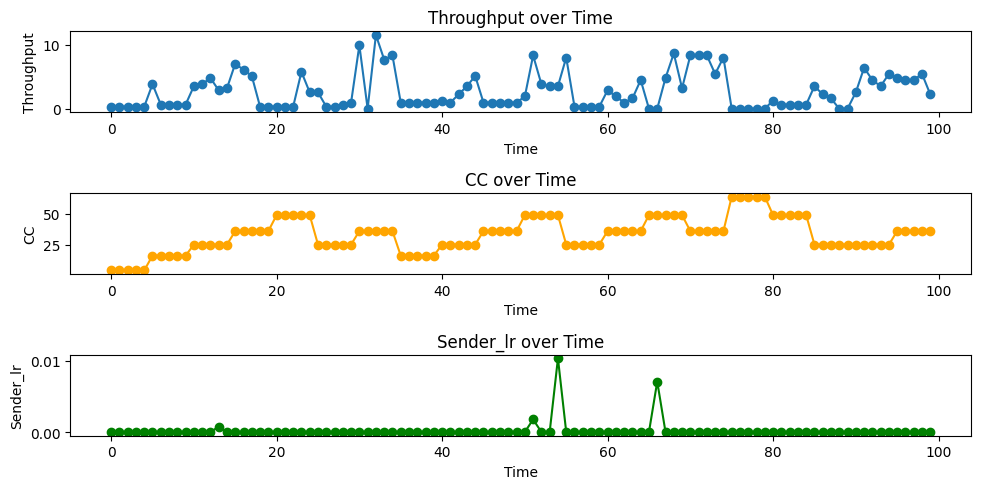

Episode reward: 100.8
actions [1, 1, 1, 0, 3, 0, 0, 3, 0, 0, 3, 0, 1, 4],   14
rewards [1.0, 2.4, 2.1999999999999997, -1.0, 3.0, -5.6, 4.6, -4.3999999999999995, -1.0000000000000002, -0.19999999999999996, -1.0, 2.6, -1.8, 100],  14
Average Throughput 3.7028571428571433
Total Energy 4044.0
Total packet loss 0.005039999999999999
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   70.000000         70.0  70.000000  70.000000   70.000000  70.000000
mean     3.702857          0.0   3.242857  34.794286   57.771429   0.000072
std      3.433810          0.0   3.099489   4.092584   30.435092   0.000333
min      0.000000          0.0   0.000000  32.600000    0.000000   0.000000
25%      1.280000          0.0   1.000000  32.800000   42.000000   0.000000
50%      2.560000          0.0   2.000000  33.000000   71.000000   0.000000
75%      5.760000          0.0   5.000000  34.625000   83.750000   0.000000
max     14.720000          0.0  13.000000  52.800000  100.000000

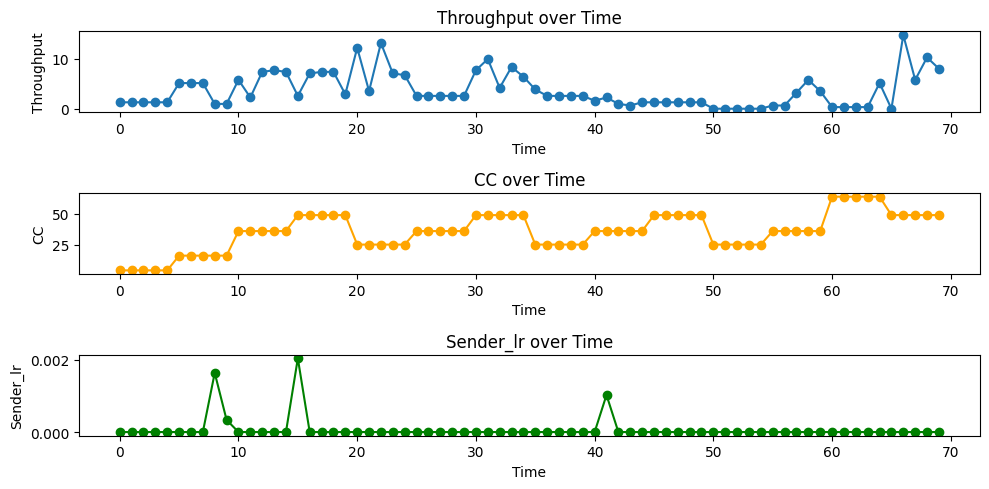

Episode reward: 106.2
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   15
rewards [0.0, 1.2, 2.4000000000000004, -1.0, 0.19999999999999973, 2.0, -4.8, 2.2, 3.5999999999999996, 1.2000000000000002, -4.2, -0.5999999999999996, -0.6000000000000001, 4.6, 100],  15
Average Throughput 3.784533333333334
Total Energy 4945.0
Total packet loss 0.16753700000000002
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   75.000000    75.000000  75.000000  75.000000  75.000000  75.000000
mean     3.784533     0.006667   3.280000  33.949333  65.933333   0.002234
std      2.982152     0.057735   2.714127   5.236653  24.834225   0.011897
min      0.000000     0.000000  -1.000000   0.000000   0.000000   0.000000
25%      1.600000     0.000000   1.000000  32.700000  50.000000   0.000000
50%      2.880000     0.000000   2.000000  32.900000  71.000000   0.000000
75%      6.720000     0.000000   6.000000  34.000000  83.000000   0.000000
max      9.600000     0.500000   8.000

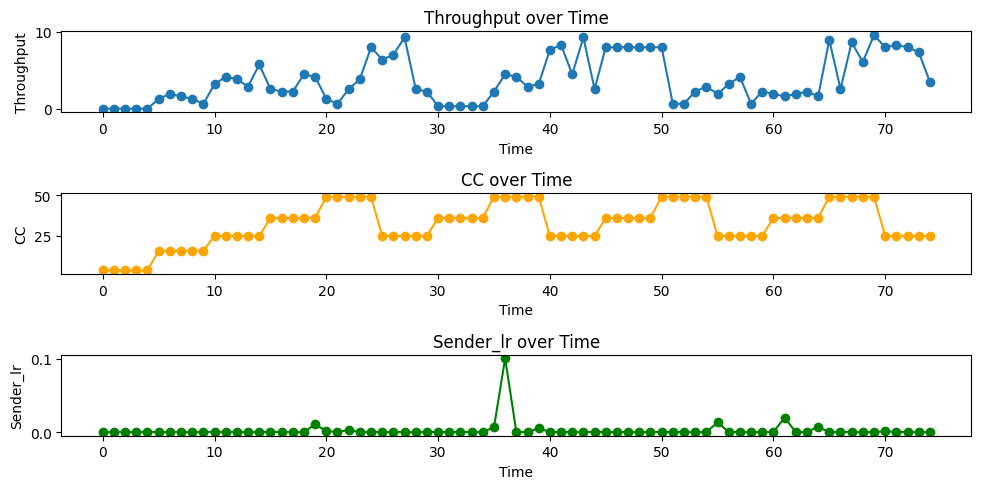

Episode reward: 101.0
actions [1, 1, 1, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   15
rewards [0.4, 3.8000000000000003, -1.8000000000000003, 3.4, -5.8, 3.8, 2.6000000000000005, -6.4, 5.4, 0.0, -3.6000000000000005, 0.19999999999999996, 3.2, -4.2, 100],  15
Average Throughput 3.776
Total Energy 4663.0
Total packet loss 0.000671
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   75.000000         75.0  75.000000  75.000000   75.000000  75.000000
mean     3.776000          0.0   3.280000  33.249333   62.173333   0.000009
std      3.172204          0.0   2.724067   6.072498   26.041741   0.000061
min      0.000000          0.0   0.000000   0.000000    0.000000   0.000000
25%      0.640000          0.0   1.000000  32.700000   43.000000   0.000000
50%      3.200000          0.0   3.000000  33.000000   73.000000   0.000000
75%      5.920000          0.0   5.000000  34.400000   81.000000   0.000000
max     10.880000          0.0   9.000000  47.900000  104.000000   0

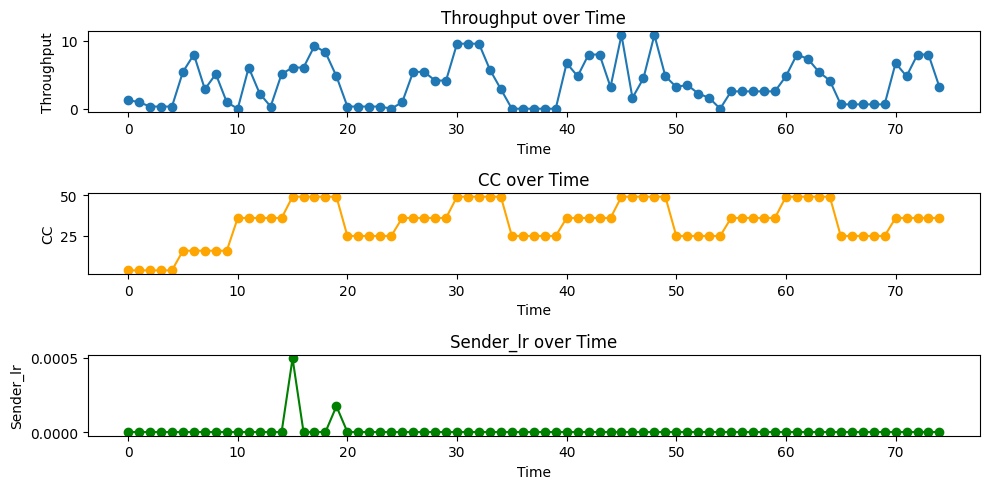

Episode reward: 100.4
actions [1, 1, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 2, 0],   23
rewards [0.4, 0.9999999999999999, -0.3999999999999999, 3.5999999999999996, -3.9999999999999996, 4.6000000000000005, -1.4000000000000004, -1.4, 2.8000000000000003, -4.2, -0.19999999999999996, 1.4000000000000001, -0.8000000000000003, 0.20000000000000018, -1.6, 3.0, 2.0, -2.8, -2.2, 1.0, 0.6000000000000001, -1.2000000000000002, 100],  23
Average Throughput 2.4069565217391307
Total Energy 6690.0
Total packet loss 0.087862
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  115.000000        115.0  115.000000  115.000000  115.000000  115.000000
mean     2.406957          0.0    2.173913   32.298261   58.173913    0.000764
std      2.637885          0.0    2.370361    8.583532   27.752749    0.005077
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.640000          0.0    1.000000   32.700000   48.000000    0.00000

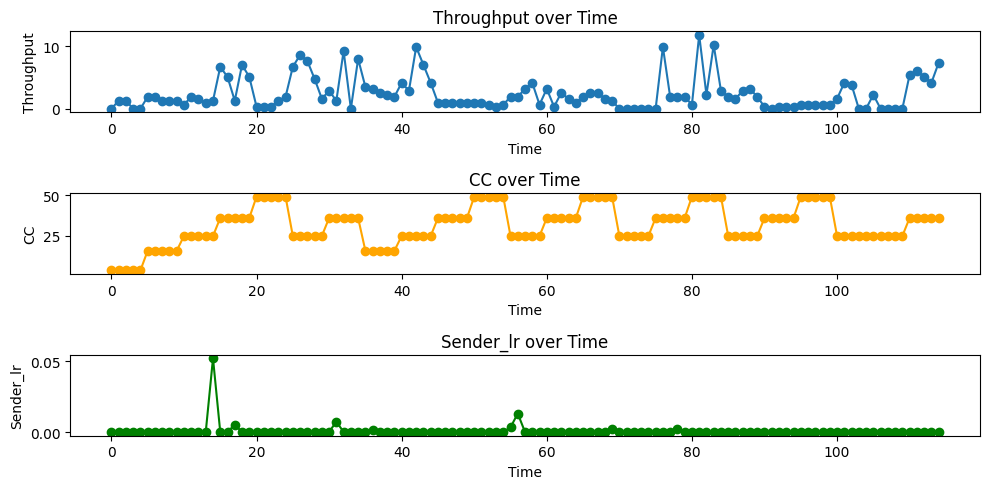

Episode reward: 100.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 1, 4, 2],   18
rewards [0.8, 0.3999999999999999, -0.19999999999999996, -1.0, 3.4, 4.6, -7.4, 6.2, -1.0, -4.8, 1.4, -1.5999999999999999, 0.19999999999999996, 5.6, -3.3999999999999995, -3.2, 0.0, 100],  18
Average Throughput 2.8622222222222224
Total Energy 5319.0
Total packet loss 0.088753
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   90.000000         90.0  90.000000  90.000000   90.000000  90.000000
mean     2.862222          0.0   2.522222  32.648889   59.100000   0.000986
std      3.252198          0.0   2.833300   7.732846   31.908947   0.004504
min      0.000000          0.0   0.000000   0.000000    0.000000   0.000000
25%      0.640000          0.0   1.000000  32.700000   43.000000   0.000000
50%      1.280000          0.0   1.000000  32.800000   59.000000   0.000000
75%      4.080000          0.0   3.750000  33.775000   87.000000   0.000000
max     13.120000          

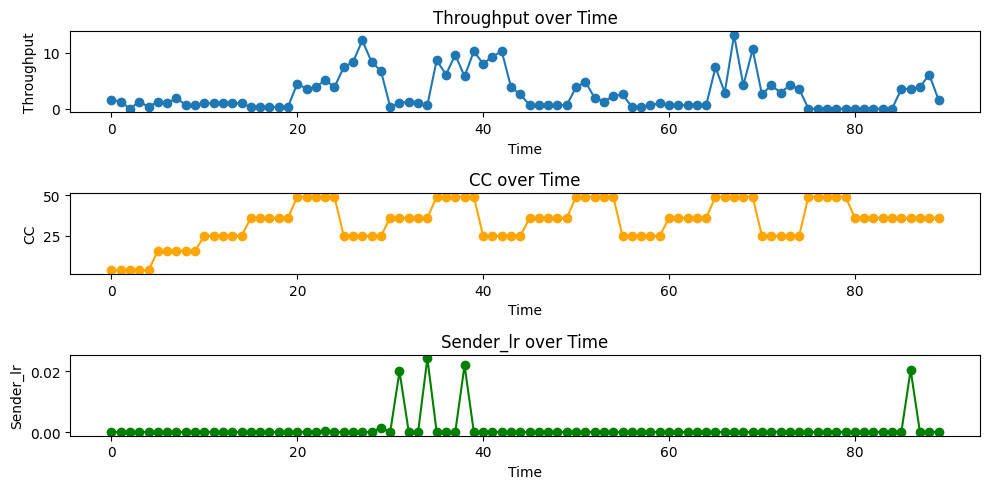

Episode reward: 100.0
actions [1, 1, 0, 0, 1, 3, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   20
rewards [0.8, -0.20000000000000007, 5.0, -0.5999999999999996, -2.2, -1.5999999999999999, 3.2, -0.40000000000000036, -0.3999999999999999, -3.6, 0.0, 2.4, -1.5999999999999999, 1.0, 1.2, -2.0, -1.0, 5.0, -5.0, 100],  20
Average Throughput 2.6848
Total Energy 6221.0
Total packet loss 0.12215
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  100.000000        100.0  100.000000  100.000000  100.000000  100.000000
mean     2.684800          0.0    2.350000   34.267000   62.210000    0.001221
std      2.590483          0.0    2.332792    6.290333   25.821569    0.006052
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.320000          0.0    0.000000   32.700000   44.000000    0.000000
50%      1.440000          0.0    1.000000   32.950000   66.000000    0.000000
75%      4.560000          0.0    4.000000   35.525000   80.7

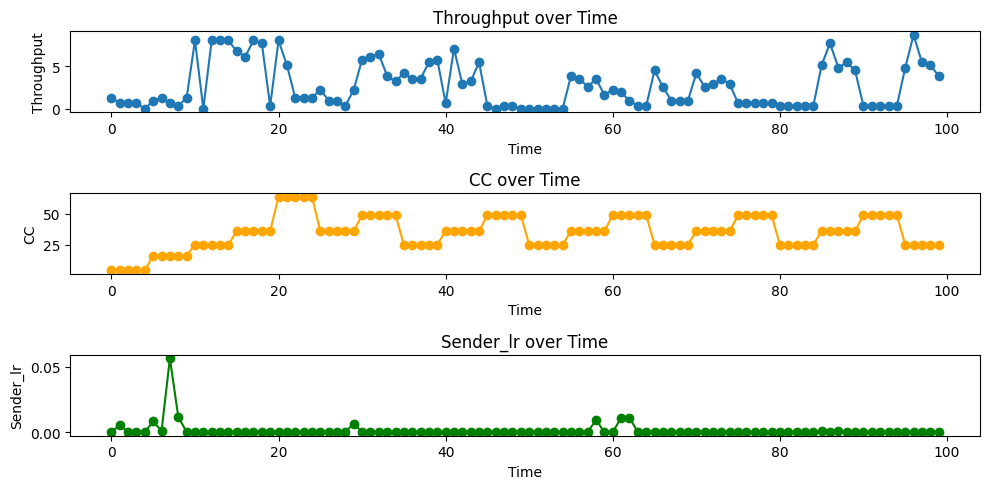

Episode reward: 101.8
actions [1, 1, 0, 0, 2, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 2, 0, 3, 0, 0, 3, 0],   24
rewards [1.0, -0.19999999999999996, 4.8, -5.6, 1.4, -0.5999999999999999, 2.2, -2.2, 0.8, 3.9999999999999996, -3.5999999999999996, -1.6, 0.7999999999999999, -0.19999999999999996, 0.0, 5.2, -4.800000000000001, -1.2, 2.8, 1.2000000000000002, -3.2, 0.0, 0.8, 100],  24
Average Throughput 2.269333333333334
Total Energy 7357.0
Total packet loss 0.109592
       Throughput  receiver_lr      Score         RTT      Energy   sender_lr
count  120.000000   120.000000  120.00000  120.000000  120.000000  120.000000
mean     2.269333     0.000926    2.05000   32.608333   61.308333    0.000913
std      2.682448     0.010143    2.38993    6.494401   28.174068    0.004841
min      0.000000     0.000000    0.00000    0.000000    0.000000    0.000000
25%      0.640000     0.000000    1.00000   32.700000   45.750000    0.000000
50%      1.280000     0.000000    1.00000   32.800000   59.500000    0.000

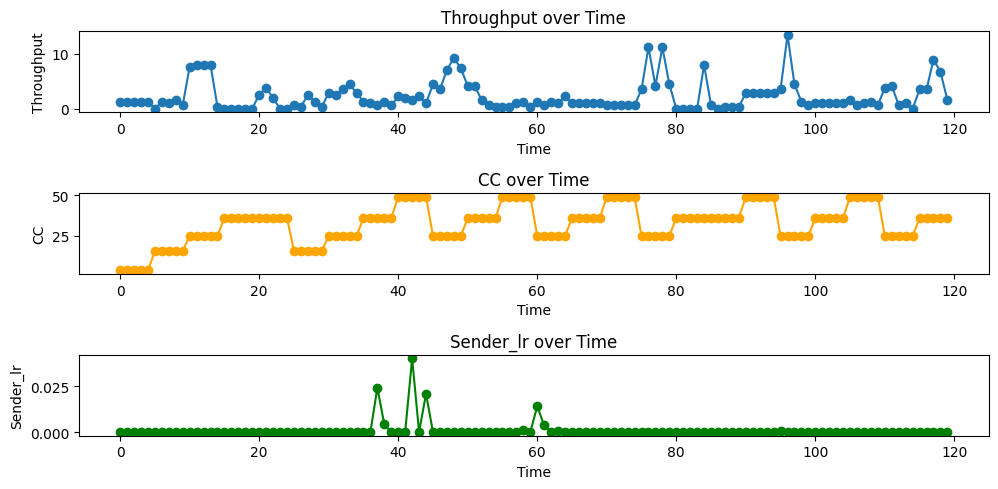

Episode reward: 104.8
actions [1, 1, 0, 0, 0, 3, 0, 0, 4, 0, 3, 0, 0, 3, 0, 3],   16
rewards [1.0, 3.2, -3.2, 2.4, -1.4, -2.0, 4.2, -4.2, 1.0, 3.8, 1.7999999999999998, -3.1999999999999997, 1.1999999999999997, -1.9999999999999996, 2.1999999999999997, 100],  16
Average Throughput 3.444
Total Energy 5168.0
Total packet loss 0.491736
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count    80.00000         80.0  80.000000  80.000000  80.000000  80.000000
mean      3.44400          0.0   2.812500  33.522500  64.600000   0.006147
std       2.94046          0.0   3.110186   7.779785  27.841141   0.037672
min       0.00000          0.0 -12.000000   0.000000   0.000000   0.000000
25%       0.64000          0.0   1.000000  32.700000  56.750000   0.000000
50%       2.88000          0.0   2.500000  32.800000  77.000000   0.000000
75%       4.88000          0.0   4.000000  34.325000  83.000000   0.000000
max      10.88000          0.0   9.000000  51.700000  98.000000   0.

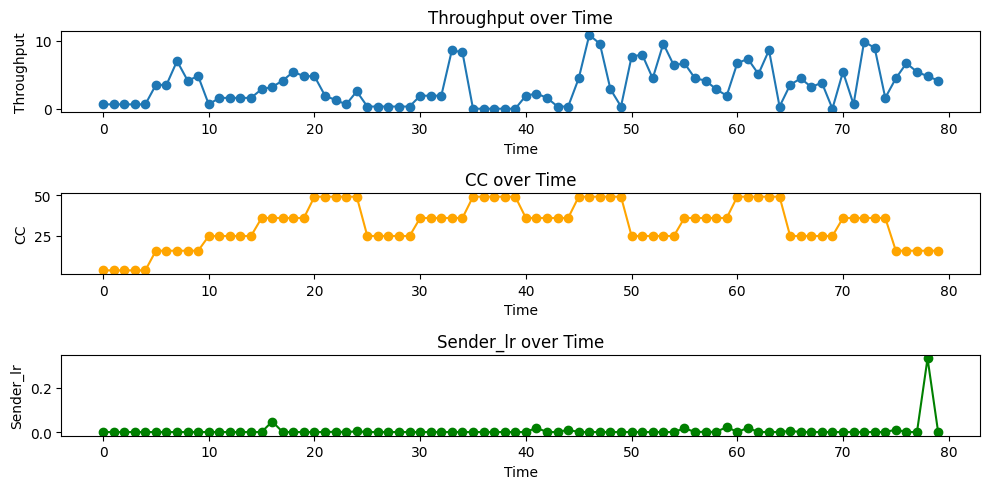

Episode reward: 107.2
actions [1, 1, 0, 0, 0, 3, 1, 3, 0, 0, 3, 0, 2, 0, 3, 0, 0, 3, 0],   19
rewards [0.6, 1.7999999999999998, 1.6, 1.5999999999999996, -3.5999999999999996, 3.5999999999999996, -3.5999999999999996, -2.0, 5.0, -4.2, 1.5999999999999999, -1.7999999999999998, 1.4, -0.8, -1.2, 1.4, 0.8000000000000003, 5.0, 100],  19
Average Throughput 2.8261052631578942
Total Energy 5338.0
Total packet loss 0.090498
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   95.000000         95.0  95.000000  95.000000  95.000000  95.000000
mean     2.826105          0.0   2.536842  33.927368  56.189474   0.000953
std      2.535909          0.0   2.296207   5.934921  24.502407   0.003984
min      0.000000          0.0   0.000000   0.000000   0.000000   0.000000
25%      0.640000          0.0   1.000000  32.700000  44.000000   0.000000
50%      1.920000          0.0   2.000000  33.000000  58.000000   0.000000
75%      4.480000          0.0   4.000000  34.750000  72.000

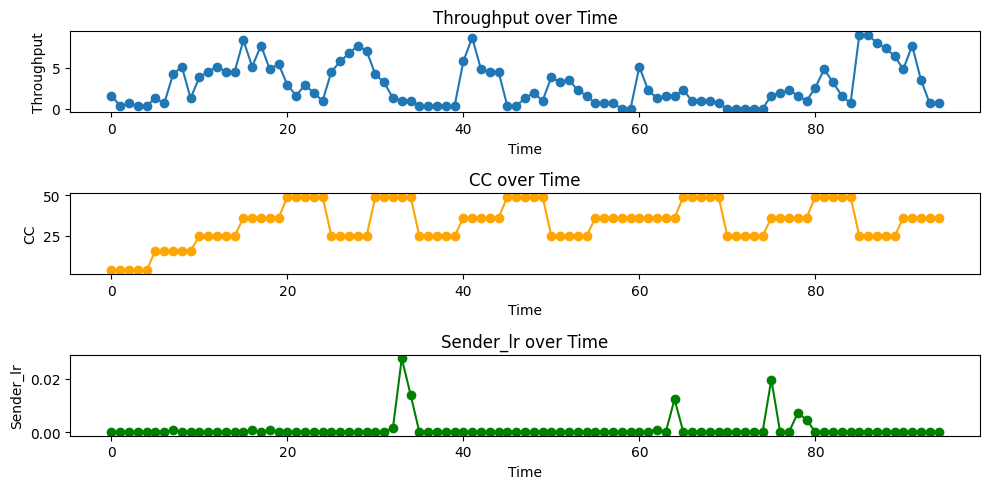

Episode reward: 106.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   19
rewards [1.0, 2.0, 0.20000000000000018, -0.6000000000000001, -2.0, 0.4, -1.0, 4.4, -2.4000000000000004, 0.6000000000000001, -2.0, 2.0, 2.9999999999999996, -0.5999999999999996, -4.0, 0.0, 0.6000000000000001, 4.4, 100],  19
Average Throughput 2.826105263157895
Total Energy 6237.0
Total packet loss 0.019278999999999998
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   95.000000         95.0  95.000000  95.000000   95.000000  95.000000
mean     2.826105          0.0   2.536842  34.012632   65.652632   0.000203
std      2.563254          0.0   2.244665   4.407881   19.937012   0.001220
min      0.320000          0.0   0.000000  32.600000   41.000000   0.000000
25%      0.960000          0.0   1.000000  32.700000   47.000000   0.000000
50%      2.240000          0.0   2.000000  32.800000   65.000000   0.000000
75%      4.160000          0.0   4.000000  33.250000   8

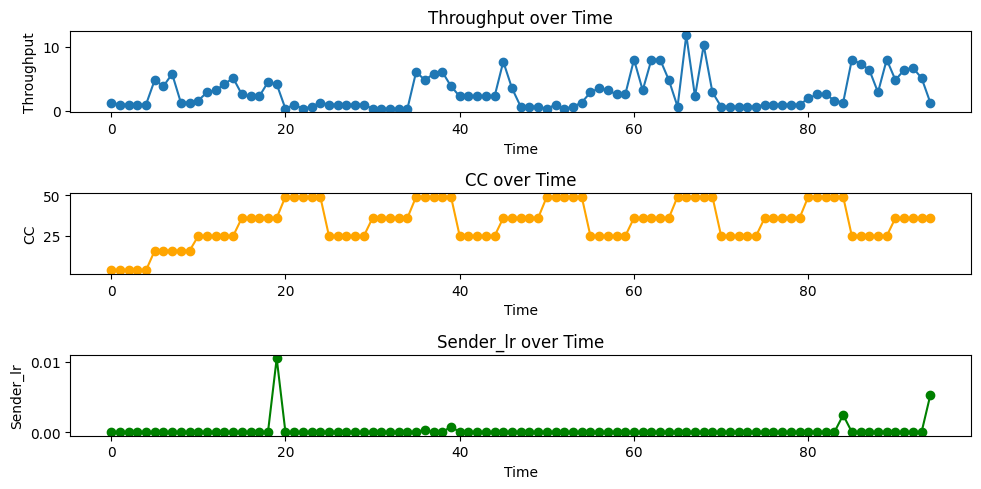

Episode reward: 103.6
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 2, 0, 3, 0, 0, 3],   19
rewards [0.4, 2.8000000000000003, -1.8000000000000003, 3.0000000000000004, -3.4000000000000004, 1.4, -0.5999999999999999, -0.40000000000000013, 3.0000000000000004, -0.6000000000000005, 0.7999999999999998, 1.0, -5.0, -0.6, 5.2, -5.2, 0.0, 3.6, 100],  19
Average Throughput 2.6981052631578946
Total Energy 5343.0
Total packet loss 0.052027000000000004
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   95.000000         95.0  95.000000  95.000000  95.000000  95.000000
mean     2.698105          0.0   2.347368  32.829474  56.242105   0.000548
std      2.918943          0.0   2.620575   8.539718  26.673246   0.003976
min      0.000000          0.0   0.000000   0.000000   0.000000   0.000000
25%      0.640000          0.0   1.000000  32.700000  43.000000   0.000000
50%      1.600000          0.0   1.000000  32.800000  51.000000   0.000000
75%      3.840000          0.0 

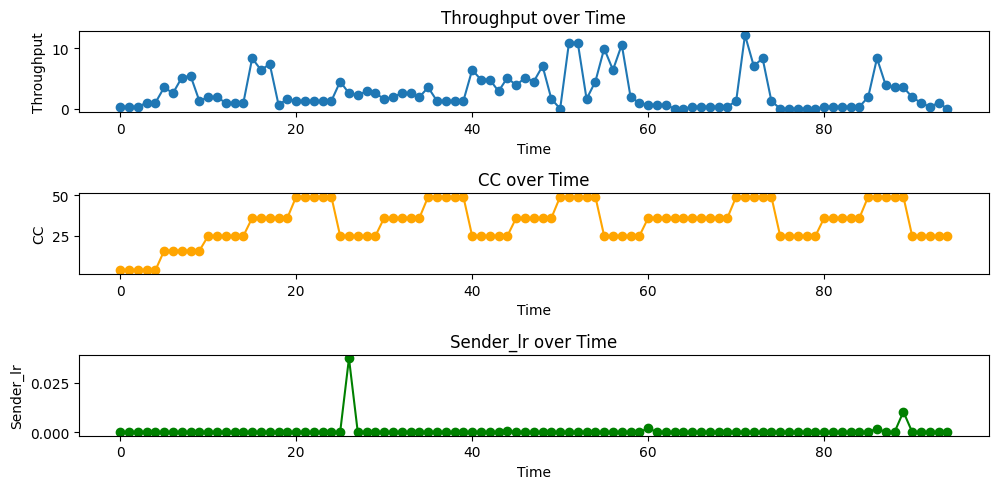

Episode reward: 101.6
actions [1, 1, 0, 0, 3, 0, 0, 1, 3, 0, 2, 3, 0, 0, 3, 0, 0],   17
rewards [2.0, 1.7999999999999998, -1.4, 2.8000000000000003, -5.2, 1.0, 4.0, -0.5999999999999996, -3.4000000000000004, 0.0, 0.8, 3.4000000000000004, -4.0, 3.0, -3.6, 1.0, 100],  17
Average Throughput 3.079529411764706
Total Energy 5045.0
Total packet loss 0.039277000000000006
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   85.000000    85.000000  85.000000  85.000000  85.000000  85.000000
mean     3.079529     0.005882   2.705882  35.415294  59.352941   0.000462
std      2.848495     0.054233   2.571934   7.092828  25.459448   0.002367
min      0.000000     0.000000   0.000000  32.600000   0.000000   0.000000
25%      0.960000     0.000000   1.000000  32.800000  43.000000   0.000000
50%      1.920000     0.000000   2.000000  32.900000  59.000000   0.000000
75%      5.120000     0.000000   5.000000  34.400000  83.000000   0.000000
max     10.240000     0.500000   9.0

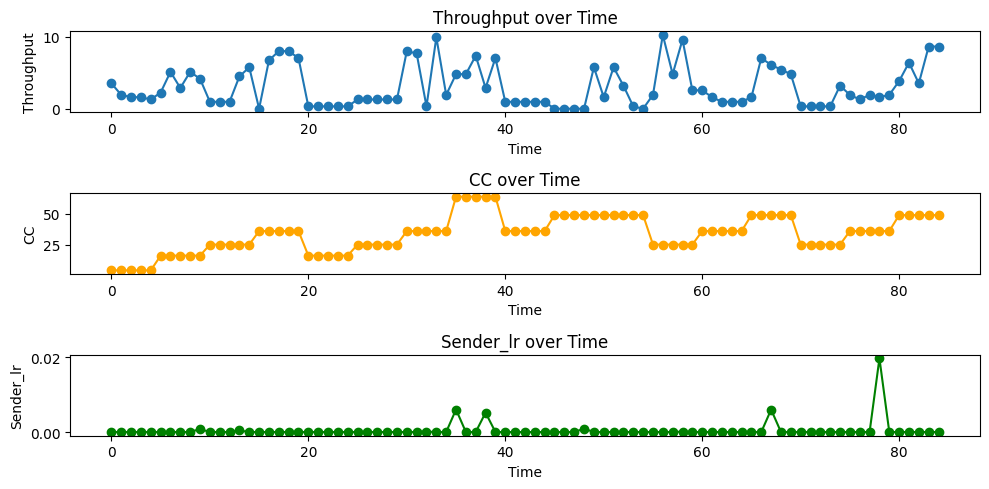

Episode reward: 102.4
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0],   17
rewards [1.0, 0.8, 3.6000000000000005, -3.0000000000000004, 3.8000000000000003, -2.6, -2.6, 3.5999999999999996, -4.6, 4.2, -1.8000000000000003, -0.5999999999999999, 2.8, -3.5999999999999996, 0.19999999999999996, 1.2, 100],  17
Average Throughput 3.0569411764705885
Total Energy 4662.0
Total packet loss 0.033321
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   85.000000         85.0  85.000000  85.000000  85.000000  85.000000
mean     3.056941          0.0   2.752941  33.390588  54.847059   0.000392
std      2.801254          0.0   2.497169   6.147911  26.216818   0.002474
min      0.000000          0.0   0.000000   0.000000   0.000000   0.000000
25%      0.960000          0.0   1.000000  32.700000  42.000000   0.000000
50%      1.920000          0.0   2.000000  32.800000  50.000000   0.000000
75%      4.480000          0.0   4.000000  34.100000  77.000000   0.000000


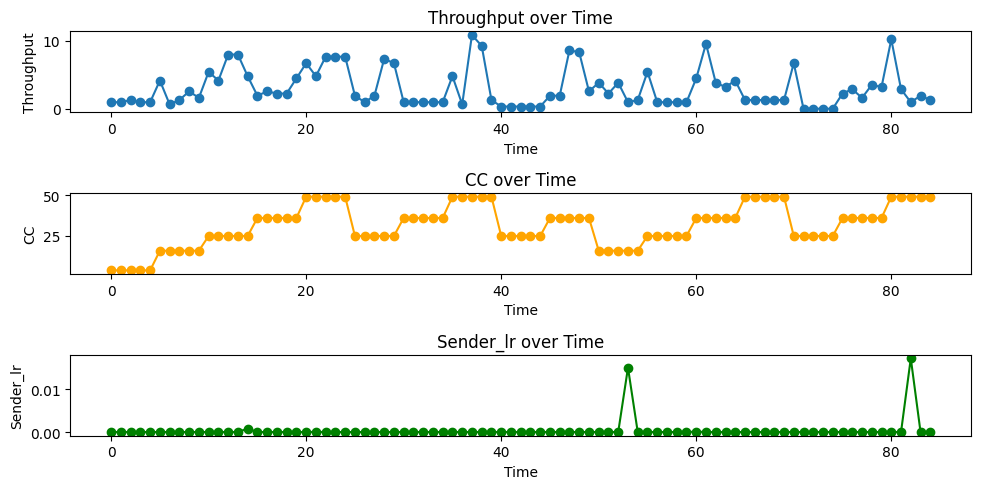

Episode reward: 104.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 4, 0, 3, 0, 0, 3, 0, 0, 3],   20
rewards [0.2, 0.0, -0.2, 2.2, -1.2000000000000002, -0.19999999999999996, 0.8, 5.0, -2.3999999999999995, -1.6, -1.2000000000000002, -1.4, 2.0, -1.6, 5.8, -1.4000000000000004, -4.8, 3.0, 1.0, 100],  20
Average Throughput 2.5792
Total Energy 5122.0
Total packet loss 0.10534800000000001
       Throughput  receiver_lr      Score        RTT     Energy   sender_lr
count  100.000000      100.000  100.00000  100.00000  100.00000  100.000000
mean     2.579200        0.001    2.25000   32.96300   51.22000    0.001053
std      2.979323        0.010    2.67942    8.20369   32.25579    0.003125
min      0.000000        0.000    0.00000    0.00000    0.00000    0.000000
25%      0.320000        0.000    0.00000   32.70000   40.00000    0.000000
50%      1.600000        0.000    1.00000   32.90000   53.00000    0.000000
75%      3.840000        0.000    3.00000   35.85000   81.00000    0.000000
max     11.

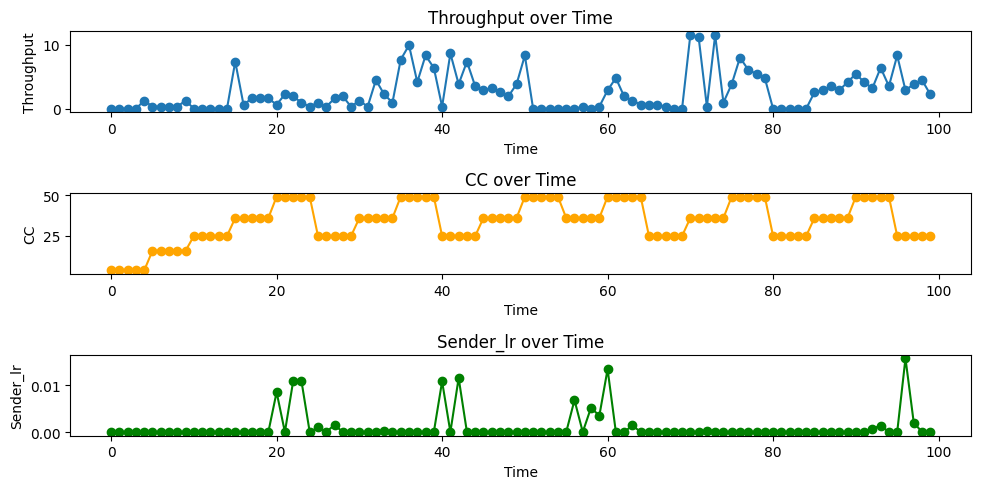

Episode reward: 103.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 3, 0, 0],   16
rewards [0.2, 0.8, 2.8, -1.9999999999999998, -1.8, 6.2, -3.0, 2.8, 1.2000000000000002, -3.6, -2.4000000000000004, 0.19999999999999996, 2.8000000000000003, -3.0, 1.8, 100],  16
Average Throughput 3.332
Total Energy 5553.0
Total packet loss 0.0007229999999999999
       Throughput  receiver_lr      Score       RTT      Energy  sender_lr
count   80.000000         80.0  80.000000  80.00000   80.000000  80.000000
mean     3.332000          0.0   2.962500  34.23750   69.412500   0.000009
std      3.000438          0.0   2.716307   3.07099   18.604949   0.000049
min      0.320000          0.0   0.000000  32.60000   41.000000   0.000000
25%      0.960000          0.0   1.000000  32.70000   47.750000   0.000000
50%      2.240000          0.0   2.000000  32.80000   75.000000   0.000000
75%      4.800000          0.0   4.000000  34.45000   86.000000   0.000000
max     11.840000          0.0  11.000000  49.20000  1

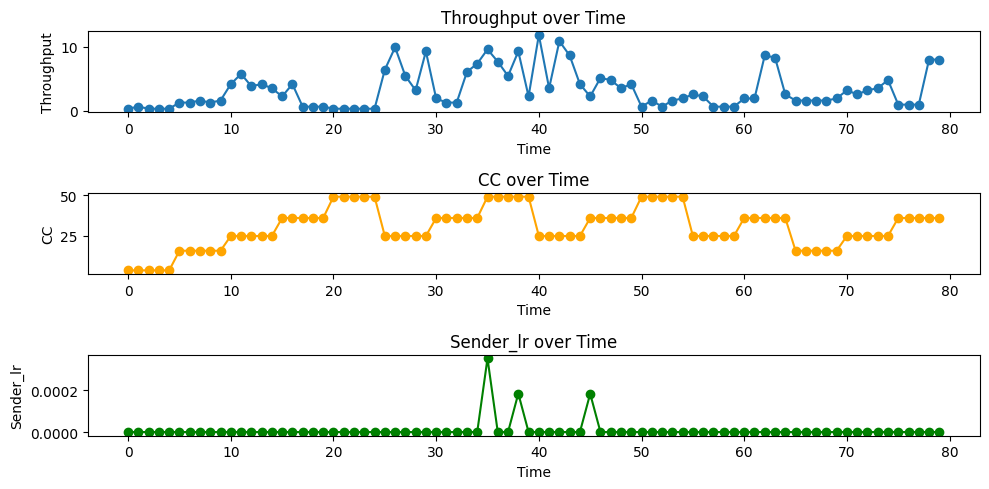

Episode reward: 103.4
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   17
rewards [3.6, -3.4, 1.0, 1.5999999999999999, 2.6000000000000005, -1.2000000000000002, -3.2, 1.0, 2.2, 1.0, -5.2, 0.4, 6.6, -6.0, 0.6000000000000001, 1.7999999999999998, 100],  17
Average Throughput 3.1849411764705877
Total Energy 5362.0
Total packet loss 0.077293
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   85.000000         85.0  85.000000  85.000000   85.000000  85.000000
mean     3.184941          0.0   2.788235  34.732941   63.082353   0.000909
std      2.959292          0.0   2.668574   3.733516   19.985240   0.005201
min      0.000000          0.0   0.000000  32.600000    0.000000   0.000000
25%      0.640000          0.0   1.000000  32.700000   46.000000   0.000000
50%      1.920000          0.0   2.000000  32.800000   58.000000   0.000000
75%      4.800000          0.0   4.000000  34.900000   82.000000   0.000000
max     13.440000          0.0  12.00000

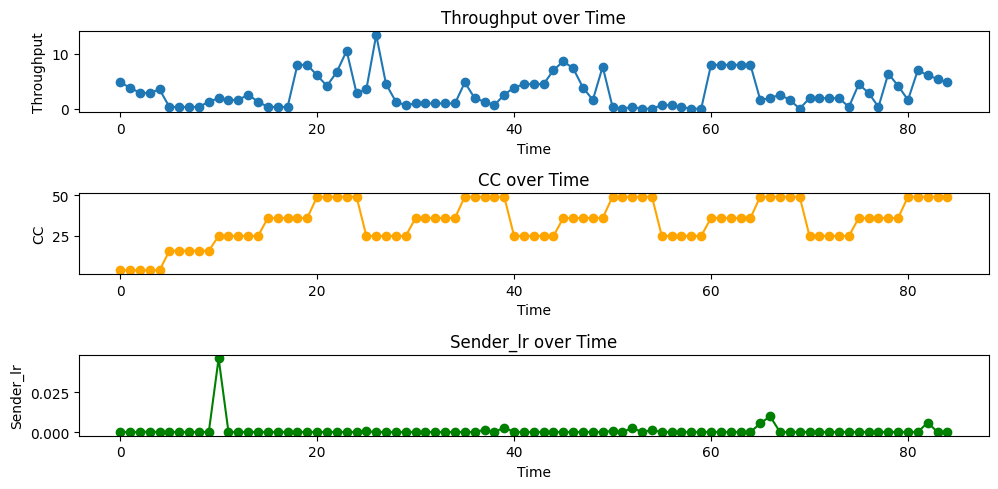

Episode reward: 105.6
actions [1, 1, 0, 0, 0, 3, 0, 1, 3, 0, 2, 3, 0, 0, 4, 0, 3],   17
rewards [1.4, 2.6, -3.4, 2.4, -1.0, -0.19999999999999996, 3.6000000000000005, -1.0, -2.6000000000000005, -1.8, 0.8, 3.6000000000000005, -3.0000000000000004, 1.0, -0.5999999999999999, 3.8, 100],  17
Average Throughput 3.030588235294118
Total Energy 4589.0
Total packet loss 0.054028
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   85.000000         85.0  85.000000  85.000000  85.000000  85.000000
mean     3.030588          0.0   2.694118  33.890588  53.988235   0.000636
std      2.715105          0.0   2.434981   2.808644  28.596326   0.002771
min      0.000000          0.0   0.000000  32.500000   0.000000   0.000000
25%      0.960000          0.0   1.000000  32.700000  43.000000   0.000000
50%      1.920000          0.0   2.000000  32.800000  54.000000   0.000000
75%      5.120000          0.0   4.000000  33.400000  73.000000   0.000000
max      9.280000          0.0

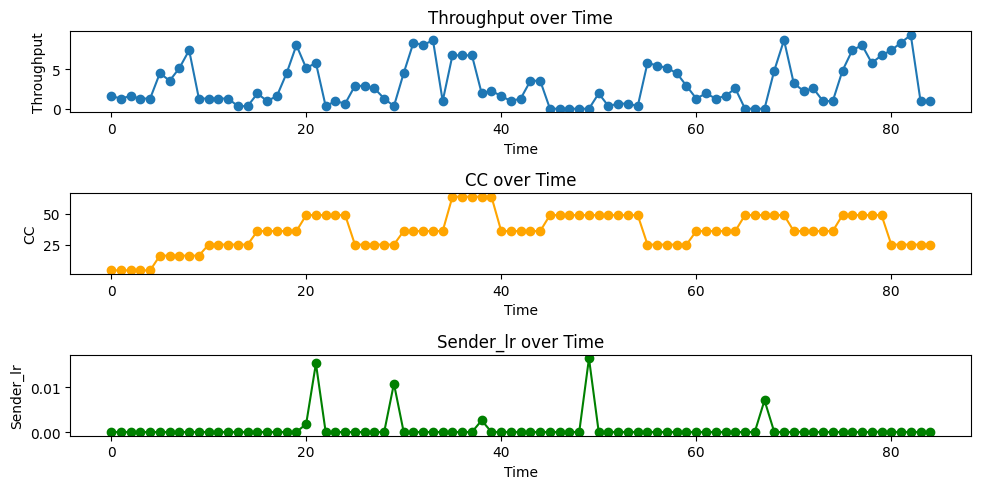

Episode reward: 105.8
actions [1, 1, 0, 0, 0, 3, 0, 0, 4, 0, 3, 0, 0, 3, 0],   15
rewards [1.0, 2.0, 1.0, 1.2000000000000002, -4.4, 5.0, -0.5999999999999996, -5.2, 4.4, -3.4000000000000004, 0.0, 2.2, 1.5999999999999996, 1.0, 100],  15
Average Throughput 3.5157333333333325
Total Energy 4405.0
Total packet loss 0.047784
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   75.000000         75.0  75.000000  75.000000  75.000000  75.000000
mean     3.515733          0.0   3.160000  33.610667  58.733333   0.000637
std      2.869166          0.0   2.604777   8.391366  22.078076   0.002278
min      0.000000          0.0   0.000000   0.000000   0.000000   0.000000
25%      1.280000          0.0   1.000000  32.700000  47.500000   0.000000
50%      2.880000          0.0   3.000000  33.000000  62.000000   0.000000
75%      5.280000          0.0   5.000000  34.500000  77.000000   0.000000
max     13.760000          0.0  12.000000  56.800000  86.000000   0.015151
     

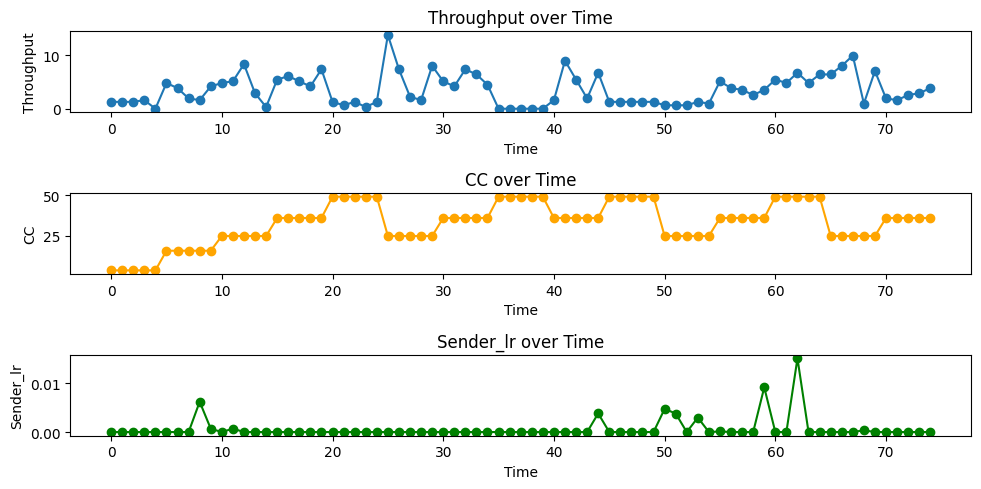

Episode reward: 101.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 4, 2, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   24
rewards [0.0, 2.6, 1.6, -1.0, -2.2, -0.19999999999999996, 0.3999999999999999, 0.8, -0.19999999999999996, -0.19999999999999996, -1.6, 1.2, 0.8, -2.0, 5.0, -4.0, 5.6, -6.6, 1.0, 0.0, 1.0, -2.0, 1.0, 100],  24
Average Throughput 2.181333333333334
Total Energy 6756.0
Total packet loss 0.37001300000000004
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  120.000000        120.0  120.000000  120.000000  120.000000  120.000000
mean     2.181333          0.0    1.766667   32.942500   56.300000    0.003083
std      2.209242          0.0    2.251921    6.059185   25.887475    0.029180
min      0.000000          0.0   -8.000000    0.000000    0.000000    0.000000
25%      0.320000          0.0    0.000000   32.700000   42.000000    0.000000
50%      1.280000          0.0    1.000000   32.800000   56.500000    0.000000
75%      3.520000          0.0    3.

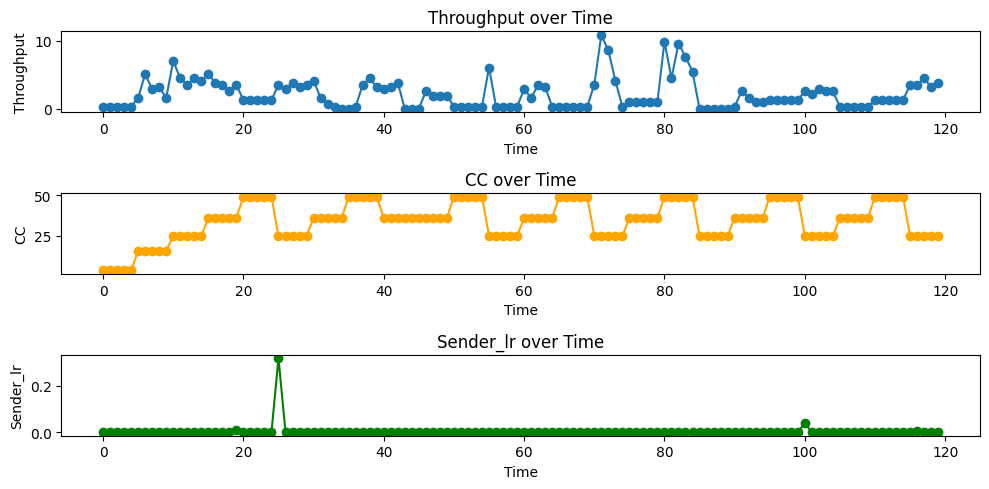

Episode reward: 101.2
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 1, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   23
rewards [0.2, 1.0, -1.2, 2.4, -1.0, -0.7999999999999999, -0.6, 0.2, 0.8, 5.0, -6.0, 2.8, -1.9999999999999998, 1.0, 5.2, -1.7999999999999998, -5.2, 4.8, -2.8, -2.0, 5.0, -3.8, 100],  23
Average Throughput 2.2817391304347825
Total Energy 6199.0
Total packet loss 0.100078
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  115.000000        115.0  115.000000  115.000000  115.000000  115.000000
mean     2.281739          0.0    1.965217   34.163478   53.904348    0.000870
std      2.770802          0.0    2.456393    6.653575   26.344870    0.002943
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.320000          0.0    0.000000   32.700000   43.000000    0.000000
50%      0.960000          0.0    1.000000   32.800000   52.000000    0.000000
75%      3.040000          0.0    2.500000   33.500000   78.500000    0

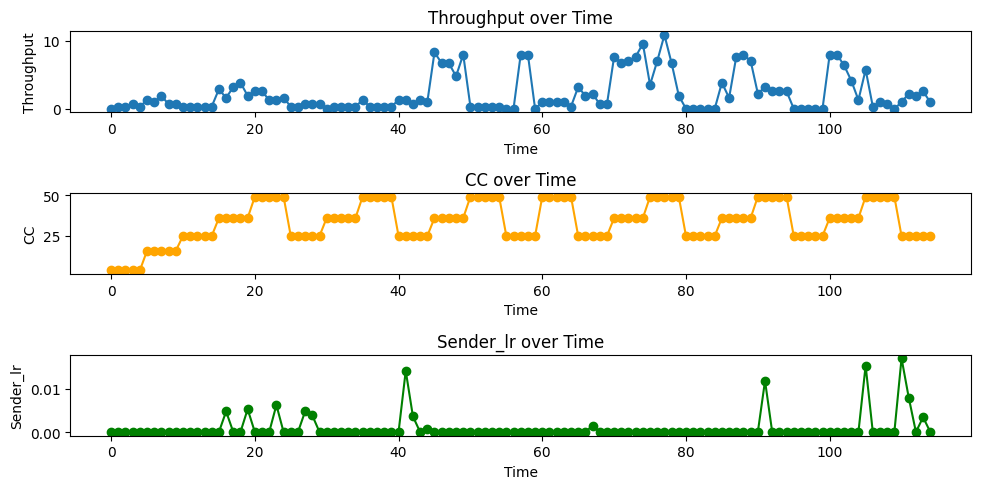

Episode reward: 106.2
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 1, 3, 0, 1, 3, 0],   15
rewards [1.0, 1.0, -1.0, 2.0, 3.8, -5.199999999999999, -0.6000000000000001, 0.0, 5.6, -5.6, 4.0, -2.4, 1.0, 2.6, 100],  15
Average Throughput 3.6224000000000007
Total Energy 4518.0
Total packet loss 0.013325
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   75.000000         75.0  75.000000  75.000000  75.000000  75.000000
mean     3.622400          0.0   3.253333  34.034667  60.240000   0.000178
std      3.705822          0.0   3.205120   2.627171  27.076388   0.001059
min      0.000000          0.0   0.000000  32.500000   0.000000   0.000000
25%      0.960000          0.0   1.000000  32.700000  43.000000   0.000000
50%      1.920000          0.0   2.000000  32.900000  58.000000   0.000000
75%      5.120000          0.0   5.000000  33.550000  85.500000   0.000000
max     15.360000          0.0  14.000000  44.800000  91.000000   0.007816
                         Time  Thro

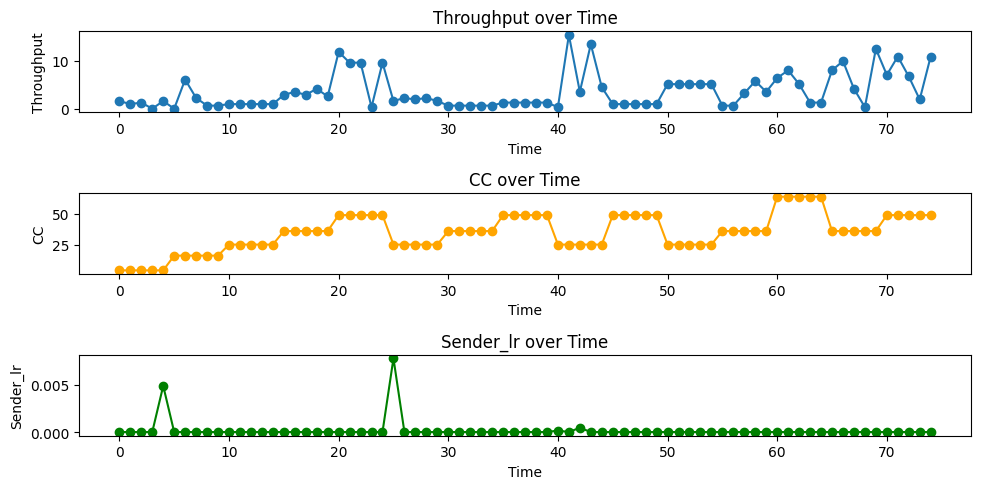

Episode reward: 100.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 2, 3, 1, 3, 0, 2, 0, 3, 0],   23
rewards [2.4, -1.5999999999999999, 3.0, 1.2000000000000002, -4.4, 0.4, -1.0, 2.4, -1.2, 1.2, 1.4, -1.9999999999999998, 0.19999999999999996, 0.0, -0.8, 4.2, -5.2, 0.8, 2.6, -0.20000000000000018, -2.4, -1.0, 100],  23
Average Throughput 2.3568695652173917
Total Energy 6037.0
Total packet loss 0.160105
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  115.000000        115.0  115.000000  115.000000  115.000000  115.000000
mean     2.356870          0.0    2.104348   32.522609   52.495652    0.001392
std      2.657555          0.0    2.422026    7.857392   27.732233    0.005967
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.640000          0.0    1.000000   32.650000   43.000000    0.000000
50%      1.280000          0.0    1.000000   32.700000   51.000000    0.000000
75%      3.200000          0.0    3.0000

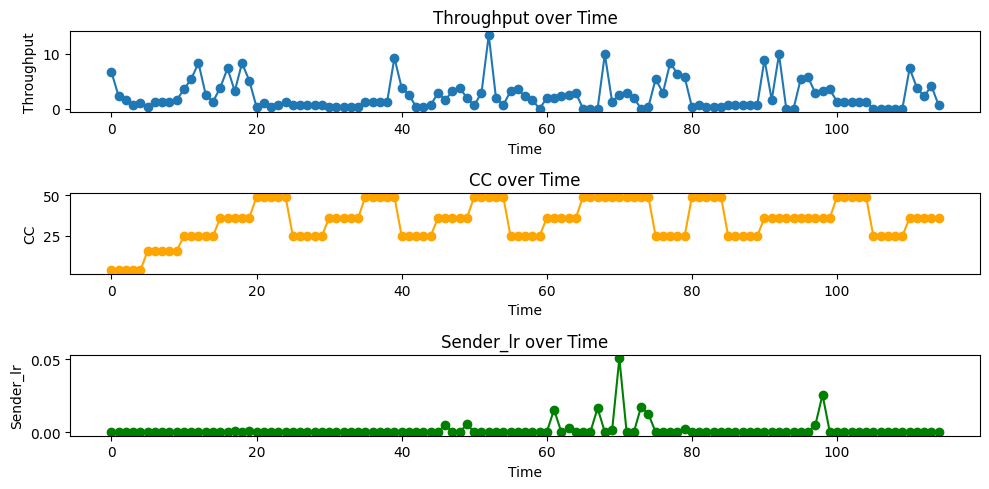

Episode reward: 101.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   17
rewards [1.0, 0.0, 3.8, 1.4000000000000004, -4.4, -0.8, 6.0, -5.8, 1.2, 1.6, 2.5999999999999996, -1.0, -5.0, 0.20000000000000007, 1.0, -0.8, 100],  17
Average Throughput 3.06070588235294
Total Energy 5391.0
Total packet loss 0.011096
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   85.000000    85.000000  85.000000  85.000000  85.000000  85.000000
mean     3.060706     0.005882   2.811765  34.714118  63.423529   0.000131
std      3.147937     0.054233   2.770998   5.913044  22.488291   0.001169
min      0.000000     0.000000   0.000000  32.500000   0.000000   0.000000
25%      0.640000     0.000000   1.000000  32.700000  43.000000   0.000000
50%      1.600000     0.000000   1.000000  32.800000  64.000000   0.000000
75%      4.480000     0.000000   4.000000  33.200000  81.000000   0.000000
max     11.520000     0.500000  10.000000  68.200000  92.000000   0.010778
   

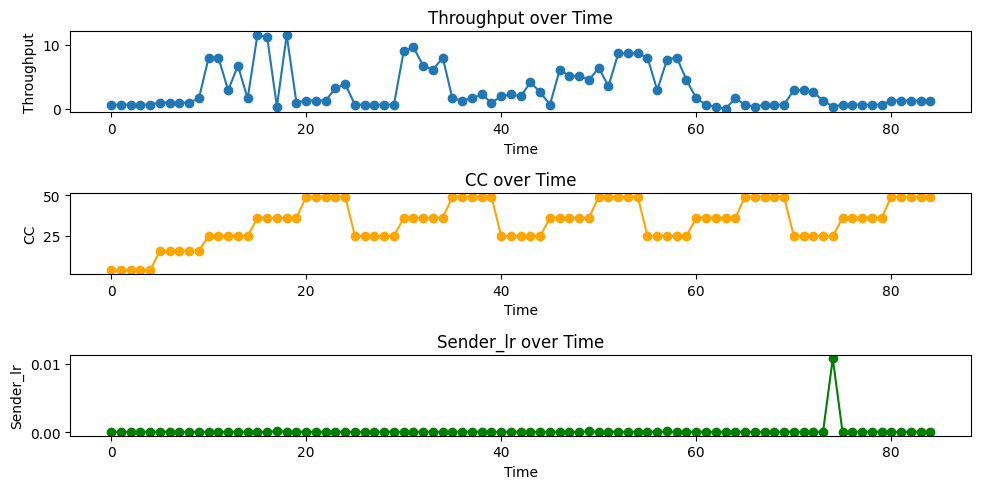

Episode reward: 101.0
actions [1, 1, 0, 0, 2, 0, 3, 0, 0, 3, 0, 2, 3, 0, 0, 0, 3, 0, 0, 4, 2, 0, 3],   23
rewards [0.0, 3.6, -1.6, -1.4, -0.39999999999999997, 6.6, -1.7999999999999998, -4.4, -0.6, 5.0, -3.6, 3.8000000000000003, -4.2, 1.6, -0.8, 1.4000000000000001, -2.6, 2.6, -3.2, 0.0, 1.8, -0.8, 100],  23
Average Throughput 2.4375652173913043
Total Energy 5962.0
Total packet loss 0.09507600000000001
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  115.000000   115.000000  115.000000  115.000000  115.000000  115.000000
mean     2.437565     0.004348    2.191304   32.311304   51.843478    0.000827
std      2.699558     0.046625    2.383774    8.806265   30.723039    0.004204
min      0.000000     0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.320000     0.000000    0.000000   32.700000   42.000000    0.000000
50%      0.960000     0.000000    1.000000   32.800000   50.000000    0.000000
75%      4.160000     0.000000    3.500000 

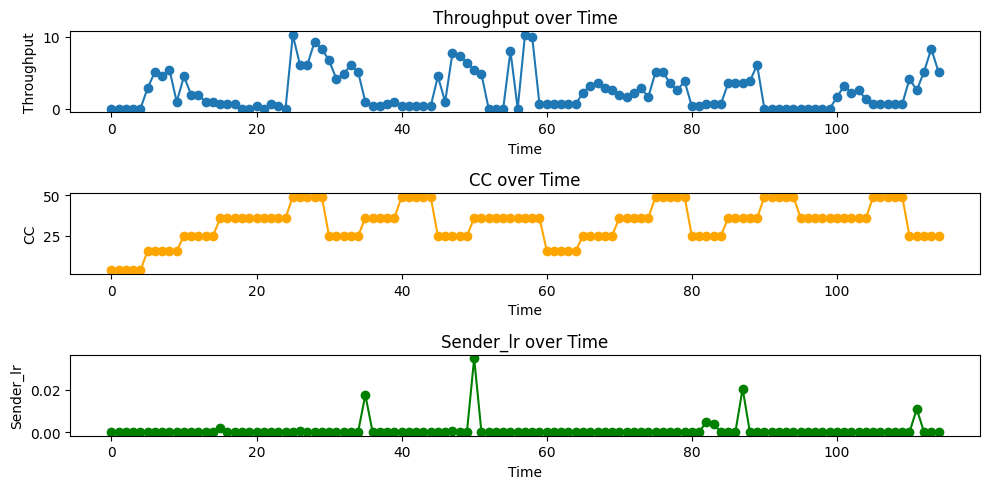

Episode reward: 104.2
actions [1, 1, 0, 0, 0, 3, 1, 3, 0, 0, 3, 0, 0, 3, 0, 2, 0, 3, 0],   19
rewards [0.4, 2.2, -2.6, 5.0, 0.5999999999999996, -2.5999999999999996, -2.8, 5.2, -5.4, 2.4, 1.0, -3.0, 0.7999999999999999, 1.0000000000000002, -2.2, 0.0, 6.0, -1.7999999999999998, 100],  19
Average Throughput 2.8294736842105266
Total Energy 5251.0
Total packet loss 0.109865
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   95.000000         95.0  95.000000  95.000000   95.000000  95.000000
mean     2.829474          0.0   2.452632  34.055789   55.273684   0.001156
std      2.838209          0.0   2.579660   6.096087   28.939203   0.007529
min      0.000000          0.0   0.000000   0.000000    0.000000   0.000000
25%      0.320000          0.0   0.000000  32.700000   43.000000   0.000000
50%      1.920000          0.0   1.000000  32.900000   55.000000   0.000000
75%      4.640000          0.0   4.000000  34.950000   82.000000   0.000000
max      9.600000     

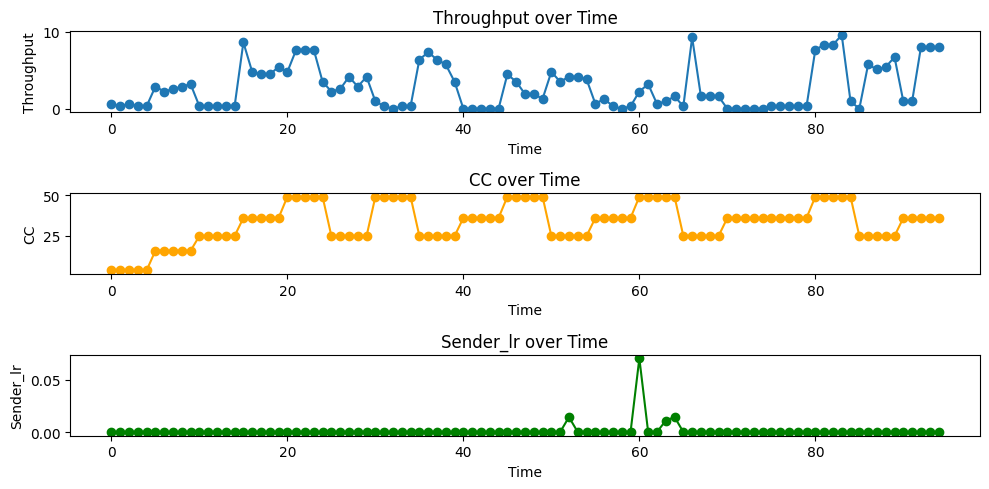

Episode reward: 104.2
actions [1, 1, 0, 0, 0, 3, 2, 0, 0, 3, 0, 0, 2, 3, 0, 0, 3, 2, 0, 0],   20
rewards [1.6, -0.6000000000000001, 0.6000000000000001, -0.6000000000000001, 0.0, 2.6, -2.8, 0.8, -0.6000000000000001, 4.8, -4.0, 0.9999999999999998, 3.2, -1.5999999999999996, -2.8000000000000003, -0.40000000000000013, 2.5999999999999996, -3.8, 4.2, 100],  20
Average Throughput 2.6688
Total Energy 5755.0
Total packet loss 0.08401499999999999
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  100.000000        100.0  100.000000  100.000000  100.000000  100.000000
mean     2.668800          0.0    2.430000   32.585000   57.550000    0.000840
std      2.753578          0.0    2.425683    8.915522   30.821865    0.003716
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.880000          0.0    1.000000   32.700000   44.000000    0.000000
50%      1.280000          0.0    1.000000   33.000000   53.000000    0.000000
75%    

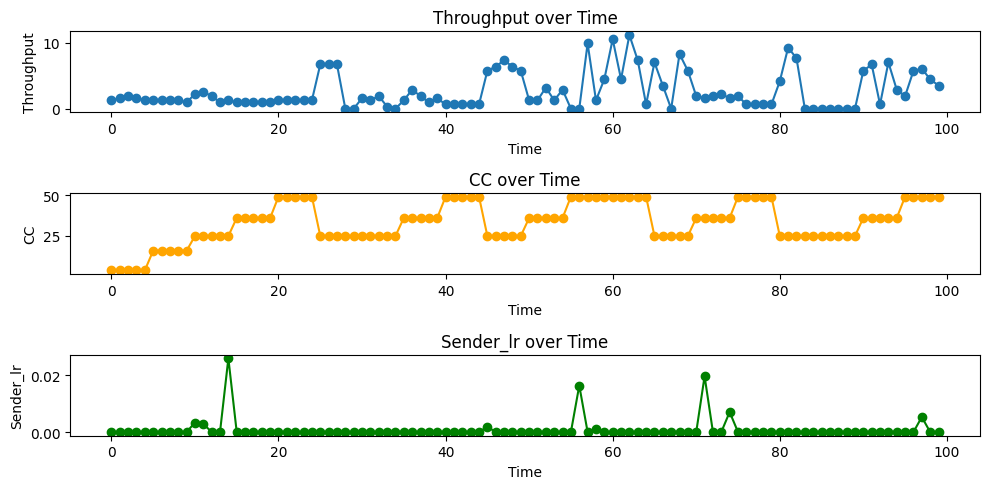

Episode reward: 103.6
actions [1, 1, 0, 0, 0, 4, 2, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   18
rewards [0.2, 0.39999999999999997, 4.4, -3.6, -1.4, 4.8, -3.8, -1.0, 5.8, -4.8, 2.4, -3.4, 3.6, 2.9999999999999996, -3.5999999999999996, -0.3999999999999999, 1.0, 100],  18
Average Throughput 2.88
Total Energy 4623.0
Total packet loss 0.18898099999999998
       Throughput  receiver_lr      Score      RTT     Energy  sender_lr
count   90.000000    90.000000  90.000000  90.0000  90.000000  90.000000
mean     2.880000     0.005556   2.522222  32.4500  51.366667   0.002100
std      3.192801     0.052705   2.942245  11.4244  33.364332   0.012026
min      0.000000     0.000000  -1.000000   0.0000   0.000000   0.000000
25%      0.320000     0.000000   0.000000  32.7000  41.000000   0.000000
50%      1.280000     0.000000   1.000000  32.9000  51.000000   0.000000
75%      5.120000     0.000000   4.000000  34.1250  87.000000   0.000000
max     10.240000     0.500000   9.000000  68.2000  98.000000   0.1080

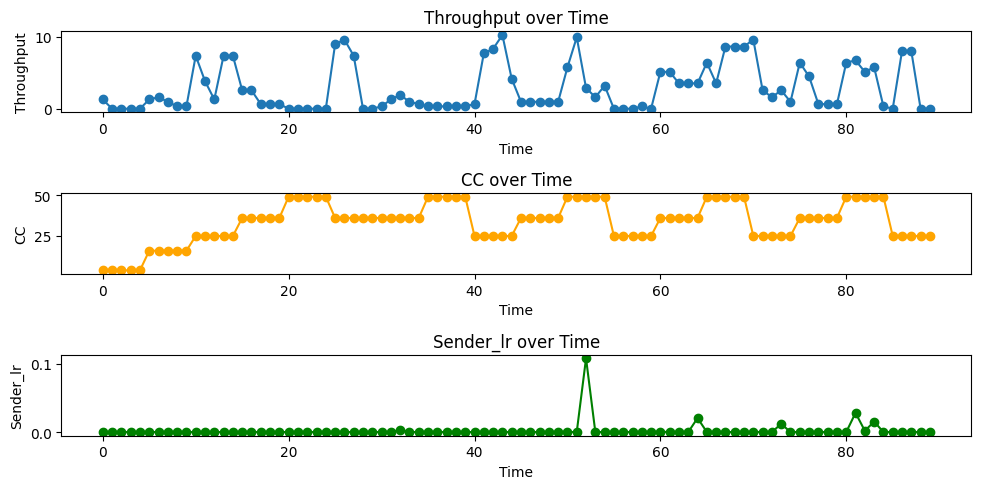

Episode reward: 100.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   18
rewards [3.2, -2.0, 1.5999999999999999, -1.1999999999999997, -0.6000000000000001, 0.8, -0.19999999999999996, 4.6, -1.2000000000000002, 0.7999999999999998, -3.8, -2.0, 1.2, -0.19999999999999996, 2.8, 2.0, -5.8, 100],  18
Average Throughput 2.890666666666667
Total Energy 5835.0
Total packet loss 0.051755
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   90.000000    90.000000  90.000000  90.000000   90.000000  90.000000
mean     2.890667     0.001111   2.577778  33.732222   64.833333   0.000575
std      2.712513     0.010541   2.494839   2.181373   22.765660   0.002763
min      0.000000     0.000000   0.000000  32.500000    0.000000   0.000000
25%      0.960000     0.000000   1.000000  32.700000   45.500000   0.000000
50%      1.920000     0.000000   2.000000  32.800000   57.000000   0.000000
75%      3.840000     0.000000   3.000000  33.400000   83.000000   0.0000

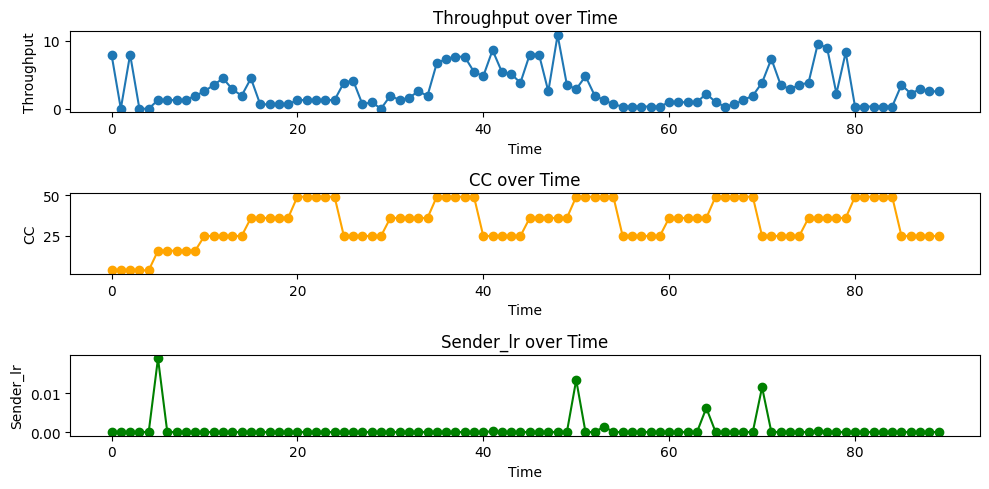

Episode reward: 104.6
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 3, 0, 1, 3, 0, 0, 3, 0, 0, 3, 0],   21
rewards [1.0, 0.19999999999999996, -1.2, 4.4, -2.6000000000000005, 4.2, -5.0, -0.4, -0.6, 4.2, 0.7999999999999998, -2.8, -1.2000000000000002, 0.3999999999999999, 0.8000000000000003, -1.0000000000000002, -0.19999999999999996, -1.0, 6.0, -1.4000000000000004, 100],  21
Average Throughput 2.547809523809524
Total Energy 6187.0
Total packet loss 0.104514
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  105.000000        105.0  105.000000  105.000000  105.000000  105.000000
mean     2.547810          0.0    2.304762   33.711429   58.923810    0.000995
std      2.962219          0.0    2.642565    5.732671   26.361283    0.003802
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.640000          0.0    1.000000   32.700000   43.000000    0.000000
50%      1.280000          0.0    1.000000   32.900000   57.000000    0.000

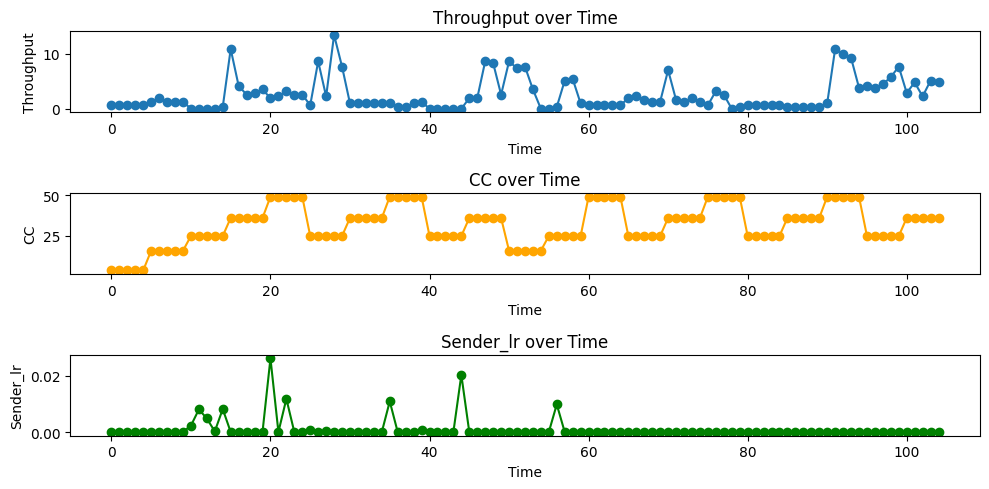

In [7]:
####       RL PPO   SB3

num_of_run=30

rl_throughput_list=[]
rl_energy_list=[]
rl_plr_list=[]


model = PPO.load("./model_sb3/ppo_action_in_de/ppo_best_model/best_model.zip")
for i in range(0,num_of_run):
    done = False
    episode_reward = 0
    env=transferClass_increase_decrease(loaded_dfs,loaded_initial_dfs,'random')
    action_list=[]
    reward_list=[]
    obs = env.reset()
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action_list.append(int(action))
    #     print("action: ",action)
        obs, reward, done, info = env.step(action)
    #     obs = obs.astype(np.float32)
    #     print("obs: ", obs,".... reward: ",reward)
        reward_list.append(reward)
        episode_reward += reward

    accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
    accumulator_df=accumulator_df.reset_index(drop=True)
    env.close()
    
    
    print(f"Episode reward: {episode_reward}")
    print(f"actions {action_list},   {len(action_list)}")
    print(f"rewards {reward_list},  {len(reward_list)}")
    print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
    print(f"Total Energy {accumulator_df['Energy'].sum()}")
    print(f"Total packet loss {accumulator_df['sender_lr'].sum()}")
    
    
    
    rl_throughput_list.append(accumulator_df['Throughput'].mean())
    rl_energy_list.append(accumulator_df['Energy'].sum())
    rl_plr_list.append(accumulator_df['sender_lr'].sum())
    print(accumulator_df.describe())
    print(accumulator_df)
    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(10, 5))  # 3 plots vertically stacked

    # Throughput
    axs[0].plot(accumulator_df.index, accumulator_df['Throughput'], marker='o', linestyle='-')
    axs[0].set_title('Throughput over Time')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Throughput')

    # CC
    axs[1].plot(accumulator_df.index, accumulator_df['CC'], marker='o', linestyle='-', color='orange')
    axs[1].set_title('CC over Time')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('CC')

    # Sender_lr
    axs[2].plot(accumulator_df.index, accumulator_df['sender_lr'], marker='o', linestyle='-', color='green')  # Assuming Score is a typo and you meant sender_lr
    axs[2].set_title('Sender_lr over Time')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Sender_lr')

    plt.tight_layout()
    plt.show()

Episode reward: 104.6
actions [1, 1, 1, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   16
rewards [1.0, -1.0, 2.6, 1.8000000000000003, -3.0000000000000004, 2.0, 0.6000000000000001, 0.0, 0.0, -2.4, -1.6, 6.2, -6.2, 6.2, -1.6000000000000005, 100],  16
Average Throughput 3.372
Total Energy 5132.0
Total packet loss 0.040243
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   80.000000         80.0  80.000000  80.000000   80.000000  80.000000
mean     3.372000          0.0   2.987500  34.605000   64.150000   0.000503
std      3.015198          0.0   2.683724   3.305305   24.869329   0.001763
min      0.000000          0.0   0.000000  32.600000    0.000000   0.000000
25%      0.640000          0.0   1.000000  32.775000   48.000000   0.000000
50%      2.880000          0.0   2.500000  33.050000   76.000000   0.000000
75%      5.520000          0.0   5.000000  34.650000   79.000000   0.000000
max     11.520000          0.0  10.000000  45.900000  101.000000   0.011911

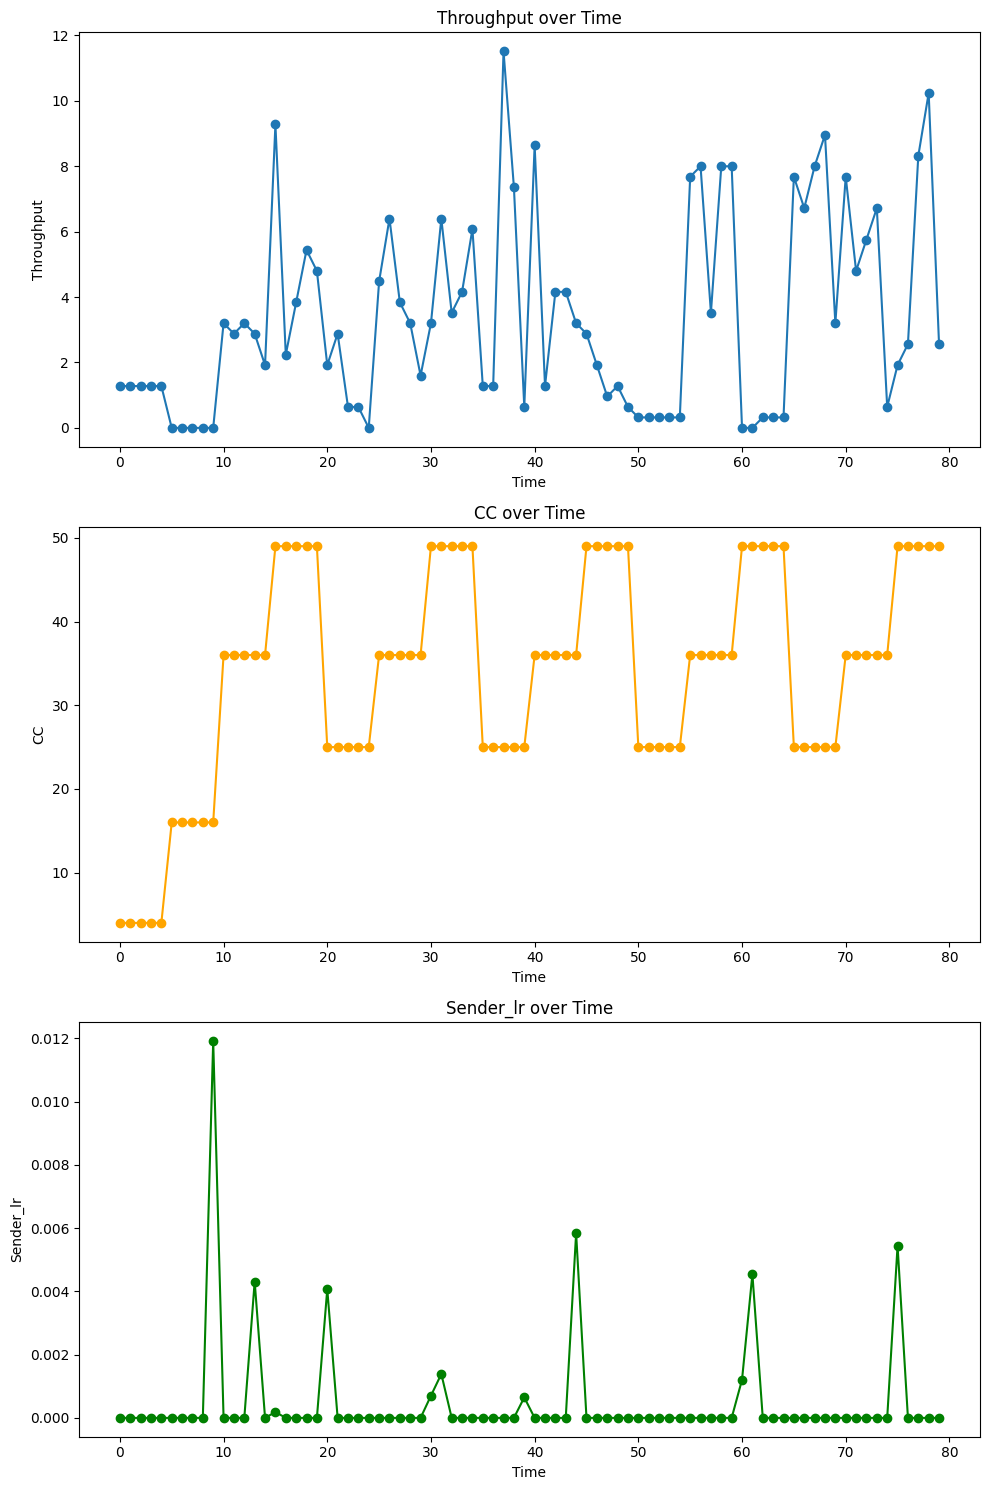

Episode reward: 103.6
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   16
rewards [1.8, -0.8, 3.8, -0.39999999999999947, 1.3999999999999995, -3.8, -1.0, 1.7999999999999998, -1.4, 5.199999999999999, -1.7999999999999998, -2.4, -1.4, 0.0, 2.6, 100],  16
Average Throughput 3.2400000000000007
Total Energy 4804.0
Total packet loss 0.039216
       Throughput  receiver_lr     Score        RTT      Energy  sender_lr
count   80.000000     80.00000  80.00000  80.000000   80.000000  80.000000
mean     3.240000      0.00125   2.92500  33.981250   60.050000   0.000490
std      3.062727      0.01118   2.67087   3.207669   24.277353   0.002067
min      0.000000      0.00000   0.00000  32.600000    0.000000   0.000000
25%      0.960000      0.00000   1.00000  32.700000   47.750000   0.000000
50%      2.400000      0.00000   2.00000  32.800000   59.500000   0.000000
75%      4.560000      0.00000   4.00000  33.325000   78.000000   0.000000
max     13.120000      0.10000  12.00000  52.800000  

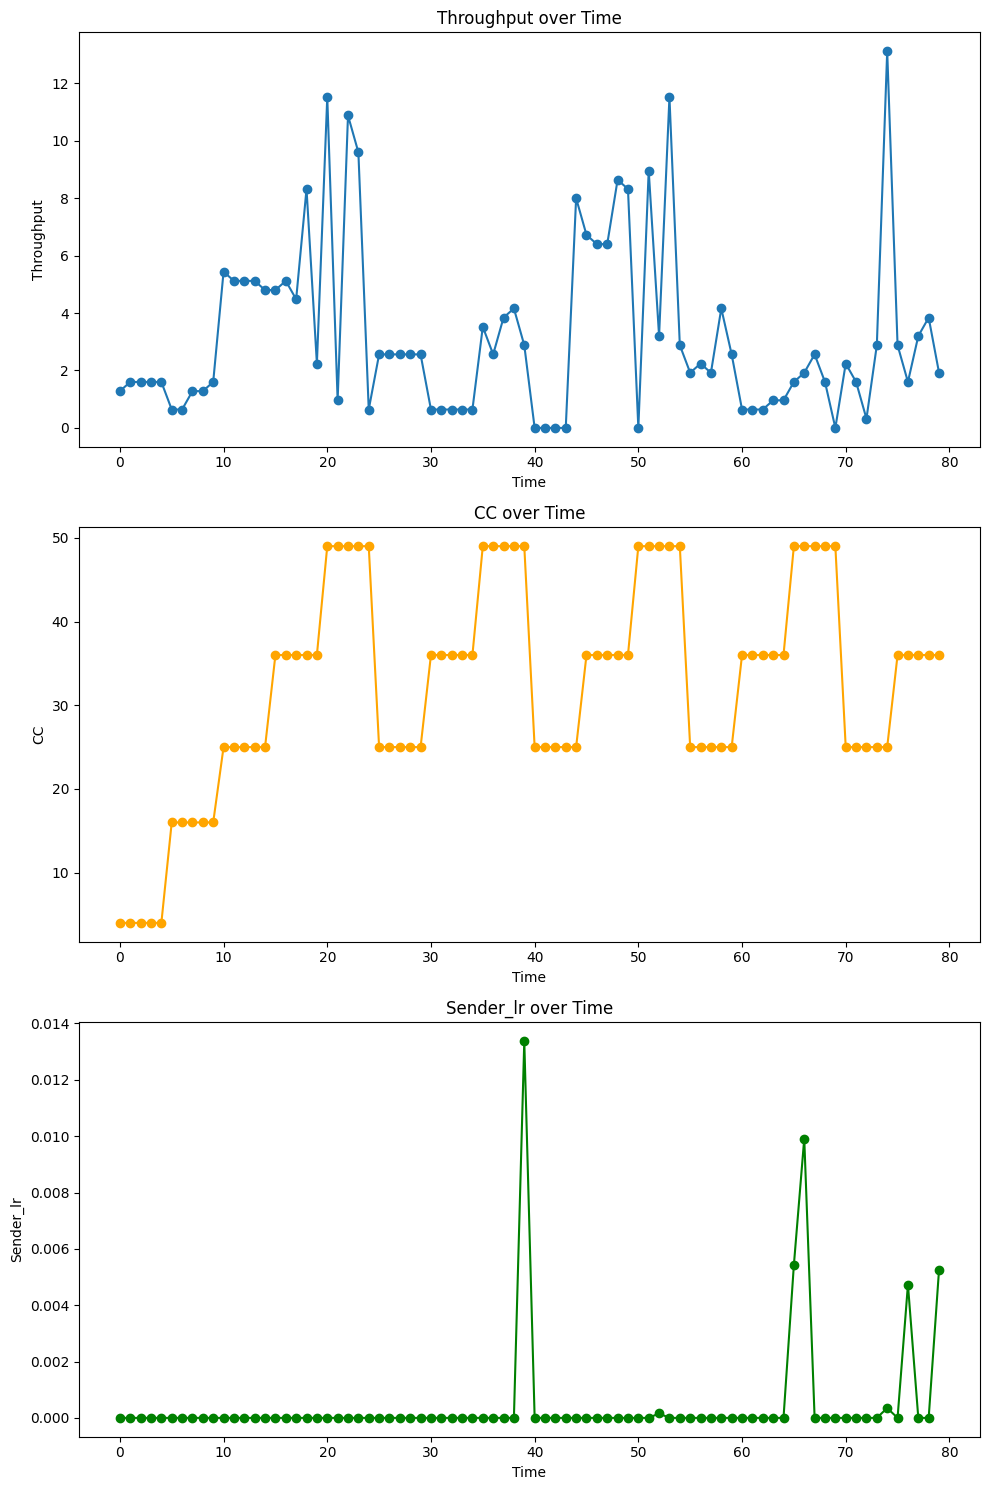

Episode reward: 100.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   22
rewards [0.8, 1.5999999999999999, -1.4, -0.8, 1.6, -0.40000000000000013, -0.3999999999999999, 3.5999999999999996, -2.5999999999999996, 1.2000000000000002, -3.0, 4.2, 1.0, -3.2, -2.2, 3.0, -2.0, -1.0, 5.6, -3.9999999999999996, -1.6, 100],  22
Average Throughput 2.344727272727273
Total Energy 6107.0
Total packet loss 0.25007
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  110.000000        110.0  110.000000  110.000000  110.000000  110.000000
mean     2.344727          0.0    2.054545   33.032727   55.518182    0.002273
std      2.241932          0.0    2.049105    7.203963   24.892699    0.015446
min      0.000000          0.0   -1.000000    0.000000    0.000000    0.000000
25%      0.640000          0.0    1.000000   32.700000   44.000000    0.000000
50%      1.600000          0.0    1.000000   32.800000   55.000000    0.000000
75%      3.520000  

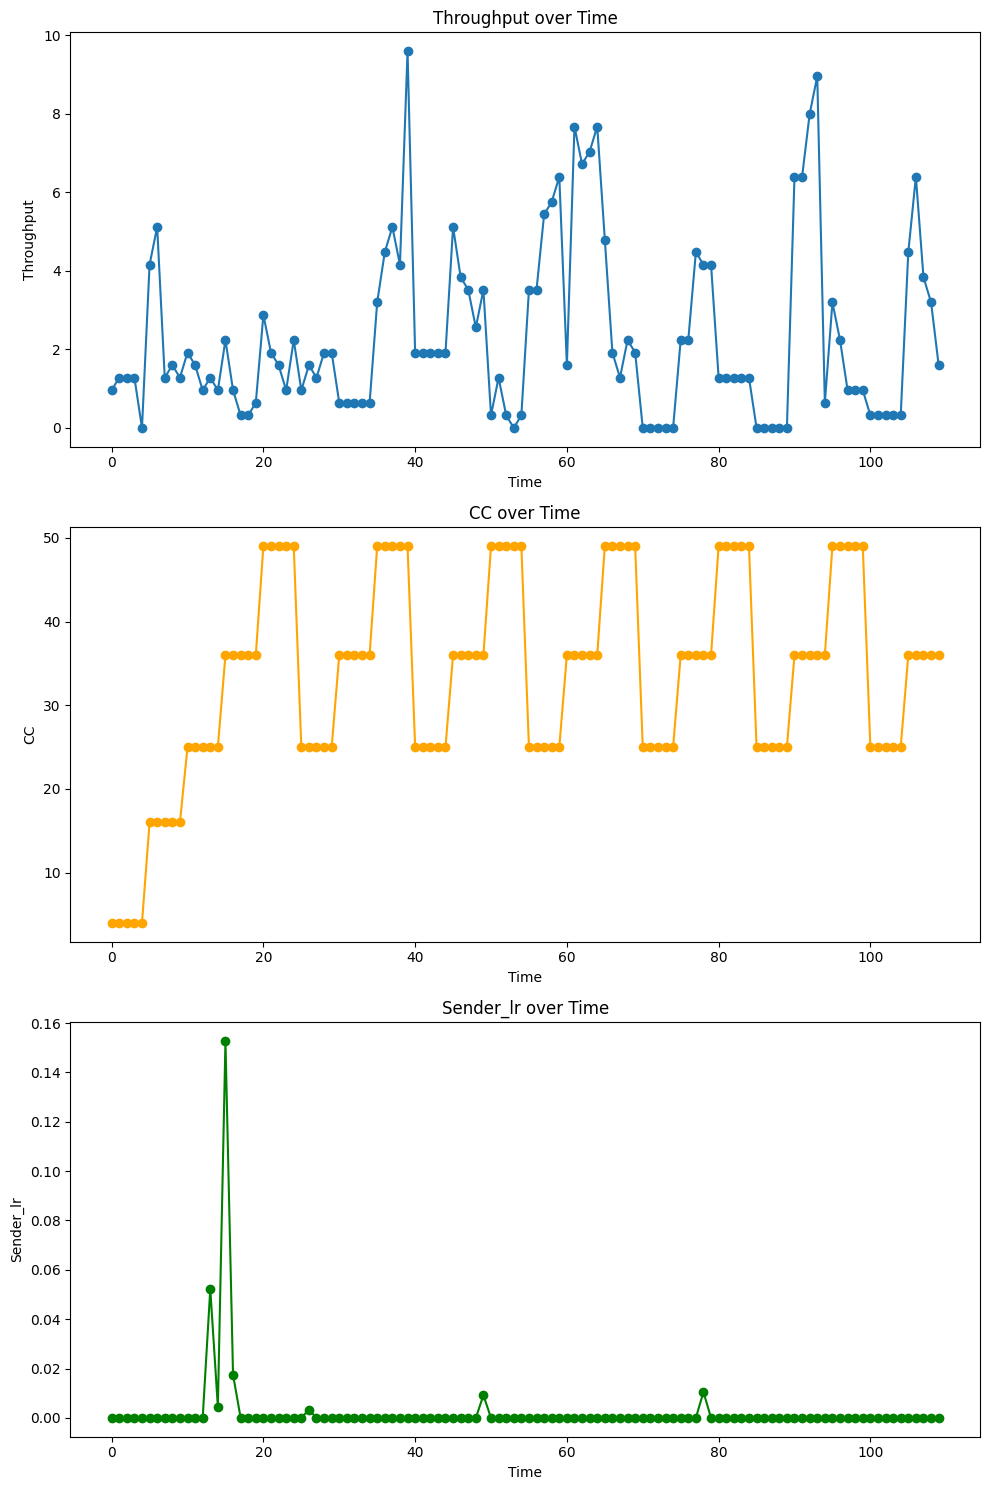

Episode reward: 101.4
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   18
rewards [1.2, -0.3999999999999999, -0.8, 5.4, -4.2, -0.3999999999999999, 3.2, -2.4, -1.2000000000000002, 4.0, 0.7999999999999998, -3.6, 4.800000000000001, -2.4000000000000004, 1.4000000000000004, -3.8000000000000003, -0.20000000000000018, 100],  18
Average Throughput 3.281777777777778
Total Energy 5325.0
Total packet loss 0.09146
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   90.000000    90.000000  90.000000  90.000000   90.000000  90.000000
mean     3.281778     0.001235   2.911111  34.157778   59.166667   0.001016
std      3.493114     0.011712   3.107239   4.710590   30.832731   0.005239
min      0.000000     0.000000   0.000000  32.500000    0.000000   0.000000
25%      0.640000     0.000000   1.000000  32.700000   44.000000   0.000000
50%      1.600000     0.000000   1.500000  33.000000   54.500000   0.000000
75%      6.720000     0.000000   5.750000  33

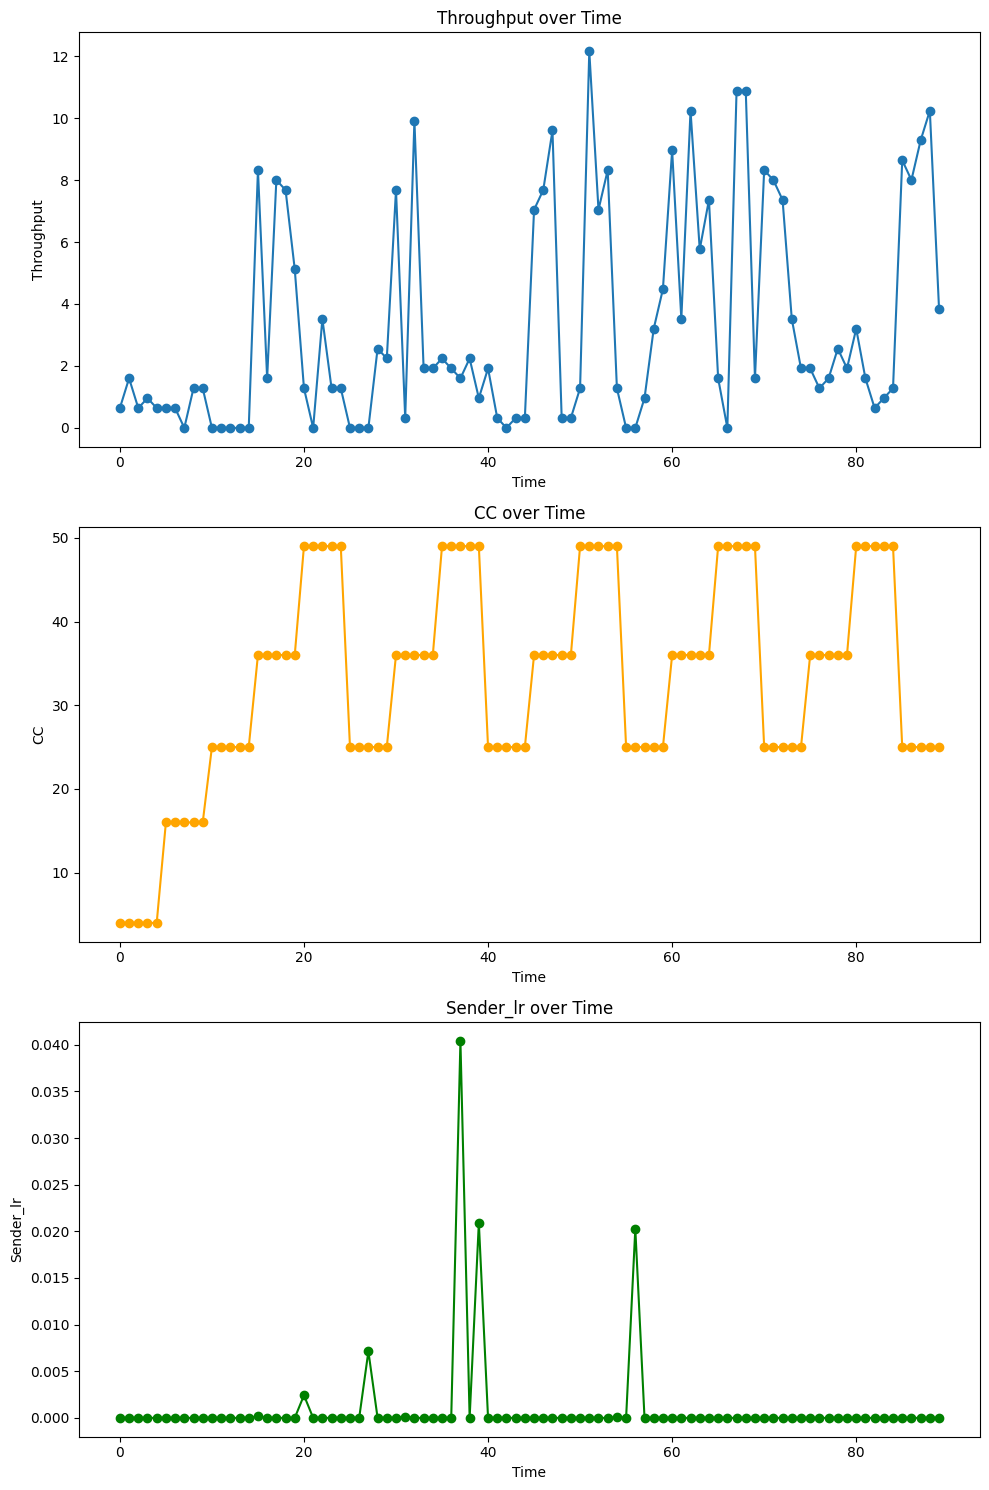

Episode reward: 102.4
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   20
rewards [1.6, -0.6000000000000001, 2.4, -2.4, 0.6000000000000001, 2.0, -0.8000000000000003, -1.7999999999999998, 3.5999999999999996, -3.5999999999999996, 0.6000000000000001, 4.199999999999999, -4.8, 0.0, 1.4, -0.19999999999999973, -1.2000000000000002, 1.6, -0.20000000000000018, 100],  20
Average Throughput 2.6623999999999994
Total Energy 6388.0
Total packet loss 0.09961899999999999
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  100.000000   100.000000  100.000000  100.000000  100.000000  100.000000
mean     2.662400     0.001111    2.340000   34.420000   63.880000    0.000996
std      2.423803     0.011111    2.207517    3.570898   23.839226    0.005276
min      0.000000     0.000000    0.000000   32.600000    0.000000    0.000000
25%      1.280000     0.000000    1.000000   32.700000   44.000000    0.000000
50%      1.600000     0.000000    1.000000  

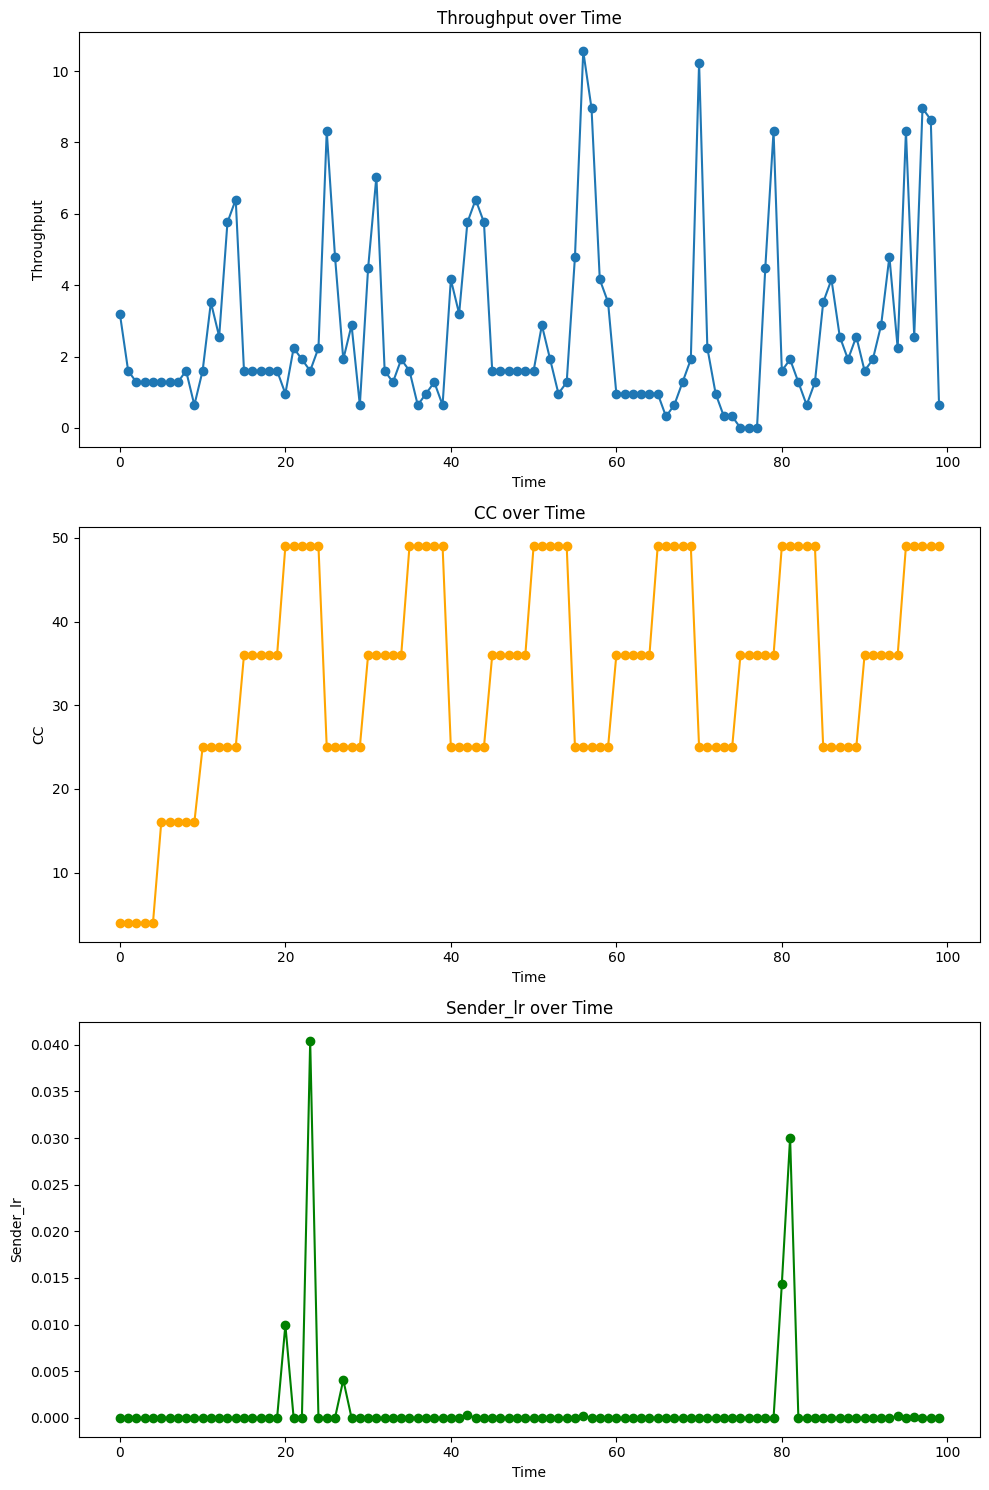

Episode reward: 100.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   17
rewards [0.0, 0.8, 2.4000000000000004, 1.2000000000000002, -3.2, 4.2, 0.5999999999999996, -5.0, 4.4, 1.0, -3.8000000000000003, 1.9999999999999996, -4.6, 0.0, 5.0, -5.0, 100],  17
Average Throughput 3.071999999999999
Total Energy 4933.0
Total packet loss 0.031472
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   85.000000         85.0  85.000000  85.000000   85.000000  85.000000
mean     3.072000          0.0   2.764706  32.652941   58.035294   0.000370
std      3.110834          0.0   2.868744   6.712898   26.921600   0.003259
min      0.000000          0.0   0.000000   0.000000    0.000000   0.000000
25%      0.320000          0.0   0.000000  32.600000   42.000000   0.000000
50%      1.600000          0.0   1.000000  32.800000   61.000000   0.000000
75%      5.760000          0.0   5.000000  33.300000   82.000000   0.000000
max     10.880000          0.0  10.000000

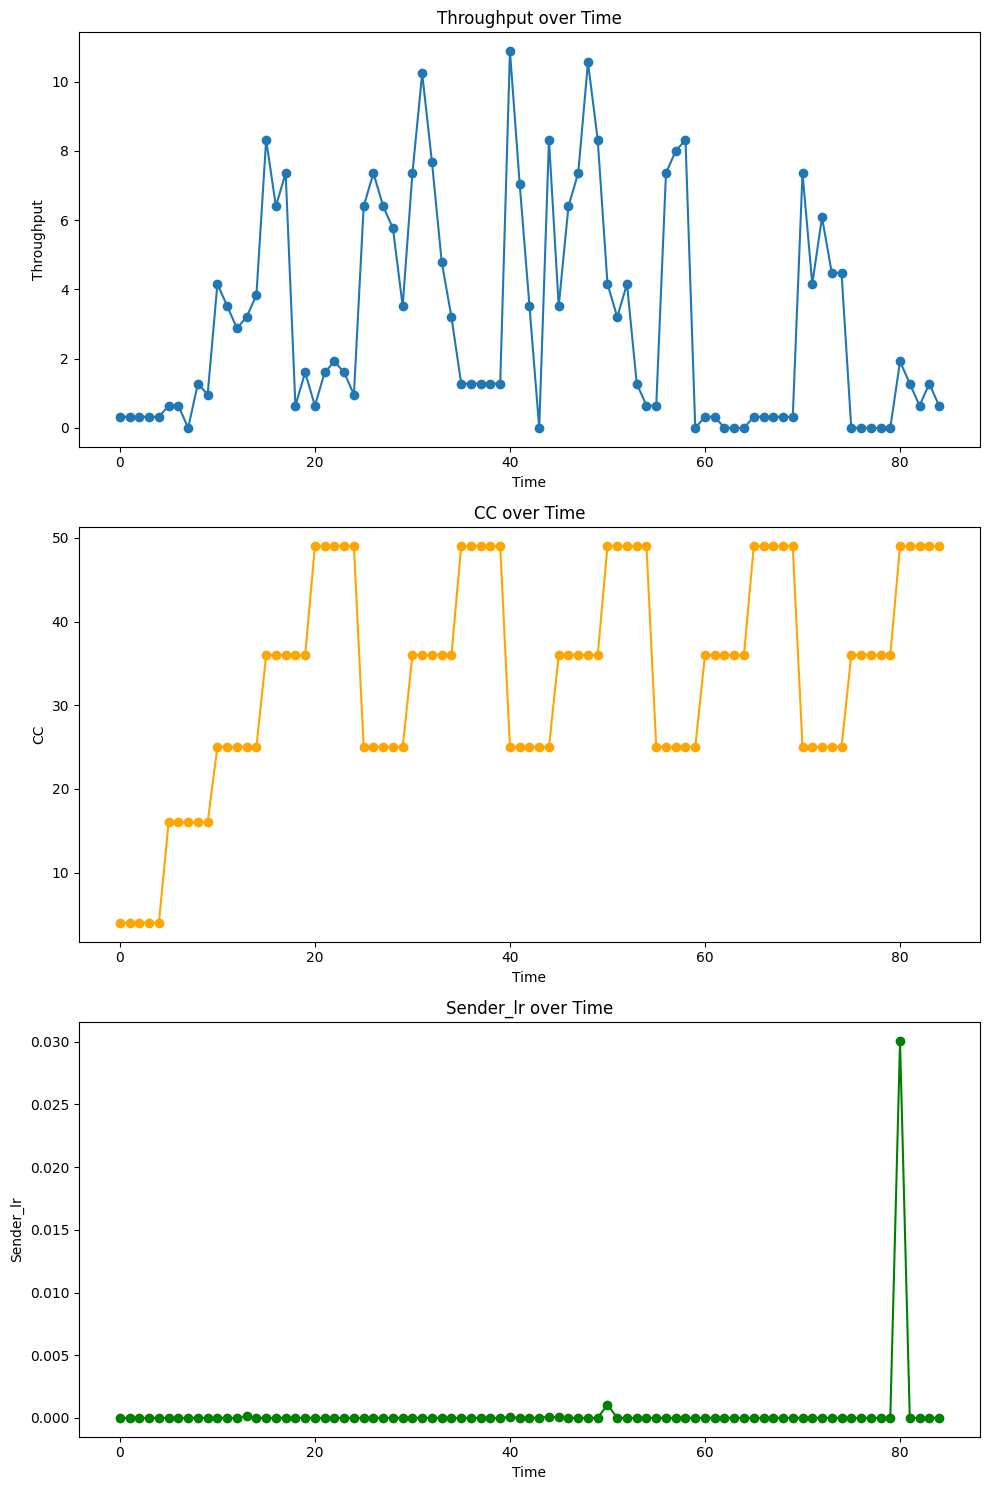

Episode reward: 104.4
actions [1, 0, 1, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   14
rewards [6.8, -5.6, -0.19999999999999996, 4.0, -1.7999999999999998, 2.3999999999999995, -4.6, 2.4, 4.0, -7.4, 1.4, 1.6, 1.4000000000000004, 100],  14
Average Throughput 3.8125714285714287
Total Energy 4780.0
Total packet loss 0.2057
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   70.000000         70.0  70.000000  70.000000  70.000000  70.000000
mean     3.812571          0.0   3.342857  33.738571  68.285714   0.002939
std      3.559512          0.0   3.459437   6.883930  22.172671   0.023545
min      0.000000          0.0  -5.000000   0.000000   0.000000   0.000000
25%      0.960000          0.0   1.000000  32.700000  52.000000   0.000000
50%      1.920000          0.0   2.000000  33.000000  76.000000   0.000000
75%      6.320000          0.0   6.000000  33.800000  87.000000   0.000000
max     13.440000          0.0  12.000000  49.300000  98.000000   0.197006
             

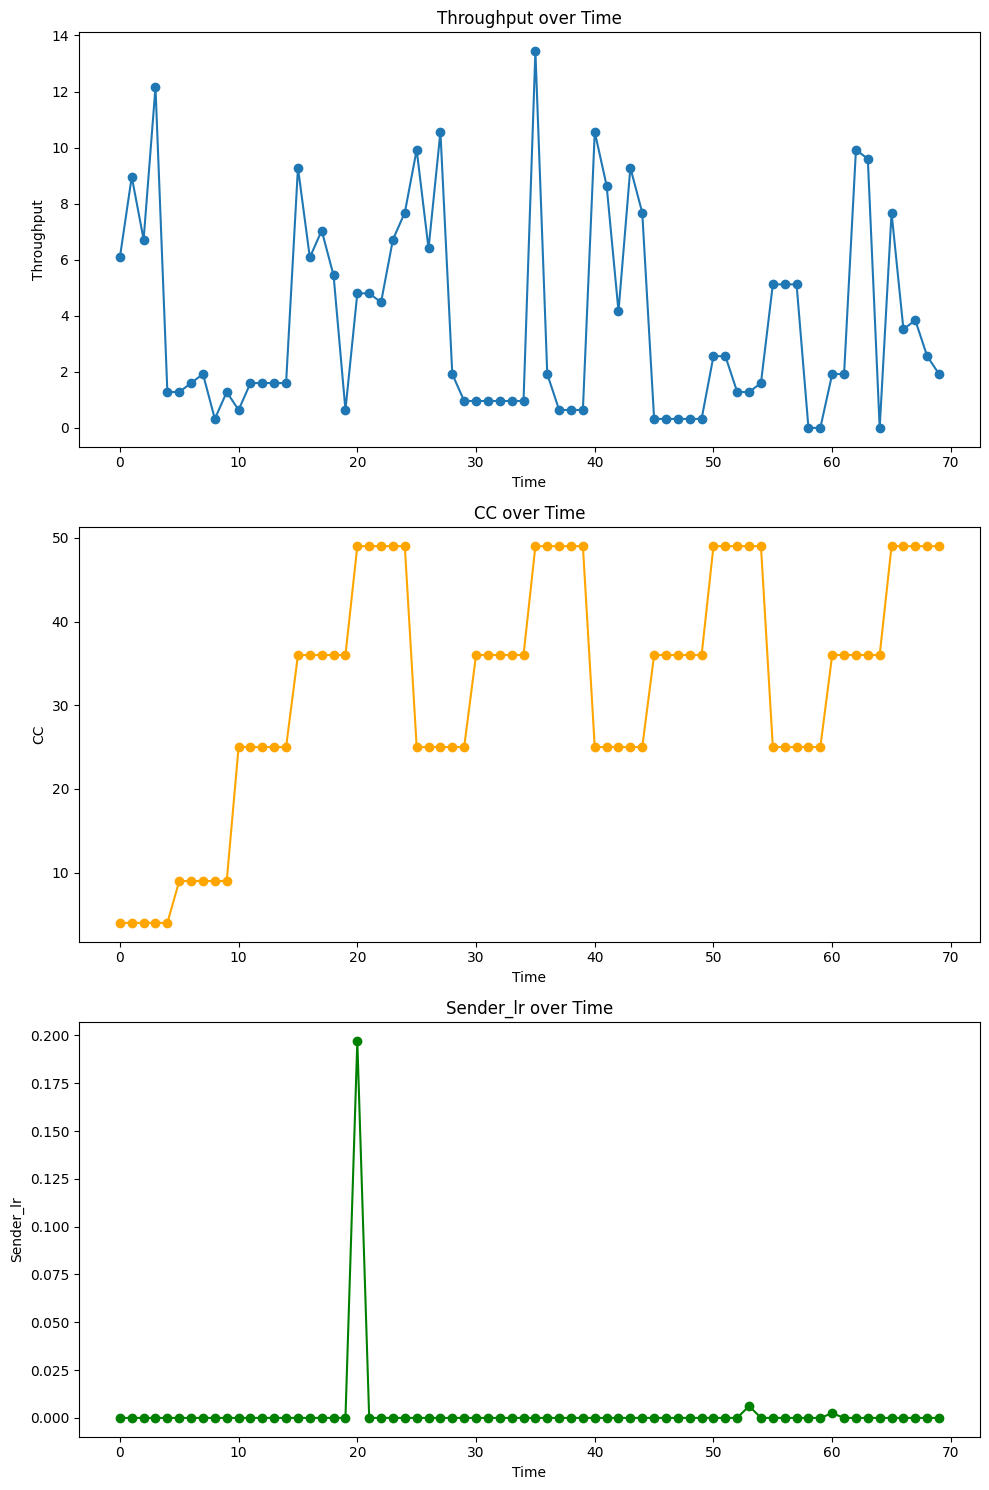

Episode reward: 102.4
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   14
rewards [0.4, 0.19999999999999996, 2.6, -1.4000000000000001, -1.0, 4.8, 0.20000000000000018, -1.3999999999999995, 1.1999999999999993, 1.0, -5.199999999999999, 4.4, -3.4, 100],  14
Average Throughput 4.0045714285714284
Total Energy 4557.0
Total packet loss 0.134036
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   70.000000         70.0  70.000000  70.000000  70.000000  70.000000
mean     4.004571          0.0   3.571429  36.020000  65.100000   0.001915
std      3.452418          0.0   3.114117   9.725085  23.359292   0.007943
min      0.000000          0.0   0.000000   0.000000   0.000000   0.000000
25%      1.280000          0.0   1.000000  32.700000  54.000000   0.000000
50%      3.040000          0.0   3.000000  33.250000  64.500000   0.000000
75%      6.720000          0.0   6.000000  39.900000  86.000000   0.000000
max     13.760000          0.0  12.000000  75.100000  95

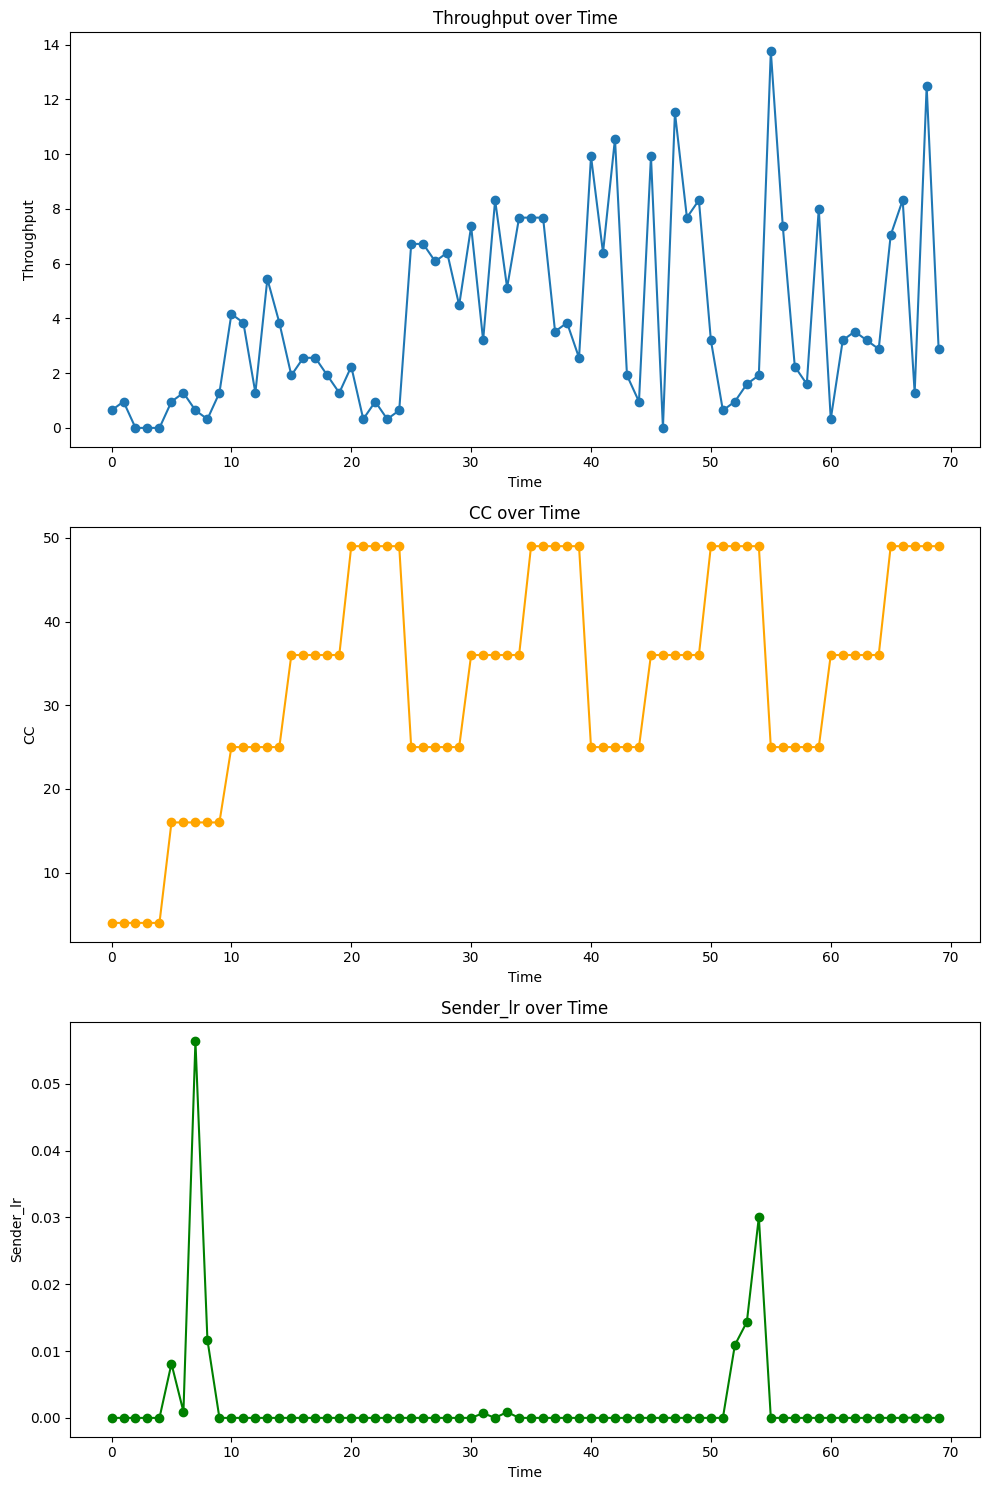

Episode reward: 105.8
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   20
rewards [3.0, 0.7999999999999998, -3.0, 0.8, 4.4, -4.4, -1.2000000000000002, 0.9999999999999999, -1.2, 0.8, 0.0, 2.8, 0.6000000000000005, -4.4, 5.2, -4.2, -1.0, 2.0, 3.8, 100],  20
Average Throughput 2.8991999999999996
Total Energy 5901.0
Total packet loss 0.541671
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count   100.00000        100.0  100.000000  100.000000  100.000000  100.000000
mean      2.89920          0.0    2.460000   33.393000   59.010000    0.005417
std       2.72169          0.0    2.595334    7.045512   24.927165    0.038417
min       0.00000          0.0   -6.000000    0.000000    0.000000    0.000000
25%       0.96000          0.0    1.000000   32.700000   45.500000    0.000000
50%       1.60000          0.0    1.000000   32.800000   59.500000    0.000000
75%       4.48000          0.0    4.000000   33.500000   80.250000    0.000000
max  

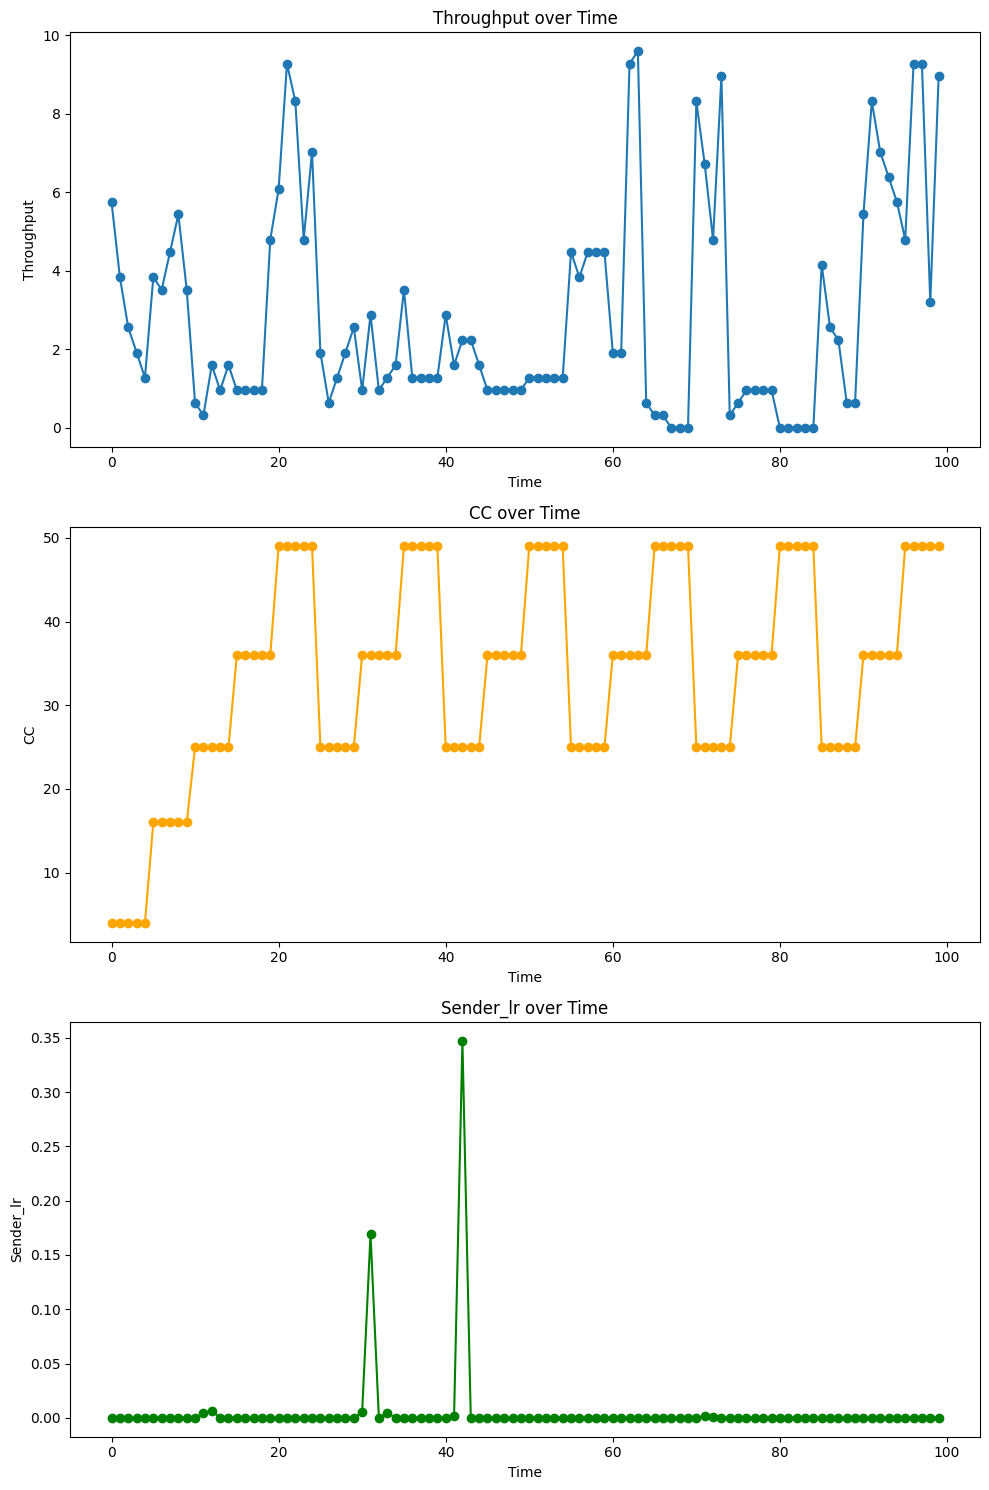

Episode reward: 101.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   22
rewards [0.8, 0.5999999999999999, 1.0, 2.4, -4.2, 4.4, -2.8, -0.20000000000000018, 2.0, -1.4, 3.4, -1.4000000000000004, -3.5999999999999996, 0.0, 1.4, -2.4, 0.4, -0.4, 0.0, 1.4, -0.3999999999999999, 100],  22
Average Throughput 2.3941818181818184
Total Energy 5926.0
Total packet loss 0.08384599999999999
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  110.000000        110.0  110.000000  110.000000  110.000000  110.000000
mean     2.394182          0.0    2.136364   31.492727   53.872727    0.000762
std      2.576728          0.0    2.300687   10.038876   29.303258    0.002998
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.640000          0.0    1.000000   32.700000   43.000000    0.000000
50%      1.280000          0.0    1.000000   32.800000   49.000000    0.000000
75%      3.520000          0.0    3.000

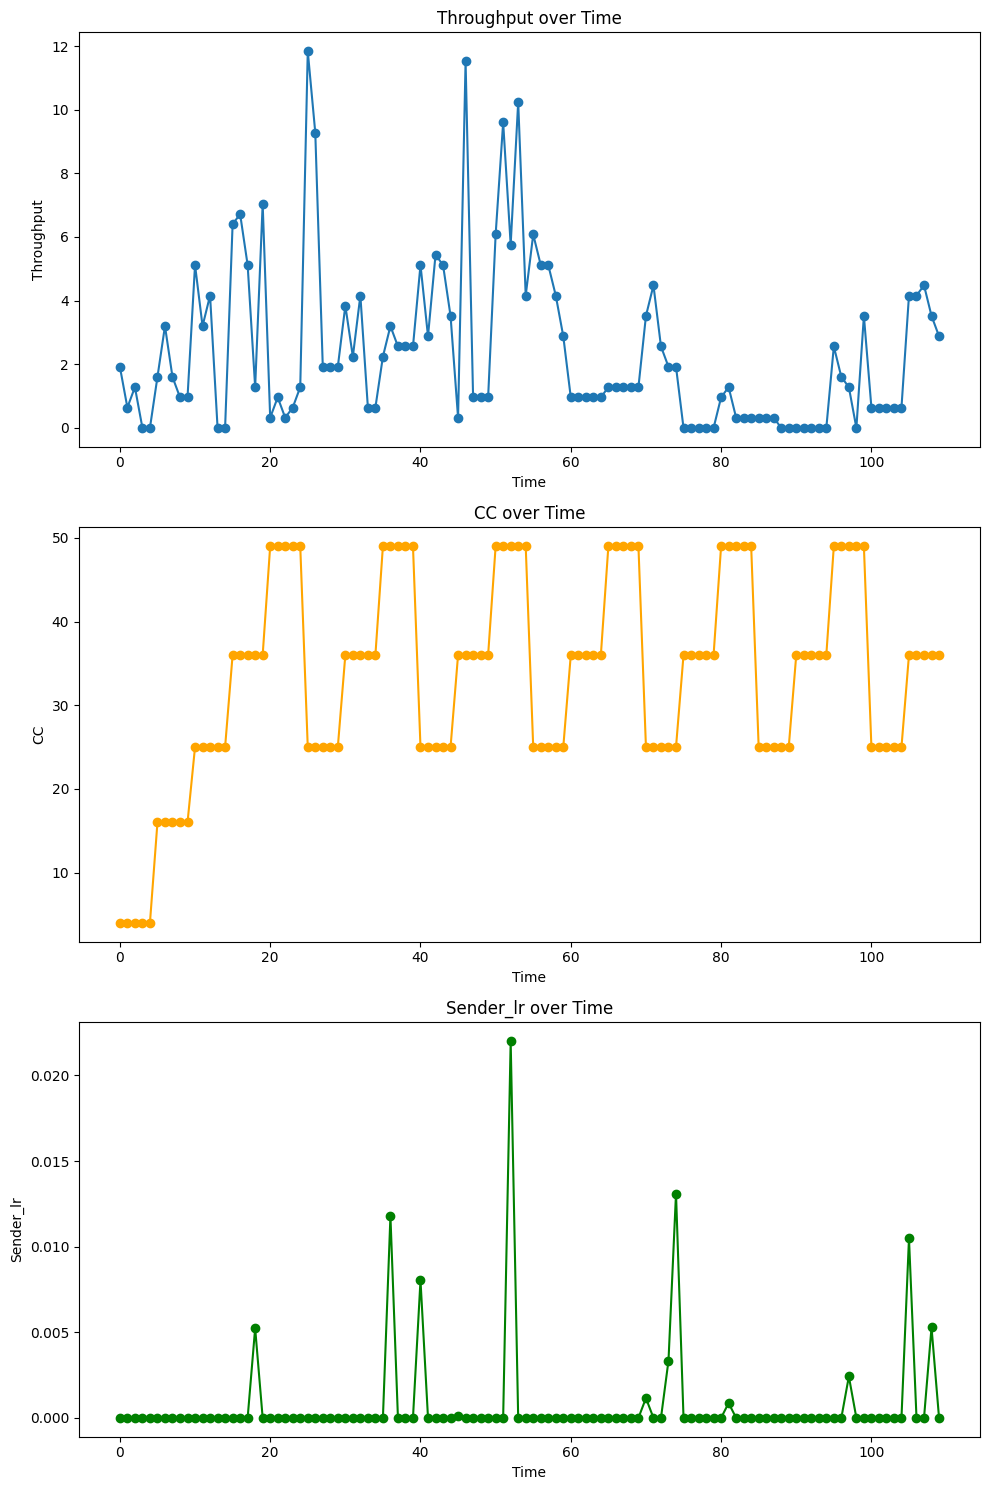

Episode reward: 105.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   13
rewards [1.4, 0.20000000000000018, 2.8000000000000003, 0.0, -1.8000000000000003, -2.2, 1.6, 3.4000000000000004, 1.1999999999999993, -2.1999999999999993, 2.1999999999999993, -1.5999999999999996, 100],  13
Average Throughput 4.204307692307693
Total Energy 4553.0
Total packet loss 0.045225
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   65.000000    65.000000  65.000000  65.000000   65.000000  65.000000
mean     4.204308     0.007692   3.738462  35.506154   70.046154   0.000696
std      3.232771     0.062017   2.980546   6.989699   19.577914   0.003948
min      0.000000     0.000000   0.000000  32.600000    0.000000   0.000000
25%      1.280000     0.000000   1.000000  32.700000   58.000000   0.000000
50%      3.520000     0.000000   3.000000  33.000000   70.000000   0.000000
75%      6.400000     0.000000   6.000000  35.000000   87.000000   0.000000
max     14.080000     0.5000

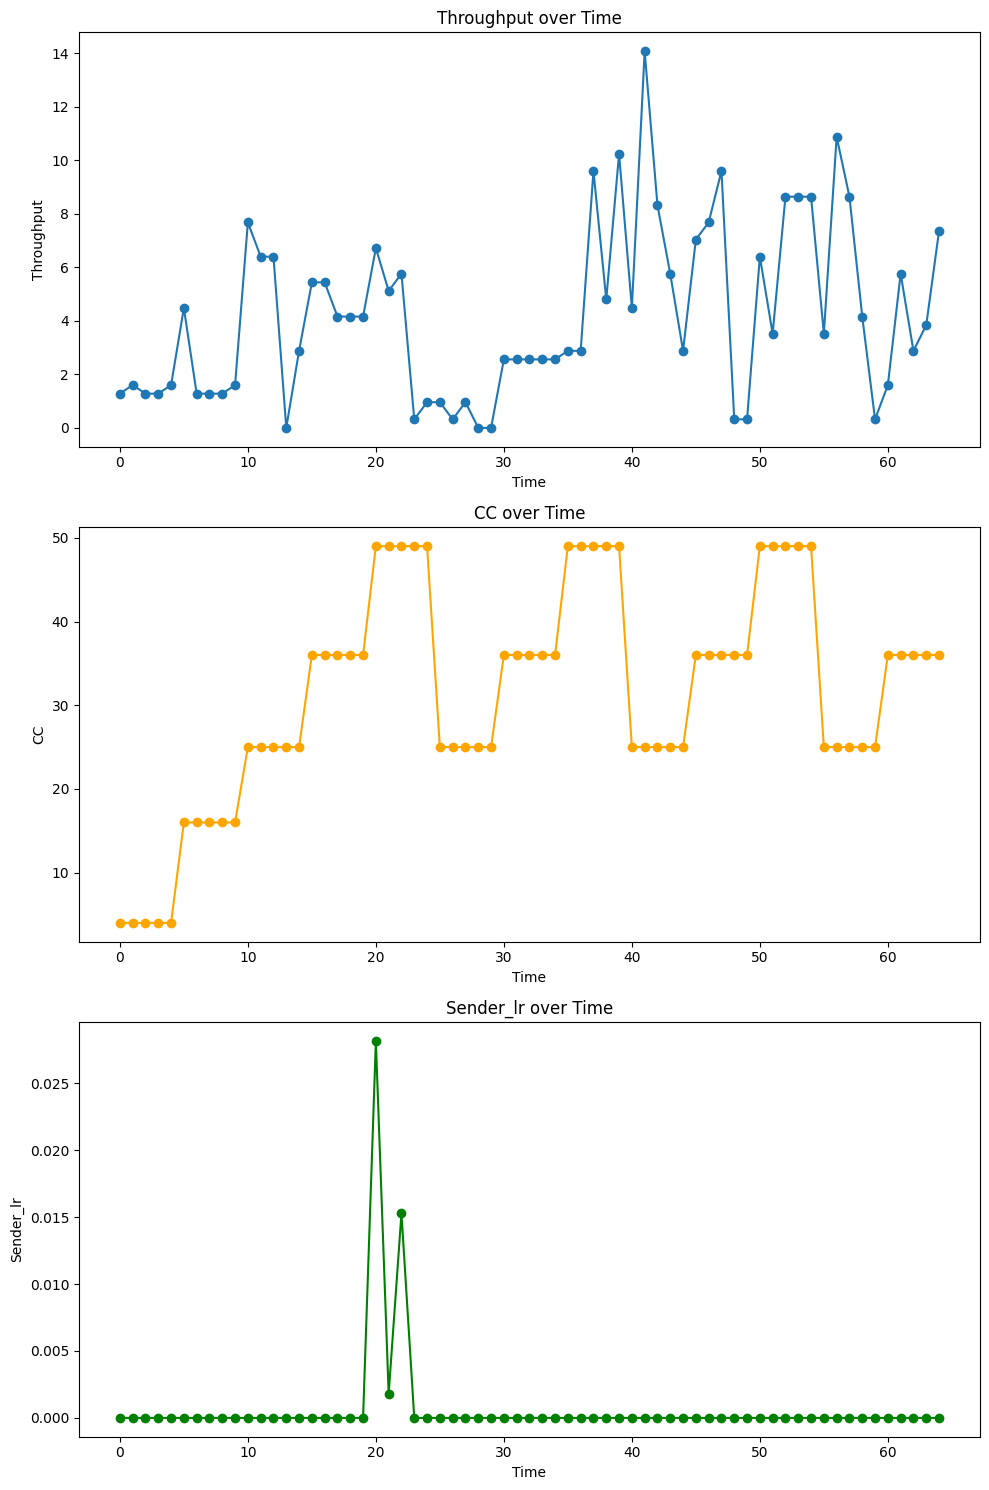

Episode reward: 101.2
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   15
rewards [1.8, -1.0, 0.19999999999999996, 5.2, -0.40000000000000036, 0.6000000000000005, -6.2, 3.4, -2.0, 2.8000000000000003, 0.7999999999999998, -3.8000000000000003, 3.0000000000000004, -3.2, 100],  15
Average Throughput 3.5071999999999997
Total Energy 5195.0
Total packet loss 0.056012
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count    75.00000         75.0  75.000000  75.000000  75.000000  75.000000
mean      3.50720          0.0   3.106667  34.678667  69.266667   0.000747
std       3.47905          0.0   3.147600   4.844704  18.013008   0.003209
min       0.00000          0.0   0.000000  32.500000  42.000000   0.000000
25%       0.80000          0.0   1.000000  32.700000  47.500000   0.000000
50%       1.92000          0.0   2.000000  32.800000  76.000000   0.000000
75%       6.88000          0.0   6.000000  34.300000  86.000000   0.000000
max      13.44000          0.0 

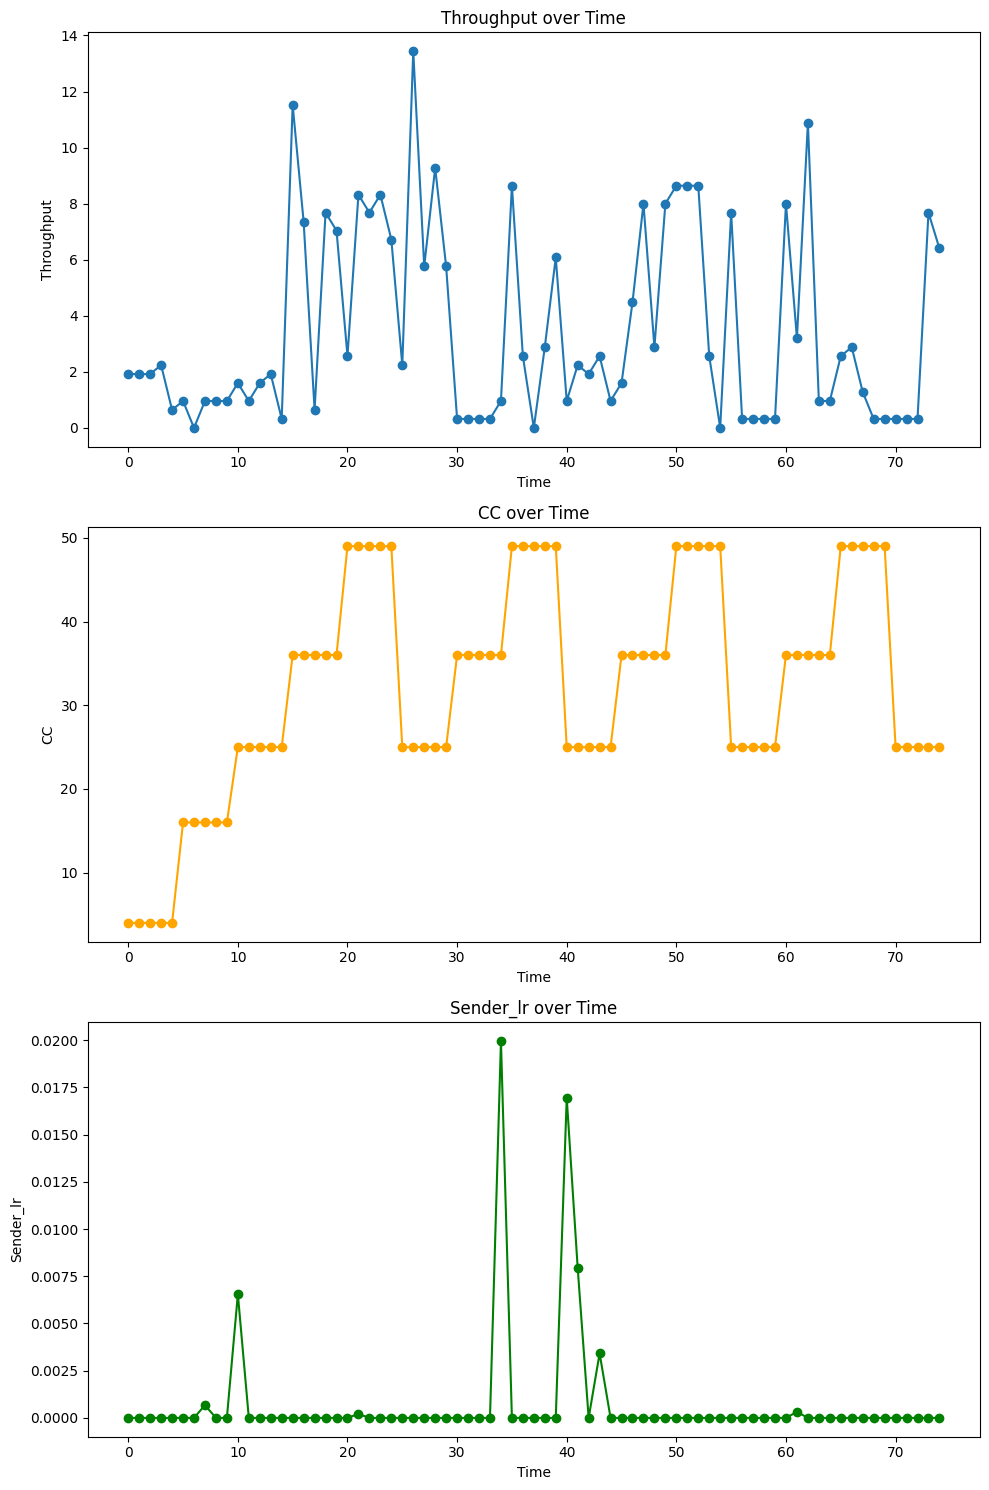

Episode reward: 103.6
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   17
rewards [1.8, -0.6000000000000001, 3.8, -2.6, 0.3999999999999999, -2.8, 1.0, 1.6, -0.3999999999999999, 3.3999999999999995, 0.20000000000000018, -5.8, 1.8, 1.9999999999999998, -1.1999999999999997, 1.0, 100],  17
Average Throughput 3.166117647058823
Total Energy 5005.0
Total packet loss 0.044527
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   85.000000         85.0  85.000000  85.000000   85.000000  85.000000
mean     3.166118          0.0   2.776471  35.122353   58.882353   0.000524
std      2.974133          0.0   2.592923   3.802517   27.355861   0.002158
min      0.000000          0.0   0.000000  32.500000    0.000000   0.000000
25%      0.960000          0.0   1.000000  32.700000   51.000000   0.000000
50%      2.240000          0.0   2.000000  33.400000   59.000000   0.000000
75%      4.480000          0.0   4.000000  35.900000   81.000000   0.000000
max     1

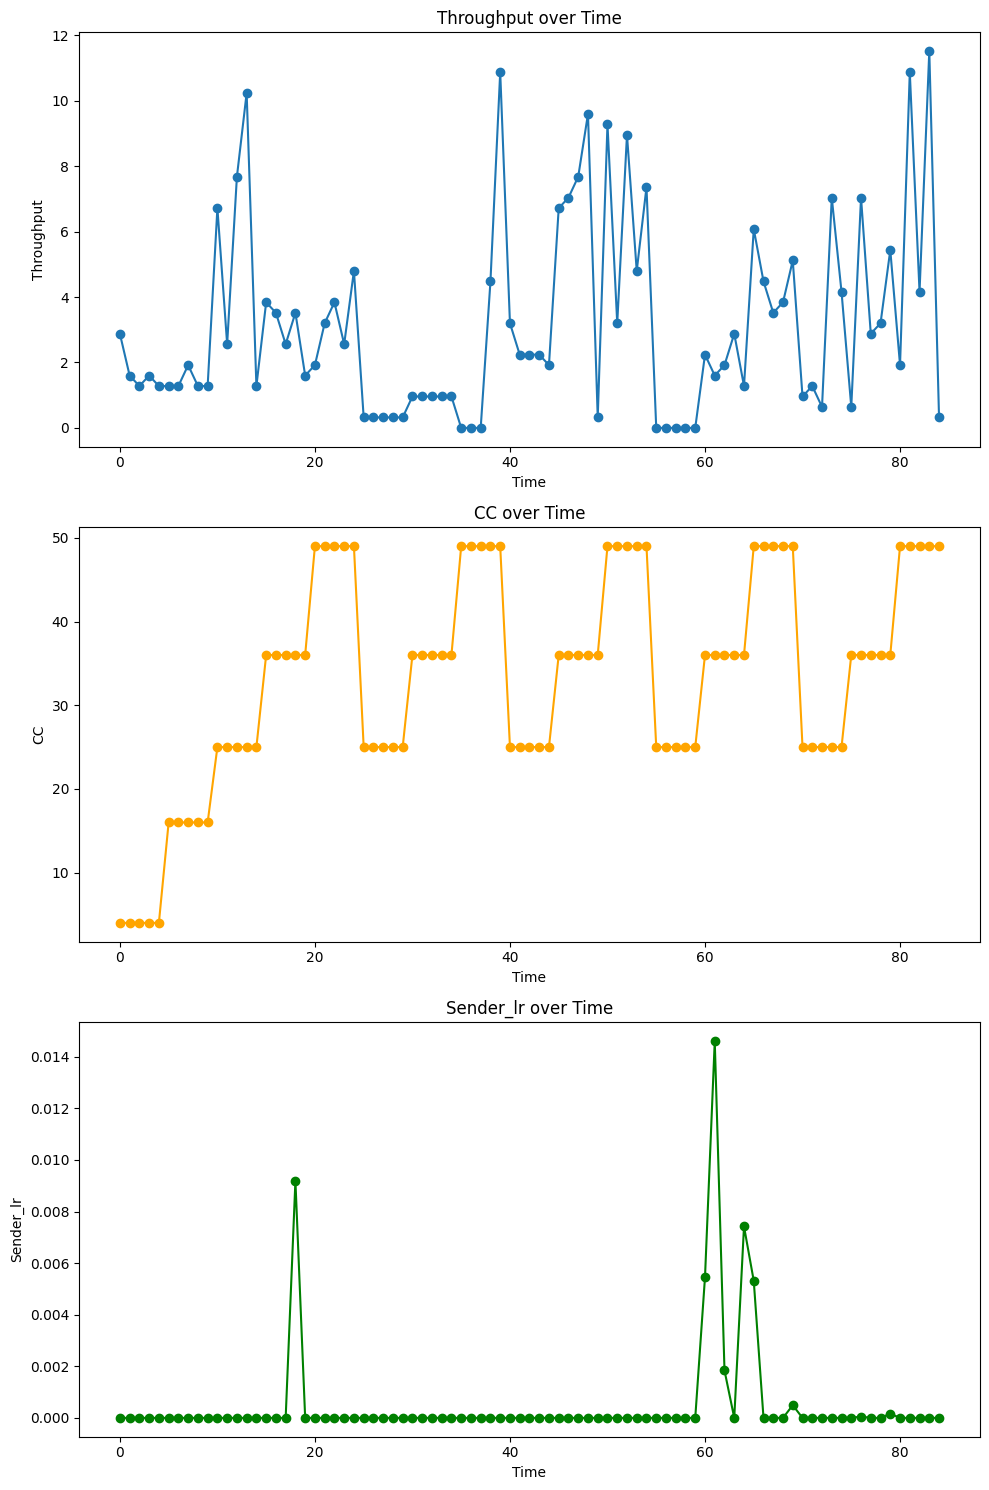

Episode reward: 101.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   16
rewards [1.6, -0.40000000000000013, 2.8, -2.0, 1.2000000000000002, -1.6, 3.4, -1.4, -0.8000000000000003, 0.8000000000000003, -2.6, 6.0, -2.5999999999999996, -3.4000000000000004, 0.0, 100],  16
Average Throughput 3.2120000000000006
Total Energy 5974.0
Total packet loss 0.113536
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   80.000000         80.0  80.000000  80.000000   80.000000  80.000000
mean     3.212000          0.0   2.850000  35.643750   74.675000   0.001419
std      2.719318          0.0   2.439651   5.683751   17.529559   0.009295
min      0.000000          0.0   0.000000  32.600000   43.000000   0.000000
25%      1.280000          0.0   1.000000  32.700000   61.000000   0.000000
50%      2.240000          0.0   2.000000  32.900000   78.000000   0.000000
75%      5.440000          0.0   5.000000  35.225000   88.000000   0.000000
max     10.560000          0.

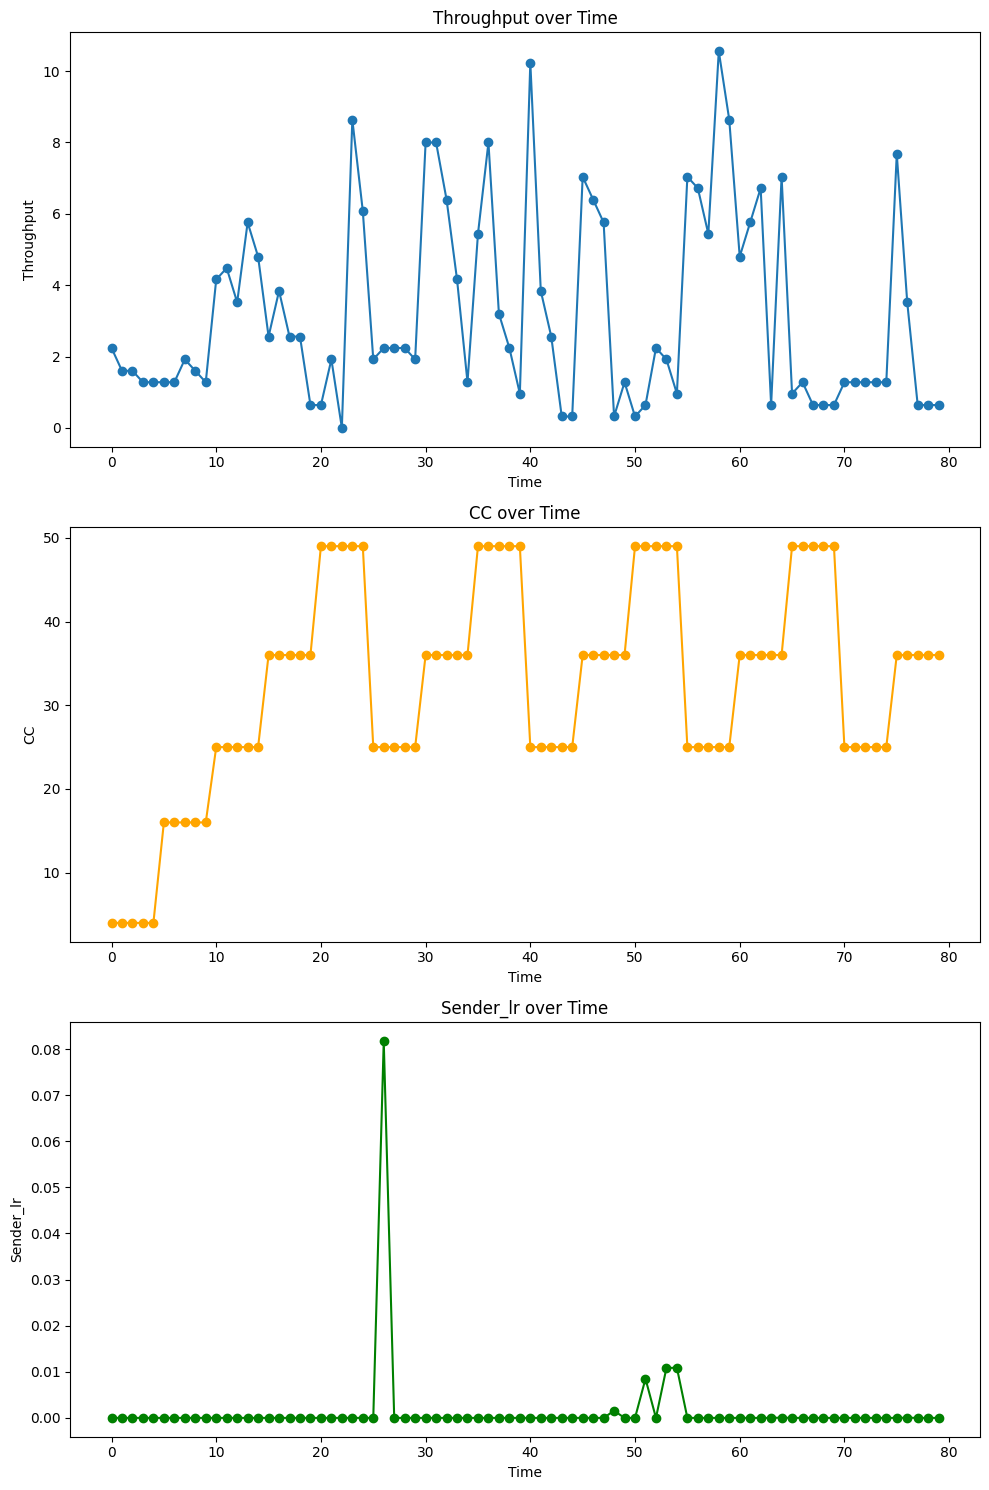

Episode reward: 101.2
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   16
rewards [1.0, 2.8, -3.0, 1.9999999999999998, -2.8, 6.4, -6.4, 1.4, 4.4, -1.7999999999999998, -0.20000000000000018, 1.4000000000000004, 1.5999999999999996, -3.8, -1.8, 100],  16
Average Throughput 3.3480000000000003
Total Energy 5947.0
Total packet loss 0.000292
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   80.000000    80.000000  80.000000  80.000000   80.00000  80.000000
mean     3.348000     0.006250   3.000000  35.006250   74.33750   0.000004
std      3.264144     0.055902   2.946785   4.620711   26.74774   0.000023
min      0.000000     0.000000   0.000000  32.600000    0.00000   0.000000
25%      0.960000     0.000000   1.000000  32.800000   63.75000   0.000000
50%      2.240000     0.000000   2.000000  33.000000   82.50000   0.000000
75%      4.880000     0.000000   4.250000  34.100000   88.50000   0.000000
max     13.440000     0.500000  12.000000  56.400000 

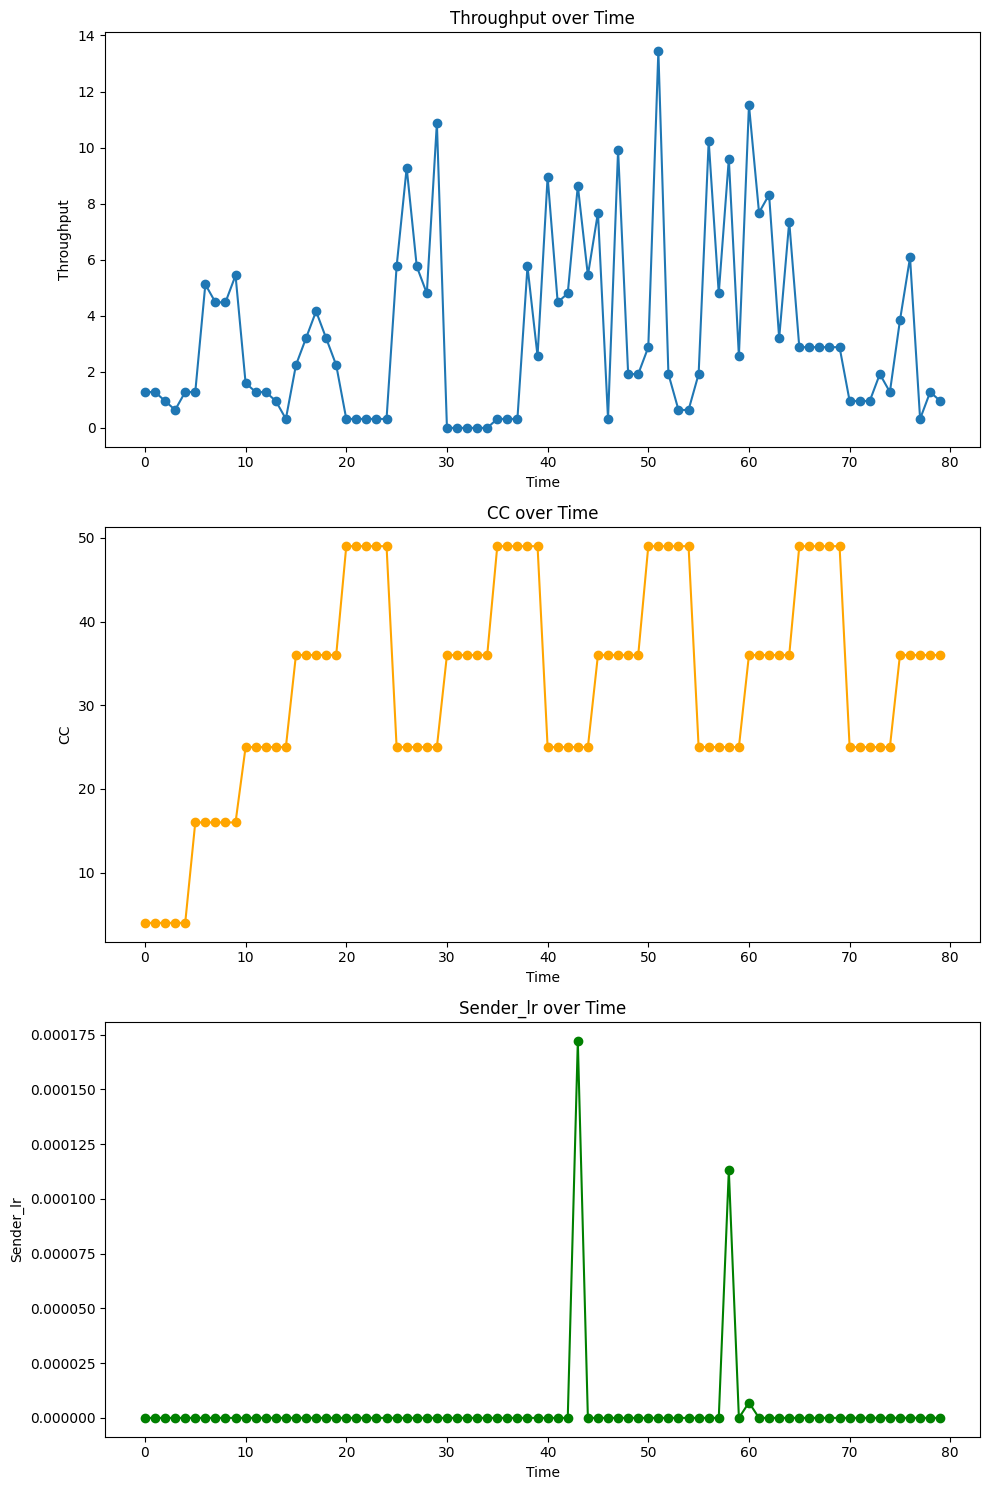

Episode reward: 101.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   22
rewards [0.8, 0.0, 3.4000000000000004, 1.3999999999999995, -4.6, -1.0, 3.0, -0.3999999999999999, -1.6, 0.8, 0.19999999999999996, -0.6000000000000001, -1.2, 1.2, -0.5999999999999999, 0.19999999999999996, 5.4, -0.8000000000000007, -4.8, 3.0, -2.8, 100],  22
Average Throughput 2.5920000000000005
Total Energy 6938.0
Total packet loss 0.515628
       Throughput  receiver_lr      Score         RTT      Energy   sender_lr
count  110.000000        110.0  110.00000  110.000000  110.000000  110.000000
mean     2.592000          0.0    2.30000   33.742727   63.072727    0.004688
std      2.659339          0.0    2.37166    4.423736   20.498695    0.022704
min      0.000000          0.0   -1.00000    0.000000    0.000000    0.000000
25%      0.640000          0.0    1.00000   32.700000   44.000000    0.000000
50%      1.280000          0.0    1.00000   32.800000   57.000000    0.000000
75%      3

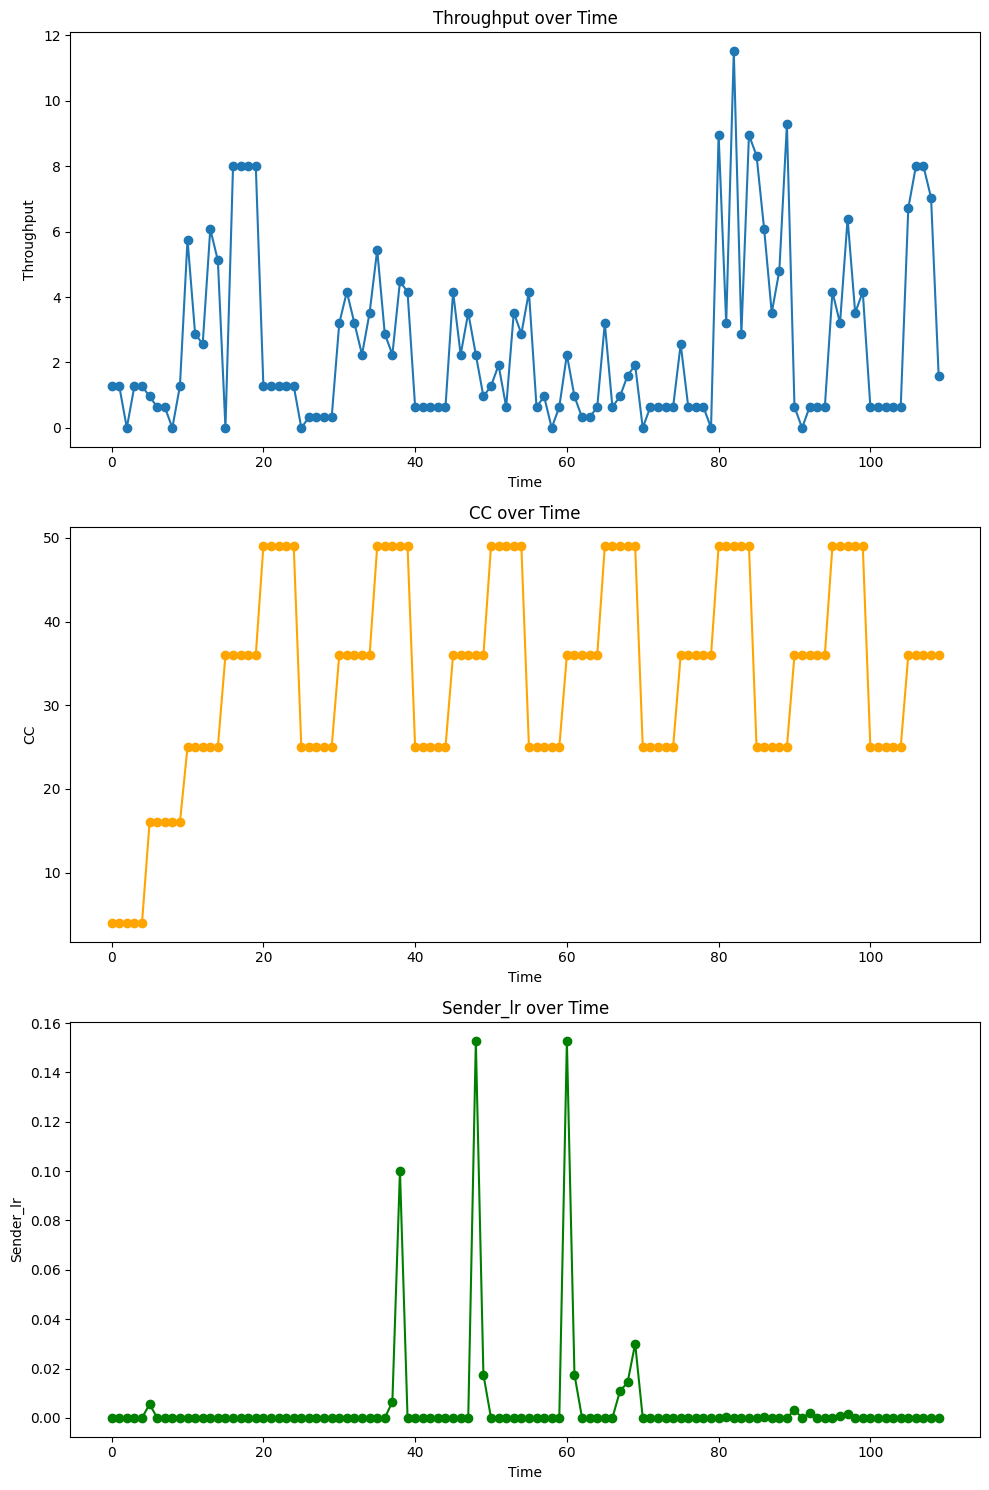

Episode reward: 105.4
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   22
rewards [0.2, 1.0, 0.8, -1.0, -0.19999999999999996, 0.19999999999999996, -0.4, 1.0, -1.6, 1.0, 3.5999999999999996, -1.1999999999999997, 3.6, -6.0, -0.4, 0.4, -1.0, 2.0, -1.0, 5.8, -1.3999999999999995, 100],  22
Average Throughput 2.5192727272727273
Total Energy 5778.0
Total packet loss 0.177114
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  110.000000   110.000000  110.000000  110.000000  110.000000  110.000000
mean     2.519273     0.003030    2.172727   33.660909   52.527273    0.001610
std      2.851680     0.031782    2.478750    5.854021   23.299687    0.006295
min      0.000000     0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.640000     0.000000    1.000000   32.700000   42.000000    0.000000
50%      1.280000     0.000000    1.000000   32.800000   48.500000    0.000000
75%      3.840000     0.000000    3.000000   33.

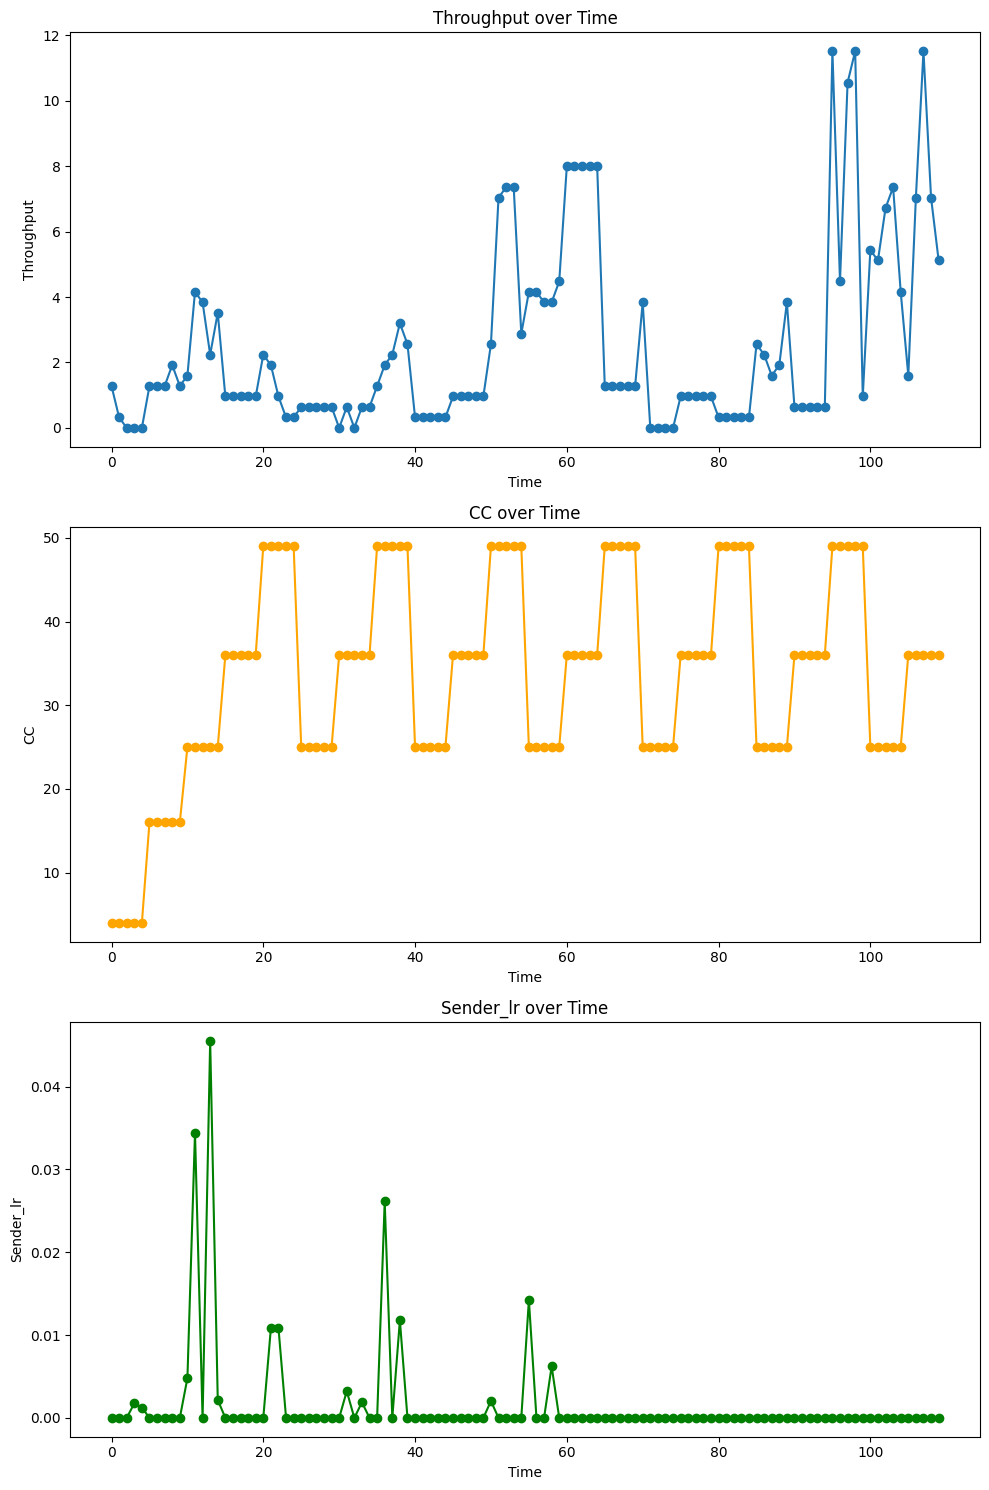

Episode reward: 100.8
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   22
rewards [1.2, -0.19999999999999996, 0.3999999999999999, 0.8000000000000003, -1.0000000000000002, -0.19999999999999996, 2.0, 0.3999999999999999, -2.5999999999999996, -0.8, 1.0, 5.8, -4.8, -2.0, 5.4, -5.4, 3.4, -3.4, 2.8, -0.19999999999999973, -1.8, 100],  22
Average Throughput 2.3912727272727268
Total Energy 6251.0
Total packet loss 0.131113
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  110.000000        110.0  110.000000  110.000000  110.000000  110.000000
mean     2.391273          0.0    2.081818   33.844545   56.827273    0.001192
std      2.497102          0.0    2.197295    6.094991   24.773417    0.004914
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.640000          0.0    1.000000   32.700000   45.250000    0.000000
50%      1.280000          0.0    1.000000   32.800000   53.500000    0.000000
7

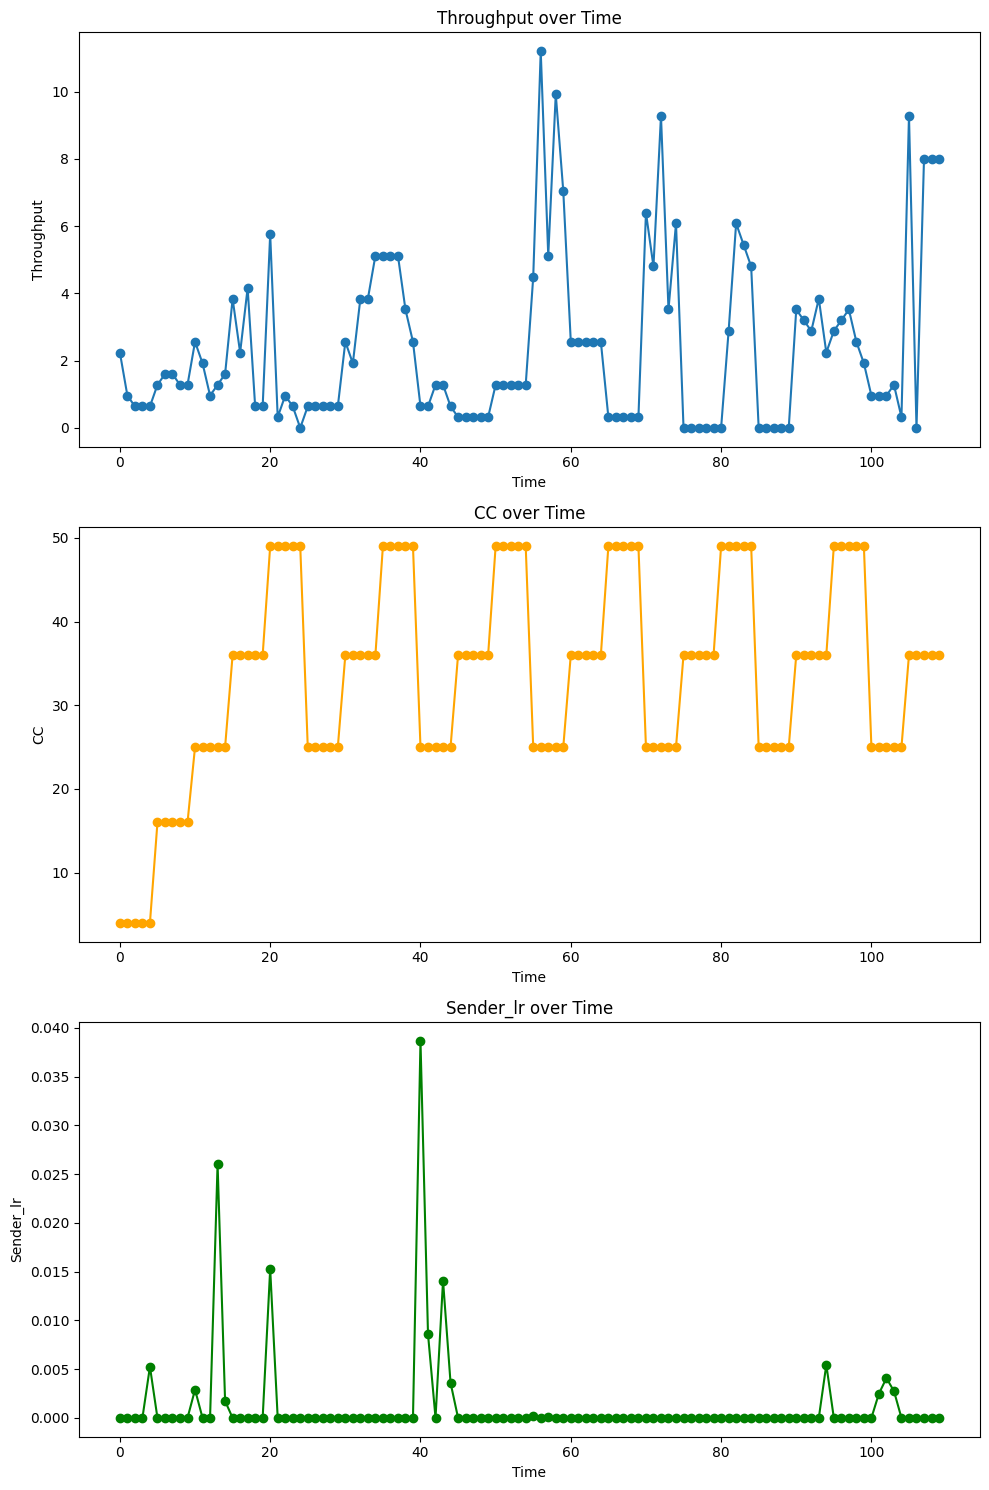

Episode reward: 105.4
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   14
rewards [1.2, -0.19999999999999996, 2.8, -3.0, -0.8, 0.8, -0.20000000000000007, 1.2000000000000002, 4.0, 1.0, -0.39999999999999947, -0.40000000000000036, -0.5999999999999996, 100],  14
Average Throughput 3.954285714285715
Total Energy 4176.0
Total packet loss 0.37046500000000004
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   70.000000         70.0  70.000000  70.000000  70.000000  70.000000
mean     3.954286          0.0   3.314286  34.027143  59.657143   0.005292
std      3.360623          0.0   3.268394   8.294960  26.075635   0.038029
min      0.000000          0.0  -8.000000   0.000000   0.000000   0.000000
25%      1.280000          0.0   1.000000  32.800000  47.000000   0.000000
50%      2.880000          0.0   2.500000  33.300000  60.000000   0.000000
75%      7.680000          0.0   7.000000  36.175000  85.000000   0.000000
max     10.880000          0.0  10.000000

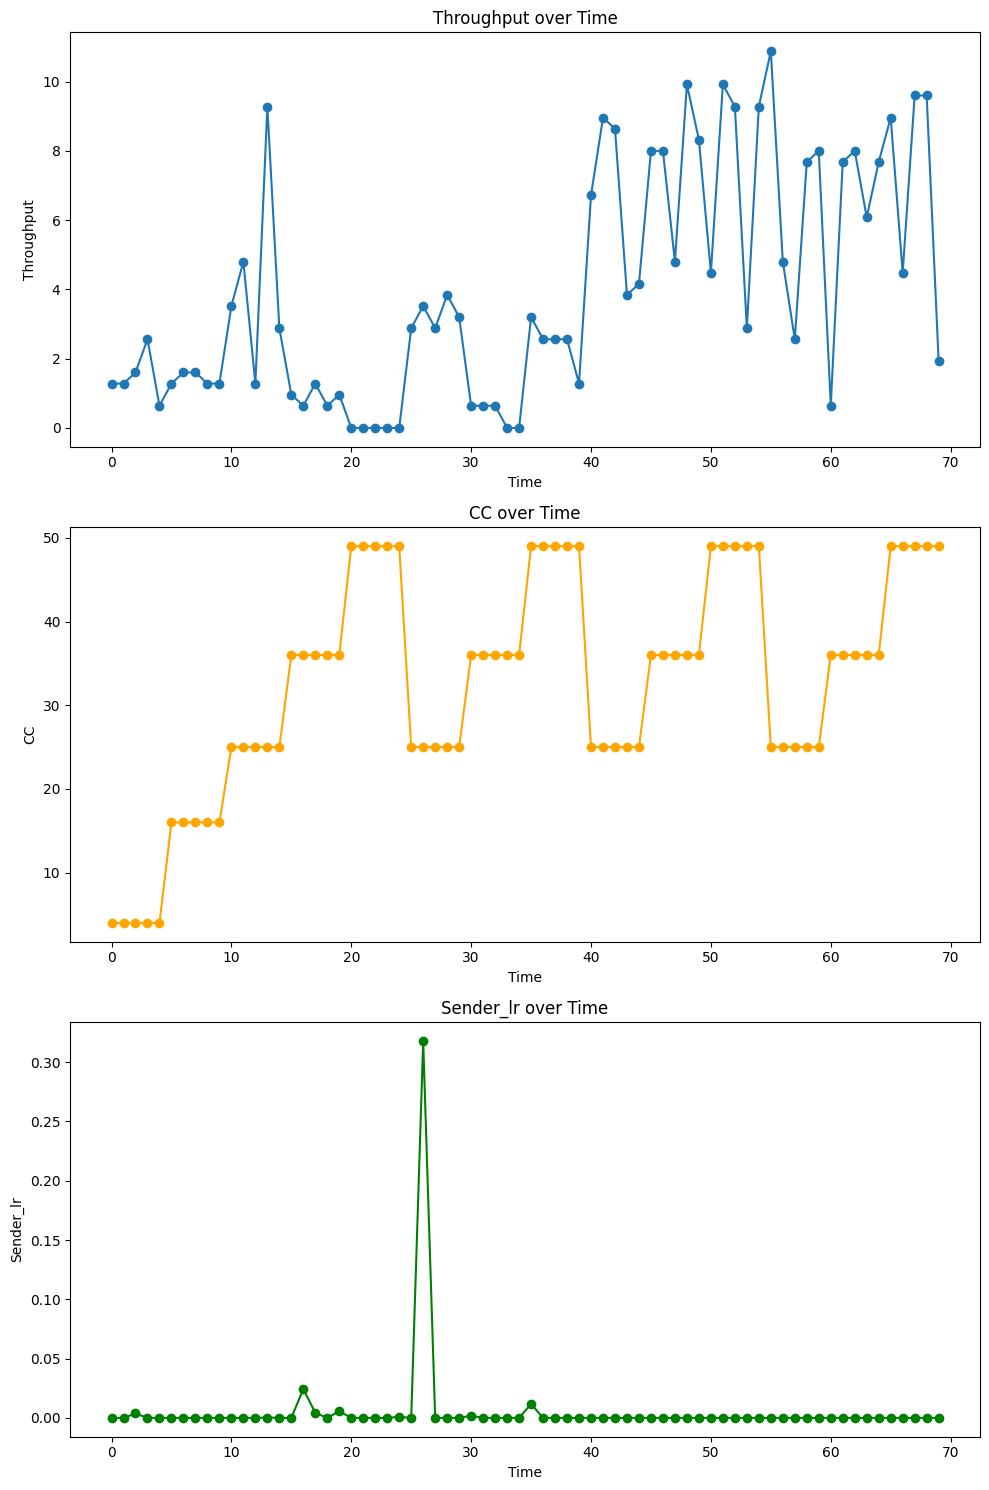

Episode reward: 103.2
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   20
rewards [4.2, -2.8000000000000003, 0.40000000000000013, -0.8, 0.8, 0.40000000000000013, 1.1999999999999997, 0.6000000000000001, 0.40000000000000036, -2.6000000000000005, -1.8, 2.8, -1.9999999999999998, 0.19999999999999996, 3.4000000000000004, -3.4000000000000004, -1.0, 1.0, 2.2, 100],  20
Average Throughput 2.7295999999999996
Total Energy 6395.0
Total packet loss 0.08682600000000001
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  100.000000        100.0  100.000000  100.000000  100.000000  100.000000
mean     2.729600          0.0    2.370000   33.063000   63.950000    0.000868
std      2.736333          0.0    2.545168    6.913106   22.325134    0.003647
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.640000          0.0    1.000000   32.700000   44.000000    0.000000
50%      1.600000          0.0    1.000000 

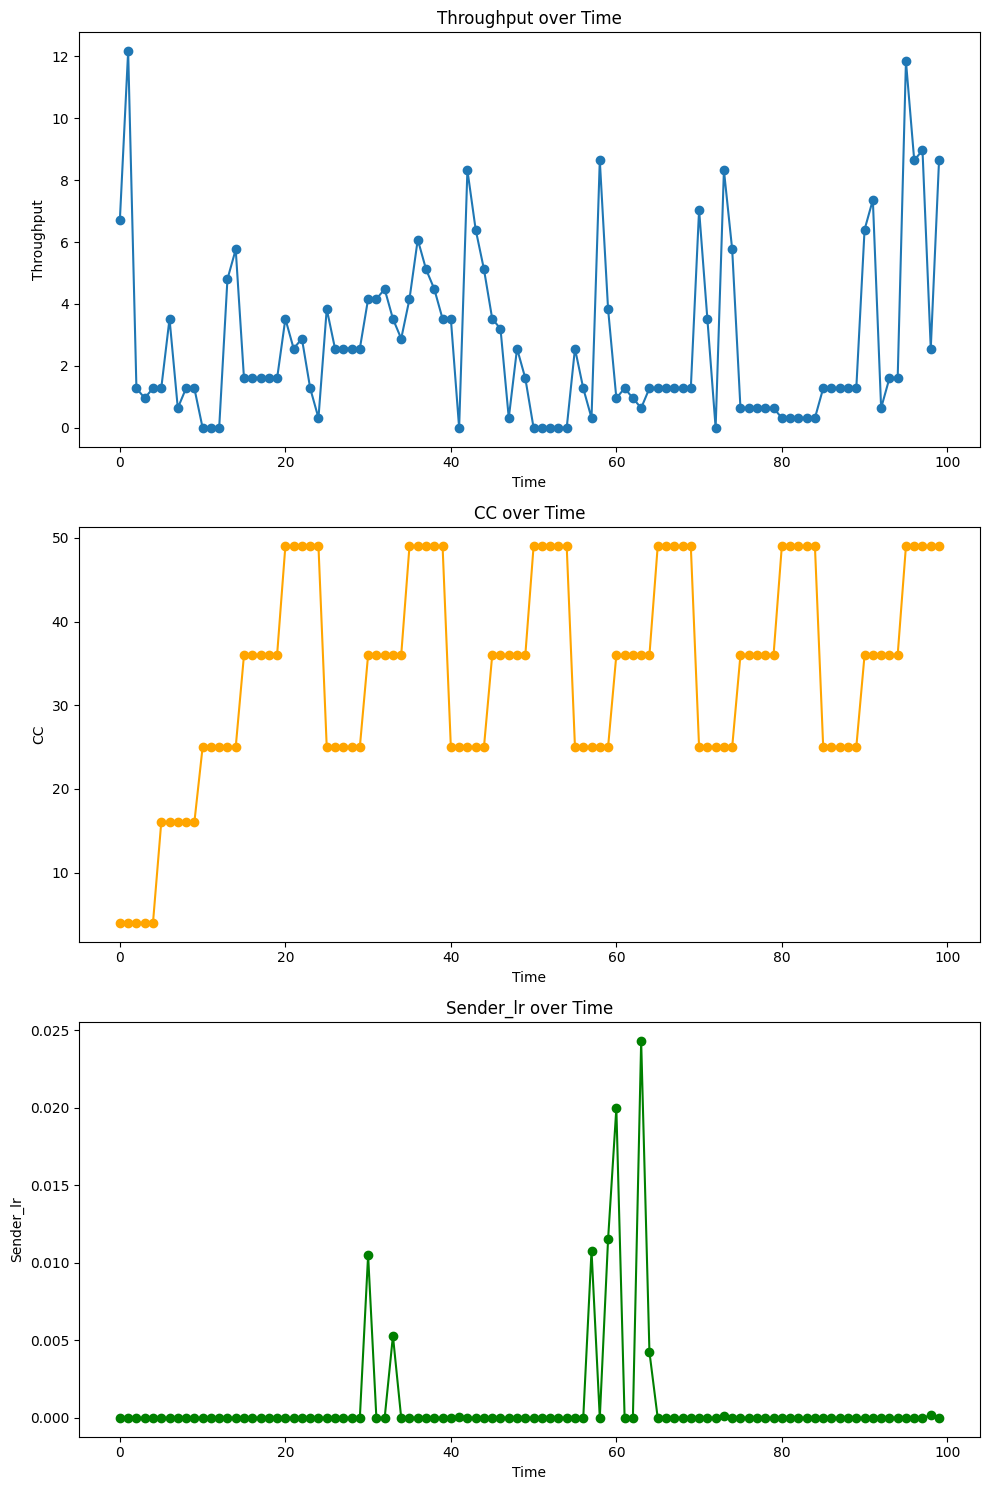

Episode reward: 101.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   17
rewards [5.0, -4.0, 3.2, 2.0, -1.2000000000000002, -3.8, 6.2, -7.4, 0.0, 2.8, 1.2000000000000002, -4.0, 4.8, -3.8, -1.0, 1.0, 100],  17
Average Throughput 3.312941176470589
Total Energy 5331.0
Total packet loss 0.01998
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   85.000000         85.0  85.000000  85.000000  85.000000  85.000000
mean     3.312941          0.0   2.905882  34.070588  62.717647   0.000235
std      3.346260          0.0   3.069138   7.971823  22.868471   0.001573
min      0.000000          0.0   0.000000   0.000000   0.000000   0.000000
25%      0.320000          0.0   0.000000  32.800000  43.000000   0.000000
50%      1.600000          0.0   2.000000  33.000000  68.000000   0.000000
75%      5.440000          0.0   5.000000  35.800000  79.000000   0.000000
max     11.520000          0.0  11.000000  56.500000  98.000000   0.014081
                  

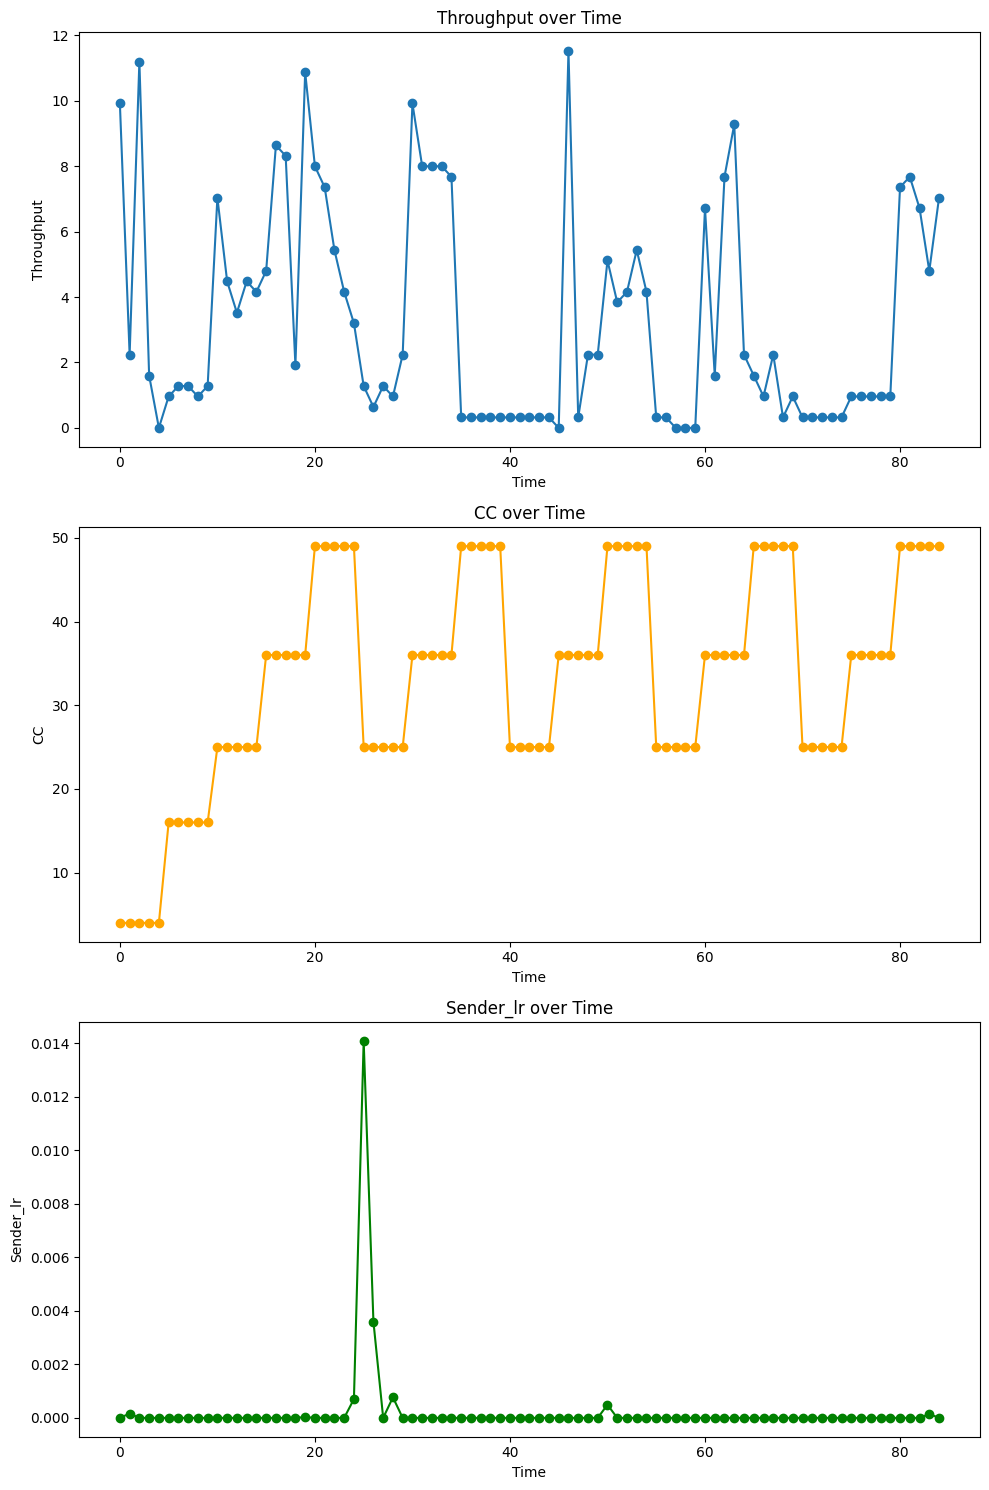

Episode reward: 106.4
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   22
rewards [0.2, 0.6000000000000001, 0.19999999999999996, 1.6, -1.0, 5.0, -2.9999999999999996, -2.2, -0.3999999999999999, 0.8, -1.4, -0.4, 0.0, 1.0, -0.6, 2.4, 1.2000000000000002, -2.2, 0.0, 1.4000000000000001, 3.2, 100],  22
Average Throughput 2.4872727272727273
Total Energy 6697.0
Total packet loss 0.392158
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  110.000000        110.0  110.000000  110.000000  110.000000  110.000000
mean     2.487273          0.0    2.127273   33.640909   60.881818    0.003565
std      2.741685          0.0    2.559777    5.775737   29.115314    0.023690
min      0.000000          0.0   -5.000000    0.000000    0.000000    0.000000
25%      0.640000          0.0    1.000000   32.700000   44.000000    0.000000
50%      1.280000          0.0    1.000000   32.800000   69.000000    0.000000
75%      3.760000          0.0    3.

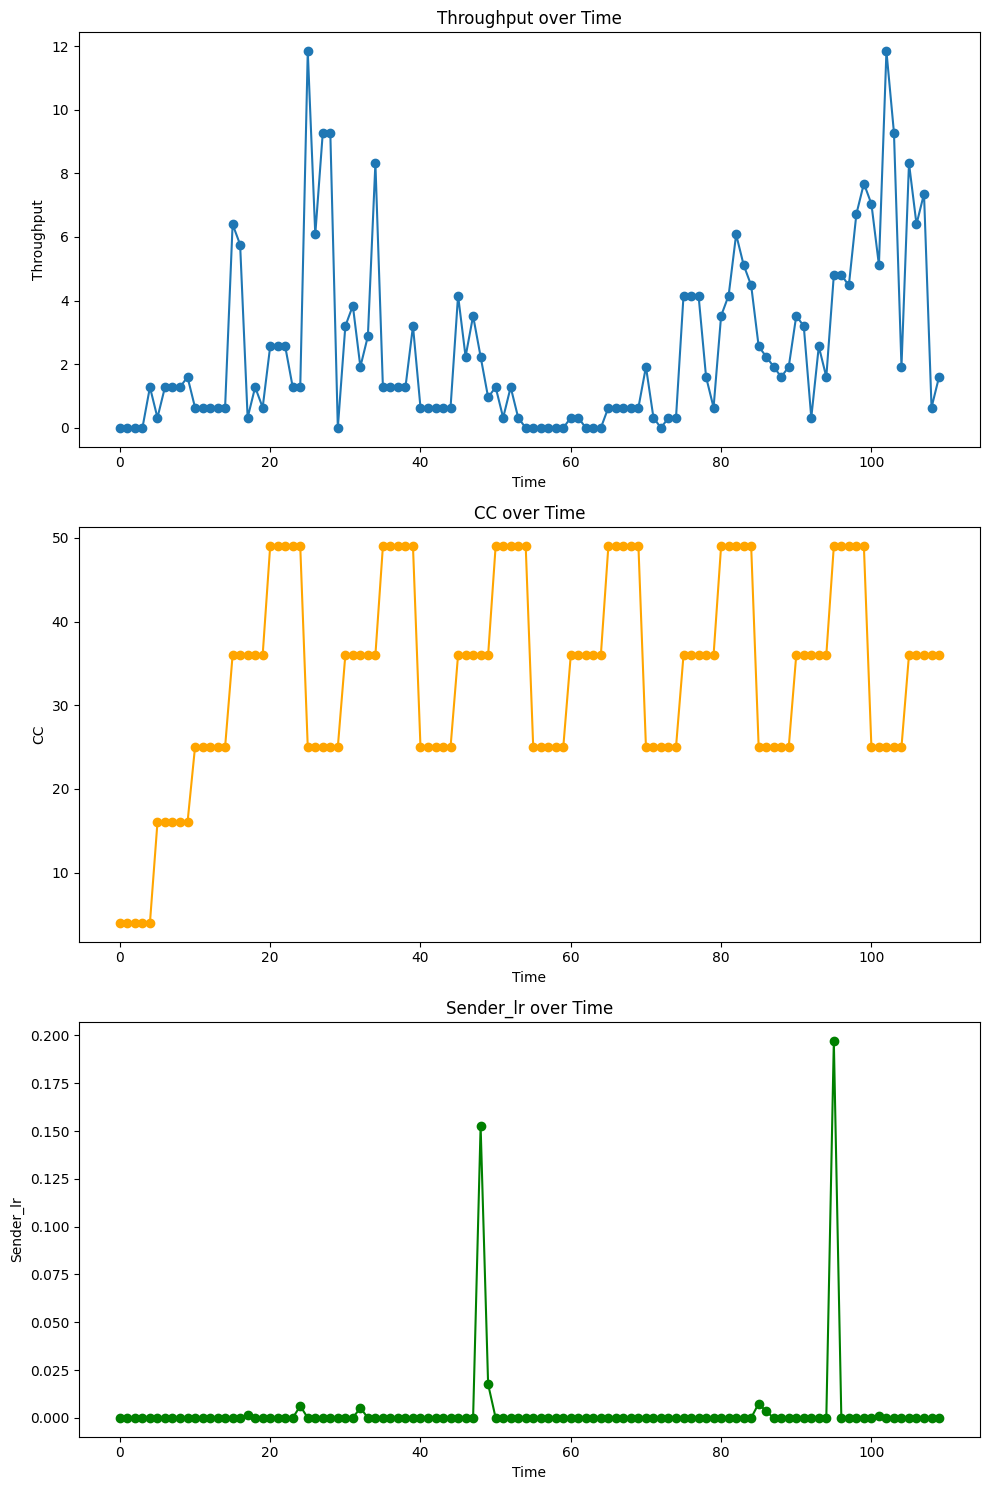

Episode reward: 104.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   21
rewards [0.0, 1.4, 0.20000000000000018, -0.6000000000000001, -1.0, 0.0, 2.0, 0.7999999999999998, -0.9999999999999998, -0.40000000000000013, -0.3999999999999999, -1.0, 4.6, -0.9999999999999996, -1.6, 3.5999999999999996, -5.3999999999999995, 4.2, 3.0, -3.4000000000000004, 100],  21
Average Throughput 2.5996190476190475
Total Energy 6294.0
Total packet loss 0.038027
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  105.000000   105.000000  105.000000  105.000000  105.000000  105.000000
mean     2.599619     0.006032    2.304762   34.467619   59.942857    0.000362
std      3.035039     0.050379    2.773930   11.148512   27.164679    0.001854
min      0.000000     0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.320000     0.000000    0.000000   32.700000   42.000000    0.000000
50%      1.280000     0.000000    1.000000   32.900000   65.

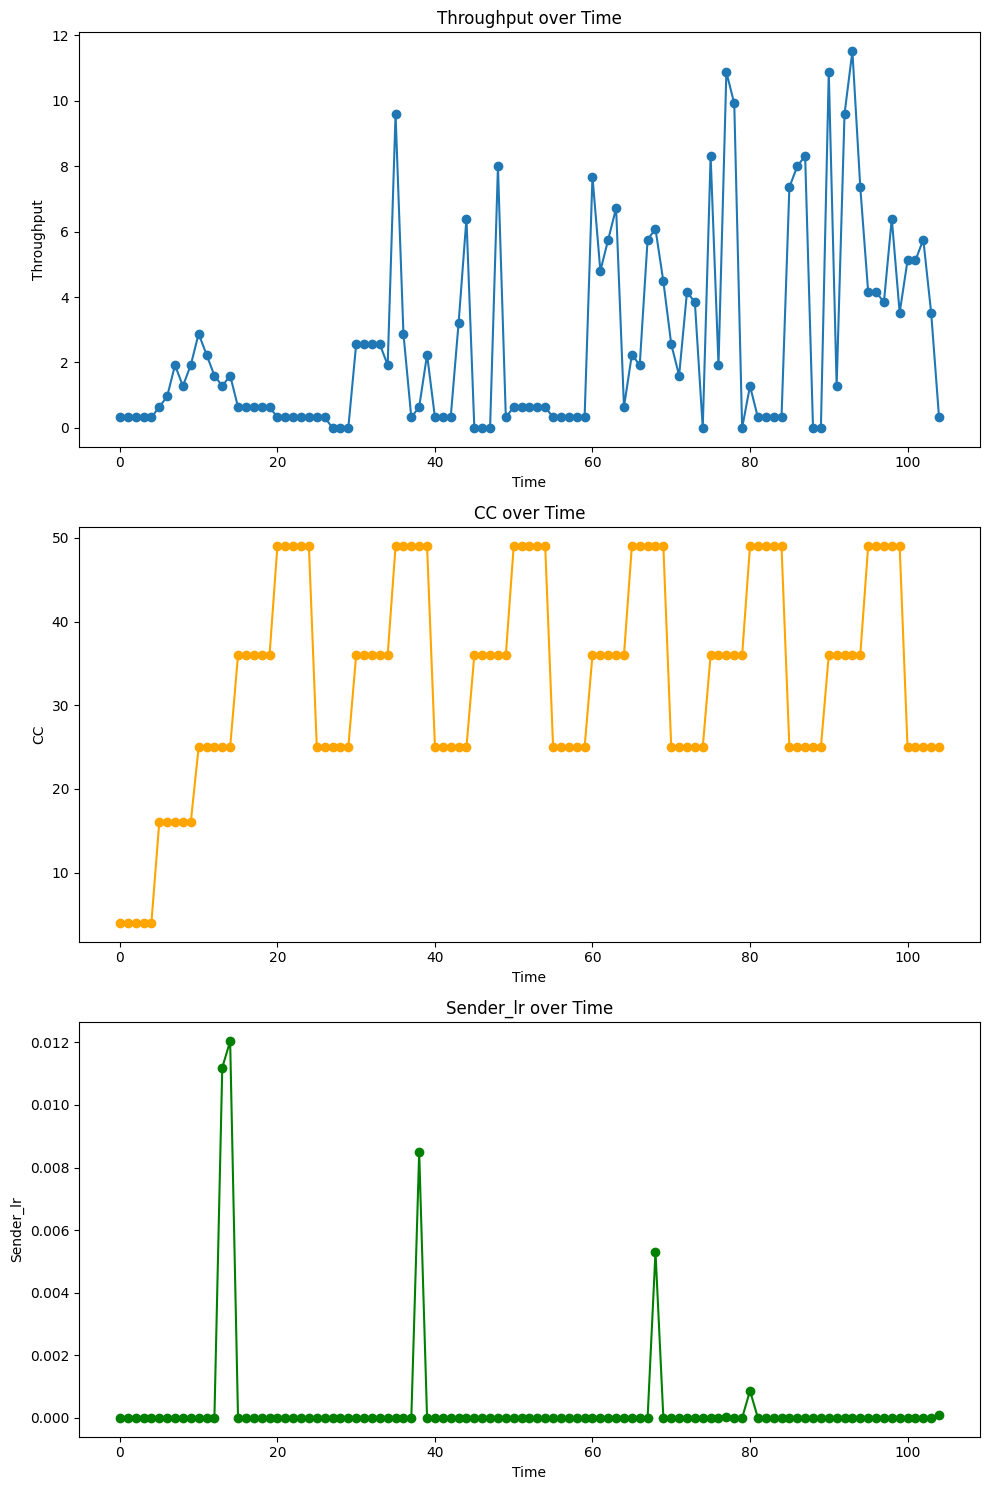

Episode reward: 100.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   26
rewards [2.2, -1.0000000000000002, -0.19999999999999996, 1.0, -2.0, 0.0, 4.0, -4.0, 0.6, 0.4, 0.3999999999999999, 2.6, -3.0, -1.0, 0.6, 0.0, 0.4, -0.19999999999999996, 6.4, -1.7999999999999998, -2.8000000000000003, -1.6, 2.4, -3.4, 0.0, 100],  26
Average Throughput 2.0799999999999996
Total Energy 7206.0
Total packet loss 0.46863400000000005
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  130.000000        130.0  130.000000  130.000000  130.000000  130.000000
mean     2.080000          0.0    1.738462   32.536923   55.430769    0.003605
std      2.646672          0.0    2.482665    7.365393   31.198772    0.028821
min      0.000000          0.0   -8.000000    0.000000    0.000000    0.000000
25%      0.320000          0.0    0.000000   32.700000   43.000000    0.000000
50%      0.960000          0.0    1.000000   32.800000   58.000000  

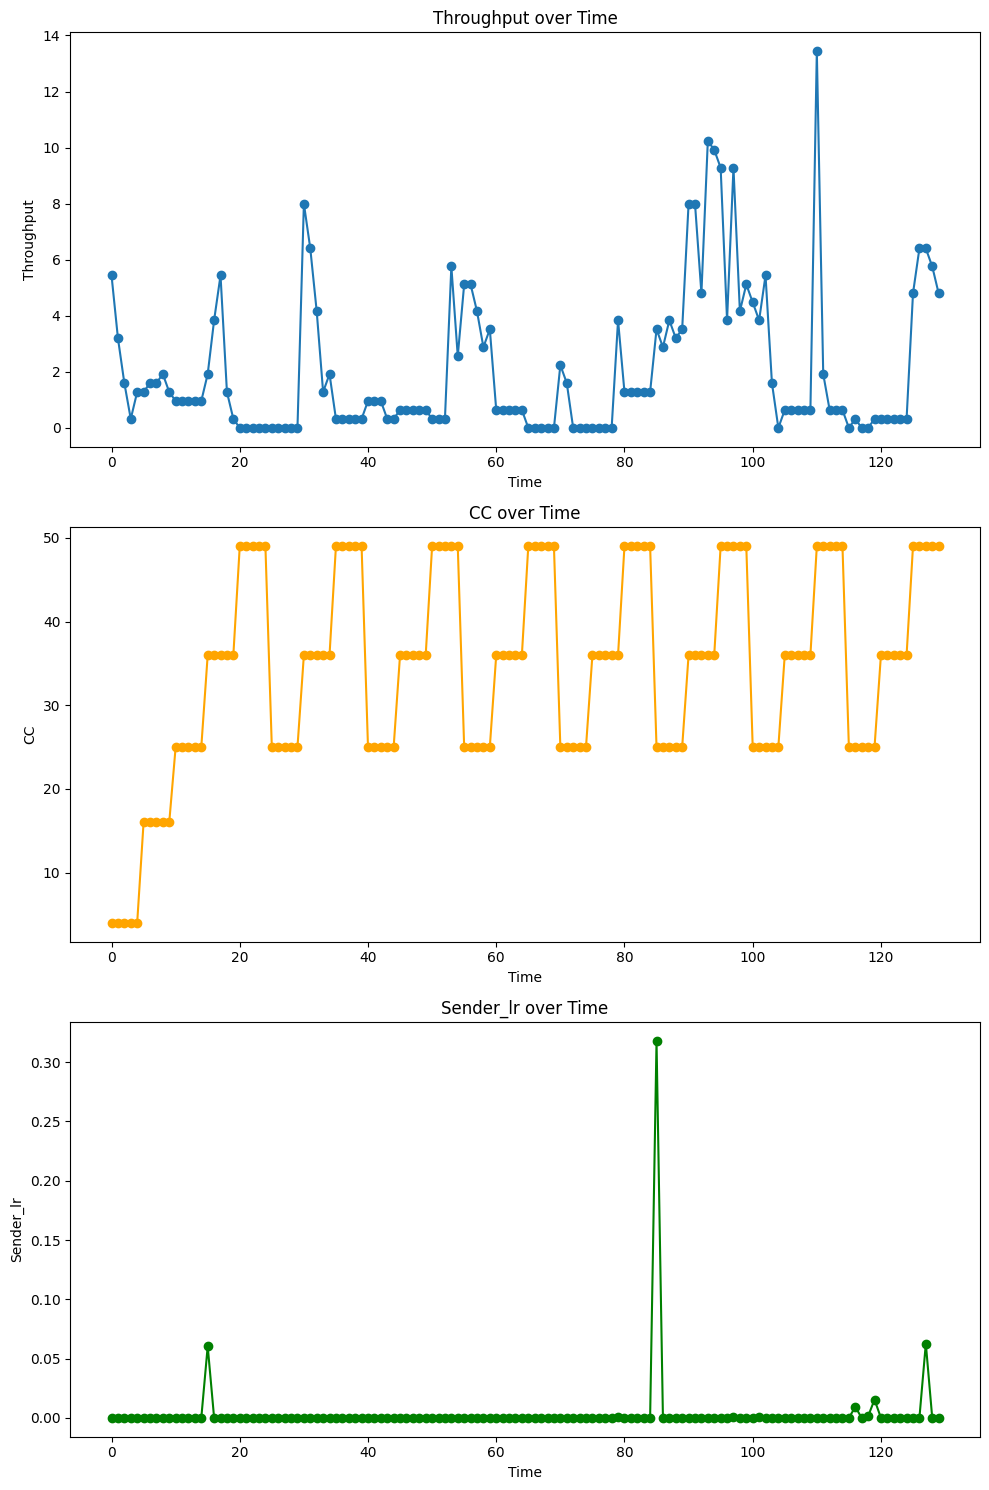

Episode reward: 101.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   14
rewards [0.2, 2.0, 1.7999999999999998, -0.6000000000000001, 3.4, -0.20000000000000018, -2.3999999999999995, -3.2, -1.0, 6.2, -1.4000000000000004, -3.5999999999999996, -0.19999999999999996, 100],  14
Average Throughput 3.8537142857142865
Total Energy 4104.0
Total packet loss 0.06447800000000001
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   70.000000         70.0  70.000000  70.000000  70.000000  70.000000
mean     3.853714          0.0   3.385714  33.164286  58.628571   0.000921
std      3.656864          0.0   3.195526   4.954197  23.654011   0.004887
min      0.000000          0.0   0.000000   0.000000   0.000000   0.000000
25%      0.720000          0.0   1.000000  32.700000  42.000000   0.000000
50%      2.400000          0.0   2.500000  32.800000  58.000000   0.000000
75%      6.960000          0.0   6.000000  33.075000  80.000000   0.000000
max     12.800000         

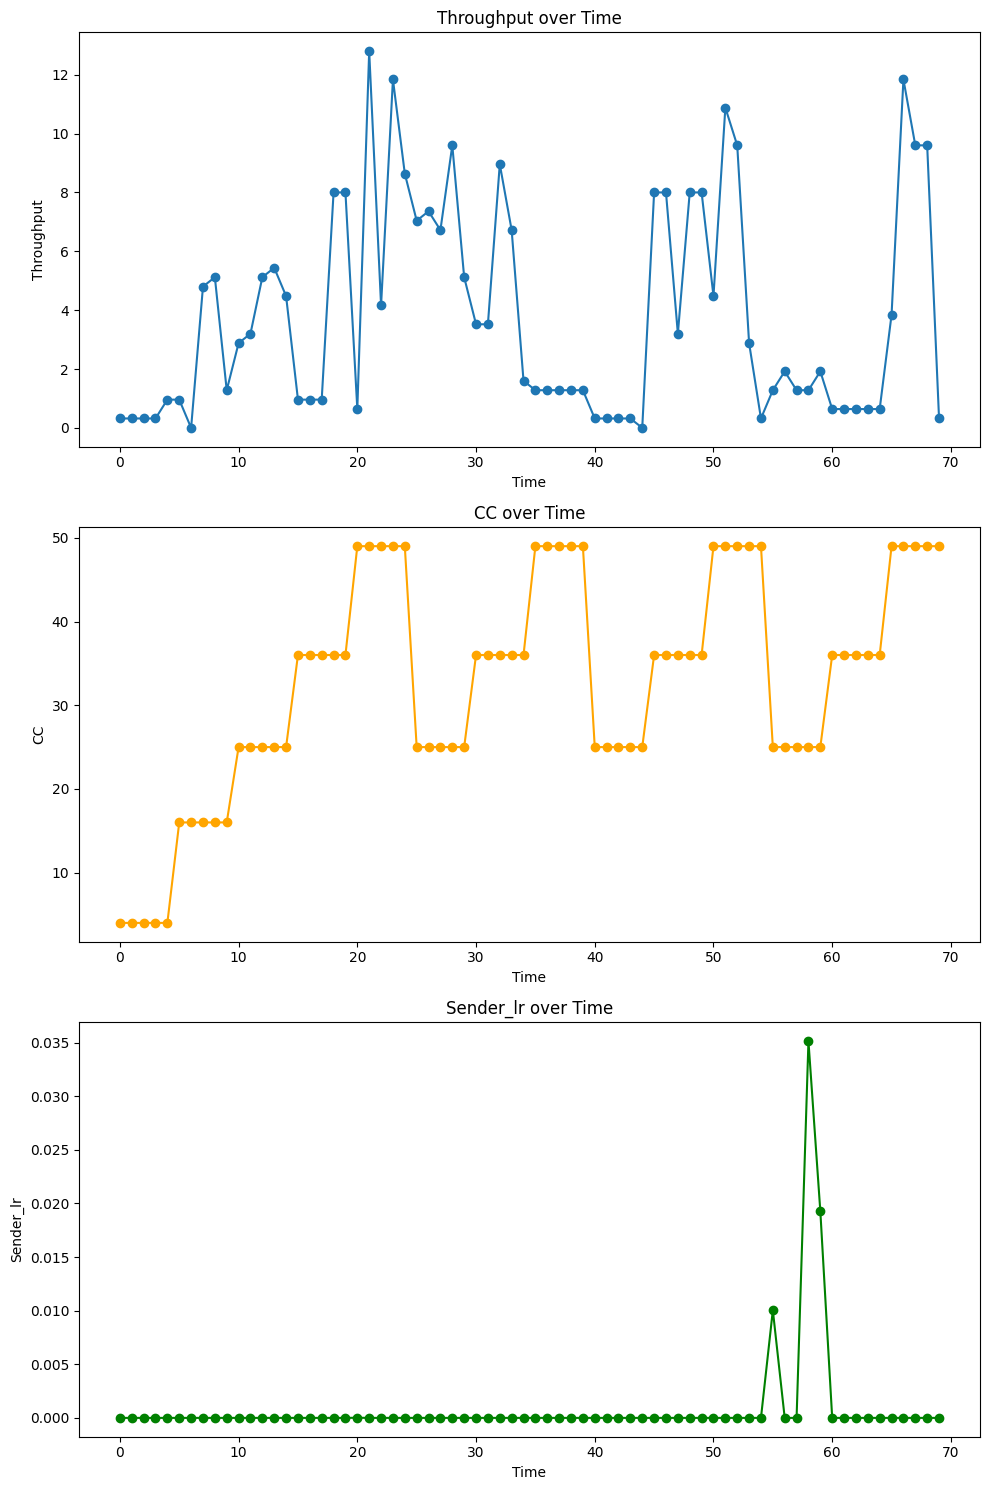

Episode reward: 101.4
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0],   19
rewards [1.0, 0.0, -0.4, 0.4, 3.8, -4.0, 1.4000000000000001, 1.4, -0.20000000000000018, 0.20000000000000018, -3.4, 5.8, -5.0, 0.3999999999999999, 1.2000000000000002, -0.6000000000000001, 1.2000000000000002, -1.8000000000000003, 100],  19
Average Throughput 2.7519999999999993
Total Energy 5654.0
Total packet loss 0.039654
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   95.000000         95.0  95.000000  95.000000  95.000000  95.000000
mean     2.752000          0.0   2.431579  33.552632  59.515789   0.000417
std      2.668101          0.0   2.318531   5.703206  25.144630   0.002248
min      0.000000          0.0   0.000000   0.000000   0.000000   0.000000
25%      0.960000          0.0   1.000000  32.700000  48.000000   0.000000
50%      1.600000          0.0   1.000000  33.000000  60.000000   0.000000
75%      4.160000          0.0   4.000000  34.200000  79.5

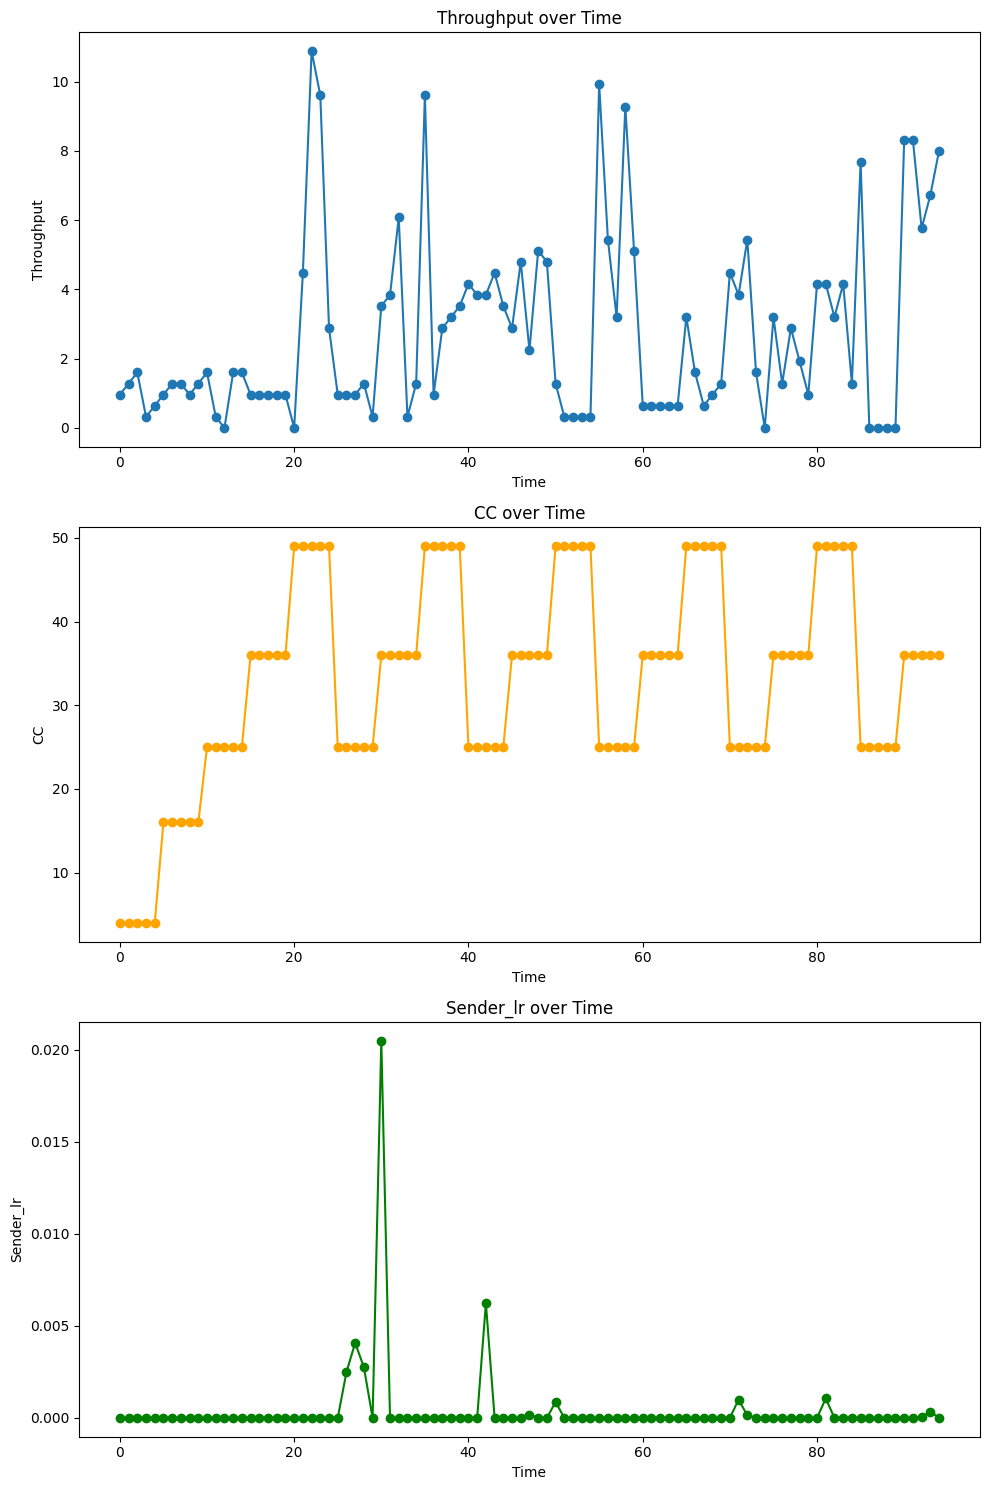

Episode reward: 101.8
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   18
rewards [0.4, 0.6, 0.0, 4.6, -3.5999999999999996, 1.2000000000000002, -1.0, -1.2000000000000002, 0.0, 5.2, -2.0, 1.2000000000000002, 0.39999999999999947, -4.6, -1.2, 0.0, 1.8, 100],  18
Average Throughput 2.912
Total Energy 4955.0
Total packet loss 0.113748
       Throughput  receiver_lr      Score        RTT     Energy  sender_lr
count   90.000000         90.0  90.000000  90.000000  90.000000  90.000000
mean     2.912000          0.0   2.488889  34.525556  55.055556   0.001264
std      3.080203          0.0   2.740641   3.686159  20.953325   0.007119
min      0.000000          0.0   0.000000  32.500000   0.000000   0.000000
25%      0.640000          0.0   1.000000  32.700000  43.000000   0.000000
50%      1.280000          0.0   1.000000  32.950000  49.000000   0.000000
75%      4.720000          0.0   4.000000  34.550000  75.000000   0.000000
max     10.880000          0.0  10.000000  51.90000

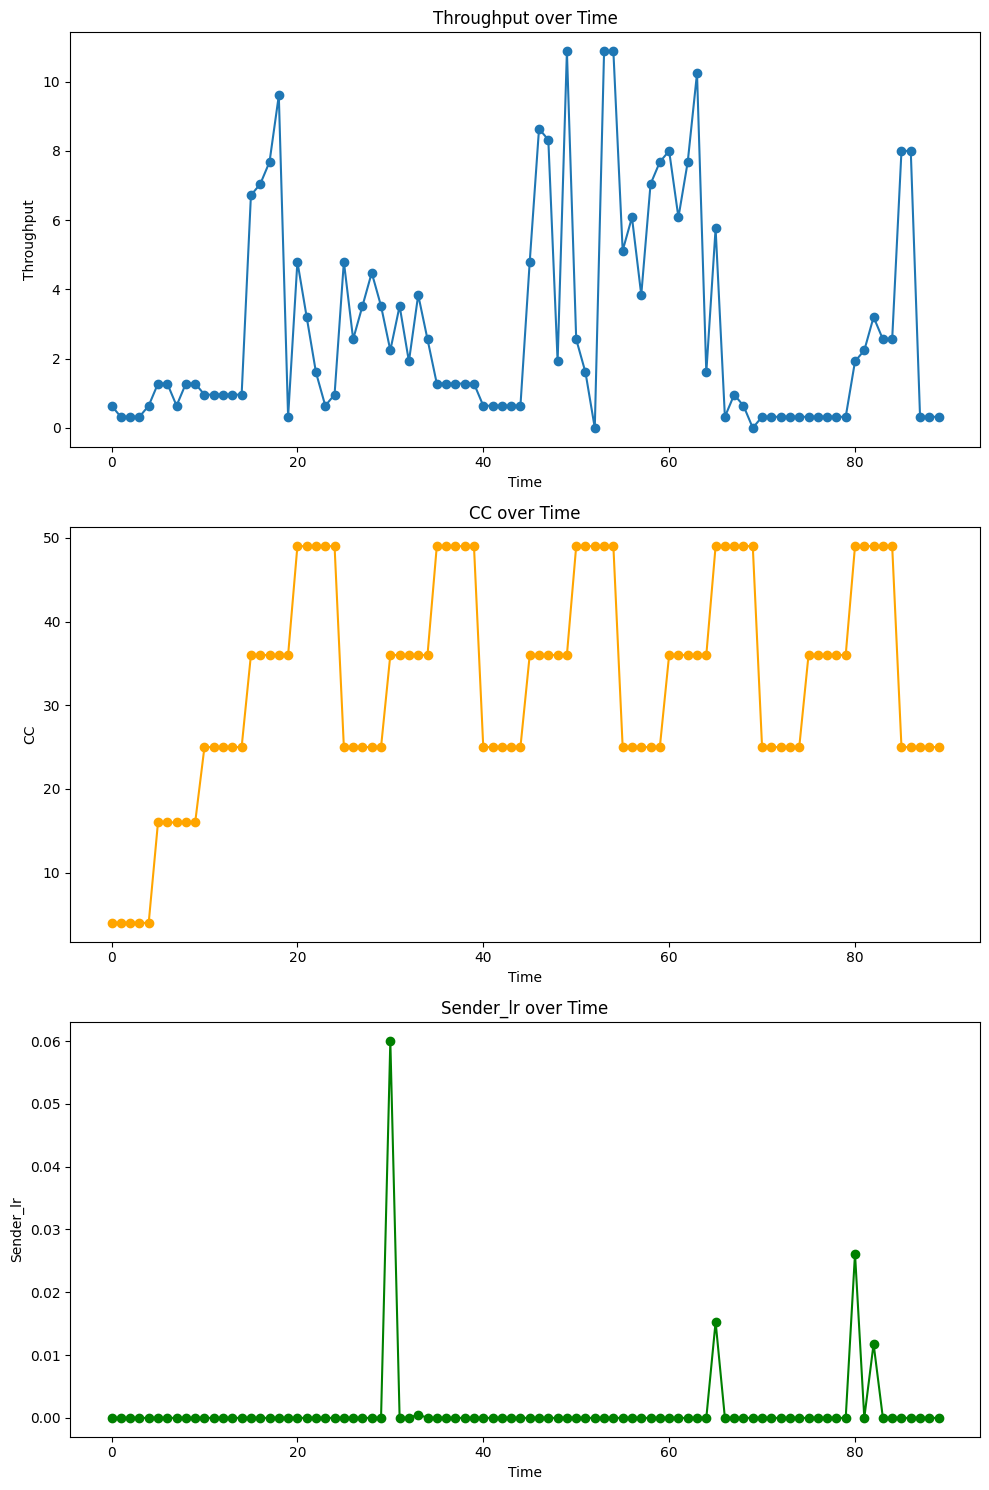

Episode reward: 100.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   21
rewards [4.0, -1.2000000000000002, -1.4, 1.2000000000000002, -1.8, 0.19999999999999996, 0.3999999999999999, 4.6, -3.0, -2.0, 0.0, 1.2000000000000002, 0.19999999999999973, -1.2, -0.19999999999999996, 6.0, -2.8, -1.6, -2.6, 0.0, 100],  21
Average Throughput 2.6514285714285717
Total Energy 6009.0
Total packet loss 0.016321
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  105.000000        105.0  105.000000  105.000000  105.000000  105.000000
mean     2.651429          0.0    2.419048   32.242857   57.228571    0.000155
std      2.712647          0.0    2.405047    7.607270   27.007213    0.000868
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.640000          0.0    1.000000   32.700000   43.000000    0.000000
50%      1.280000          0.0    1.000000   32.800000   63.000000    0.000000
75%      3.840000        

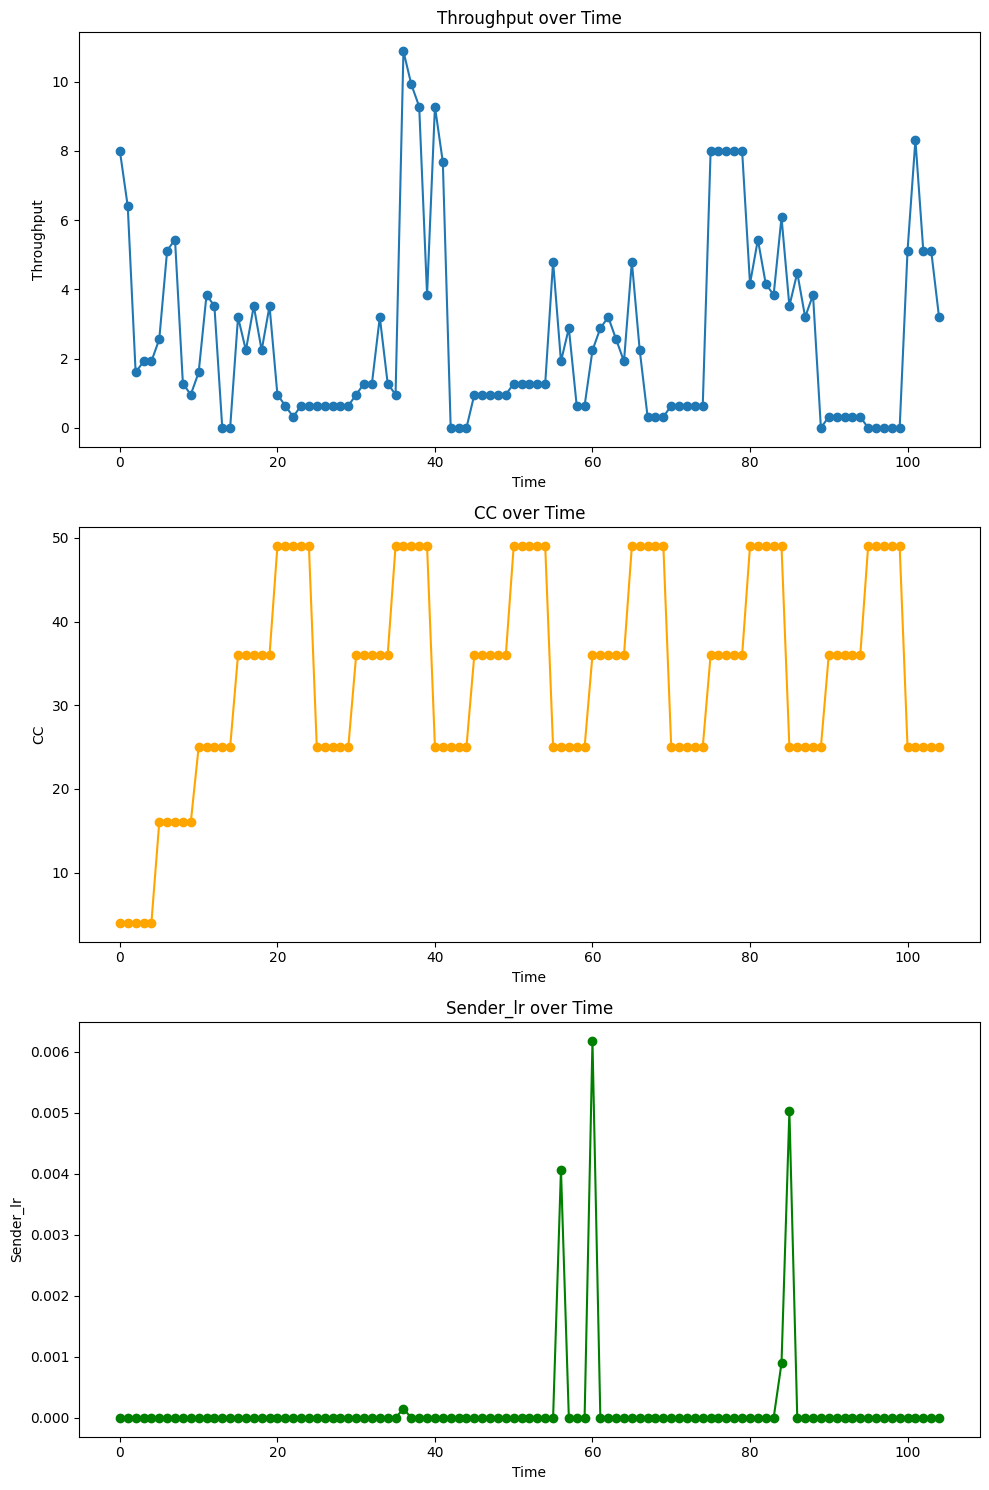

Episode reward: 104.0
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0],   17
rewards [0.8, 0.19999999999999996, 0.0, 3.0, 2.0, -3.0, 1.4000000000000004, -0.8000000000000003, -3.0, 0.0, -0.6, 2.0, -1.0, 7.0, -3.4000000000000004, -0.5999999999999996, 100],  17
Average Throughput 3.162352941176471
Total Energy 5043.0
Total packet loss 0.115139
       Throughput  receiver_lr      Score        RTT      Energy  sender_lr
count   85.000000         85.0  85.000000  85.000000   85.000000  85.000000
mean     3.162353          0.0   2.752941  33.991765   59.329412   0.001355
std      3.150633          0.0   2.694376   5.042822   29.375803   0.005938
min      0.000000          0.0   0.000000   0.000000    0.000000   0.000000
25%      0.960000          0.0   1.000000  32.700000   43.000000   0.000000
50%      1.920000          0.0   1.000000  32.800000   57.000000   0.000000
75%      5.120000          0.0   4.000000  34.200000   82.000000   0.000000
max     11.520000          0.0  10.000

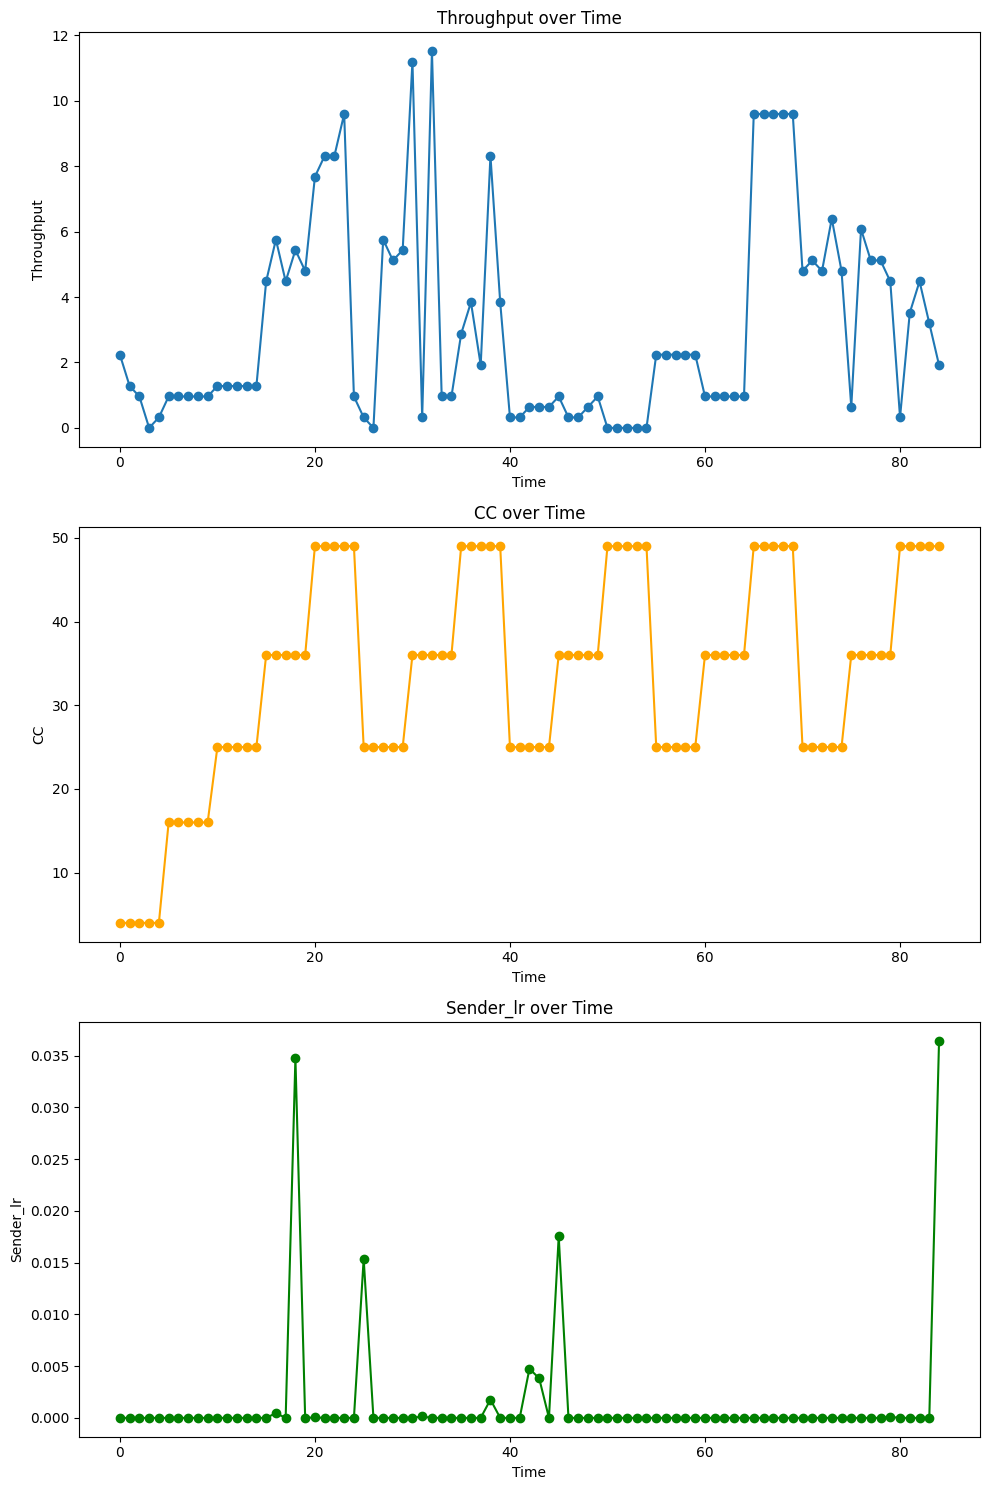

Episode reward: 101.6
actions [1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3],   21
rewards [1.6, 3.1999999999999997, -3.8, 4.4, -5.4, 7.2, -2.8, -4.4, 0.0, 0.0, 0.6, 2.1999999999999997, -1.7999999999999998, 2.8, 2.4000000000000004, -2.8000000000000003, -2.2, -1.2, 0.0, 1.6, 100],  21
Average Throughput 2.486857142857143
Total Energy 5621.0
Total packet loss 0.017660000000000002
       Throughput  receiver_lr       Score         RTT      Energy   sender_lr
count  105.000000        105.0  105.000000  105.000000  105.000000  105.000000
mean     2.486857          0.0    2.200000   33.781905   53.533333    0.000168
std      2.810182          0.0    2.547246    6.112106   29.561886    0.000841
min      0.000000          0.0    0.000000    0.000000    0.000000    0.000000
25%      0.320000          0.0    0.000000   32.700000   44.000000    0.000000
50%      1.280000          0.0    1.000000   32.800000   58.000000    0.000000
75%      3.840000          0.0    4.000000   34.0

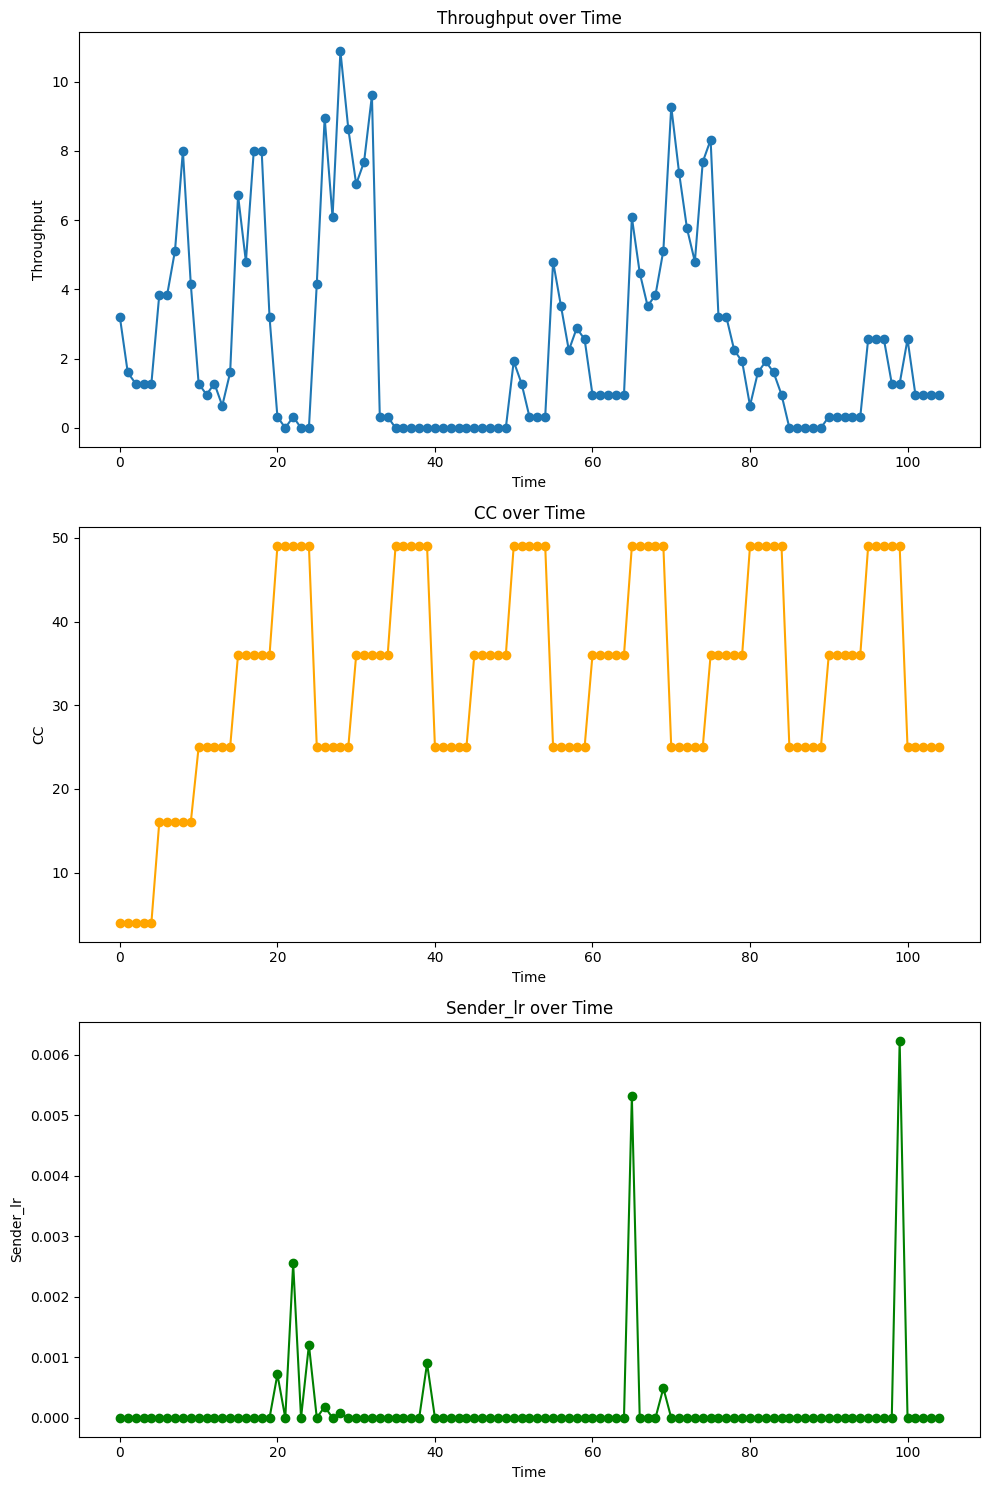

In [10]:
####       RL PPO   SB3

num_of_run=30

rl_throughput_list_=[]
rl_energy_list_=[]
rl_plr_list_=[]


model = PPO.load("./ppo_action_in_de_reward_100_at_the_end/ppo_best_model/best_model.zip")
for i in range(0,num_of_run):
    done = False
    episode_reward = 0
    env=transferClass_increase_decrease(loaded_dfs,loaded_initial_dfs,'random')
    action_list=[]
    reward_list=[]
    obs = env.reset()
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action_list.append(int(action))
    #     print("action: ",action)
        obs, reward, done, info = env.step(action)
    #     obs = obs.astype(np.float32)
    #     print("obs: ", obs,".... reward: ",reward)
        reward_list.append(reward)
        episode_reward += reward

    accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
    accumulator_df=accumulator_df.reset_index(drop=True)
    env.close()
    
    
    print(f"Episode reward: {episode_reward}")
    print(f"actions {action_list},   {len(action_list)}")
    print(f"rewards {reward_list},  {len(reward_list)}")
    print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
    print(f"Total Energy {accumulator_df['Energy'].sum()}")
    print(f"Total packet loss {accumulator_df['sender_lr'].sum()}")
    
    
    
    rl_throughput_list_.append(accumulator_df['Throughput'].mean())
    rl_energy_list_.append(accumulator_df['Energy'].sum())
    rl_plr_list_.append(accumulator_df['sender_lr'].sum())
    print(accumulator_df.describe())
    print(accumulator_df)
    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # 3 plots vertically stacked

    # Throughput
    axs[0].plot(accumulator_df.index, accumulator_df['Throughput'], marker='o', linestyle='-')
    axs[0].set_title('Throughput over Time')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Throughput')

    # CC
    axs[1].plot(accumulator_df.index, accumulator_df['CC'], marker='o', linestyle='-', color='orange')
    axs[1].set_title('CC over Time')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('CC')

    # Sender_lr
    axs[2].plot(accumulator_df.index, accumulator_df['sender_lr'], marker='o', linestyle='-', color='green')  # Assuming Score is a typo and you meant sender_lr
    axs[2].set_title('Sender_lr over Time')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Sender_lr')

    plt.tight_layout()
    plt.show()

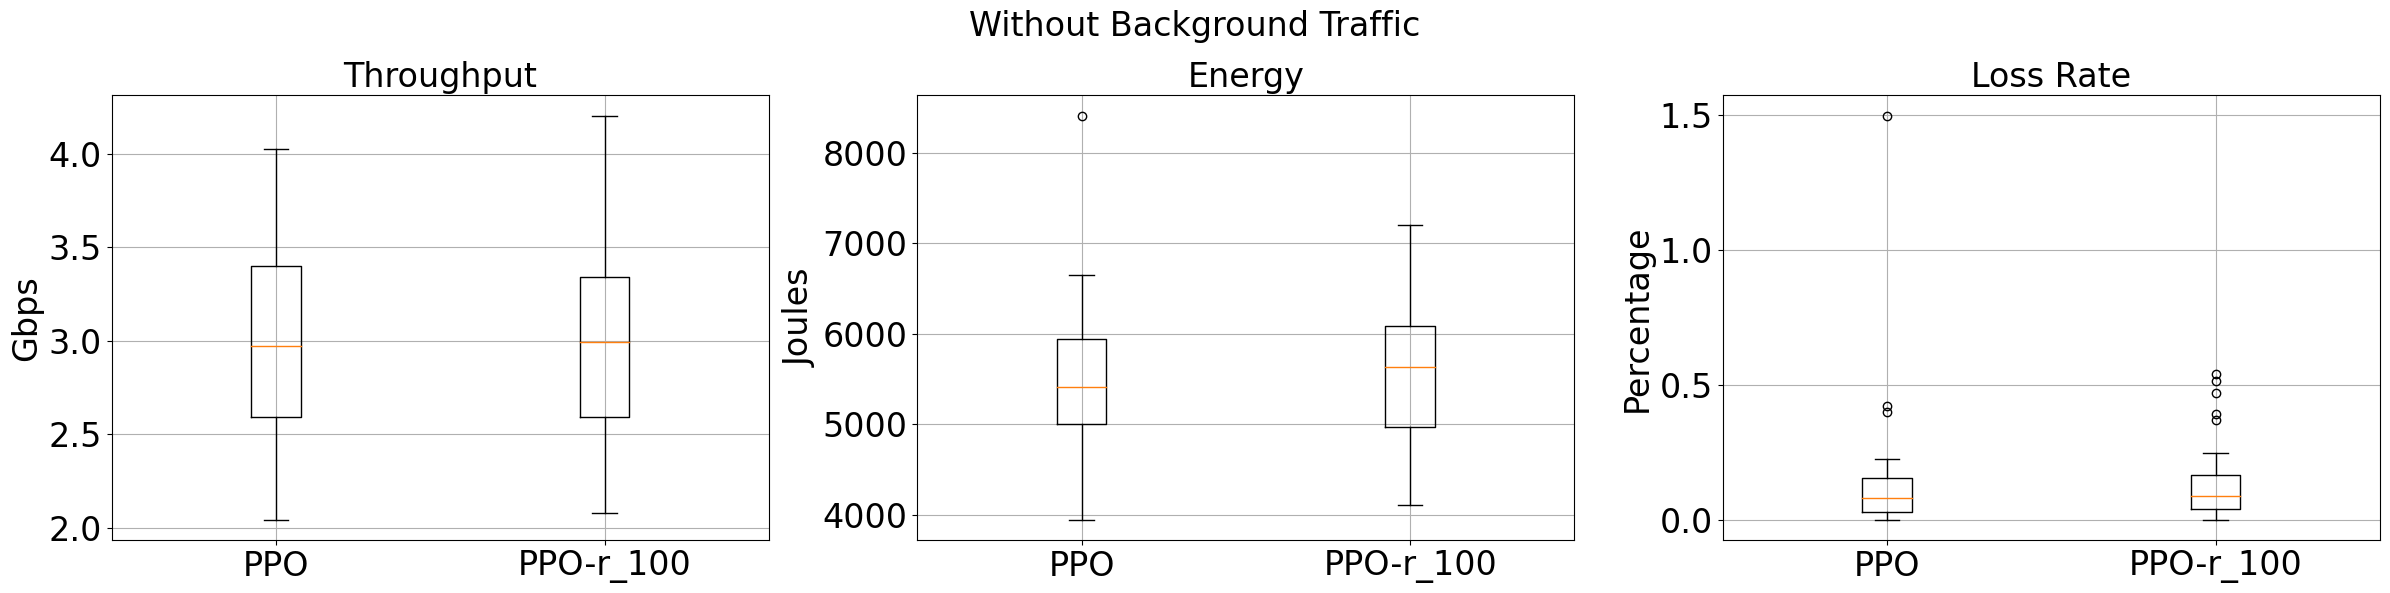

In [12]:
result_dictionary={"Throughput":[rl_throughput_list,rl_throughput_list_],"Energy":[rl_energy_list,rl_energy_list_],"lossRate":[rl_plr_list,rl_plr_list_]}
import matplotlib.pyplot as plt

labels = [ 'PPO','PPO-r_100']

# Assuming result_dictionary is already defined with the relevant data
# result_dictionary = {...}

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Font size for the ticks
tick_font_size = 24  # You can change this value as needed

# Plotting Throughput
axes[0].boxplot(result_dictionary['Throughput'], labels=labels)
axes[0].set_title('Throughput',fontsize=24)
axes[0].set_ylabel('Gbps',fontsize=24)
axes[0].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[0].grid(True)  # Adding grid

# Plotting Energy
axes[1].boxplot(result_dictionary['Energy'], labels=labels)
axes[1].set_title('Energy',fontsize=24)
axes[1].set_ylabel('Joules',fontsize=24)
axes[1].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[1].grid(True)  # Adding grid

# Plotting Loss Rate
axes[2].boxplot(result_dictionary['lossRate'], labels=labels)
axes[2].set_title('Loss Rate',fontsize=24)
axes[2].set_ylabel('Percentage',fontsize=24)
axes[2].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[2].grid(True)  # Adding grid
# axes[2].set_title('Without Background Traffic',fontsize=18)
plt.suptitle('Without Background Traffic',fontsize=tick_font_size)

plt.tight_layout()
plt.show()
